In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
import time
import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2+abs(x.sum()-args.card)/args.card/2
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_mixed(Q,a,MODEL):
    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables))+(np.array(variables).dot(a))*(np.array(variables).dot(a)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    MODEL.optimize()
    return np.array(MODEL.x)

In [2]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = np.dot(A_inv, u)
    A_inv -= np.outer(Au, Au)/(1+np.dot(u.T, Au))
    return A_inv

class Model(nn.Module):
    """Template for fully connected neural network for scalar approximation.
    """
    def __init__(self, 
                 input_size=1, 
                 hidden_size=2,
                 n_layers=4,
                 activation='ReLU',
                 p=0.0,
                ):
        super(Model, self).__init__()
        
        self.n_layers = n_layers
        
        if self.n_layers == 1:
            self.layers = [nn.Linear(input_size, 1)]
        else:
            size  = [input_size] + [hidden_size,] * (self.n_layers-1) + [1]
            self.layers = [nn.Linear(size[i], size[i+1]) for i in range(self.n_layers)]
        self.layers = nn.ModuleList(self.layers)
        
        # dropout layer
        self.dropout = nn.Dropout(p=p)
        
        # activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        else:
            raise Exception('{} not an available activation'.format(activation))
            
    def forward(self, x):
        for i in range(self.n_layers-1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x


In [3]:
import numpy as np
import abc
from tqdm import tqdm

class UCB(abc.ABC):
    """Base class for UBC methods.
    """
    def __init__(self,
                 bandit,
                 reg_factor=1.0,
                 confidence_scaling_factor=-1.0,
                 delta=0.1,
                 train_every=1,
                 throttle=int(1e2),
                ):
        # bandit object, contains features and generated rewards
        self.bandit = bandit
        # L2 regularization strength
        self.reg_factor = reg_factor
        # Confidence bound with probability 1-delta
        self.delta = delta
        # multiplier for the confidence bound (default is bandit reward noise std dev)
        if confidence_scaling_factor == -1.0:
            confidence_scaling_factor = bandit.noise_std
        self.confidence_scaling_factor = confidence_scaling_factor
        
        # train approximator only every few rounds
        self.train_every = train_every
        self.best_recommended_reward =-200
        self.best_recommended_action =np.array([1]*args.card+[0]*(self.bandit.n_features-args.card))
        self.rewards_list=[]
        self.best_sample_rewards_list=[]
        self.feasi=[]
        # throttle tqdm updates
        self.throttle = throttle
        self.solverSol=None
        self.reset()
        
    def reset_upper_confidence_bounds(self):
        """Initialize upper confidence bounds and related quantities.
        """
        self.exploration_bonus = np.empty((self.bandit.T, self.bandit.n_arms))
        self.mu_hat = np.empty((self.bandit.T, self.bandit.n_arms)) 
        self.meta_mu_hat = np.empty(( self.bandit.n_features)) 
        self.cross_mu_hat = np.empty(( self.bandit.n_features**2)) 
        self.upper_confidence_bounds = np.ones((self.bandit.T, self.bandit.n_arms))
        self.meta_values= np.ones((self.bandit.n_features))
        self.cross_values= np.ones((self.bandit.n_features**2))
        self.knn_metabest=-100
        self.best_rewards_oracle=-100
    def reset_regrets(self):
        """Initialize regrets.
        """
        self.regrets = np.empty(self.bandit.T)

    def reset_actions(self):
        """Initialize cache of actions.
        """
        self.actions = np.empty(self.bandit.T).astype('int')
    
    def reset_A_inv(self):
        """Initialize n_arms square matrices representing the inverses
        of exploration bonus matrices.
        """
        self.A_inv = np.array(
            [
                np.eye(self.approximator_dim)/self.reg_factor for _ in self.bandit.arms
            ]
        )
    def reset_grad_approx(self):
        """Initialize the gradient of the approximator w.r.t its parameters.
        """
        self.grad_approx = np.zeros((self.bandit.n_arms, self.approximator_dim))

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        if self.iteration>=max(self.bandit.n_features*4,100):
            return np.argmax(self.upper_confidence_bounds[self.iteration]).astype('int')
        else:
            return np.random.choice(self.bandit.n_arms)
    @abc.abstractmethod
    def reset(self):
        """Initialize variables of interest.
        To be defined in children classes.
        """
        pass

    @property
    @abc.abstractmethod
    def approximator_dim(self):
        """Number of parameters used in the approximator.
        """
        pass
    
    @property
    @abc.abstractmethod
    def confidence_multiplier(self):
        """Multiplier for the confidence exploration bonus.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def update_confidence_bounds(self):
        """Update the confidence bounds for all arms at time t.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def update_output_gradient(self):
        """Compute output gradient of the approximator w.r.t its parameters.
        """
        pass
    
    @abc.abstractmethod
    def train(self):
        """Update approximator.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def predict(self):
        """Predict rewards based on an approximator.
        To be defined in children classes.
        """
        pass

    def update_confidence_bounds(self):
        """Update confidence bounds and related quantities for all arms.
        """
        
        if self.iteration>max(self.bandit.n_features*4,100):#self.bandit.n_features:
            self.bandit.features[self.iteration][2]=self.best_recommended_action
            self.bandit.features[self.iteration][0]=self.solverSol
            self.bandit.features[self.iteration][1]=self.solverSol_quad
            for j in range(3,self.bandit.n_arms//3):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//3,self.bandit.n_arms//2):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol_quad]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//2,2*self.bandit.n_arms//3):
                tmp=self.bandit.features[self.iteration][j]+np.random.random()*(self.best_recommended_action-self.bandit.features[self.iteration][j])
                self.model.eval()
                if self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][j]).to(self.device)).detach().squeeze()<self.model.forward(torch.FloatTensor(tmp).to(self.device)).detach().squeeze():
                    tmp2=sorted(tmp)[-args.card:] 
                    self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            if np.random.random()>0.4:
                a=np.random.choice(self.bandit.n_arms)
                b=np.random.choice(self.bandit.n_arms)
                if a!=b:
                    self.model.eval()
                    if  self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][a]).to(self.device)).detach().squeeze()>self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][b]).to(self.device)).detach().squeeze():
                        tmp=self.bandit.features[self.iteration][b]+np.random.random()*(a-b)
                        tmp2=sorted(tmp)[-args.card:] 
                        self.bandit.features[self.iteration][b]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))

        self.update_output_gradient()
        # UCB exploration bonus
        self.exploration_bonus[self.iteration] = np.array(
            [
                50000*constraint(self.bandit.features[self.iteration][a])+self.confidence_multiplier * np.sqrt(np.dot(self.grad_approx[a], np.dot(self.A_inv[a], self.grad_approx[a].T))) for a in self.bandit.arms
            ]
        ) #500000*constraint(self.bandit.features[self.iteration][a])+
        # update reward prediction mu_hat
        self.predict()
        self.bandit.rewards[self.iteration]=np.array([self.bandit.h(self.bandit.features[self.iteration, k],self.iteration) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])
        self.bandit.rewards2[self.iteration]=np.array([self.bandit.hwithoutconstraints(self.bandit.features[self.iteration, k]) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])

        # estimated combined bound for reward
        self.meta_values=self.meta_mu_hat# + self.meta_exploration_bonus[self.iteration] 
        if self.iteration>=max(self.bandit.n_features*4,100):
            self.cross_values=self.cross_mu_hat
            for i in range(self.bandit.n_features):
                for j in range(self.bandit.n_features):
                    if i==j:
                        self.cross_values[i*self.bandit.n_features+j]=self.meta_mu_hat[i]
                    else:
                        self.cross_values[i*self.bandit.n_features+j]=(self.cross_mu_hat[i*self.bandit.n_features+j]-self.meta_mu_hat[i]-self.meta_mu_hat[j])/2
            self.cross_values=self.cross_values.reshape(self.bandit.n_features,self.bandit.n_features)
        with gurobipy.Env(empty=True) as env:
            env.setParam('OutputFlag', 0)
            env.setParam('IterationLimit',600)
            env.start()
            with gurobipy.Model(env=env) as m:
                self.solverSol=np.divide(solver(self.meta_values,m),np.sqrt(args.card))
        if self.iteration>=max(self.bandit.n_features*4,100):
            with gurobipy.Env(empty=True) as env:
                env.setParam('OutputFlag', 0)
                env.setParam('IterationLimit',600)
                env.start()
                with gurobipy.Model(env=env) as m:
                    self.solverSol_quad=np.divide(solver_quad(self.cross_values,m),np.sqrt(args.card))
                    print('solverSol_quad',self.bandit.hwithoutconstraints(self.solverSol_quad))
        tmp=sorted(self.meta_values )[-args.card:]   #后面记得加/改一下探索项！！！
        self.meta_values = np.array([1 if self.meta_values[i] in tmp else 0 for i in range(self.bandit.n_features)])
        if len(np.argwhere(self.meta_values==1)):
            metabest=np.argwhere(self.meta_values==1)[:args.card].reshape(args.card)
        else:
            metabest=list(range(self.bandit.n_features))
            np.random.shuffle(metabest)
            metabest=np.array(metabest[:args.card])
        knn_metabest={}
        import copy
        for i in range(10):
            tmp=metabest.copy()
            tmp[np.random.choice(range(args.card))]=np.random.choice(range(self.bandit.n_features))
            tmp=np.divide(np.array([1 if i in tmp else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            self.model.eval()
            tmpvalue=self.model.forward(
                    torch.FloatTensor(tmp).to(self.device)
                ).detach().squeeze()
            knn_metabest[tmpvalue]=tmp
        
        self.meta_values=np.divide(self.meta_values,np.sqrt(args.card))
        self.upper_confidence_bounds[self.iteration] = self.mu_hat[self.iteration] + self.exploration_bonus[self.iteration]
        self.knn_metabest=knn_metabest[max(knn_metabest.keys())]
        self.bandit.knn_metabestValue =self.bandit.h(self.knn_metabest,self.iteration)
        self.bandit.best_rewards_oracle =max( max(np.max(self.bandit.rewards, axis=1)),self.bandit.knn_metabestValue)
        self.best_rewards_oracle=max(max(self.best_rewards_oracle,self.bandit.best_rewards_oracle),self.bandit.hwithoutconstraints(self.knn_metabest))
        print('----------------',self.best_rewards_oracle,self.bandit.hwithoutconstraints(self.knn_metabest),checkFea(torch.from_numpy(self.knn_metabest)*np.sqrt(args.card)),self.bandit.hwithoutconstraints(self.solverSol),checkFea(np.sqrt(args.card)*torch.from_numpy(self.solverSol)))
    def update_A_inv(self):
        self.A_inv[self.action] = inv_sherman_morrison(
            self.grad_approx[self.action],
            self.A_inv[self.action]
        )
    def run(self):
        """Run an episode of bandit.
        """
        postfix = {
            'total regret': 0.0,
            '% optimal arm': 0.0,
        }
        with tqdm(total=self.bandit.T, postfix=postfix) as pbar:
            for t in range(self.bandit.T):
                # update confidence of all arms based on observed features at time t
                self.update_confidence_bounds()
                # pick action with the highest boosted estimated reward
                self.action = self.sample_action()
                self.actions[t] = self.action
                # update approximator
                if t % self.train_every == 0:
                    self.train()
                # update exploration indicator A_inv
                self.update_A_inv()
                # compute regret
                
                #print(t,self.action,self.bandit.best_rewards_oracle[t],self.bandit.rewards[t, self.action])
                print('hhhhh',self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]),np.sqrt(args.card)*sum(self.bandit.features[self.iteration][self.action]),checkFea(torch.from_numpy(self.bandit.features[self.iteration][self.action])*np.sqrt(args.card)))
                self.regrets[t] = self.best_rewards_oracle-self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                if self.best_recommended_reward<self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration):
                    self.best_recommended_reward=self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                    self.best_recommended_action=self.bandit.features[self.iteration][self.action]
                self.best_sample_rewards_list.append( self.best_rewards_oracle)
                self.rewards_list.append(self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]))
                self.feasi.append(checkFea(self.bandit.features[self.iteration][self.action]*np.sqrt(args.card)))
                # increment counter
                self.iteration += 1
                
                # log
                postfix['total regret'] += self.regrets[t]
                n_optimal_arm = np.sum(
                    self.actions[:self.iteration]==self.bandit.best_actions_oracle[:self.iteration]
                )
                postfix['% optimal arm'] = '{:.2%}'.format(n_optimal_arm / self.iteration)
                if t % self.throttle == 0:
                    pbar.set_postfix(postfix)
                    pbar.update(self.throttle)


In [4]:
import numpy as np
import itertools


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 h,
                 hwithoutconstraints,
                 noise_std=1.0,
                ):
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # average reward function
        # h : R^d -> R
        self.h = h
        self.hwithoutconstraints=hwithoutconstraints
        self.knn_metabestValue=-100
        self.best_rewards_oracle = -100
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std
        # generate random features
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)
        
    def reset(self):
        """Generate new features and new rewards.
        """
        self.reset_features()
        self.reset_rewards()
        
    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """
        x1,x2=[],[]
        for i in range(self.T):
            tmp1,tmp2=[],[]
            for j in range(self.n_arms):
                a=np.array([0]*(self.n_features-args.card)+[1]*args.card)
                np.random.shuffle(a)
                a=np.divide(a,np.sqrt(args.card))
                tmp1.append(a)
            for j in range(self.n_features):
                a=np.array([0.0]*j+[1.0]+[0.0]*(self.n_features-j-1))
                tmp2.append(a)
            x1.append(tmp1)
            x2.append(tmp2)
        x1,x2=np.array(x1),np.array(x2)
        #x /= np.repeat(np.linalg.norm(x, axis=-1, ord=2), self.n_features).reshape(self.T, self.n_arms, self.n_features)
        self.features = x1
        self.meta_features=x2
        self.cross_features=[]
        for i in range(self.n_features):
            for j in range(self.n_features):
                tmp=np.zeros(self.n_features)
                tmp[i]=1
                tmp[j]=1
                self.cross_features.append(tmp)
                
    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """
        
        self.rewards = np.random.random([self.T, self.n_arms])
        self.rewards2 = np.random.random([self.T, self.n_arms])
        
        # to be used only to compute regret, NOT by the algorithm itself
        self.best_rewards_oracle =max( max(np.max(self.rewards, axis=1)),self.knn_metabestValue)
        self.best_actions_oracle = np.argmax(self.rewards, axis=1)


In [5]:
import numpy as np
import torch
import torch.nn as nn

class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=8,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers
        
        # number of rewards in the training buffer
        self.training_window = training_window
        
        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            raise Exception(
                'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')
    
        # dropout rate
        self.p = p

        # neural network
        self.model = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.model2 = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.optimizer2 = torch.optim.Adam(self.model2.parameters(), lr=self.learning_rate)

        super().__init__(bandit, 
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                        )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)
    
    @property
    def confidence_multiplier(self):
        """Constant equal to confidence_scaling_factor
        """
        return self.confidence_scaling_factor
    
    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
            
            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)
        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x)
            y.backward()

        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x)
            y.backward()
            
    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
        iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
        actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features[iterations_so_far, actions_so_far]).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        y_train2 = torch.FloatTensor(self.bandit.rewards2[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        
        # train mode
        self.model.train()
        for _ in range(self.epochs):
            y_pred = self.model.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.model2.train()
        for _ in range(self.epochs):
            y_pred = self.model2.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer2.step()
        
        
    def predict(self):
        """Predict reward.
        """
        # eval mode
        self.model.eval()
        self.mu_hat[self.iteration] = self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration]).to(self.device)
        ).detach().squeeze()
        self.meta_mu_hat = self.model2.forward(
            torch.FloatTensor(self.bandit.meta_features[self.iteration]).to(self.device)
        ).detach().squeeze()
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_mu_hat= self.model2.forward(
                torch.FloatTensor(self.bandit.cross_features).to(self.device)
            ).detach().squeeze()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
T = int(5e3)
n_arms =20
n_features = 24
noise_std = 0.5

confidence_scaling_factor = noise_std

n_sim = 1

p = 0.2
hidden_size = 4#16
epochs = 100#100
train_every = 10#10
confidence_scaling_factor = 1.0
use_cuda = False

In [8]:
### mean reward function

a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())#np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.load('Q24.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*(1/(1+np.exp(-iteration))-0.5)*torch.log(torch.mean(wmc)).float()+100*(x.dot(a))**1#2+100*x.dot(Q).dot(x)
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:100*(x.dot(a))**1#2+100*x.dot(Q).dot(x) # 、100*x.dot(Q).dot(x)

In [9]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',60000)
        env.start()
        with gurobipy.Model(env=env) as m:
            action=solver(a,m)
hwithoutconstraints(action)/(np.sqrt(args.card))**0,action.dot(a)

(175.88713196437445, 1.7588713196437444)

In [10]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',6000000)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_quad(Q,m)
hwithoutconstraints(action2)/10,action2.dot(Q).dot(action2)

(17.42791967890181, 53.24204561097286)

In [11]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_mixed(Q,a,m)
hwithoutconstraints(action2)/10

17.42791967890181

In [12]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
 
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/5000 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

---------------- 72.76736450195312 64.73290363415073 tensor(0.0873, dtype=torch.float64) 55.111921063800075 tensor(0., dtype=torch.float64)


  0%|          | 1/5000 [00:01<1:27:11,  1.05s/it, total regret=11.6, % optimal arm=0.00%]

hhhhh 61.21279089709895 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  0%|          | 2/5000 [00:01<1:11:33,  1.16it/s, total regret=7.97e+3, % optimal arm=0.00%]

---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.1662071320554 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  0%|          | 3/5000 [00:01<1:00:39,  1.37it/s, total regret=2.18e+4, % optimal arm=0.00%]

---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.171375887144194 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  0%|          | 4/5000 [00:02<52:57,  1.57it/s, total regret=4.16e+4, % optimal arm=0.00%]  

---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.29768355837734 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  0%|          | 5/5000 [00:02<47:33,  1.75it/s, total regret=6.75e+4, % optimal arm=0.00%]

---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.24735591017365 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  0%|          | 6/5000 [00:03<43:39,  1.91it/s, total regret=8.69e+4, % optimal arm=0.00%]

---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.35757844011121 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 7/5000 [00:03<40:54,  2.03it/s, total regret=1.09e+5, % optimal arm=0.00%]

---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.00347325617515 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  0%|          | 8/5000 [00:03<38:56,  2.14it/s, total regret=1.32e+5, % optimal arm=0.00%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.337097858290875 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  0%|          | 9/5000 [00:04<37:34,  2.21it/s, total regret=1.51e+5, % optimal arm=11.11%]

---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.44617478783653 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 10/5000 [00:04<36:38,  2.27it/s, total regret=1.77e+5, % optimal arm=10.00%]

---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.81697343580294 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  0%|          | 11/5000 [00:05<51:08,  1.63it/s, total regret=1.91e+5, % optimal arm=9.09%] 

hhhhh 58.00279085044623 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 12/5000 [00:06<46:23,  1.79it/s, total regret=2.09e+5, % optimal arm=8.33%]

---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.77905061332022 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  0%|          | 13/5000 [00:06<42:57,  1.94it/s, total regret=2.28e+5, % optimal arm=7.69%]

---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.48038621178127 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  0%|          | 14/5000 [00:07<40:29,  2.05it/s, total regret=2.47e+5, % optimal arm=7.14%]

---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.63797914302039 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  0%|          | 15/5000 [00:07<38:51,  2.14it/s, total regret=2.54e+5, % optimal arm=6.67%]

---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.034744493657755 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  0%|          | 16/5000 [00:07<37:25,  2.22it/s, total regret=2.78e+5, % optimal arm=6.25%]

---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.371250623423556 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  0%|          | 17/5000 [00:08<36:42,  2.26it/s, total regret=3.01e+5, % optimal arm=5.88%]

---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.020612153599075 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  0%|          | 18/5000 [00:08<35:59,  2.31it/s, total regret=3.28e+5, % optimal arm=5.56%]

---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.346951374619486 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  0%|          | 19/5000 [00:09<35:28,  2.34it/s, total regret=3.41e+5, % optimal arm=5.26%]

---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.3034914845652 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  0%|          | 20/5000 [00:09<35:08,  2.36it/s, total regret=3.64e+5, % optimal arm=5.00%]

---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.41715829317049 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  0%|          | 21/5000 [00:10<51:36,  1.61it/s, total regret=3.81e+5, % optimal arm=4.76%]

hhhhh 49.034970715985395 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  0%|          | 22/5000 [00:11<47:07,  1.76it/s, total regret=4.05e+5, % optimal arm=4.55%]

---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 68.50227320343147 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 23/5000 [00:11<43:25,  1.91it/s, total regret=4.27e+5, % optimal arm=4.35%]

---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 68.03302843015715 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  0%|          | 24/5000 [00:11<41:43,  1.99it/s, total regret=4.42e+5, % optimal arm=4.17%]

---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.25212877693103 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 25/5000 [00:12<40:17,  2.06it/s, total regret=4.62e+5, % optimal arm=4.00%]

---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.314951458861465 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|          | 26/5000 [00:12<38:42,  2.14it/s, total regret=4.8e+5, % optimal arm=3.85%] 

---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.85434986687859 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 27/5000 [00:13<38:08,  2.17it/s, total regret=5.07e+5, % optimal arm=3.70%]

---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.87087202864731 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|          | 28/5000 [00:13<37:12,  2.23it/s, total regret=5.24e+5, % optimal arm=3.57%]

---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.42032703904744 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  1%|          | 29/5000 [00:14<36:28,  2.27it/s, total regret=5.45e+5, % optimal arm=3.45%]

---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.49720026595131 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  1%|          | 30/5000 [00:14<35:55,  2.31it/s, total regret=5.7e+5, % optimal arm=3.33%] 

---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.47321511039338 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  1%|          | 31/5000 [00:15<50:56,  1.63it/s, total regret=5.97e+5, % optimal arm=3.23%]

hhhhh 54.05156696074829 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  1%|          | 32/5000 [00:16<46:00,  1.80it/s, total regret=6.23e+5, % optimal arm=3.12%]

---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 66.1757911914265 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  1%|          | 33/5000 [00:16<42:33,  1.95it/s, total regret=6.52e+5, % optimal arm=3.03%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.00681867931759 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  1%|          | 34/5000 [00:16<40:21,  2.05it/s, total regret=6.73e+5, % optimal arm=2.94%]

---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.875933515290356 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|          | 35/5000 [00:17<38:39,  2.14it/s, total regret=6.9e+5, % optimal arm=2.86%] 

---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.052468577543166 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 36/5000 [00:17<37:25,  2.21it/s, total regret=7.13e+5, % optimal arm=2.78%]

---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.13141893456966 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  1%|          | 37/5000 [00:18<36:44,  2.25it/s, total regret=7.4e+5, % optimal arm=2.70%] 

---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.20054358571524 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  1%|          | 38/5000 [00:18<36:14,  2.28it/s, total regret=7.58e+5, % optimal arm=2.63%]

---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.34388218509719 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  1%|          | 39/5000 [00:18<35:48,  2.31it/s, total regret=7.73e+5, % optimal arm=2.56%]

---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 61.95200234466678 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|          | 40/5000 [00:19<35:33,  2.32it/s, total regret=7.95e+5, % optimal arm=2.50%]

---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.733754304224654 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  1%|          | 41/5000 [00:20<50:56,  1.62it/s, total regret=8.08e+5, % optimal arm=2.44%]

hhhhh 56.838938483792404 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  1%|          | 42/5000 [00:20<46:05,  1.79it/s, total regret=8.25e+5, % optimal arm=2.38%]

---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.7621725253343 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  1%|          | 43/5000 [00:21<42:35,  1.94it/s, total regret=8.36e+5, % optimal arm=2.33%]

---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.726491358573206 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  1%|          | 44/5000 [00:21<40:15,  2.05it/s, total regret=8.63e+5, % optimal arm=2.27%]

---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.0257369732286 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  1%|          | 45/5000 [00:22<38:38,  2.14it/s, total regret=8.79e+5, % optimal arm=2.22%]

---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.31219566175592 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|          | 46/5000 [00:22<37:27,  2.20it/s, total regret=8.99e+5, % optimal arm=4.35%]

---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.832799403918386 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|          | 47/5000 [00:22<36:38,  2.25it/s, total regret=9.22e+5, % optimal arm=4.26%]

---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 46.27561988946165 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  1%|          | 48/5000 [00:23<36:05,  2.29it/s, total regret=9.42e+5, % optimal arm=4.17%]

---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.05811431521926 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|          | 49/5000 [00:23<35:39,  2.31it/s, total regret=9.55e+5, % optimal arm=4.08%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.274649564676466 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 50/5000 [00:24<35:30,  2.32it/s, total regret=9.72e+5, % optimal arm=4.00%]

---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 67.26123655454424 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  1%|          | 51/5000 [00:25<50:41,  1.63it/s, total regret=9.88e+5, % optimal arm=3.92%]

hhhhh 64.71840929204156 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  1%|          | 52/5000 [00:25<45:51,  1.80it/s, total regret=1.01e+6, % optimal arm=3.85%]

---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.46806715449059 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  1%|          | 53/5000 [00:26<42:28,  1.94it/s, total regret=1.02e+6, % optimal arm=3.77%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.54989763750839 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  1%|          | 54/5000 [00:26<40:07,  2.05it/s, total regret=1.05e+6, % optimal arm=3.70%]

---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.97281174308604 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  1%|          | 55/5000 [00:26<38:32,  2.14it/s, total regret=1.06e+6, % optimal arm=3.64%]

---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.22171194826836 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|          | 56/5000 [00:27<37:15,  2.21it/s, total regret=1.09e+6, % optimal arm=3.57%]

---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.07609079562218 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  1%|          | 57/5000 [00:27<36:17,  2.27it/s, total regret=1.11e+6, % optimal arm=3.51%]

---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.06126529982684 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  1%|          | 58/5000 [00:28<35:37,  2.31it/s, total regret=1.13e+6, % optimal arm=3.45%]

---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.7954963550075 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  1%|          | 59/5000 [00:28<35:09,  2.34it/s, total regret=1.14e+6, % optimal arm=3.39%]

---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.53068768579507 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 60/5000 [00:29<34:48,  2.36it/s, total regret=1.15e+6, % optimal arm=3.33%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.04327339524178 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  1%|          | 61/5000 [00:30<49:53,  1.65it/s, total regret=1.17e+6, % optimal arm=3.28%]

hhhhh 49.2855776363194 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  1%|          | 62/5000 [00:30<45:03,  1.83it/s, total regret=1.19e+6, % optimal arm=3.23%]

---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.90990726607035 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  1%|▏         | 63/5000 [00:30<41:42,  1.97it/s, total regret=1.21e+6, % optimal arm=3.17%]

---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.08980013773113 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|▏         | 64/5000 [00:31<39:22,  2.09it/s, total regret=1.23e+6, % optimal arm=3.12%]

---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.433249744898376 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|▏         | 65/5000 [00:31<37:46,  2.18it/s, total regret=1.25e+6, % optimal arm=3.08%]

---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 68.80606850043323 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|▏         | 66/5000 [00:32<36:59,  2.22it/s, total regret=1.27e+6, % optimal arm=3.03%]

---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.70125029626104 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  1%|▏         | 67/5000 [00:32<36:07,  2.28it/s, total regret=1.29e+6, % optimal arm=2.99%]

---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.539901330195235 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|▏         | 68/5000 [00:32<35:27,  2.32it/s, total regret=1.31e+6, % optimal arm=2.94%]

---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.99695207589404 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|▏         | 69/5000 [00:33<36:24,  2.26it/s, total regret=1.32e+6, % optimal arm=2.90%]

---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.55218790286374 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|▏         | 70/5000 [00:33<35:50,  2.29it/s, total regret=1.34e+6, % optimal arm=2.86%]

---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.74064683490515 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  1%|▏         | 71/5000 [00:34<50:48,  1.62it/s, total regret=1.36e+6, % optimal arm=2.82%]

hhhhh 52.661740413337895 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  1%|▏         | 72/5000 [00:35<45:52,  1.79it/s, total regret=1.39e+6, % optimal arm=4.17%]

---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 71.27976106261204 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  1%|▏         | 73/5000 [00:35<42:23,  1.94it/s, total regret=1.42e+6, % optimal arm=4.11%]

---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 67.02981107464645 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  1%|▏         | 74/5000 [00:36<39:58,  2.05it/s, total regret=1.43e+6, % optimal arm=4.05%]

---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.51094349434121 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 75/5000 [00:36<38:16,  2.14it/s, total regret=1.45e+6, % optimal arm=4.00%]

---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.76150951713259 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 76/5000 [00:36<37:04,  2.21it/s, total regret=1.49e+6, % optimal arm=3.95%]

---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 70.96277056488522 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  2%|▏         | 77/5000 [00:37<36:17,  2.26it/s, total regret=1.5e+6, % optimal arm=5.19%] 

---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.28729042730434 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  2%|▏         | 78/5000 [00:37<35:40,  2.30it/s, total regret=1.53e+6, % optimal arm=5.13%]

---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.39489761403365 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 79/5000 [00:38<35:42,  2.30it/s, total regret=1.55e+6, % optimal arm=5.06%]

---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.26135550842613 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  2%|▏         | 80/5000 [00:38<35:14,  2.33it/s, total regret=1.58e+6, % optimal arm=5.00%]

---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.91530060722897 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  2%|▏         | 81/5000 [00:39<50:18,  1.63it/s, total regret=1.61e+6, % optimal arm=4.94%]

hhhhh 63.314062929161516 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 82/5000 [00:40<45:27,  1.80it/s, total regret=1.64e+6, % optimal arm=4.88%]

---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.69733511083926 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 83/5000 [00:40<42:02,  1.95it/s, total regret=1.66e+6, % optimal arm=4.82%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 67.26200075535843 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  2%|▏         | 84/5000 [00:40<39:39,  2.07it/s, total regret=1.69e+6, % optimal arm=4.76%]

---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 61.85823490476544 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  2%|▏         | 85/5000 [00:41<37:57,  2.16it/s, total regret=1.71e+6, % optimal arm=4.71%]

---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.25567798695726 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 86/5000 [00:41<36:47,  2.23it/s, total regret=1.72e+6, % optimal arm=4.65%]

---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.64049563070338 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 87/5000 [00:42<36:09,  2.26it/s, total regret=1.74e+6, % optimal arm=4.60%]

---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.28115134743033 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 88/5000 [00:42<35:41,  2.29it/s, total regret=1.76e+6, % optimal arm=4.55%]

---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.34462792381258 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 89/5000 [00:43<35:11,  2.33it/s, total regret=1.78e+6, % optimal arm=4.49%]

---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 69.69190461088404 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 90/5000 [00:43<35:14,  2.32it/s, total regret=1.8e+6, % optimal arm=4.44%] 

---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 61.44877610852141 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  2%|▏         | 91/5000 [00:44<50:10,  1.63it/s, total regret=1.83e+6, % optimal arm=4.40%]

hhhhh 55.15071699180053 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  2%|▏         | 92/5000 [00:44<45:18,  1.81it/s, total regret=1.86e+6, % optimal arm=4.35%]

---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 68.92747453644785 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 93/5000 [00:45<42:08,  1.94it/s, total regret=1.88e+6, % optimal arm=4.30%]

---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.55528723992098 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 94/5000 [00:45<39:38,  2.06it/s, total regret=1.9e+6, % optimal arm=4.26%] 

---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.315489437348035 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 95/5000 [00:46<37:56,  2.15it/s, total regret=1.92e+6, % optimal arm=4.21%]

---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.70604700012103 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 96/5000 [00:46<36:42,  2.23it/s, total regret=1.94e+6, % optimal arm=4.17%]

---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.64877517368651 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  2%|▏         | 97/5000 [00:47<35:52,  2.28it/s, total regret=1.96e+6, % optimal arm=4.12%]

---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.11901340801928 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 98/5000 [00:47<35:20,  2.31it/s, total regret=1.99e+6, % optimal arm=4.08%]

---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 70.4536090357496 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  2%|▏         | 99/5000 [00:47<34:53,  2.34it/s, total regret=2.01e+6, % optimal arm=5.05%]

---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.62371709907211 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 100/5000 [00:48<35:12,  2.32it/s, total regret=2.04e+6, % optimal arm=5.00%]

---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.59714067200761 10.000000000000002 tensor(0.1111, dtype=torch.float64)
solverSol_quad 55.00523863013888
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  2%|▏         | 101/5000 [00:49<51:07,  1.60it/s, total regret=2.04e+6, % optimal arm=4.95%]

hhhhh 51.97508050842599 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 102/5000 [00:49<47:01,  1.74it/s, total regret=2.05e+6, % optimal arm=4.90%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 103/5000 [00:50<44:18,  1.84it/s, total regret=2.06e+6, % optimal arm=4.85%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 104/5000 [00:50<42:18,  1.93it/s, total regret=2.06e+6, % optimal arm=4.81%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 105/5000 [00:51<40:57,  1.99it/s, total regret=2.07e+6, % optimal arm=4.76%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 106/5000 [00:51<40:00,  2.04it/s, total regret=2.08e+6, % optimal arm=4.72%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 107/5000 [00:52<39:16,  2.08it/s, total regret=2.09e+6, % optimal arm=4.67%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 108/5000 [00:52<39:25,  2.07it/s, total regret=2.09e+6, % optimal arm=4.63%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 109/5000 [00:53<38:54,  2.10it/s, total regret=2.1e+6, % optimal arm=4.59%] 

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 110/5000 [00:53<38:26,  2.12it/s, total regret=2.11e+6, % optimal arm=4.55%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.00523863013888
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  2%|▏         | 111/5000 [00:54<53:45,  1.52it/s, total regret=2.11e+6, % optimal arm=4.50%]

hhhhh 52.21211012762785 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  2%|▏         | 112/5000 [00:55<49:04,  1.66it/s, total regret=2.12e+6, % optimal arm=4.46%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 113/5000 [00:55<45:35,  1.79it/s, total regret=2.13e+6, % optimal arm=4.42%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 114/5000 [00:56<43:10,  1.89it/s, total regret=2.14e+6, % optimal arm=4.39%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 115/5000 [00:56<41:39,  1.95it/s, total regret=2.14e+6, % optimal arm=4.35%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 116/5000 [00:57<40:37,  2.00it/s, total regret=2.15e+6, % optimal arm=4.31%]

solverSol_quad 55.00523863013888
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 117/5000 [00:57<39:46,  2.05it/s, total regret=2.16e+6, % optimal arm=4.27%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 118/5000 [00:57<39:31,  2.06it/s, total regret=2.17e+6, % optimal arm=4.24%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 119/5000 [00:58<39:22,  2.07it/s, total regret=2.17e+6, % optimal arm=4.20%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 120/5000 [00:58<39:13,  2.07it/s, total regret=2.18e+6, % optimal arm=4.17%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  2%|▏         | 121/5000 [01:00<54:29,  1.49it/s, total regret=2.19e+6, % optimal arm=4.13%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 122/5000 [01:00<49:41,  1.64it/s, total regret=2.19e+6, % optimal arm=4.10%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 123/5000 [01:00<46:10,  1.76it/s, total regret=2.2e+6, % optimal arm=4.07%] 

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▏         | 124/5000 [01:01<43:47,  1.86it/s, total regret=2.21e+6, % optimal arm=4.03%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  2%|▎         | 125/5000 [01:01<41:59,  1.94it/s, total regret=2.22e+6, % optimal arm=4.00%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 126/5000 [01:02<40:44,  1.99it/s, total regret=2.22e+6, % optimal arm=3.97%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 127/5000 [01:02<40:00,  2.03it/s, total regret=2.23e+6, % optimal arm=3.94%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 128/5000 [01:03<39:31,  2.05it/s, total regret=2.24e+6, % optimal arm=4.69%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.10693366015119 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 129/5000 [01:03<39:09,  2.07it/s, total regret=2.24e+6, % optimal arm=4.65%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 130/5000 [01:04<38:48,  2.09it/s, total regret=2.25e+6, % optimal arm=4.62%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  3%|▎         | 131/5000 [01:05<54:10,  1.50it/s, total regret=2.26e+6, % optimal arm=4.58%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 132/5000 [01:05<49:41,  1.63it/s, total regret=2.27e+6, % optimal arm=5.30%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 133/5000 [01:06<46:11,  1.76it/s, total regret=2.27e+6, % optimal arm=5.26%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 134/5000 [01:06<43:35,  1.86it/s, total regret=2.28e+6, % optimal arm=5.22%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 135/5000 [01:07<41:43,  1.94it/s, total regret=2.29e+6, % optimal arm=5.19%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.954918694026254 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  3%|▎         | 136/5000 [01:07<40:24,  2.01it/s, total regret=2.29e+6, % optimal arm=5.15%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 137/5000 [01:08<39:47,  2.04it/s, total regret=2.3e+6, % optimal arm=5.11%] 

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.126280327015785 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  3%|▎         | 138/5000 [01:08<39:07,  2.07it/s, total regret=2.3e+6, % optimal arm=5.07%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.34322455189934 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  3%|▎         | 139/5000 [01:09<38:43,  2.09it/s, total regret=2.31e+6, % optimal arm=5.04%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.852051889432175 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  3%|▎         | 140/5000 [01:09<40:54,  1.98it/s, total regret=2.32e+6, % optimal arm=5.00%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  3%|▎         | 141/5000 [01:10<56:43,  1.43it/s, total regret=2.33e+6, % optimal arm=4.96%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 142/5000 [01:11<50:58,  1.59it/s, total regret=2.33e+6, % optimal arm=4.93%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 143/5000 [01:11<47:05,  1.72it/s, total regret=2.34e+6, % optimal arm=4.90%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 144/5000 [01:12<44:40,  1.81it/s, total regret=2.35e+6, % optimal arm=4.86%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 145/5000 [01:12<42:34,  1.90it/s, total regret=2.36e+6, % optimal arm=4.83%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 146/5000 [01:13<41:14,  1.96it/s, total regret=2.36e+6, % optimal arm=4.79%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 147/5000 [01:13<40:07,  2.02it/s, total regret=2.37e+6, % optimal arm=4.76%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 148/5000 [01:14<39:19,  2.06it/s, total regret=2.38e+6, % optimal arm=4.73%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 149/5000 [01:14<38:51,  2.08it/s, total regret=2.38e+6, % optimal arm=4.70%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 150/5000 [01:15<38:27,  2.10it/s, total regret=2.39e+6, % optimal arm=4.67%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  3%|▎         | 151/5000 [01:16<54:04,  1.49it/s, total regret=2.4e+6, % optimal arm=4.64%] 

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 152/5000 [01:16<49:26,  1.63it/s, total regret=2.41e+6, % optimal arm=4.61%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.872879049120826 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 153/5000 [01:17<46:02,  1.75it/s, total regret=2.41e+6, % optimal arm=4.58%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 154/5000 [01:17<43:28,  1.86it/s, total regret=2.42e+6, % optimal arm=4.55%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 155/5000 [01:18<41:47,  1.93it/s, total regret=2.43e+6, % optimal arm=4.52%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.08104197590285 10.000000000000002 tensor(0.0079, dtype=torch.float64)


  3%|▎         | 156/5000 [01:18<41:00,  1.97it/s, total regret=2.43e+6, % optimal arm=4.49%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 157/5000 [01:18<39:58,  2.02it/s, total regret=2.44e+6, % optimal arm=4.46%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.16219005319173 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  3%|▎         | 158/5000 [01:19<39:12,  2.06it/s, total regret=2.45e+6, % optimal arm=4.43%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 159/5000 [01:19<38:42,  2.08it/s, total regret=2.46e+6, % optimal arm=4.40%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 160/5000 [01:20<39:08,  2.06it/s, total regret=2.46e+6, % optimal arm=4.38%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  3%|▎         | 161/5000 [01:21<54:05,  1.49it/s, total regret=2.47e+6, % optimal arm=4.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 162/5000 [01:21<49:10,  1.64it/s, total regret=2.48e+6, % optimal arm=4.32%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 163/5000 [01:22<45:44,  1.76it/s, total regret=2.49e+6, % optimal arm=4.91%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 164/5000 [01:22<43:21,  1.86it/s, total regret=2.49e+6, % optimal arm=4.88%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 165/5000 [01:23<41:37,  1.94it/s, total regret=2.5e+6, % optimal arm=4.85%] 

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 166/5000 [01:23<40:25,  1.99it/s, total regret=2.51e+6, % optimal arm=4.82%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 167/5000 [01:24<39:42,  2.03it/s, total regret=2.51e+6, % optimal arm=4.79%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 168/5000 [01:24<39:06,  2.06it/s, total regret=2.52e+6, % optimal arm=4.76%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 169/5000 [01:25<38:44,  2.08it/s, total regret=2.53e+6, % optimal arm=4.73%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 170/5000 [01:25<38:23,  2.10it/s, total regret=2.54e+6, % optimal arm=4.71%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  3%|▎         | 171/5000 [01:26<53:21,  1.51it/s, total regret=2.54e+6, % optimal arm=4.68%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 172/5000 [01:27<48:53,  1.65it/s, total regret=2.55e+6, % optimal arm=4.65%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 173/5000 [01:27<45:36,  1.76it/s, total regret=2.56e+6, % optimal arm=4.62%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  3%|▎         | 174/5000 [01:28<43:01,  1.87it/s, total regret=2.56e+6, % optimal arm=4.60%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 175/5000 [01:28<41:12,  1.95it/s, total regret=2.57e+6, % optimal arm=4.57%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 176/5000 [01:29<40:14,  2.00it/s, total regret=2.57e+6, % optimal arm=4.55%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.47935886444185 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  4%|▎         | 177/5000 [01:29<39:30,  2.03it/s, total regret=2.58e+6, % optimal arm=4.52%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 178/5000 [01:30<38:55,  2.06it/s, total regret=2.59e+6, % optimal arm=4.49%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 179/5000 [01:30<38:42,  2.08it/s, total regret=2.6e+6, % optimal arm=4.47%] 

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 180/5000 [01:31<38:20,  2.09it/s, total regret=2.6e+6, % optimal arm=4.44%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  4%|▎         | 181/5000 [01:32<53:24,  1.50it/s, total regret=2.61e+6, % optimal arm=4.42%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 182/5000 [01:32<49:24,  1.63it/s, total regret=2.62e+6, % optimal arm=4.40%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 183/5000 [01:33<45:45,  1.75it/s, total regret=2.63e+6, % optimal arm=4.37%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 184/5000 [01:33<43:27,  1.85it/s, total regret=2.63e+6, % optimal arm=4.35%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▎         | 185/5000 [01:34<41:43,  1.92it/s, total regret=2.64e+6, % optimal arm=4.32%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.74892333997167 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  4%|▎         | 186/5000 [01:34<40:25,  1.98it/s, total regret=2.65e+6, % optimal arm=4.30%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.26000004531721 10.000000000000002 tensor(0.0079, dtype=torch.float64)


  4%|▎         | 187/5000 [01:35<39:30,  2.03it/s, total regret=2.65e+6, % optimal arm=4.28%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 188/5000 [01:35<38:51,  2.06it/s, total regret=2.66e+6, % optimal arm=4.26%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.8644805522558 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  4%|▍         | 189/5000 [01:35<38:25,  2.09it/s, total regret=2.66e+6, % optimal arm=4.23%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 190/5000 [01:36<38:14,  2.10it/s, total regret=2.67e+6, % optimal arm=4.21%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 55.02294261566766
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  4%|▍         | 191/5000 [01:37<53:02,  1.51it/s, total regret=2.68e+6, % optimal arm=4.19%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 192/5000 [01:37<48:08,  1.66it/s, total regret=2.69e+6, % optimal arm=4.17%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.136925854606304 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  4%|▍         | 193/5000 [01:38<44:57,  1.78it/s, total regret=2.69e+6, % optimal arm=4.15%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 194/5000 [01:38<42:40,  1.88it/s, total regret=2.7e+6, % optimal arm=4.64%] 

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 195/5000 [01:39<41:14,  1.94it/s, total regret=2.71e+6, % optimal arm=4.62%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 196/5000 [01:39<40:05,  2.00it/s, total regret=2.71e+6, % optimal arm=4.59%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.356622838678774 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  4%|▍         | 197/5000 [01:40<39:15,  2.04it/s, total regret=2.72e+6, % optimal arm=4.57%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 198/5000 [01:40<38:39,  2.07it/s, total regret=2.73e+6, % optimal arm=4.55%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 199/5000 [01:41<38:27,  2.08it/s, total regret=2.73e+6, % optimal arm=4.52%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 200/5000 [01:41<38:02,  2.10it/s, total regret=2.74e+6, % optimal arm=4.50%]

solverSol_quad 55.02294261566766
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  4%|▍         | 201/5000 [01:42<52:52,  1.51it/s, total regret=2.75e+6, % optimal arm=4.48%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 202/5000 [01:43<47:51,  1.67it/s, total regret=2.76e+6, % optimal arm=4.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 203/5000 [01:43<44:19,  1.80it/s, total regret=2.76e+6, % optimal arm=4.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 204/5000 [01:44<41:51,  1.91it/s, total regret=2.77e+6, % optimal arm=4.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 205/5000 [01:44<40:07,  1.99it/s, total regret=2.78e+6, % optimal arm=4.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 206/5000 [01:45<38:57,  2.05it/s, total regret=2.79e+6, % optimal arm=4.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 207/5000 [01:45<38:10,  2.09it/s, total regret=2.79e+6, % optimal arm=4.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 208/5000 [01:45<37:42,  2.12it/s, total regret=2.8e+6, % optimal arm=4.33%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 209/5000 [01:46<37:19,  2.14it/s, total regret=2.81e+6, % optimal arm=4.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 210/5000 [01:46<37:00,  2.16it/s, total regret=2.81e+6, % optimal arm=4.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  4%|▍         | 211/5000 [01:47<52:02,  1.53it/s, total regret=2.82e+6, % optimal arm=4.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 212/5000 [01:48<47:34,  1.68it/s, total regret=2.83e+6, % optimal arm=4.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 213/5000 [01:48<44:20,  1.80it/s, total regret=2.84e+6, % optimal arm=4.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 214/5000 [01:49<42:36,  1.87it/s, total regret=2.84e+6, % optimal arm=4.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 215/5000 [01:49<41:51,  1.91it/s, total regret=2.85e+6, % optimal arm=4.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 216/5000 [01:50<40:30,  1.97it/s, total regret=2.86e+6, % optimal arm=4.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 217/5000 [01:50<39:26,  2.02it/s, total regret=2.87e+6, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 218/5000 [01:51<38:42,  2.06it/s, total regret=2.87e+6, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 219/5000 [01:51<38:00,  2.10it/s, total regret=2.88e+6, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 220/5000 [01:52<37:29,  2.12it/s, total regret=2.89e+6, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  4%|▍         | 221/5000 [01:53<52:07,  1.53it/s, total regret=2.89e+6, % optimal arm=4.52%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 222/5000 [01:53<47:19,  1.68it/s, total regret=2.9e+6, % optimal arm=4.50%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 223/5000 [01:54<44:05,  1.81it/s, total regret=2.91e+6, % optimal arm=4.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 224/5000 [01:54<41:43,  1.91it/s, total regret=2.92e+6, % optimal arm=4.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  4%|▍         | 225/5000 [01:55<40:04,  1.99it/s, total regret=2.92e+6, % optimal arm=4.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 226/5000 [01:55<38:53,  2.05it/s, total regret=2.93e+6, % optimal arm=4.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 227/5000 [01:56<38:03,  2.09it/s, total regret=2.94e+6, % optimal arm=4.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.59097541794373 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  5%|▍         | 228/5000 [01:56<37:43,  2.11it/s, total regret=2.94e+6, % optimal arm=4.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 229/5000 [01:56<37:14,  2.14it/s, total regret=2.95e+6, % optimal arm=4.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.66886290509206 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  5%|▍         | 230/5000 [01:57<36:48,  2.16it/s, total regret=2.96e+6, % optimal arm=4.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  5%|▍         | 231/5000 [01:58<51:29,  1.54it/s, total regret=2.96e+6, % optimal arm=4.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 232/5000 [01:58<46:51,  1.70it/s, total regret=2.97e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 233/5000 [01:59<43:35,  1.82it/s, total regret=2.98e+6, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 234/5000 [01:59<41:19,  1.92it/s, total regret=2.99e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 235/5000 [02:00<40:24,  1.97it/s, total regret=2.99e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.622809406443984 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  5%|▍         | 236/5000 [02:00<39:09,  2.03it/s, total regret=2.99e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 237/5000 [02:01<38:21,  2.07it/s, total regret=3e+6, % optimal arm=5.06%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 238/5000 [02:01<37:44,  2.10it/s, total regret=3.01e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 239/5000 [02:02<37:05,  2.14it/s, total regret=3.02e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 240/5000 [02:02<36:38,  2.17it/s, total regret=3.02e+6, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  5%|▍         | 241/5000 [02:03<51:36,  1.54it/s, total regret=3.03e+6, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 242/5000 [02:04<47:00,  1.69it/s, total regret=3.04e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 243/5000 [02:04<43:48,  1.81it/s, total regret=3.04e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 244/5000 [02:05<41:30,  1.91it/s, total regret=3.05e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 245/5000 [02:05<40:09,  1.97it/s, total regret=3.06e+6, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 246/5000 [02:05<38:55,  2.04it/s, total regret=3.07e+6, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 247/5000 [02:06<38:24,  2.06it/s, total regret=3.07e+6, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 248/5000 [02:06<37:33,  2.11it/s, total regret=3.08e+6, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▍         | 249/5000 [02:07<36:55,  2.14it/s, total regret=3.09e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 250/5000 [02:07<36:31,  2.17it/s, total regret=3.09e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  5%|▌         | 251/5000 [02:08<50:48,  1.56it/s, total regret=3.1e+6, % optimal arm=4.78%] 

hhhhh 54.30678455932792 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  5%|▌         | 252/5000 [02:09<46:07,  1.72it/s, total regret=3.11e+6, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 253/5000 [02:09<42:53,  1.84it/s, total regret=3.11e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 254/5000 [02:10<40:35,  1.95it/s, total regret=3.12e+6, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 255/5000 [02:10<39:11,  2.02it/s, total regret=3.13e+6, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 256/5000 [02:11<38:01,  2.08it/s, total regret=3.14e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 257/5000 [02:11<37:49,  2.09it/s, total regret=3.14e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 258/5000 [02:12<37:16,  2.12it/s, total regret=3.15e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 259/5000 [02:12<37:09,  2.13it/s, total regret=3.16e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 260/5000 [02:12<36:48,  2.15it/s, total regret=3.17e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  5%|▌         | 261/5000 [02:14<51:27,  1.54it/s, total regret=3.17e+6, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 262/5000 [02:14<46:41,  1.69it/s, total regret=3.18e+6, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.373552574215054 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  5%|▌         | 263/5000 [02:14<43:25,  1.82it/s, total regret=3.19e+6, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 264/5000 [02:15<41:19,  1.91it/s, total regret=3.19e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 265/5000 [02:15<39:36,  1.99it/s, total regret=3.2e+6, % optimal arm=5.28%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 266/5000 [02:16<38:51,  2.03it/s, total regret=3.21e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 267/5000 [02:16<38:12,  2.06it/s, total regret=3.22e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 268/5000 [02:17<37:27,  2.11it/s, total regret=3.22e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 269/5000 [02:17<37:00,  2.13it/s, total regret=3.23e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 270/5000 [02:18<36:51,  2.14it/s, total regret=3.24e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  5%|▌         | 271/5000 [02:19<51:31,  1.53it/s, total regret=3.24e+6, % optimal arm=5.17%]

hhhhh 57.46970983582641 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  5%|▌         | 272/5000 [02:19<46:45,  1.69it/s, total regret=3.25e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  5%|▌         | 273/5000 [02:20<43:25,  1.81it/s, total regret=3.26e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.75652912474541 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  5%|▌         | 274/5000 [02:20<41:02,  1.92it/s, total regret=3.26e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 275/5000 [02:21<39:25,  2.00it/s, total regret=3.27e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 276/5000 [02:21<38:26,  2.05it/s, total regret=3.28e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 277/5000 [02:21<37:37,  2.09it/s, total regret=3.28e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.18689687576337 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  6%|▌         | 278/5000 [02:22<37:12,  2.11it/s, total regret=3.29e+6, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.271801923307315 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▌         | 279/5000 [02:22<36:50,  2.14it/s, total regret=3.3e+6, % optimal arm=5.38%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 280/5000 [02:23<36:35,  2.15it/s, total regret=3.3e+6, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  6%|▌         | 281/5000 [02:24<51:18,  1.53it/s, total regret=3.31e+6, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 282/5000 [02:24<46:28,  1.69it/s, total regret=3.32e+6, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 283/5000 [02:25<43:11,  1.82it/s, total regret=3.33e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 284/5000 [02:25<40:54,  1.92it/s, total regret=3.33e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 285/5000 [02:26<39:21,  2.00it/s, total regret=3.34e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 286/5000 [02:26<38:28,  2.04it/s, total regret=3.35e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 287/5000 [02:27<37:43,  2.08it/s, total regret=3.36e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 288/5000 [02:27<37:09,  2.11it/s, total regret=3.36e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 289/5000 [02:28<36:51,  2.13it/s, total regret=3.37e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 290/5000 [02:28<36:32,  2.15it/s, total regret=3.38e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  6%|▌         | 291/5000 [02:29<51:09,  1.53it/s, total regret=3.38e+6, % optimal arm=5.15%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 292/5000 [02:30<46:49,  1.68it/s, total regret=3.39e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 293/5000 [02:30<43:41,  1.80it/s, total regret=3.4e+6, % optimal arm=5.12%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 294/5000 [02:31<41:21,  1.90it/s, total regret=3.41e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 295/5000 [02:31<39:42,  1.98it/s, total regret=3.41e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 296/5000 [02:31<38:39,  2.03it/s, total regret=3.42e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 297/5000 [02:32<37:56,  2.07it/s, total regret=3.43e+6, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 298/5000 [02:32<37:31,  2.09it/s, total regret=3.44e+6, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 299/5000 [02:33<38:04,  2.06it/s, total regret=3.44e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 300/5000 [02:33<37:55,  2.07it/s, total regret=3.45e+6, % optimal arm=5.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  6%|▌         | 301/5000 [02:34<52:11,  1.50it/s, total regret=3.46e+6, % optimal arm=5.65%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 302/5000 [02:35<47:15,  1.66it/s, total regret=3.46e+6, % optimal arm=5.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 303/5000 [02:35<43:55,  1.78it/s, total regret=3.47e+6, % optimal arm=5.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 304/5000 [02:36<41:36,  1.88it/s, total regret=3.48e+6, % optimal arm=5.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 305/5000 [02:36<39:53,  1.96it/s, total regret=3.49e+6, % optimal arm=5.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 306/5000 [02:37<38:43,  2.02it/s, total regret=3.49e+6, % optimal arm=5.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 307/5000 [02:37<37:55,  2.06it/s, total regret=3.5e+6, % optimal arm=5.54%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 308/5000 [02:38<37:24,  2.09it/s, total regret=3.51e+6, % optimal arm=5.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 309/5000 [02:38<36:48,  2.12it/s, total regret=3.52e+6, % optimal arm=5.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 310/5000 [02:39<36:25,  2.15it/s, total regret=3.52e+6, % optimal arm=5.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  6%|▌         | 311/5000 [02:40<50:59,  1.53it/s, total regret=3.53e+6, % optimal arm=5.79%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 312/5000 [02:40<46:30,  1.68it/s, total regret=3.54e+6, % optimal arm=5.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 313/5000 [02:41<43:09,  1.81it/s, total regret=3.54e+6, % optimal arm=5.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 314/5000 [02:41<40:46,  1.92it/s, total regret=3.55e+6, % optimal arm=5.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 315/5000 [02:41<39:07,  2.00it/s, total regret=3.56e+6, % optimal arm=5.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 316/5000 [02:42<37:57,  2.06it/s, total regret=3.57e+6, % optimal arm=5.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 317/5000 [02:43<41:37,  1.88it/s, total regret=3.57e+6, % optimal arm=5.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 318/5000 [02:43<44:04,  1.77it/s, total regret=3.58e+6, % optimal arm=5.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 319/5000 [02:44<45:37,  1.71it/s, total regret=3.59e+6, % optimal arm=5.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 320/5000 [02:44<42:57,  1.82it/s, total regret=3.6e+6, % optimal arm=5.94%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  6%|▋         | 321/5000 [02:45<55:43,  1.40it/s, total regret=3.6e+6, % optimal arm=5.92%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 322/5000 [02:46<49:44,  1.57it/s, total regret=3.61e+6, % optimal arm=5.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 323/5000 [02:46<45:33,  1.71it/s, total regret=3.62e+6, % optimal arm=5.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 324/5000 [02:47<42:39,  1.83it/s, total regret=3.62e+6, % optimal arm=5.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▋         | 325/5000 [02:47<40:44,  1.91it/s, total regret=3.63e+6, % optimal arm=5.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 326/5000 [02:48<39:15,  1.98it/s, total regret=3.64e+6, % optimal arm=5.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 327/5000 [02:48<38:17,  2.03it/s, total regret=3.65e+6, % optimal arm=5.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 328/5000 [02:49<37:35,  2.07it/s, total regret=3.65e+6, % optimal arm=5.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 329/5000 [02:49<37:07,  2.10it/s, total regret=3.66e+6, % optimal arm=5.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 330/5000 [02:50<36:42,  2.12it/s, total regret=3.67e+6, % optimal arm=5.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  7%|▋         | 331/5000 [02:51<51:14,  1.52it/s, total regret=3.67e+6, % optimal arm=5.74%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 332/5000 [02:51<46:33,  1.67it/s, total regret=3.68e+6, % optimal arm=5.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 333/5000 [02:52<43:16,  1.80it/s, total regret=3.69e+6, % optimal arm=5.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 334/5000 [02:52<41:00,  1.90it/s, total regret=3.7e+6, % optimal arm=5.99%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 335/5000 [02:52<39:22,  1.97it/s, total regret=3.7e+6, % optimal arm=5.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 336/5000 [02:53<39:17,  1.98it/s, total regret=3.71e+6, % optimal arm=5.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 337/5000 [02:53<38:11,  2.04it/s, total regret=3.72e+6, % optimal arm=5.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 338/5000 [02:54<37:31,  2.07it/s, total regret=3.72e+6, % optimal arm=5.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.8644805522558 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  7%|▋         | 339/5000 [02:54<36:58,  2.10it/s, total regret=3.73e+6, % optimal arm=5.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 340/5000 [02:55<37:08,  2.09it/s, total regret=3.74e+6, % optimal arm=5.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  7%|▋         | 341/5000 [02:56<51:34,  1.51it/s, total regret=3.74e+6, % optimal arm=5.87%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 342/5000 [02:56<46:54,  1.66it/s, total regret=3.75e+6, % optimal arm=5.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 343/5000 [02:57<43:40,  1.78it/s, total regret=3.76e+6, % optimal arm=5.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 344/5000 [02:57<41:20,  1.88it/s, total regret=3.77e+6, % optimal arm=5.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 345/5000 [02:58<40:12,  1.93it/s, total regret=3.77e+6, % optimal arm=5.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 346/5000 [02:58<39:01,  1.99it/s, total regret=3.78e+6, % optimal arm=5.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 347/5000 [02:59<38:09,  2.03it/s, total regret=3.79e+6, % optimal arm=5.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.53360707307117 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  7%|▋         | 348/5000 [02:59<37:39,  2.06it/s, total regret=3.79e+6, % optimal arm=5.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 349/5000 [03:00<37:18,  2.08it/s, total regret=3.8e+6, % optimal arm=5.73%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 350/5000 [03:00<37:06,  2.09it/s, total regret=3.81e+6, % optimal arm=5.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  7%|▋         | 351/5000 [03:01<51:01,  1.52it/s, total regret=3.82e+6, % optimal arm=5.70%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 352/5000 [03:02<46:12,  1.68it/s, total regret=3.82e+6, % optimal arm=5.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 353/5000 [03:02<42:49,  1.81it/s, total regret=3.83e+6, % optimal arm=5.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 354/5000 [03:03<40:27,  1.91it/s, total regret=3.84e+6, % optimal arm=5.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 355/5000 [03:03<38:48,  1.99it/s, total regret=3.84e+6, % optimal arm=5.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 356/5000 [03:04<37:39,  2.06it/s, total regret=3.85e+6, % optimal arm=5.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 357/5000 [03:04<36:48,  2.10it/s, total regret=3.86e+6, % optimal arm=5.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 358/5000 [03:04<36:17,  2.13it/s, total regret=3.87e+6, % optimal arm=5.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 359/5000 [03:05<35:58,  2.15it/s, total regret=3.87e+6, % optimal arm=5.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 360/5000 [03:05<36:12,  2.14it/s, total regret=3.88e+6, % optimal arm=5.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  7%|▋         | 361/5000 [03:06<51:16,  1.51it/s, total regret=3.89e+6, % optimal arm=5.54%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 362/5000 [03:07<50:16,  1.54it/s, total regret=3.9e+6, % optimal arm=5.52%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 363/5000 [03:08<50:01,  1.55it/s, total regret=3.9e+6, % optimal arm=5.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 364/5000 [03:08<49:09,  1.57it/s, total regret=3.91e+6, % optimal arm=5.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 365/5000 [03:09<45:12,  1.71it/s, total regret=3.92e+6, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 366/5000 [03:09<42:10,  1.83it/s, total regret=3.92e+6, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 367/5000 [03:10<40:16,  1.92it/s, total regret=3.93e+6, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 368/5000 [03:10<38:47,  1.99it/s, total regret=3.94e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 369/5000 [03:11<38:47,  1.99it/s, total regret=3.95e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.33965758060371 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  7%|▋         | 370/5000 [03:11<37:56,  2.03it/s, total regret=3.95e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  7%|▋         | 371/5000 [03:12<52:03,  1.48it/s, total regret=3.96e+6, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 372/5000 [03:13<47:22,  1.63it/s, total regret=3.97e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 373/5000 [03:13<44:02,  1.75it/s, total regret=3.97e+6, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 374/5000 [03:14<41:43,  1.85it/s, total regret=3.98e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 375/5000 [03:14<40:08,  1.92it/s, total regret=3.99e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 376/5000 [03:15<39:00,  1.98it/s, total regret=4e+6, % optimal arm=5.32%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 377/5000 [03:15<38:10,  2.02it/s, total regret=4e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 378/5000 [03:16<37:35,  2.05it/s, total regret=4.01e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 379/5000 [03:16<38:26,  2.00it/s, total regret=4.02e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.83535141414015 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  8%|▊         | 380/5000 [03:17<38:05,  2.02it/s, total regret=4.03e+6, % optimal arm=5.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  8%|▊         | 381/5000 [03:18<52:20,  1.47it/s, total regret=4.03e+6, % optimal arm=5.51%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 382/5000 [03:18<47:16,  1.63it/s, total regret=4.04e+6, % optimal arm=5.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 383/5000 [03:19<43:44,  1.76it/s, total regret=4.05e+6, % optimal arm=5.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 384/5000 [03:19<41:16,  1.86it/s, total regret=4.05e+6, % optimal arm=5.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 385/5000 [03:20<39:33,  1.94it/s, total regret=4.06e+6, % optimal arm=5.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 386/5000 [03:20<38:18,  2.01it/s, total regret=4.07e+6, % optimal arm=5.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 387/5000 [03:20<37:27,  2.05it/s, total regret=4.08e+6, % optimal arm=5.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 388/5000 [03:21<37:08,  2.07it/s, total regret=4.08e+6, % optimal arm=5.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 389/5000 [03:21<36:37,  2.10it/s, total regret=4.09e+6, % optimal arm=5.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 390/5000 [03:22<36:17,  2.12it/s, total regret=4.1e+6, % optimal arm=5.90%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  8%|▊         | 391/5000 [03:23<50:42,  1.51it/s, total regret=4.11e+6, % optimal arm=5.88%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 392/5000 [03:23<46:10,  1.66it/s, total regret=4.11e+6, % optimal arm=5.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 393/5000 [03:24<43:49,  1.75it/s, total regret=4.12e+6, % optimal arm=5.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 394/5000 [03:24<41:33,  1.85it/s, total regret=4.13e+6, % optimal arm=5.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 395/5000 [03:25<39:54,  1.92it/s, total regret=4.13e+6, % optimal arm=5.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 396/5000 [03:25<38:44,  1.98it/s, total regret=4.14e+6, % optimal arm=5.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 397/5000 [03:26<37:54,  2.02it/s, total regret=4.15e+6, % optimal arm=5.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 398/5000 [03:26<37:21,  2.05it/s, total regret=4.16e+6, % optimal arm=5.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 399/5000 [03:27<36:49,  2.08it/s, total regret=4.16e+6, % optimal arm=5.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 400/5000 [03:27<36:13,  2.12it/s, total regret=4.17e+6, % optimal arm=5.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  8%|▊         | 401/5000 [03:28<51:37,  1.48it/s, total regret=4.18e+6, % optimal arm=5.74%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 402/5000 [03:29<46:57,  1.63it/s, total regret=4.18e+6, % optimal arm=5.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 403/5000 [03:29<43:30,  1.76it/s, total regret=4.19e+6, % optimal arm=5.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 404/5000 [03:30<41:00,  1.87it/s, total regret=4.2e+6, % optimal arm=5.69%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 405/5000 [03:30<39:10,  1.96it/s, total regret=4.21e+6, % optimal arm=5.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 406/5000 [03:31<37:49,  2.02it/s, total regret=4.21e+6, % optimal arm=5.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 407/5000 [03:31<36:54,  2.07it/s, total regret=4.22e+6, % optimal arm=5.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 408/5000 [03:32<36:17,  2.11it/s, total regret=4.23e+6, % optimal arm=5.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 409/5000 [03:32<36:17,  2.11it/s, total regret=4.24e+6, % optimal arm=5.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 410/5000 [03:32<36:10,  2.11it/s, total regret=4.24e+6, % optimal arm=5.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  8%|▊         | 411/5000 [03:34<50:01,  1.53it/s, total regret=4.25e+6, % optimal arm=5.84%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 412/5000 [03:34<45:24,  1.68it/s, total regret=4.26e+6, % optimal arm=5.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 413/5000 [03:34<42:10,  1.81it/s, total regret=4.26e+6, % optimal arm=5.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 414/5000 [03:35<39:54,  1.92it/s, total regret=4.27e+6, % optimal arm=6.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 415/5000 [03:35<38:17,  2.00it/s, total regret=4.28e+6, % optimal arm=6.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 416/5000 [03:36<37:19,  2.05it/s, total regret=4.29e+6, % optimal arm=6.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 417/5000 [03:36<36:32,  2.09it/s, total regret=4.29e+6, % optimal arm=6.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 418/5000 [03:37<35:57,  2.12it/s, total regret=4.3e+6, % optimal arm=5.98%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 419/5000 [03:37<35:31,  2.15it/s, total regret=4.31e+6, % optimal arm=5.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 420/5000 [03:38<35:44,  2.14it/s, total regret=4.32e+6, % optimal arm=5.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  8%|▊         | 421/5000 [03:39<50:01,  1.53it/s, total regret=4.32e+6, % optimal arm=5.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 422/5000 [03:39<45:23,  1.68it/s, total regret=4.33e+6, % optimal arm=6.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 423/5000 [03:40<42:08,  1.81it/s, total regret=4.34e+6, % optimal arm=6.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 424/5000 [03:40<39:51,  1.91it/s, total regret=4.34e+6, % optimal arm=6.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 425/5000 [03:41<38:15,  1.99it/s, total regret=4.35e+6, % optimal arm=6.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 426/5000 [03:41<37:09,  2.05it/s, total regret=4.36e+6, % optimal arm=6.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.98335163848865 10.000000000000002 tensor(0.0159, dtype=torch.float64)


  9%|▊         | 427/5000 [03:41<36:22,  2.10it/s, total regret=4.37e+6, % optimal arm=6.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 428/5000 [03:42<35:44,  2.13it/s, total regret=4.37e+6, % optimal arm=6.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 429/5000 [03:42<35:21,  2.15it/s, total regret=4.38e+6, % optimal arm=6.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 430/5000 [03:43<35:06,  2.17it/s, total regret=4.39e+6, % optimal arm=6.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  9%|▊         | 431/5000 [03:44<49:06,  1.55it/s, total regret=4.39e+6, % optimal arm=6.03%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 432/5000 [03:44<44:42,  1.70it/s, total regret=4.4e+6, % optimal arm=6.02%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.1442953678741 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  9%|▊         | 433/5000 [03:45<41:44,  1.82it/s, total regret=4.41e+6, % optimal arm=6.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 434/5000 [03:45<39:44,  1.92it/s, total regret=4.41e+6, % optimal arm=5.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 435/5000 [03:46<38:08,  1.99it/s, total regret=4.42e+6, % optimal arm=5.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 436/5000 [03:46<37:01,  2.05it/s, total regret=4.43e+6, % optimal arm=5.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 437/5000 [03:47<36:14,  2.10it/s, total regret=4.44e+6, % optimal arm=5.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 438/5000 [03:47<35:41,  2.13it/s, total regret=4.44e+6, % optimal arm=5.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 439/5000 [03:48<35:18,  2.15it/s, total regret=4.45e+6, % optimal arm=5.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 440/5000 [03:48<35:03,  2.17it/s, total regret=4.46e+6, % optimal arm=5.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  9%|▉         | 441/5000 [03:49<49:02,  1.55it/s, total regret=4.46e+6, % optimal arm=5.90%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 442/5000 [03:50<44:37,  1.70it/s, total regret=4.47e+6, % optimal arm=5.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 443/5000 [03:50<41:51,  1.81it/s, total regret=4.48e+6, % optimal arm=5.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 444/5000 [03:50<40:16,  1.89it/s, total regret=4.49e+6, % optimal arm=5.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 445/5000 [03:51<39:09,  1.94it/s, total regret=4.49e+6, % optimal arm=5.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 446/5000 [03:51<38:03,  1.99it/s, total regret=4.5e+6, % optimal arm=5.83%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.24643349419277 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  9%|▉         | 447/5000 [03:52<37:13,  2.04it/s, total regret=4.51e+6, % optimal arm=5.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.89726944135909 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  9%|▉         | 448/5000 [03:52<36:38,  2.07it/s, total regret=4.51e+6, % optimal arm=5.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 449/5000 [03:53<36:26,  2.08it/s, total regret=4.52e+6, % optimal arm=5.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.42211251136779 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  9%|▉         | 450/5000 [03:53<36:02,  2.10it/s, total regret=4.53e+6, % optimal arm=6.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  9%|▉         | 451/5000 [03:55<55:50,  1.36it/s, total regret=4.53e+6, % optimal arm=5.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 452/5000 [03:55<49:39,  1.53it/s, total regret=4.54e+6, % optimal arm=5.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 453/5000 [03:56<45:16,  1.67it/s, total regret=4.55e+6, % optimal arm=5.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 454/5000 [03:56<42:12,  1.79it/s, total regret=4.56e+6, % optimal arm=5.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 455/5000 [03:56<40:02,  1.89it/s, total regret=4.56e+6, % optimal arm=5.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 456/5000 [03:57<38:53,  1.95it/s, total regret=4.57e+6, % optimal arm=5.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 457/5000 [03:58<39:52,  1.90it/s, total regret=4.58e+6, % optimal arm=5.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 458/5000 [03:58<39:17,  1.93it/s, total regret=4.58e+6, % optimal arm=5.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 459/5000 [03:58<38:15,  1.98it/s, total regret=4.59e+6, % optimal arm=5.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 460/5000 [03:59<37:34,  2.01it/s, total regret=4.6e+6, % optimal arm=5.87%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  9%|▉         | 461/5000 [04:00<51:33,  1.47it/s, total regret=4.61e+6, % optimal arm=5.86%]

hhhhh 51.900647349123695 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  9%|▉         | 462/5000 [04:01<46:40,  1.62it/s, total regret=4.61e+6, % optimal arm=5.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 463/5000 [04:01<43:19,  1.75it/s, total regret=4.62e+6, % optimal arm=5.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 464/5000 [04:01<40:49,  1.85it/s, total regret=4.63e+6, % optimal arm=5.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 465/5000 [04:02<39:06,  1.93it/s, total regret=4.64e+6, % optimal arm=5.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 466/5000 [04:02<37:54,  1.99it/s, total regret=4.64e+6, % optimal arm=5.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 467/5000 [04:03<37:11,  2.03it/s, total regret=4.65e+6, % optimal arm=5.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 468/5000 [04:03<36:29,  2.07it/s, total regret=4.66e+6, % optimal arm=5.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 469/5000 [04:04<36:05,  2.09it/s, total regret=4.66e+6, % optimal arm=5.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 470/5000 [04:04<35:45,  2.11it/s, total regret=4.67e+6, % optimal arm=5.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


  9%|▉         | 471/5000 [04:05<49:51,  1.51it/s, total regret=4.68e+6, % optimal arm=5.73%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 472/5000 [04:06<45:36,  1.65it/s, total regret=4.69e+6, % optimal arm=5.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 473/5000 [04:06<42:52,  1.76it/s, total regret=4.69e+6, % optimal arm=5.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 474/5000 [04:07<40:28,  1.86it/s, total regret=4.7e+6, % optimal arm=5.70%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 475/5000 [04:07<38:45,  1.95it/s, total regret=4.71e+6, % optimal arm=5.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 476/5000 [04:08<37:39,  2.00it/s, total regret=4.71e+6, % optimal arm=5.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 477/5000 [04:08<36:52,  2.04it/s, total regret=4.72e+6, % optimal arm=5.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 478/5000 [04:09<36:18,  2.08it/s, total regret=4.73e+6, % optimal arm=5.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 479/5000 [04:09<36:15,  2.08it/s, total regret=4.74e+6, % optimal arm=5.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 480/5000 [04:10<35:47,  2.11it/s, total regret=4.74e+6, % optimal arm=5.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 10%|▉         | 481/5000 [04:11<49:52,  1.51it/s, total regret=4.75e+6, % optimal arm=5.61%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 482/5000 [04:11<45:19,  1.66it/s, total regret=4.76e+6, % optimal arm=5.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 483/5000 [04:12<42:10,  1.78it/s, total regret=4.77e+6, % optimal arm=5.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 484/5000 [04:12<40:00,  1.88it/s, total regret=4.77e+6, % optimal arm=5.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.22184632633241 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 10%|▉         | 485/5000 [04:13<38:29,  1.96it/s, total regret=4.78e+6, % optimal arm=5.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.92542287968567 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 10%|▉         | 486/5000 [04:13<37:21,  2.01it/s, total regret=4.79e+6, % optimal arm=5.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 487/5000 [04:13<36:34,  2.06it/s, total regret=4.79e+6, % optimal arm=5.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 488/5000 [04:14<36:18,  2.07it/s, total regret=4.8e+6, % optimal arm=5.53%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 489/5000 [04:14<35:58,  2.09it/s, total regret=4.81e+6, % optimal arm=5.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 490/5000 [04:15<35:36,  2.11it/s, total regret=4.82e+6, % optimal arm=5.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.99098126036503 10.000000000000002 tensor(0.0397, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 10%|▉         | 491/5000 [04:16<49:33,  1.52it/s, total regret=4.82e+6, % optimal arm=5.50%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 492/5000 [04:16<45:16,  1.66it/s, total regret=4.83e+6, % optimal arm=5.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 493/5000 [04:17<41:57,  1.79it/s, total regret=4.84e+6, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 494/5000 [04:17<39:37,  1.90it/s, total regret=4.84e+6, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 495/5000 [04:18<38:35,  1.95it/s, total regret=4.85e+6, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.53274869090617 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 10%|▉         | 496/5000 [04:18<37:20,  2.01it/s, total regret=4.86e+6, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 497/5000 [04:19<36:20,  2.07it/s, total regret=4.86e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 498/5000 [04:19<35:46,  2.10it/s, total regret=4.87e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.40343048896273 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 10%|▉         | 499/5000 [04:20<35:17,  2.13it/s, total regret=4.87e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 500/5000 [04:20<34:55,  2.15it/s, total regret=4.88e+6, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 10%|█         | 501/5000 [04:21<48:49,  1.54it/s, total regret=4.89e+6, % optimal arm=5.39%]

hhhhh 50.803204033223146 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 10%|█         | 502/5000 [04:22<44:23,  1.69it/s, total regret=4.89e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 503/5000 [04:22<41:18,  1.81it/s, total regret=4.9e+6, % optimal arm=5.57%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 504/5000 [04:23<39:08,  1.91it/s, total regret=4.91e+6, % optimal arm=5.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.36754857323449 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 10%|█         | 505/5000 [04:23<37:39,  1.99it/s, total regret=4.91e+6, % optimal arm=5.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 506/5000 [04:23<36:34,  2.05it/s, total regret=4.92e+6, % optimal arm=5.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 507/5000 [04:24<35:50,  2.09it/s, total regret=4.93e+6, % optimal arm=5.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 508/5000 [04:24<35:31,  2.11it/s, total regret=4.94e+6, % optimal arm=5.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 509/5000 [04:25<35:06,  2.13it/s, total regret=4.94e+6, % optimal arm=5.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 510/5000 [04:25<34:46,  2.15it/s, total regret=4.95e+6, % optimal arm=5.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 10%|█         | 511/5000 [04:26<48:36,  1.54it/s, total regret=4.95e+6, % optimal arm=5.48%]

hhhhh 56.53274869090617 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 10%|█         | 512/5000 [04:27<44:22,  1.69it/s, total regret=4.96e+6, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 513/5000 [04:27<41:17,  1.81it/s, total regret=4.97e+6, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 514/5000 [04:28<39:14,  1.91it/s, total regret=4.98e+6, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 515/5000 [04:28<37:38,  1.99it/s, total regret=4.98e+6, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 516/5000 [04:29<36:34,  2.04it/s, total regret=4.99e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 517/5000 [04:29<35:53,  2.08it/s, total regret=5e+6, % optimal arm=5.42%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 518/5000 [04:30<35:18,  2.12it/s, total regret=5.01e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 519/5000 [04:30<34:55,  2.14it/s, total regret=5.01e+6, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.973995903933364 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 10%|█         | 520/5000 [04:30<34:37,  2.16it/s, total regret=5.02e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 10%|█         | 521/5000 [04:32<48:28,  1.54it/s, total regret=5.03e+6, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 522/5000 [04:32<44:06,  1.69it/s, total regret=5.03e+6, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 523/5000 [04:32<41:17,  1.81it/s, total regret=5.04e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 524/5000 [04:33<39:01,  1.91it/s, total regret=5.05e+6, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 525/5000 [04:33<37:55,  1.97it/s, total regret=5.06e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 526/5000 [04:34<37:17,  2.00it/s, total regret=5.06e+6, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 527/5000 [04:34<36:40,  2.03it/s, total regret=5.07e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.71045552774072 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 11%|█         | 528/5000 [04:35<35:54,  2.08it/s, total regret=5.07e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.26339875226784 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 11%|█         | 529/5000 [04:35<35:17,  2.11it/s, total regret=5.08e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 530/5000 [04:36<34:57,  2.13it/s, total regret=5.09e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.8929520571736 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 11%|█         | 531/5000 [04:37<48:47,  1.53it/s, total regret=5.09e+6, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 532/5000 [04:37<44:26,  1.68it/s, total regret=5.1e+6, % optimal arm=5.26%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 533/5000 [04:38<41:33,  1.79it/s, total regret=5.11e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 534/5000 [04:38<39:32,  1.88it/s, total regret=5.12e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 535/5000 [04:39<37:57,  1.96it/s, total regret=5.12e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 536/5000 [04:39<36:53,  2.02it/s, total regret=5.13e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 537/5000 [04:40<36:08,  2.06it/s, total regret=5.14e+6, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 538/5000 [04:40<35:33,  2.09it/s, total regret=5.14e+6, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 539/5000 [04:41<35:15,  2.11it/s, total regret=5.15e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 540/5000 [04:41<35:00,  2.12it/s, total regret=5.16e+6, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 11%|█         | 541/5000 [04:42<49:01,  1.52it/s, total regret=5.17e+6, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 542/5000 [04:43<44:35,  1.67it/s, total regret=5.17e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 543/5000 [04:43<41:37,  1.78it/s, total regret=5.18e+6, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.29358398359902 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 11%|█         | 544/5000 [04:43<39:24,  1.88it/s, total regret=5.19e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 545/5000 [04:44<37:54,  1.96it/s, total regret=5.2e+6, % optimal arm=5.32%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 546/5000 [04:44<36:51,  2.01it/s, total regret=5.2e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 547/5000 [04:45<36:35,  2.03it/s, total regret=5.21e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 548/5000 [04:45<36:00,  2.06it/s, total regret=5.22e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 549/5000 [04:46<35:33,  2.09it/s, total regret=5.22e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.35415262354228 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 11%|█         | 550/5000 [04:46<35:23,  2.10it/s, total regret=5.23e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 11%|█         | 551/5000 [04:47<49:21,  1.50it/s, total regret=5.24e+6, % optimal arm=5.26%]

hhhhh 53.45801218836542 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 11%|█         | 552/5000 [04:48<45:07,  1.64it/s, total regret=5.24e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 553/5000 [04:48<41:55,  1.77it/s, total regret=5.25e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.838984055509485 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 11%|█         | 554/5000 [04:49<39:35,  1.87it/s, total regret=5.26e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 555/5000 [04:49<38:19,  1.93it/s, total regret=5.26e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.11587714676447 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 11%|█         | 556/5000 [04:50<41:12,  1.80it/s, total regret=5.27e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.81458828826739 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 11%|█         | 557/5000 [04:51<43:33,  1.70it/s, total regret=5.28e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 558/5000 [04:51<44:58,  1.65it/s, total regret=5.28e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 559/5000 [04:52<45:54,  1.61it/s, total regret=5.29e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 560/5000 [04:53<46:19,  1.60it/s, total regret=5.3e+6, % optimal arm=5.18%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 11%|█         | 561/5000 [04:54<1:03:54,  1.16it/s, total regret=5.31e+6, % optimal arm=5.17%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 562/5000 [04:54<56:06,  1.32it/s, total regret=5.31e+6, % optimal arm=5.16%]  

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 563/5000 [04:55<49:42,  1.49it/s, total regret=5.32e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 564/5000 [04:55<45:01,  1.64it/s, total regret=5.33e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 565/5000 [04:56<42:04,  1.76it/s, total regret=5.33e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 566/5000 [04:56<39:37,  1.86it/s, total regret=5.34e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 567/5000 [04:57<38:17,  1.93it/s, total regret=5.35e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 568/5000 [04:57<36:59,  2.00it/s, total regret=5.36e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 569/5000 [04:58<36:23,  2.03it/s, total regret=5.36e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 570/5000 [04:58<35:54,  2.06it/s, total regret=5.37e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 11%|█▏        | 571/5000 [04:59<49:34,  1.49it/s, total regret=5.38e+6, % optimal arm=5.08%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 572/5000 [05:00<45:14,  1.63it/s, total regret=5.38e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 573/5000 [05:00<41:56,  1.76it/s, total regret=5.39e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 574/5000 [05:01<39:34,  1.86it/s, total regret=5.4e+6, % optimal arm=5.05%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 575/5000 [05:01<37:51,  1.95it/s, total regret=5.41e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 576/5000 [05:02<36:38,  2.01it/s, total regret=5.41e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 577/5000 [05:02<35:50,  2.06it/s, total regret=5.42e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.94430635188729 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 12%|█▏        | 578/5000 [05:03<35:15,  2.09it/s, total regret=5.43e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 579/5000 [05:03<34:53,  2.11it/s, total regret=5.44e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 580/5000 [05:04<34:35,  2.13it/s, total regret=5.44e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 12%|█▏        | 581/5000 [05:05<48:32,  1.52it/s, total regret=5.45e+6, % optimal arm=5.16%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 582/5000 [05:05<44:08,  1.67it/s, total regret=5.46e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 583/5000 [05:06<41:11,  1.79it/s, total regret=5.46e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 584/5000 [05:06<38:52,  1.89it/s, total regret=5.47e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 585/5000 [05:06<37:19,  1.97it/s, total regret=5.48e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 586/5000 [05:07<36:36,  2.01it/s, total regret=5.49e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 587/5000 [05:07<35:39,  2.06it/s, total regret=5.49e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 588/5000 [05:08<35:09,  2.09it/s, total regret=5.5e+6, % optimal arm=5.10%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 589/5000 [05:08<34:37,  2.12it/s, total regret=5.51e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 590/5000 [05:09<34:19,  2.14it/s, total regret=5.52e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 12%|█▏        | 591/5000 [05:10<50:17,  1.46it/s, total regret=5.52e+6, % optimal arm=5.08%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 592/5000 [05:10<45:11,  1.63it/s, total regret=5.53e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 593/5000 [05:11<41:44,  1.76it/s, total regret=5.54e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 594/5000 [05:11<39:14,  1.87it/s, total regret=5.54e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 595/5000 [05:12<37:30,  1.96it/s, total regret=5.55e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 596/5000 [05:12<36:17,  2.02it/s, total regret=5.56e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 597/5000 [05:13<35:24,  2.07it/s, total regret=5.57e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 598/5000 [05:13<34:48,  2.11it/s, total regret=5.57e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 599/5000 [05:14<34:23,  2.13it/s, total regret=5.58e+6, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 600/5000 [05:14<34:04,  2.15it/s, total regret=5.59e+6, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 12%|█▏        | 601/5000 [05:15<47:58,  1.53it/s, total regret=5.59e+6, % optimal arm=4.99%]

hhhhh 53.308865662795625 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 12%|█▏        | 602/5000 [05:16<43:38,  1.68it/s, total regret=5.6e+6, % optimal arm=4.98%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 603/5000 [05:16<40:35,  1.81it/s, total regret=5.61e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 604/5000 [05:17<38:28,  1.90it/s, total regret=5.62e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 605/5000 [05:17<36:57,  1.98it/s, total regret=5.62e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 606/5000 [05:17<35:53,  2.04it/s, total regret=5.63e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 607/5000 [05:18<35:52,  2.04it/s, total regret=5.64e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 608/5000 [05:18<35:53,  2.04it/s, total regret=5.65e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 609/5000 [05:19<35:10,  2.08it/s, total regret=5.65e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 610/5000 [05:19<34:34,  2.12it/s, total regret=5.66e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 12%|█▏        | 611/5000 [05:20<48:09,  1.52it/s, total regret=5.67e+6, % optimal arm=4.91%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 612/5000 [05:21<43:53,  1.67it/s, total regret=5.67e+6, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 613/5000 [05:21<40:44,  1.79it/s, total regret=5.68e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 614/5000 [05:22<38:35,  1.89it/s, total regret=5.69e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 615/5000 [05:22<37:03,  1.97it/s, total regret=5.7e+6, % optimal arm=4.88%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 616/5000 [05:23<35:57,  2.03it/s, total regret=5.7e+6, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 617/5000 [05:23<35:17,  2.07it/s, total regret=5.71e+6, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 618/5000 [05:24<34:54,  2.09it/s, total regret=5.72e+6, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 619/5000 [05:24<34:34,  2.11it/s, total regret=5.73e+6, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 620/5000 [05:25<34:22,  2.12it/s, total regret=5.73e+6, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 12%|█▏        | 621/5000 [05:26<48:03,  1.52it/s, total regret=5.74e+6, % optimal arm=4.83%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 622/5000 [05:26<43:45,  1.67it/s, total regret=5.75e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 623/5000 [05:27<40:41,  1.79it/s, total regret=5.75e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.914904718897525 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 12%|█▏        | 624/5000 [05:27<38:29,  1.89it/s, total regret=5.76e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▎        | 625/5000 [05:27<36:53,  1.98it/s, total regret=5.77e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 626/5000 [05:28<35:54,  2.03it/s, total regret=5.78e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 627/5000 [05:28<35:08,  2.07it/s, total regret=5.78e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 48.68835470002841 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 13%|█▎        | 628/5000 [05:29<35:10,  2.07it/s, total regret=5.79e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 629/5000 [05:29<34:36,  2.11it/s, total regret=5.8e+6, % optimal arm=5.09%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 630/5000 [05:30<34:19,  2.12it/s, total regret=5.8e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 13%|█▎        | 631/5000 [05:31<47:34,  1.53it/s, total regret=5.81e+6, % optimal arm=5.07%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 632/5000 [05:31<43:17,  1.68it/s, total regret=5.82e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.68483470210867 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 13%|█▎        | 633/5000 [05:32<40:18,  1.81it/s, total regret=5.82e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.18242361349842 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 13%|█▎        | 634/5000 [05:32<38:35,  1.89it/s, total regret=5.83e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 635/5000 [05:33<37:08,  1.96it/s, total regret=5.84e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 636/5000 [05:33<36:03,  2.02it/s, total regret=5.84e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 637/5000 [05:34<36:45,  1.98it/s, total regret=5.85e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 638/5000 [05:34<36:02,  2.02it/s, total regret=5.86e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 639/5000 [05:35<35:34,  2.04it/s, total regret=5.86e+6, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 640/5000 [05:35<35:09,  2.07it/s, total regret=5.87e+6, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 13%|█▎        | 641/5000 [05:36<49:08,  1.48it/s, total regret=5.88e+6, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 642/5000 [05:37<44:34,  1.63it/s, total regret=5.89e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 643/5000 [05:37<41:29,  1.75it/s, total regret=5.89e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 644/5000 [05:38<39:28,  1.84it/s, total regret=5.9e+6, % optimal arm=4.97%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.78127146985584 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 13%|█▎        | 645/5000 [05:38<37:54,  1.91it/s, total regret=5.91e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 646/5000 [05:39<36:44,  1.97it/s, total regret=5.91e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 647/5000 [05:39<35:39,  2.03it/s, total regret=5.92e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 648/5000 [05:40<34:55,  2.08it/s, total regret=5.93e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 649/5000 [05:40<34:47,  2.08it/s, total regret=5.94e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 650/5000 [05:40<34:19,  2.11it/s, total regret=5.94e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.39953306481035 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 13%|█▎        | 651/5000 [05:42<47:59,  1.51it/s, total regret=5.95e+6, % optimal arm=5.07%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 652/5000 [05:42<43:35,  1.66it/s, total regret=5.95e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 653/5000 [05:43<40:22,  1.79it/s, total regret=5.96e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 654/5000 [05:43<38:08,  1.90it/s, total regret=5.97e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.32512771595575 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 13%|█▎        | 655/5000 [05:43<36:31,  1.98it/s, total regret=5.97e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 656/5000 [05:44<35:30,  2.04it/s, total regret=5.98e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 657/5000 [05:44<34:39,  2.09it/s, total regret=5.99e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 658/5000 [05:45<34:08,  2.12it/s, total regret=6e+6, % optimal arm=5.17%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 659/5000 [05:45<33:43,  2.15it/s, total regret=6e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 660/5000 [05:46<33:26,  2.16it/s, total regret=6.01e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 13%|█▎        | 661/5000 [05:47<46:46,  1.55it/s, total regret=6.02e+6, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 662/5000 [05:47<42:39,  1.70it/s, total regret=6.03e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 663/5000 [05:48<39:48,  1.82it/s, total regret=6.03e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 664/5000 [05:48<37:47,  1.91it/s, total regret=6.04e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 665/5000 [05:49<36:16,  1.99it/s, total regret=6.05e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 666/5000 [05:49<35:37,  2.03it/s, total regret=6.05e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 667/5000 [05:50<34:58,  2.07it/s, total regret=6.06e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 668/5000 [05:50<34:23,  2.10it/s, total regret=6.07e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 669/5000 [05:50<35:00,  2.06it/s, total regret=6.08e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 670/5000 [05:51<35:42,  2.02it/s, total regret=6.08e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.359443370429595 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 13%|█▎        | 671/5000 [05:52<49:39,  1.45it/s, total regret=6.09e+6, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 672/5000 [05:53<45:03,  1.60it/s, total regret=6.1e+6, % optimal arm=5.21%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 673/5000 [05:53<41:30,  1.74it/s, total regret=6.1e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 674/5000 [05:54<39:07,  1.84it/s, total regret=6.11e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 675/5000 [05:54<37:49,  1.91it/s, total regret=6.12e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 676/5000 [05:55<36:48,  1.96it/s, total regret=6.13e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 677/5000 [05:55<36:08,  1.99it/s, total regret=6.13e+6, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 678/5000 [05:55<35:29,  2.03it/s, total regret=6.14e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 679/5000 [05:56<35:29,  2.03it/s, total regret=6.15e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.90332205197337 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 14%|█▎        | 680/5000 [05:56<35:03,  2.05it/s, total regret=6.15e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 14%|█▎        | 681/5000 [05:58<48:42,  1.48it/s, total regret=6.16e+6, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 682/5000 [05:58<44:06,  1.63it/s, total regret=6.17e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 683/5000 [05:58<40:47,  1.76it/s, total regret=6.18e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 684/5000 [05:59<38:24,  1.87it/s, total regret=6.18e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 685/5000 [05:59<36:44,  1.96it/s, total regret=6.19e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 686/5000 [06:00<35:39,  2.02it/s, total regret=6.2e+6, % optimal arm=5.25%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 687/5000 [06:00<34:52,  2.06it/s, total regret=6.21e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 688/5000 [06:01<34:23,  2.09it/s, total regret=6.21e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 689/5000 [06:01<33:57,  2.12it/s, total regret=6.22e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 690/5000 [06:02<33:58,  2.11it/s, total regret=6.23e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 14%|█▍        | 691/5000 [06:03<47:16,  1.52it/s, total regret=6.23e+6, % optimal arm=5.21%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 692/5000 [06:03<42:57,  1.67it/s, total regret=6.24e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 693/5000 [06:04<39:56,  1.80it/s, total regret=6.25e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 694/5000 [06:04<37:49,  1.90it/s, total regret=6.26e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 695/5000 [06:05<36:20,  1.97it/s, total regret=6.26e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 696/5000 [06:05<35:17,  2.03it/s, total regret=6.27e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 697/5000 [06:06<34:32,  2.08it/s, total regret=6.28e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 698/5000 [06:06<34:05,  2.10it/s, total regret=6.28e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 699/5000 [06:06<33:44,  2.12it/s, total regret=6.29e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 700/5000 [06:07<33:50,  2.12it/s, total regret=6.3e+6, % optimal arm=5.29%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 14%|█▍        | 701/5000 [06:08<47:05,  1.52it/s, total regret=6.31e+6, % optimal arm=5.28%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 702/5000 [06:08<42:46,  1.67it/s, total regret=6.31e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 703/5000 [06:09<40:15,  1.78it/s, total regret=6.32e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 704/5000 [06:09<38:09,  1.88it/s, total regret=6.33e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 705/5000 [06:10<36:43,  1.95it/s, total regret=6.34e+6, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 706/5000 [06:10<35:45,  2.00it/s, total regret=6.34e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 707/5000 [06:11<35:14,  2.03it/s, total regret=6.35e+6, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.55818115383659 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 14%|█▍        | 708/5000 [06:11<34:44,  2.06it/s, total regret=6.36e+6, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 709/5000 [06:12<34:32,  2.07it/s, total regret=6.36e+6, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 710/5000 [06:12<34:14,  2.09it/s, total regret=6.37e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 14%|█▍        | 711/5000 [06:13<47:57,  1.49it/s, total regret=6.38e+6, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 712/5000 [06:14<43:41,  1.64it/s, total regret=6.38e+6, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 713/5000 [06:14<40:35,  1.76it/s, total regret=6.39e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.30947234927253 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 14%|█▍        | 714/5000 [06:15<38:21,  1.86it/s, total regret=6.4e+6, % optimal arm=5.32%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 715/5000 [06:15<36:40,  1.95it/s, total regret=6.41e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 716/5000 [06:16<35:36,  2.01it/s, total regret=6.41e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 717/5000 [06:16<34:41,  2.06it/s, total regret=6.42e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 718/5000 [06:17<34:06,  2.09it/s, total regret=6.43e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.550078288118925 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 14%|█▍        | 719/5000 [06:17<33:40,  2.12it/s, total regret=6.43e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 720/5000 [06:18<33:18,  2.14it/s, total regret=6.44e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 14%|█▍        | 721/5000 [06:19<47:01,  1.52it/s, total regret=6.45e+6, % optimal arm=5.27%]

hhhhh 55.58271971206323 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 14%|█▍        | 722/5000 [06:19<42:39,  1.67it/s, total regret=6.45e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 723/5000 [06:20<39:36,  1.80it/s, total regret=6.46e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 724/5000 [06:20<37:25,  1.90it/s, total regret=6.47e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 725/5000 [06:20<35:56,  1.98it/s, total regret=6.48e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 726/5000 [06:21<34:56,  2.04it/s, total regret=6.48e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 727/5000 [06:21<34:08,  2.09it/s, total regret=6.49e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 728/5000 [06:22<33:36,  2.12it/s, total regret=6.5e+6, % optimal arm=5.22%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 729/5000 [06:22<33:16,  2.14it/s, total regret=6.5e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 730/5000 [06:23<33:01,  2.16it/s, total regret=6.51e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 15%|█▍        | 731/5000 [06:24<46:47,  1.52it/s, total regret=6.52e+6, % optimal arm=5.20%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 732/5000 [06:24<42:35,  1.67it/s, total regret=6.53e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 733/5000 [06:25<39:29,  1.80it/s, total regret=6.53e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 734/5000 [06:25<37:24,  1.90it/s, total regret=6.54e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.054050963809104 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 15%|█▍        | 735/5000 [06:26<36:02,  1.97it/s, total regret=6.55e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 736/5000 [06:26<34:59,  2.03it/s, total regret=6.55e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 737/5000 [06:27<34:15,  2.07it/s, total regret=6.56e+6, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 738/5000 [06:27<33:45,  2.10it/s, total regret=6.57e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 739/5000 [06:28<33:23,  2.13it/s, total regret=6.57e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.78127146985584 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 15%|█▍        | 740/5000 [06:28<33:07,  2.14it/s, total regret=6.58e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 15%|█▍        | 741/5000 [06:29<46:18,  1.53it/s, total regret=6.59e+6, % optimal arm=5.40%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 742/5000 [06:30<42:09,  1.68it/s, total regret=6.6e+6, % optimal arm=5.53%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 743/5000 [06:30<39:12,  1.81it/s, total regret=6.6e+6, % optimal arm=5.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 744/5000 [06:30<37:09,  1.91it/s, total regret=6.61e+6, % optimal arm=5.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 745/5000 [06:31<35:54,  1.97it/s, total regret=6.62e+6, % optimal arm=5.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 746/5000 [06:31<34:58,  2.03it/s, total regret=6.63e+6, % optimal arm=5.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 747/5000 [06:32<34:09,  2.08it/s, total regret=6.63e+6, % optimal arm=5.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 748/5000 [06:32<33:33,  2.11it/s, total regret=6.64e+6, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 749/5000 [06:33<33:18,  2.13it/s, total regret=6.65e+6, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 750/5000 [06:33<33:26,  2.12it/s, total regret=6.65e+6, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 15%|█▌        | 751/5000 [06:34<46:38,  1.52it/s, total regret=6.66e+6, % optimal arm=5.46%]

hhhhh 58.41719147862203 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 15%|█▌        | 752/5000 [06:35<42:48,  1.65it/s, total regret=6.67e+6, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 753/5000 [06:35<39:42,  1.78it/s, total regret=6.68e+6, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 754/5000 [06:36<37:27,  1.89it/s, total regret=6.68e+6, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 755/5000 [06:36<35:50,  1.97it/s, total regret=6.69e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 756/5000 [06:37<34:44,  2.04it/s, total regret=6.7e+6, % optimal arm=5.42%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 757/5000 [06:37<33:54,  2.09it/s, total regret=6.7e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 758/5000 [06:38<33:26,  2.11it/s, total regret=6.71e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 759/5000 [06:38<33:00,  2.14it/s, total regret=6.71e+6, % optimal arm=5.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.19832903961192 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 15%|█▌        | 760/5000 [06:38<32:42,  2.16it/s, total regret=6.72e+6, % optimal arm=5.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 15%|█▌        | 761/5000 [06:40<45:44,  1.54it/s, total regret=6.73e+6, % optimal arm=5.52%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 762/5000 [06:40<41:37,  1.70it/s, total regret=6.74e+6, % optimal arm=5.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 763/5000 [06:40<38:44,  1.82it/s, total regret=6.74e+6, % optimal arm=5.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 764/5000 [06:41<36:45,  1.92it/s, total regret=6.75e+6, % optimal arm=5.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 765/5000 [06:41<35:20,  2.00it/s, total regret=6.76e+6, % optimal arm=5.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 766/5000 [06:42<34:17,  2.06it/s, total regret=6.77e+6, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 767/5000 [06:42<33:34,  2.10it/s, total regret=6.77e+6, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 768/5000 [06:43<33:04,  2.13it/s, total regret=6.78e+6, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 769/5000 [06:43<32:44,  2.15it/s, total regret=6.79e+6, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 770/5000 [06:44<32:36,  2.16it/s, total regret=6.79e+6, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 15%|█▌        | 771/5000 [06:45<46:08,  1.53it/s, total regret=6.8e+6, % optimal arm=5.45%] 

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 772/5000 [06:45<42:03,  1.68it/s, total regret=6.81e+6, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.356622838678774 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 15%|█▌        | 773/5000 [06:46<39:25,  1.79it/s, total regret=6.81e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 774/5000 [06:46<37:28,  1.88it/s, total regret=6.82e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 775/5000 [06:47<36:05,  1.95it/s, total regret=6.83e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 776/5000 [06:47<35:05,  2.01it/s, total regret=6.84e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.73195808189661 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 16%|█▌        | 777/5000 [06:47<34:25,  2.04it/s, total regret=6.84e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.80355832318253 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 16%|█▌        | 778/5000 [06:48<34:07,  2.06it/s, total regret=6.85e+6, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 779/5000 [06:48<33:38,  2.09it/s, total regret=6.85e+6, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 780/5000 [06:49<33:15,  2.11it/s, total regret=6.86e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 16%|█▌        | 781/5000 [06:50<46:20,  1.52it/s, total regret=6.87e+6, % optimal arm=5.38%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 782/5000 [06:50<42:03,  1.67it/s, total regret=6.87e+6, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 783/5000 [06:51<39:16,  1.79it/s, total regret=6.88e+6, % optimal arm=5.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 784/5000 [06:51<37:07,  1.89it/s, total regret=6.89e+6, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 785/5000 [06:52<35:36,  1.97it/s, total regret=6.9e+6, % optimal arm=5.48%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 786/5000 [06:52<34:34,  2.03it/s, total regret=6.9e+6, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 787/5000 [06:53<33:58,  2.07it/s, total regret=6.91e+6, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 788/5000 [06:53<33:27,  2.10it/s, total regret=6.92e+6, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 789/5000 [06:54<33:04,  2.12it/s, total regret=6.93e+6, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 790/5000 [06:54<32:55,  2.13it/s, total regret=6.93e+6, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 16%|█▌        | 791/5000 [06:55<45:58,  1.53it/s, total regret=6.94e+6, % optimal arm=5.44%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 792/5000 [06:56<41:45,  1.68it/s, total regret=6.95e+6, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 793/5000 [06:56<38:53,  1.80it/s, total regret=6.95e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 794/5000 [06:57<36:51,  1.90it/s, total regret=6.96e+6, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 795/5000 [06:57<35:37,  1.97it/s, total regret=6.97e+6, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 796/5000 [06:58<34:52,  2.01it/s, total regret=6.97e+6, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 16%|█▌        | 797/5000 [06:58<34:06,  2.05it/s, total regret=6.98e+6, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 798/5000 [06:58<33:37,  2.08it/s, total regret=6.99e+6, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 799/5000 [06:59<33:12,  2.11it/s, total regret=7e+6, % optimal arm=5.38%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 800/5000 [06:59<32:54,  2.13it/s, total regret=7e+6, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 16%|█▌        | 801/5000 [07:00<46:23,  1.51it/s, total regret=7.01e+6, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 802/5000 [07:01<42:15,  1.66it/s, total regret=7.02e+6, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 803/5000 [07:01<39:14,  1.78it/s, total regret=7.02e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 804/5000 [07:02<37:09,  1.88it/s, total regret=7.03e+6, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 805/5000 [07:02<35:41,  1.96it/s, total regret=7.04e+6, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 806/5000 [07:03<34:49,  2.01it/s, total regret=7.05e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 807/5000 [07:03<34:00,  2.05it/s, total regret=7.05e+6, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 808/5000 [07:04<33:24,  2.09it/s, total regret=7.06e+6, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 809/5000 [07:04<33:10,  2.11it/s, total regret=7.07e+6, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 810/5000 [07:05<33:44,  2.07it/s, total regret=7.07e+6, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 16%|█▌        | 811/5000 [07:06<47:09,  1.48it/s, total regret=7.08e+6, % optimal arm=5.30%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 812/5000 [07:06<42:54,  1.63it/s, total regret=7.09e+6, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 813/5000 [07:07<39:58,  1.75it/s, total regret=7.1e+6, % optimal arm=5.29%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 814/5000 [07:07<37:43,  1.85it/s, total regret=7.1e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 815/5000 [07:08<36:11,  1.93it/s, total regret=7.11e+6, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 816/5000 [07:08<34:56,  2.00it/s, total regret=7.12e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 817/5000 [07:09<34:07,  2.04it/s, total regret=7.12e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57719432992781 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 16%|█▋        | 818/5000 [07:09<33:31,  2.08it/s, total regret=7.13e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 819/5000 [07:10<33:08,  2.10it/s, total regret=7.14e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 820/5000 [07:10<32:47,  2.12it/s, total regret=7.15e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 16%|█▋        | 821/5000 [07:11<45:27,  1.53it/s, total regret=7.15e+6, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 822/5000 [07:12<41:13,  1.69it/s, total regret=7.16e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 823/5000 [07:12<38:22,  1.81it/s, total regret=7.17e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 824/5000 [07:12<36:17,  1.92it/s, total regret=7.17e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▋        | 825/5000 [07:13<34:56,  1.99it/s, total regret=7.18e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 826/5000 [07:13<34:08,  2.04it/s, total regret=7.19e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 827/5000 [07:14<33:30,  2.08it/s, total regret=7.2e+6, % optimal arm=5.20%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 828/5000 [07:14<33:09,  2.10it/s, total regret=7.2e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 829/5000 [07:15<32:52,  2.11it/s, total regret=7.21e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 830/5000 [07:15<32:35,  2.13it/s, total regret=7.22e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 17%|█▋        | 831/5000 [07:16<45:41,  1.52it/s, total regret=7.23e+6, % optimal arm=5.17%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 832/5000 [07:17<41:33,  1.67it/s, total regret=7.23e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 833/5000 [07:17<38:46,  1.79it/s, total regret=7.24e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 834/5000 [07:18<36:43,  1.89it/s, total regret=7.25e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 48.573775524620565 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 17%|█▋        | 835/5000 [07:18<35:22,  1.96it/s, total regret=7.25e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 836/5000 [07:19<34:18,  2.02it/s, total regret=7.26e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 837/5000 [07:19<33:33,  2.07it/s, total regret=7.27e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 838/5000 [07:20<33:07,  2.09it/s, total regret=7.27e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 839/5000 [07:20<32:45,  2.12it/s, total regret=7.28e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 840/5000 [07:20<32:36,  2.13it/s, total regret=7.29e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 17%|█▋        | 841/5000 [07:22<45:51,  1.51it/s, total regret=7.3e+6, % optimal arm=5.11%] 

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 842/5000 [07:22<41:42,  1.66it/s, total regret=7.3e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 843/5000 [07:23<38:42,  1.79it/s, total regret=7.31e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 844/5000 [07:23<36:40,  1.89it/s, total regret=7.32e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.24689201468129 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 17%|█▋        | 845/5000 [07:23<35:19,  1.96it/s, total regret=7.32e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 846/5000 [07:24<34:22,  2.01it/s, total regret=7.33e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 847/5000 [07:24<33:49,  2.05it/s, total regret=7.34e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 848/5000 [07:25<33:16,  2.08it/s, total regret=7.35e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 849/5000 [07:25<32:50,  2.11it/s, total regret=7.35e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 850/5000 [07:26<32:31,  2.13it/s, total regret=7.36e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.70528443556469 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 17%|█▋        | 851/5000 [07:27<45:30,  1.52it/s, total regret=7.37e+6, % optimal arm=5.17%]

hhhhh 55.898232754882606 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 17%|█▋        | 852/5000 [07:27<41:22,  1.67it/s, total regret=7.37e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 853/5000 [07:28<38:37,  1.79it/s, total regret=7.38e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 854/5000 [07:28<36:31,  1.89it/s, total regret=7.39e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 855/5000 [07:29<35:06,  1.97it/s, total regret=7.4e+6, % optimal arm=5.26%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 856/5000 [07:29<34:11,  2.02it/s, total regret=7.4e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 857/5000 [07:30<33:28,  2.06it/s, total regret=7.41e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 858/5000 [07:30<32:53,  2.10it/s, total regret=7.42e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 859/5000 [07:31<32:24,  2.13it/s, total regret=7.43e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 860/5000 [07:31<32:07,  2.15it/s, total regret=7.43e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 17%|█▋        | 861/5000 [07:32<45:02,  1.53it/s, total regret=7.44e+6, % optimal arm=5.23%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 862/5000 [07:33<40:50,  1.69it/s, total regret=7.45e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 863/5000 [07:33<38:33,  1.79it/s, total regret=7.45e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 864/5000 [07:33<36:34,  1.88it/s, total regret=7.46e+6, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 865/5000 [07:34<35:16,  1.95it/s, total regret=7.47e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 866/5000 [07:34<34:14,  2.01it/s, total regret=7.48e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 867/5000 [07:35<33:39,  2.05it/s, total regret=7.48e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 868/5000 [07:35<33:02,  2.08it/s, total regret=7.49e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 869/5000 [07:36<32:37,  2.11it/s, total regret=7.5e+6, % optimal arm=5.18%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 870/5000 [07:36<32:29,  2.12it/s, total regret=7.51e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 17%|█▋        | 871/5000 [07:37<45:22,  1.52it/s, total regret=7.51e+6, % optimal arm=5.17%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 872/5000 [07:38<41:40,  1.65it/s, total regret=7.52e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 873/5000 [07:38<38:39,  1.78it/s, total regret=7.53e+6, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 874/5000 [07:39<36:36,  1.88it/s, total regret=7.53e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 875/5000 [07:39<35:10,  1.95it/s, total regret=7.54e+6, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 876/5000 [07:40<34:02,  2.02it/s, total regret=7.55e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 877/5000 [07:40<33:08,  2.07it/s, total regret=7.56e+6, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 878/5000 [07:41<32:34,  2.11it/s, total regret=7.56e+6, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 879/5000 [07:41<32:40,  2.10it/s, total regret=7.57e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 880/5000 [07:42<33:03,  2.08it/s, total regret=7.58e+6, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 18%|█▊        | 881/5000 [07:43<45:28,  1.51it/s, total regret=7.59e+6, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 882/5000 [07:43<41:15,  1.66it/s, total regret=7.59e+6, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 883/5000 [07:44<38:14,  1.79it/s, total regret=7.6e+6, % optimal arm=5.21%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 884/5000 [07:44<36:14,  1.89it/s, total regret=7.6e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.26000004531721 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 18%|█▊        | 885/5000 [07:44<34:44,  1.97it/s, total regret=7.61e+6, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 886/5000 [07:45<33:50,  2.03it/s, total regret=7.62e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 887/5000 [07:45<33:07,  2.07it/s, total regret=7.63e+6, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 888/5000 [07:46<32:35,  2.10it/s, total regret=7.63e+6, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 889/5000 [07:46<32:20,  2.12it/s, total regret=7.64e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 890/5000 [07:47<32:04,  2.14it/s, total regret=7.65e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 18%|█▊        | 891/5000 [07:48<44:45,  1.53it/s, total regret=7.66e+6, % optimal arm=5.16%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 892/5000 [07:48<40:44,  1.68it/s, total regret=7.66e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 893/5000 [07:49<37:50,  1.81it/s, total regret=7.67e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 894/5000 [07:49<35:54,  1.91it/s, total regret=7.68e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 895/5000 [07:50<34:25,  1.99it/s, total regret=7.68e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 896/5000 [07:50<33:29,  2.04it/s, total regret=7.69e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 897/5000 [07:51<33:25,  2.05it/s, total regret=7.7e+6, % optimal arm=5.13%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 898/5000 [07:51<33:33,  2.04it/s, total regret=7.71e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 899/5000 [07:52<32:55,  2.08it/s, total regret=7.71e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 900/5000 [07:52<32:20,  2.11it/s, total regret=7.72e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 18%|█▊        | 901/5000 [07:53<44:41,  1.53it/s, total regret=7.73e+6, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 902/5000 [07:54<40:35,  1.68it/s, total regret=7.74e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 903/5000 [07:54<37:54,  1.80it/s, total regret=7.74e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 904/5000 [07:54<35:54,  1.90it/s, total regret=7.75e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 905/5000 [07:55<34:28,  1.98it/s, total regret=7.76e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 906/5000 [07:55<33:32,  2.03it/s, total regret=7.76e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 907/5000 [07:56<32:47,  2.08it/s, total regret=7.77e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 908/5000 [07:56<32:45,  2.08it/s, total regret=7.78e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 909/5000 [07:57<32:39,  2.09it/s, total regret=7.79e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 910/5000 [07:57<32:27,  2.10it/s, total regret=7.79e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 18%|█▊        | 911/5000 [07:58<45:50,  1.49it/s, total regret=7.8e+6, % optimal arm=5.05%] 

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 912/5000 [07:59<41:34,  1.64it/s, total regret=7.81e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 913/5000 [07:59<38:42,  1.76it/s, total regret=7.82e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 914/5000 [08:00<36:52,  1.85it/s, total regret=7.82e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 915/5000 [08:00<35:17,  1.93it/s, total regret=7.83e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 916/5000 [08:01<34:12,  1.99it/s, total regret=7.84e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 917/5000 [08:01<33:29,  2.03it/s, total regret=7.84e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 918/5000 [08:02<32:57,  2.06it/s, total regret=7.85e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 919/5000 [08:02<32:32,  2.09it/s, total regret=7.86e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 920/5000 [08:03<32:08,  2.12it/s, total regret=7.87e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 18%|█▊        | 921/5000 [08:04<45:16,  1.50it/s, total regret=7.87e+6, % optimal arm=5.10%]

hhhhh 59.86802672436541 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 18%|█▊        | 922/5000 [08:04<41:12,  1.65it/s, total regret=7.88e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 923/5000 [08:05<38:28,  1.77it/s, total regret=7.89e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 924/5000 [08:05<36:39,  1.85it/s, total regret=7.89e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 925/5000 [08:06<35:28,  1.91it/s, total regret=7.9e+6, % optimal arm=5.08%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 926/5000 [08:06<34:26,  1.97it/s, total regret=7.91e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 927/5000 [08:07<33:36,  2.02it/s, total regret=7.92e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 928/5000 [08:07<32:59,  2.06it/s, total regret=7.92e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 929/5000 [08:08<32:30,  2.09it/s, total regret=7.93e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 930/5000 [08:08<32:42,  2.07it/s, total regret=7.94e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 19%|█▊        | 931/5000 [08:09<45:14,  1.50it/s, total regret=7.95e+6, % optimal arm=5.05%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 932/5000 [08:10<41:00,  1.65it/s, total regret=7.95e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 933/5000 [08:10<38:05,  1.78it/s, total regret=7.96e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 934/5000 [08:10<36:05,  1.88it/s, total regret=7.97e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 935/5000 [08:11<34:45,  1.95it/s, total regret=7.97e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 936/5000 [08:11<33:46,  2.01it/s, total regret=7.98e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.73232475812154 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 19%|█▊        | 937/5000 [08:12<33:06,  2.05it/s, total regret=7.98e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 938/5000 [08:12<32:32,  2.08it/s, total regret=7.99e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 939/5000 [08:13<32:09,  2.10it/s, total regret=8e+6, % optimal arm=5.11%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 940/5000 [08:13<31:52,  2.12it/s, total regret=8.01e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 19%|█▉        | 941/5000 [08:14<44:47,  1.51it/s, total regret=8.01e+6, % optimal arm=5.10%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 942/5000 [08:15<40:54,  1.65it/s, total regret=8.02e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 943/5000 [08:15<38:00,  1.78it/s, total regret=8.03e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 944/5000 [08:16<35:47,  1.89it/s, total regret=8.04e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 945/5000 [08:16<34:17,  1.97it/s, total regret=8.04e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 946/5000 [08:17<33:13,  2.03it/s, total regret=8.05e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.81840695525111 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 19%|█▉        | 947/5000 [08:17<32:27,  2.08it/s, total regret=8.05e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 948/5000 [08:18<31:55,  2.12it/s, total regret=8.06e+6, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 949/5000 [08:18<31:56,  2.11it/s, total regret=8.07e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 950/5000 [08:19<31:30,  2.14it/s, total regret=8.08e+6, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 19%|█▉        | 951/5000 [08:20<43:52,  1.54it/s, total regret=8.08e+6, % optimal arm=5.15%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 952/5000 [08:20<39:56,  1.69it/s, total regret=8.09e+6, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 953/5000 [08:20<37:11,  1.81it/s, total regret=8.1e+6, % optimal arm=5.14%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 954/5000 [08:21<35:19,  1.91it/s, total regret=8.11e+6, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 955/5000 [08:21<33:51,  1.99it/s, total regret=8.11e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 956/5000 [08:22<32:52,  2.05it/s, total regret=8.12e+6, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 957/5000 [08:22<32:08,  2.10it/s, total regret=8.13e+6, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 958/5000 [08:23<31:40,  2.13it/s, total regret=8.13e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 959/5000 [08:23<31:20,  2.15it/s, total regret=8.14e+6, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 960/5000 [08:24<31:04,  2.17it/s, total regret=8.15e+6, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 19%|█▉        | 961/5000 [08:25<43:37,  1.54it/s, total regret=8.16e+6, % optimal arm=5.10%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 962/5000 [08:25<39:50,  1.69it/s, total regret=8.16e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 963/5000 [08:26<37:05,  1.81it/s, total regret=8.17e+6, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 964/5000 [08:26<35:33,  1.89it/s, total regret=8.18e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 965/5000 [08:27<34:10,  1.97it/s, total regret=8.19e+6, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 966/5000 [08:27<33:13,  2.02it/s, total regret=8.19e+6, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 967/5000 [08:28<32:30,  2.07it/s, total regret=8.2e+6, % optimal arm=5.07%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 968/5000 [08:28<32:24,  2.07it/s, total regret=8.21e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 969/5000 [08:28<31:54,  2.11it/s, total regret=8.21e+6, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 970/5000 [08:29<31:45,  2.12it/s, total regret=8.22e+6, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 19%|█▉        | 971/5000 [08:30<44:12,  1.52it/s, total regret=8.23e+6, % optimal arm=5.05%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 972/5000 [08:30<40:10,  1.67it/s, total regret=8.24e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 973/5000 [08:31<37:12,  1.80it/s, total regret=8.24e+6, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 974/5000 [08:31<35:15,  1.90it/s, total regret=8.25e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 975/5000 [08:32<33:51,  1.98it/s, total regret=8.26e+6, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 976/5000 [08:32<32:50,  2.04it/s, total regret=8.27e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 977/5000 [08:33<32:12,  2.08it/s, total regret=8.27e+6, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 978/5000 [08:33<32:41,  2.05it/s, total regret=8.28e+6, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 979/5000 [08:34<31:58,  2.10it/s, total regret=8.29e+6, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 980/5000 [08:34<31:25,  2.13it/s, total regret=8.29e+6, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 20%|█▉        | 981/5000 [08:35<43:32,  1.54it/s, total regret=8.3e+6, % optimal arm=4.99%] 

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 982/5000 [08:36<39:33,  1.69it/s, total regret=8.31e+6, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 983/5000 [08:36<37:37,  1.78it/s, total regret=8.32e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 984/5000 [08:37<35:32,  1.88it/s, total regret=8.32e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 985/5000 [08:37<34:19,  1.95it/s, total regret=8.33e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 986/5000 [08:38<33:13,  2.01it/s, total regret=8.34e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 987/5000 [08:38<32:23,  2.06it/s, total regret=8.34e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 988/5000 [08:38<31:53,  2.10it/s, total regret=8.35e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 989/5000 [08:39<31:32,  2.12it/s, total regret=8.36e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 990/5000 [08:39<31:22,  2.13it/s, total regret=8.37e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 20%|█▉        | 991/5000 [08:41<43:44,  1.53it/s, total regret=8.37e+6, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 992/5000 [08:41<39:46,  1.68it/s, total regret=8.38e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 993/5000 [08:41<36:57,  1.81it/s, total regret=8.39e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 994/5000 [08:42<35:00,  1.91it/s, total regret=8.4e+6, % optimal arm=4.93%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 995/5000 [08:42<33:42,  1.98it/s, total regret=8.4e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 996/5000 [08:43<32:40,  2.04it/s, total regret=8.41e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 997/5000 [08:43<31:57,  2.09it/s, total regret=8.42e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 998/5000 [08:44<31:33,  2.11it/s, total regret=8.42e+6, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 999/5000 [08:44<31:27,  2.12it/s, total regret=8.43e+6, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1000/5000 [08:45<31:12,  2.14it/s, total regret=8.44e+6, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 20%|██        | 1001/5000 [08:46<43:32,  1.53it/s, total regret=8.45e+6, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1002/5000 [08:46<39:48,  1.67it/s, total regret=8.45e+6, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.372661006598484 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 20%|██        | 1003/5000 [08:47<37:11,  1.79it/s, total regret=8.46e+6, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1004/5000 [08:47<35:14,  1.89it/s, total regret=8.47e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1005/5000 [08:48<33:46,  1.97it/s, total regret=8.47e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1006/5000 [08:48<32:46,  2.03it/s, total regret=8.48e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1007/5000 [08:48<32:04,  2.07it/s, total regret=8.49e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.91115546073353 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 20%|██        | 1008/5000 [08:49<31:38,  2.10it/s, total regret=8.49e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1009/5000 [08:49<31:15,  2.13it/s, total regret=8.5e+6, % optimal arm=4.96%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1010/5000 [08:50<30:57,  2.15it/s, total regret=8.51e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 20%|██        | 1011/5000 [08:51<43:07,  1.54it/s, total regret=8.52e+6, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1012/5000 [08:51<39:22,  1.69it/s, total regret=8.52e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1013/5000 [08:52<36:51,  1.80it/s, total regret=8.53e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1014/5000 [08:52<34:57,  1.90it/s, total regret=8.54e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1015/5000 [08:53<33:37,  1.98it/s, total regret=8.54e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.59513061361748 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 20%|██        | 1016/5000 [08:53<32:45,  2.03it/s, total regret=8.55e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1017/5000 [08:54<35:31,  1.87it/s, total regret=8.56e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1018/5000 [08:55<37:59,  1.75it/s, total regret=8.57e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1019/5000 [08:55<39:43,  1.67it/s, total regret=8.57e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1020/5000 [08:56<40:45,  1.63it/s, total regret=8.58e+6, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 20%|██        | 1021/5000 [08:57<55:03,  1.20it/s, total regret=8.59e+6, % optimal arm=4.90%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1022/5000 [08:58<47:49,  1.39it/s, total regret=8.59e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1023/5000 [08:58<42:44,  1.55it/s, total regret=8.6e+6, % optimal arm=4.99%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 1024/5000 [08:59<39:03,  1.70it/s, total regret=8.61e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.075048024100596 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 20%|██        | 1025/5000 [08:59<36:32,  1.81it/s, total regret=8.62e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1026/5000 [08:59<34:43,  1.91it/s, total regret=8.62e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1027/5000 [09:00<33:26,  1.98it/s, total regret=8.63e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1028/5000 [09:00<32:46,  2.02it/s, total regret=8.64e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1029/5000 [09:01<32:14,  2.05it/s, total regret=8.65e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1030/5000 [09:01<31:47,  2.08it/s, total regret=8.65e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 21%|██        | 1031/5000 [09:02<44:21,  1.49it/s, total regret=8.66e+6, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1032/5000 [09:03<40:35,  1.63it/s, total regret=8.67e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1033/5000 [09:03<37:44,  1.75it/s, total regret=8.67e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1034/5000 [09:04<35:46,  1.85it/s, total regret=8.68e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1035/5000 [09:04<34:14,  1.93it/s, total regret=8.69e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.26000004531721 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 21%|██        | 1036/5000 [09:05<33:14,  1.99it/s, total regret=8.69e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1037/5000 [09:05<32:36,  2.03it/s, total regret=8.7e+6, % optimal arm=4.92%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1038/5000 [09:06<32:28,  2.03it/s, total regret=8.71e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1039/5000 [09:06<32:09,  2.05it/s, total regret=8.72e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1040/5000 [09:07<32:07,  2.05it/s, total regret=8.72e+6, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 21%|██        | 1041/5000 [09:08<44:38,  1.48it/s, total regret=8.73e+6, % optimal arm=4.90%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1042/5000 [09:08<40:29,  1.63it/s, total regret=8.74e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1043/5000 [09:09<38:06,  1.73it/s, total regret=8.74e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1044/5000 [09:09<36:01,  1.83it/s, total regret=8.75e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1045/5000 [09:10<34:28,  1.91it/s, total regret=8.76e+6, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1046/5000 [09:10<33:29,  1.97it/s, total regret=8.77e+6, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1047/5000 [09:11<33:02,  1.99it/s, total regret=8.77e+6, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1048/5000 [09:11<32:21,  2.04it/s, total regret=8.78e+6, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1049/5000 [09:12<32:04,  2.05it/s, total regret=8.79e+6, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1050/5000 [09:12<31:44,  2.07it/s, total regret=8.8e+6, % optimal arm=4.86%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 21%|██        | 1051/5000 [09:13<44:11,  1.49it/s, total regret=8.8e+6, % optimal arm=4.85%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1052/5000 [09:14<40:07,  1.64it/s, total regret=8.81e+6, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1053/5000 [09:14<37:18,  1.76it/s, total regret=8.82e+6, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1054/5000 [09:15<35:50,  1.83it/s, total regret=8.82e+6, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1055/5000 [09:15<34:27,  1.91it/s, total regret=8.83e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1056/5000 [09:16<33:31,  1.96it/s, total regret=8.84e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1057/5000 [09:16<32:55,  2.00it/s, total regret=8.85e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1058/5000 [09:17<32:38,  2.01it/s, total regret=8.85e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1059/5000 [09:17<32:17,  2.03it/s, total regret=8.86e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1060/5000 [09:18<32:01,  2.05it/s, total regret=8.87e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 21%|██        | 1061/5000 [09:19<45:18,  1.45it/s, total regret=8.88e+6, % optimal arm=4.81%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 1062/5000 [09:19<41:01,  1.60it/s, total regret=8.88e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1063/5000 [09:20<37:59,  1.73it/s, total regret=8.89e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1064/5000 [09:20<35:56,  1.83it/s, total regret=8.9e+6, % optimal arm=4.79%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1065/5000 [09:21<34:27,  1.90it/s, total regret=8.9e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1066/5000 [09:21<33:34,  1.95it/s, total regret=8.91e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1067/5000 [09:22<32:47,  2.00it/s, total regret=8.92e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 21%|██▏       | 1068/5000 [09:22<32:10,  2.04it/s, total regret=8.92e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1069/5000 [09:23<31:47,  2.06it/s, total regret=8.93e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1070/5000 [09:23<31:50,  2.06it/s, total regret=8.93e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.53006090096156 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 21%|██▏       | 1071/5000 [09:24<44:25,  1.47it/s, total regret=8.94e+6, % optimal arm=4.76%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1072/5000 [09:25<40:30,  1.62it/s, total regret=8.95e+6, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1073/5000 [09:25<37:33,  1.74it/s, total regret=8.96e+6, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 1074/5000 [09:26<35:30,  1.84it/s, total regret=8.96e+6, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1075/5000 [09:26<34:07,  1.92it/s, total regret=8.97e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1076/5000 [09:26<33:06,  1.98it/s, total regret=8.98e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1077/5000 [09:27<32:30,  2.01it/s, total regret=8.98e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1078/5000 [09:27<32:02,  2.04it/s, total regret=8.99e+6, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1079/5000 [09:28<31:55,  2.05it/s, total regret=9e+6, % optimal arm=4.73%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1080/5000 [09:28<31:35,  2.07it/s, total regret=9.01e+6, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 22%|██▏       | 1081/5000 [09:30<44:01,  1.48it/s, total regret=9.01e+6, % optimal arm=4.72%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1082/5000 [09:30<40:09,  1.63it/s, total regret=9.02e+6, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1083/5000 [09:30<37:21,  1.75it/s, total regret=9.03e+6, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1084/5000 [09:31<35:24,  1.84it/s, total regret=9.03e+6, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.623502562180605 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 22%|██▏       | 1085/5000 [09:31<34:05,  1.91it/s, total regret=9.04e+6, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1086/5000 [09:32<33:30,  1.95it/s, total regret=9.05e+6, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1087/5000 [09:32<32:48,  1.99it/s, total regret=9.06e+6, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1088/5000 [09:33<32:17,  2.02it/s, total regret=9.06e+6, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1089/5000 [09:33<32:46,  1.99it/s, total regret=9.07e+6, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1090/5000 [09:34<31:54,  2.04it/s, total regret=9.08e+6, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 22%|██▏       | 1091/5000 [09:35<43:19,  1.50it/s, total regret=9.09e+6, % optimal arm=4.67%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1092/5000 [09:35<39:05,  1.67it/s, total regret=9.09e+6, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1093/5000 [09:36<36:18,  1.79it/s, total regret=9.1e+6, % optimal arm=4.67%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1094/5000 [09:36<34:44,  1.87it/s, total regret=9.11e+6, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1095/5000 [09:37<33:23,  1.95it/s, total regret=9.11e+6, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.09122197174316 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 22%|██▏       | 1096/5000 [09:37<32:11,  2.02it/s, total regret=9.12e+6, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1097/5000 [09:38<31:20,  2.08it/s, total regret=9.13e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1098/5000 [09:38<30:44,  2.12it/s, total regret=9.14e+6, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1099/5000 [09:39<30:18,  2.14it/s, total regret=9.14e+6, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1100/5000 [09:39<30:02,  2.16it/s, total regret=9.15e+6, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 22%|██▏       | 1101/5000 [09:40<41:57,  1.55it/s, total regret=9.16e+6, % optimal arm=4.72%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1102/5000 [09:41<38:05,  1.71it/s, total regret=9.16e+6, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1103/5000 [09:41<35:26,  1.83it/s, total regret=9.17e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1104/5000 [09:41<33:37,  1.93it/s, total regret=9.18e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1105/5000 [09:42<32:27,  2.00it/s, total regret=9.19e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1106/5000 [09:42<31:34,  2.06it/s, total regret=9.19e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1107/5000 [09:43<30:53,  2.10it/s, total regret=9.2e+6, % optimal arm=4.79%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1108/5000 [09:43<30:24,  2.13it/s, total regret=9.21e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1109/5000 [09:44<30:04,  2.16it/s, total regret=9.22e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1110/5000 [09:44<29:52,  2.17it/s, total regret=9.22e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 22%|██▏       | 1111/5000 [09:45<41:43,  1.55it/s, total regret=9.23e+6, % optimal arm=4.77%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1112/5000 [09:46<37:57,  1.71it/s, total regret=9.24e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1113/5000 [09:46<35:20,  1.83it/s, total regret=9.24e+6, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.24334584257169 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 22%|██▏       | 1114/5000 [09:47<33:32,  1.93it/s, total regret=9.25e+6, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1115/5000 [09:47<32:17,  2.01it/s, total regret=9.26e+6, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1116/5000 [09:48<31:29,  2.06it/s, total regret=9.27e+6, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1117/5000 [09:48<30:54,  2.09it/s, total regret=9.27e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1118/5000 [09:48<30:24,  2.13it/s, total regret=9.28e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1119/5000 [09:49<29:59,  2.16it/s, total regret=9.29e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1120/5000 [09:49<29:44,  2.17it/s, total regret=9.3e+6, % optimal arm=4.82%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 22%|██▏       | 1121/5000 [09:50<41:34,  1.56it/s, total regret=9.3e+6, % optimal arm=4.82%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1122/5000 [09:51<38:49,  1.67it/s, total regret=9.31e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1123/5000 [09:51<37:40,  1.72it/s, total regret=9.32e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 1124/5000 [09:52<35:36,  1.81it/s, total regret=9.32e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▎       | 1125/5000 [09:52<33:56,  1.90it/s, total regret=9.33e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1126/5000 [09:53<33:17,  1.94it/s, total regret=9.34e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1127/5000 [09:53<32:22,  1.99it/s, total regret=9.35e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1128/5000 [09:54<31:48,  2.03it/s, total regret=9.35e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1129/5000 [09:54<31:15,  2.06it/s, total regret=9.36e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1130/5000 [09:55<30:59,  2.08it/s, total regret=9.37e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 23%|██▎       | 1131/5000 [09:56<42:59,  1.50it/s, total regret=9.38e+6, % optimal arm=4.77%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1132/5000 [09:56<39:04,  1.65it/s, total regret=9.38e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1133/5000 [09:57<39:38,  1.63it/s, total regret=9.39e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1134/5000 [09:57<37:07,  1.74it/s, total regret=9.4e+6, % optimal arm=4.85%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1135/5000 [09:58<35:19,  1.82it/s, total regret=9.4e+6, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1136/5000 [09:58<34:02,  1.89it/s, total regret=9.41e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1137/5000 [09:59<32:48,  1.96it/s, total regret=9.42e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1138/5000 [09:59<32:00,  2.01it/s, total regret=9.43e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1139/5000 [10:00<31:49,  2.02it/s, total regret=9.43e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1140/5000 [10:00<31:32,  2.04it/s, total regret=9.44e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 23%|██▎       | 1141/5000 [10:01<44:17,  1.45it/s, total regret=9.45e+6, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1142/5000 [10:02<39:42,  1.62it/s, total regret=9.45e+6, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1143/5000 [10:02<36:32,  1.76it/s, total regret=9.46e+6, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1144/5000 [10:03<34:21,  1.87it/s, total regret=9.47e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1145/5000 [10:03<32:47,  1.96it/s, total regret=9.48e+6, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1146/5000 [10:04<32:11,  2.00it/s, total regret=9.48e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1147/5000 [10:04<31:59,  2.01it/s, total regret=9.49e+6, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.642264042583726 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 23%|██▎       | 1148/5000 [10:05<31:28,  2.04it/s, total regret=9.5e+6, % optimal arm=4.97%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1149/5000 [10:05<30:53,  2.08it/s, total regret=9.5e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.53473257510643 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 23%|██▎       | 1150/5000 [10:06<30:29,  2.10it/s, total regret=9.51e+6, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 23%|██▎       | 1151/5000 [10:07<42:08,  1.52it/s, total regret=9.52e+6, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1152/5000 [10:07<38:12,  1.68it/s, total regret=9.52e+6, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1153/5000 [10:08<35:29,  1.81it/s, total regret=9.53e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1154/5000 [10:08<33:40,  1.90it/s, total regret=9.54e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1155/5000 [10:09<32:20,  1.98it/s, total regret=9.54e+6, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 23%|██▎       | 1156/5000 [10:09<31:20,  2.04it/s, total regret=9.55e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1157/5000 [10:09<30:44,  2.08it/s, total regret=9.56e+6, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1158/5000 [10:10<30:18,  2.11it/s, total regret=9.56e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1159/5000 [10:10<29:54,  2.14it/s, total regret=9.57e+6, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1160/5000 [10:11<29:37,  2.16it/s, total regret=9.58e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 23%|██▎       | 1161/5000 [10:12<41:56,  1.53it/s, total regret=9.58e+6, % optimal arm=4.91%]

hhhhh 57.74892333997167 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 23%|██▎       | 1162/5000 [10:12<39:00,  1.64it/s, total regret=9.59e+6, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1163/5000 [10:13<35:59,  1.78it/s, total regret=9.6e+6, % optimal arm=4.90%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1164/5000 [10:13<33:54,  1.89it/s, total regret=9.6e+6, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.068040512883286 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 23%|██▎       | 1165/5000 [10:14<32:26,  1.97it/s, total regret=9.61e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1166/5000 [10:14<31:26,  2.03it/s, total regret=9.62e+6, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1167/5000 [10:15<30:40,  2.08it/s, total regret=9.63e+6, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1168/5000 [10:15<31:21,  2.04it/s, total regret=9.63e+6, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1169/5000 [10:16<31:04,  2.05it/s, total regret=9.64e+6, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1170/5000 [10:16<30:25,  2.10it/s, total regret=9.65e+6, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 23%|██▎       | 1171/5000 [10:17<42:20,  1.51it/s, total regret=9.66e+6, % optimal arm=4.87%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1172/5000 [10:18<38:23,  1.66it/s, total regret=9.66e+6, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1173/5000 [10:18<35:32,  1.79it/s, total regret=9.67e+6, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 1174/5000 [10:19<33:32,  1.90it/s, total regret=9.68e+6, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1175/5000 [10:19<32:08,  1.98it/s, total regret=9.68e+6, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1176/5000 [10:20<31:09,  2.05it/s, total regret=9.69e+6, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1177/5000 [10:20<30:26,  2.09it/s, total regret=9.7e+6, % optimal arm=4.84%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1178/5000 [10:20<29:56,  2.13it/s, total regret=9.71e+6, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1179/5000 [10:21<29:47,  2.14it/s, total regret=9.71e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1180/5000 [10:21<29:28,  2.16it/s, total regret=9.72e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 24%|██▎       | 1181/5000 [10:22<41:08,  1.55it/s, total regret=9.73e+6, % optimal arm=4.83%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1182/5000 [10:23<37:21,  1.70it/s, total regret=9.74e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1183/5000 [10:23<34:48,  1.83it/s, total regret=9.74e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1184/5000 [10:24<33:08,  1.92it/s, total regret=9.75e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 1185/5000 [10:24<31:52,  1.99it/s, total regret=9.76e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.95134471146894 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 24%|██▎       | 1186/5000 [10:25<31:02,  2.05it/s, total regret=9.76e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.08104197590285 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 24%|██▎       | 1187/5000 [10:25<30:25,  2.09it/s, total regret=9.77e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1188/5000 [10:26<29:57,  2.12it/s, total regret=9.78e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1189/5000 [10:26<31:03,  2.04it/s, total regret=9.78e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1190/5000 [10:27<30:23,  2.09it/s, total regret=9.79e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 24%|██▍       | 1191/5000 [10:28<41:40,  1.52it/s, total regret=9.8e+6, % optimal arm=4.79%] 

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1192/5000 [10:28<37:41,  1.68it/s, total regret=9.81e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1193/5000 [10:29<35:00,  1.81it/s, total regret=9.81e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1194/5000 [10:29<33:05,  1.92it/s, total regret=9.82e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1195/5000 [10:29<31:45,  2.00it/s, total regret=9.83e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1196/5000 [10:30<30:57,  2.05it/s, total regret=9.84e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1197/5000 [10:30<30:21,  2.09it/s, total regret=9.84e+6, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1198/5000 [10:31<29:52,  2.12it/s, total regret=9.85e+6, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1199/5000 [10:31<29:36,  2.14it/s, total regret=9.86e+6, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1200/5000 [10:32<29:23,  2.15it/s, total regret=9.86e+6, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 24%|██▍       | 1201/5000 [10:33<41:12,  1.54it/s, total regret=9.87e+6, % optimal arm=4.83%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1202/5000 [10:33<37:40,  1.68it/s, total regret=9.88e+6, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1203/5000 [10:34<36:23,  1.74it/s, total regret=9.89e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1204/5000 [10:34<34:32,  1.83it/s, total regret=9.89e+6, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1205/5000 [10:35<33:02,  1.91it/s, total regret=9.9e+6, % optimal arm=4.81%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1206/5000 [10:35<31:59,  1.98it/s, total regret=9.91e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1207/5000 [10:36<31:19,  2.02it/s, total regret=9.92e+6, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1208/5000 [10:36<31:09,  2.03it/s, total regret=9.92e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1209/5000 [10:37<30:57,  2.04it/s, total regret=9.93e+6, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1210/5000 [10:37<30:51,  2.05it/s, total regret=9.94e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 24%|██▍       | 1211/5000 [10:38<41:48,  1.51it/s, total regret=9.94e+6, % optimal arm=4.79%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1212/5000 [10:39<37:48,  1.67it/s, total regret=9.95e+6, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1213/5000 [10:39<35:02,  1.80it/s, total regret=9.96e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1214/5000 [10:40<33:09,  1.90it/s, total regret=9.97e+6, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1215/5000 [10:40<31:54,  1.98it/s, total regret=9.97e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1216/5000 [10:40<30:53,  2.04it/s, total regret=9.98e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1217/5000 [10:41<30:14,  2.09it/s, total regret=9.99e+6, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1218/5000 [10:41<29:50,  2.11it/s, total regret=1e+7, % optimal arm=4.76%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1219/5000 [10:42<29:37,  2.13it/s, total regret=1e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1220/5000 [10:42<29:22,  2.14it/s, total regret=1e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 24%|██▍       | 1221/5000 [10:43<41:04,  1.53it/s, total regret=1e+7, % optimal arm=4.75%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1222/5000 [10:44<37:26,  1.68it/s, total regret=1e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1223/5000 [10:44<34:52,  1.80it/s, total regret=1e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1224/5000 [10:45<33:03,  1.90it/s, total regret=1e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 1225/5000 [10:45<31:45,  1.98it/s, total regret=1e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1226/5000 [10:46<30:51,  2.04it/s, total regret=1.01e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1227/5000 [10:46<30:14,  2.08it/s, total regret=1.01e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1228/5000 [10:47<29:52,  2.10it/s, total regret=1.01e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1229/5000 [10:47<29:36,  2.12it/s, total regret=1.01e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1230/5000 [10:48<29:19,  2.14it/s, total regret=1.01e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 25%|██▍       | 1231/5000 [10:49<41:04,  1.53it/s, total regret=1.01e+7, % optimal arm=4.71%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1232/5000 [10:49<37:21,  1.68it/s, total regret=1.01e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1233/5000 [10:50<34:49,  1.80it/s, total regret=1.01e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1234/5000 [10:50<32:59,  1.90it/s, total regret=1.01e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1235/5000 [10:50<31:40,  1.98it/s, total regret=1.01e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.43405180533858 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 25%|██▍       | 1236/5000 [10:51<30:45,  2.04it/s, total regret=1.01e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1237/5000 [10:51<30:13,  2.08it/s, total regret=1.01e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1238/5000 [10:52<29:47,  2.10it/s, total regret=1.01e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1239/5000 [10:52<29:26,  2.13it/s, total regret=1.01e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1240/5000 [10:53<29:17,  2.14it/s, total regret=1.02e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 25%|██▍       | 1241/5000 [10:54<40:50,  1.53it/s, total regret=1.02e+7, % optimal arm=4.75%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1242/5000 [10:54<37:09,  1.69it/s, total regret=1.02e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1243/5000 [10:55<34:42,  1.80it/s, total regret=1.02e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1244/5000 [10:55<32:52,  1.90it/s, total regret=1.02e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1245/5000 [10:56<31:42,  1.97it/s, total regret=1.02e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1246/5000 [10:56<30:49,  2.03it/s, total regret=1.02e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1247/5000 [10:57<30:10,  2.07it/s, total regret=1.02e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.33204875791335 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 25%|██▍       | 1248/5000 [10:57<29:38,  2.11it/s, total regret=1.02e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 1249/5000 [10:58<29:18,  2.13it/s, total regret=1.02e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1250/5000 [10:58<28:58,  2.16it/s, total regret=1.02e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 25%|██▌       | 1251/5000 [10:59<40:20,  1.55it/s, total regret=1.02e+7, % optimal arm=4.72%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1252/5000 [10:59<36:39,  1.70it/s, total regret=1.02e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1253/5000 [11:00<34:07,  1.83it/s, total regret=1.02e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1254/5000 [11:00<32:16,  1.93it/s, total regret=1.03e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1255/5000 [11:01<30:57,  2.02it/s, total regret=1.03e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1256/5000 [11:01<30:07,  2.07it/s, total regret=1.03e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1257/5000 [11:02<29:28,  2.12it/s, total regret=1.03e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1258/5000 [11:02<29:00,  2.15it/s, total regret=1.03e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1259/5000 [11:03<28:41,  2.17it/s, total regret=1.03e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1260/5000 [11:03<28:28,  2.19it/s, total regret=1.03e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 25%|██▌       | 1261/5000 [11:04<39:52,  1.56it/s, total regret=1.03e+7, % optimal arm=4.76%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1262/5000 [11:05<36:15,  1.72it/s, total regret=1.03e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1263/5000 [11:05<33:45,  1.84it/s, total regret=1.03e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1264/5000 [11:05<31:58,  1.95it/s, total regret=1.03e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1265/5000 [11:06<30:47,  2.02it/s, total regret=1.03e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1266/5000 [11:06<30:06,  2.07it/s, total regret=1.03e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1267/5000 [11:07<29:38,  2.10it/s, total regret=1.03e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1268/5000 [11:07<29:18,  2.12it/s, total regret=1.04e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1269/5000 [11:08<29:16,  2.12it/s, total regret=1.04e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1270/5000 [11:08<29:01,  2.14it/s, total regret=1.04e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 25%|██▌       | 1271/5000 [11:09<40:40,  1.53it/s, total regret=1.04e+7, % optimal arm=4.72%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1272/5000 [11:10<37:15,  1.67it/s, total regret=1.04e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.19832903961192 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 25%|██▌       | 1273/5000 [11:10<34:36,  1.80it/s, total regret=1.04e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 1274/5000 [11:11<32:38,  1.90it/s, total regret=1.04e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1275/5000 [11:11<31:11,  1.99it/s, total regret=1.04e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1276/5000 [11:12<30:13,  2.05it/s, total regret=1.04e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1277/5000 [11:12<29:29,  2.10it/s, total regret=1.04e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.26791992333712 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 26%|██▌       | 1278/5000 [11:13<28:59,  2.14it/s, total regret=1.04e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1279/5000 [11:13<28:42,  2.16it/s, total regret=1.04e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1280/5000 [11:13<28:24,  2.18it/s, total regret=1.04e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.86341300820315 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 26%|██▌       | 1281/5000 [11:15<46:07,  1.34it/s, total regret=1.04e+7, % optimal arm=4.68%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1282/5000 [11:15<41:04,  1.51it/s, total regret=1.04e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1283/5000 [11:16<37:07,  1.67it/s, total regret=1.05e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1284/5000 [11:16<34:47,  1.78it/s, total regret=1.05e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1285/5000 [11:17<33:01,  1.87it/s, total regret=1.05e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1286/5000 [11:17<31:49,  1.95it/s, total regret=1.05e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1287/5000 [11:18<30:48,  2.01it/s, total regret=1.05e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1288/5000 [11:18<30:13,  2.05it/s, total regret=1.05e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1289/5000 [11:19<29:29,  2.10it/s, total regret=1.05e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1290/5000 [11:19<28:59,  2.13it/s, total regret=1.05e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 26%|██▌       | 1291/5000 [11:20<40:33,  1.52it/s, total regret=1.05e+7, % optimal arm=4.73%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1292/5000 [11:21<37:02,  1.67it/s, total regret=1.05e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1293/5000 [11:21<34:22,  1.80it/s, total regret=1.05e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1294/5000 [11:21<32:57,  1.87it/s, total regret=1.05e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.53274869090617 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 26%|██▌       | 1295/5000 [11:22<31:23,  1.97it/s, total regret=1.05e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1296/5000 [11:22<30:39,  2.01it/s, total regret=1.05e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1297/5000 [11:23<29:49,  2.07it/s, total regret=1.06e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1298/5000 [11:23<29:31,  2.09it/s, total regret=1.06e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1299/5000 [11:24<29:07,  2.12it/s, total regret=1.06e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1300/5000 [11:24<28:49,  2.14it/s, total regret=1.06e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 26%|██▌       | 1301/5000 [11:25<40:41,  1.51it/s, total regret=1.06e+7, % optimal arm=4.69%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1302/5000 [11:26<36:48,  1.67it/s, total regret=1.06e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1303/5000 [11:26<34:04,  1.81it/s, total regret=1.06e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1304/5000 [11:27<32:36,  1.89it/s, total regret=1.06e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1305/5000 [11:27<31:13,  1.97it/s, total regret=1.06e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1306/5000 [11:28<30:38,  2.01it/s, total regret=1.06e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1307/5000 [11:28<30:17,  2.03it/s, total regret=1.06e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1308/5000 [11:29<29:42,  2.07it/s, total regret=1.06e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1309/5000 [11:29<29:17,  2.10it/s, total regret=1.06e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1310/5000 [11:30<29:03,  2.12it/s, total regret=1.06e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 26%|██▌       | 1311/5000 [11:31<40:33,  1.52it/s, total regret=1.07e+7, % optimal arm=4.65%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 1312/5000 [11:31<37:02,  1.66it/s, total regret=1.07e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1313/5000 [11:32<34:25,  1.78it/s, total regret=1.07e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1314/5000 [11:32<32:58,  1.86it/s, total regret=1.07e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1315/5000 [11:32<31:39,  1.94it/s, total regret=1.07e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1316/5000 [11:33<30:56,  1.98it/s, total regret=1.07e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1317/5000 [11:33<30:10,  2.03it/s, total regret=1.07e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.068040512883286 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 26%|██▋       | 1318/5000 [11:34<29:32,  2.08it/s, total regret=1.07e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1319/5000 [11:34<29:05,  2.11it/s, total regret=1.07e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1320/5000 [11:35<28:52,  2.12it/s, total regret=1.07e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 26%|██▋       | 1321/5000 [11:36<40:18,  1.52it/s, total regret=1.07e+7, % optimal arm=4.62%]

hhhhh 56.57742896517591 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 26%|██▋       | 1322/5000 [11:36<36:41,  1.67it/s, total regret=1.07e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1323/5000 [11:37<34:08,  1.79it/s, total regret=1.07e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1324/5000 [11:37<32:19,  1.90it/s, total regret=1.07e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 1325/5000 [11:38<31:03,  1.97it/s, total regret=1.08e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1326/5000 [11:38<30:08,  2.03it/s, total regret=1.08e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1327/5000 [11:39<29:27,  2.08it/s, total regret=1.08e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1328/5000 [11:39<28:58,  2.11it/s, total regret=1.08e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1329/5000 [11:40<28:39,  2.13it/s, total regret=1.08e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1330/5000 [11:40<28:26,  2.15it/s, total regret=1.08e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 27%|██▋       | 1331/5000 [11:41<39:45,  1.54it/s, total regret=1.08e+7, % optimal arm=4.58%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1332/5000 [11:42<36:11,  1.69it/s, total regret=1.08e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1333/5000 [11:42<33:39,  1.82it/s, total regret=1.08e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1334/5000 [11:42<31:49,  1.92it/s, total regret=1.08e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1335/5000 [11:43<30:43,  1.99it/s, total regret=1.08e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1336/5000 [11:43<29:47,  2.05it/s, total regret=1.08e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1337/5000 [11:44<29:07,  2.10it/s, total regret=1.08e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1338/5000 [11:44<28:40,  2.13it/s, total regret=1.09e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1339/5000 [11:45<28:22,  2.15it/s, total regret=1.09e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1340/5000 [11:45<28:08,  2.17it/s, total regret=1.09e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 27%|██▋       | 1341/5000 [11:46<39:16,  1.55it/s, total regret=1.09e+7, % optimal arm=4.55%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1342/5000 [11:47<35:44,  1.71it/s, total regret=1.09e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1343/5000 [11:47<33:16,  1.83it/s, total regret=1.09e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1344/5000 [11:48<31:33,  1.93it/s, total regret=1.09e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1345/5000 [11:48<30:22,  2.01it/s, total regret=1.09e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1346/5000 [11:49<29:27,  2.07it/s, total regret=1.09e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1347/5000 [11:49<28:46,  2.12it/s, total regret=1.09e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1348/5000 [11:49<28:17,  2.15it/s, total regret=1.09e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1349/5000 [11:50<28:00,  2.17it/s, total regret=1.09e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1350/5000 [11:50<27:49,  2.19it/s, total regret=1.09e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.85745224185246 10.000000000000002 tensor(0.0079, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 27%|██▋       | 1351/5000 [11:51<39:05,  1.56it/s, total regret=1.09e+7, % optimal arm=4.59%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1352/5000 [11:52<35:41,  1.70it/s, total regret=1.1e+7, % optimal arm=4.59%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1353/5000 [11:52<33:07,  1.83it/s, total regret=1.1e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1354/5000 [11:53<31:19,  1.94it/s, total regret=1.1e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1355/5000 [11:53<30:05,  2.02it/s, total regret=1.1e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1356/5000 [11:54<29:13,  2.08it/s, total regret=1.1e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1357/5000 [11:54<28:57,  2.10it/s, total regret=1.1e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1358/5000 [11:55<28:44,  2.11it/s, total regret=1.1e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1359/5000 [11:55<28:40,  2.12it/s, total regret=1.1e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1360/5000 [11:56<28:34,  2.12it/s, total regret=1.1e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.42479726339578 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 27%|██▋       | 1361/5000 [11:57<41:14,  1.47it/s, total regret=1.1e+7, % optimal arm=4.56%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1362/5000 [11:57<37:24,  1.62it/s, total regret=1.1e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1363/5000 [11:58<34:42,  1.75it/s, total regret=1.1e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1364/5000 [11:58<32:55,  1.84it/s, total regret=1.1e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1365/5000 [11:59<31:35,  1.92it/s, total regret=1.1e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1366/5000 [11:59<30:47,  1.97it/s, total regret=1.1e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1367/5000 [12:00<30:02,  2.02it/s, total regret=1.11e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1368/5000 [12:00<29:33,  2.05it/s, total regret=1.11e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1369/5000 [12:00<28:57,  2.09it/s, total regret=1.11e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.63267297195091 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 27%|██▋       | 1370/5000 [12:01<28:29,  2.12it/s, total regret=1.11e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 27%|██▋       | 1371/5000 [12:02<39:25,  1.53it/s, total regret=1.11e+7, % optimal arm=4.52%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1372/5000 [12:02<35:48,  1.69it/s, total regret=1.11e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1373/5000 [12:03<33:19,  1.81it/s, total regret=1.11e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 1374/5000 [12:03<31:32,  1.92it/s, total regret=1.11e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1375/5000 [12:04<30:23,  1.99it/s, total regret=1.11e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1376/5000 [12:04<29:29,  2.05it/s, total regret=1.11e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1377/5000 [12:05<28:50,  2.09it/s, total regret=1.11e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.16219005319173 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 28%|██▊       | 1378/5000 [12:05<28:33,  2.11it/s, total regret=1.11e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1379/5000 [12:06<28:18,  2.13it/s, total regret=1.11e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1380/5000 [12:06<28:46,  2.10it/s, total regret=1.11e+7, % optimal arm=4.71%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 28%|██▊       | 1381/5000 [12:07<40:25,  1.49it/s, total regret=1.12e+7, % optimal arm=4.71%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1382/5000 [12:08<37:09,  1.62it/s, total regret=1.12e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1383/5000 [12:08<34:31,  1.75it/s, total regret=1.12e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1384/5000 [12:09<32:42,  1.84it/s, total regret=1.12e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1385/5000 [12:09<31:24,  1.92it/s, total regret=1.12e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1386/5000 [12:10<30:28,  1.98it/s, total regret=1.12e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1387/5000 [12:10<29:55,  2.01it/s, total regret=1.12e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1388/5000 [12:11<29:23,  2.05it/s, total regret=1.12e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.418003588240545 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 28%|██▊       | 1389/5000 [12:11<29:01,  2.07it/s, total regret=1.12e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1390/5000 [12:11<28:46,  2.09it/s, total regret=1.12e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 28%|██▊       | 1391/5000 [12:13<40:24,  1.49it/s, total regret=1.12e+7, % optimal arm=4.67%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1392/5000 [12:13<36:42,  1.64it/s, total regret=1.12e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1393/5000 [12:14<34:07,  1.76it/s, total regret=1.12e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1394/5000 [12:14<32:20,  1.86it/s, total regret=1.13e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1395/5000 [12:14<31:00,  1.94it/s, total regret=1.13e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1396/5000 [12:15<30:23,  1.98it/s, total regret=1.13e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1397/5000 [12:15<29:40,  2.02it/s, total regret=1.13e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1398/5000 [12:16<29:28,  2.04it/s, total regret=1.13e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1399/5000 [12:16<29:02,  2.07it/s, total regret=1.13e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1400/5000 [12:17<28:49,  2.08it/s, total regret=1.13e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 28%|██▊       | 1401/5000 [12:18<40:25,  1.48it/s, total regret=1.13e+7, % optimal arm=4.64%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1402/5000 [12:18<36:45,  1.63it/s, total regret=1.13e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1403/5000 [12:19<34:02,  1.76it/s, total regret=1.13e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1404/5000 [12:19<32:04,  1.87it/s, total regret=1.13e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1405/5000 [12:20<30:39,  1.95it/s, total regret=1.13e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1406/5000 [12:20<29:42,  2.02it/s, total regret=1.13e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1407/5000 [12:21<29:01,  2.06it/s, total regret=1.13e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1408/5000 [12:21<28:35,  2.09it/s, total regret=1.14e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1409/5000 [12:22<28:21,  2.11it/s, total regret=1.14e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1410/5000 [12:22<28:01,  2.14it/s, total regret=1.14e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 28%|██▊       | 1411/5000 [12:23<41:29,  1.44it/s, total regret=1.14e+7, % optimal arm=4.61%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1412/5000 [12:24<37:44,  1.58it/s, total regret=1.14e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1413/5000 [12:24<34:52,  1.71it/s, total regret=1.14e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1414/5000 [12:25<32:57,  1.81it/s, total regret=1.14e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1415/5000 [12:25<32:16,  1.85it/s, total regret=1.14e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1416/5000 [12:26<31:07,  1.92it/s, total regret=1.14e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1417/5000 [12:26<30:35,  1.95it/s, total regret=1.14e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1418/5000 [12:27<30:52,  1.93it/s, total regret=1.14e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1419/5000 [12:27<30:42,  1.94it/s, total regret=1.14e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1420/5000 [12:28<30:44,  1.94it/s, total regret=1.14e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 28%|██▊       | 1421/5000 [12:29<42:17,  1.41it/s, total regret=1.14e+7, % optimal arm=4.57%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1422/5000 [12:29<38:03,  1.57it/s, total regret=1.15e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1423/5000 [12:30<35:38,  1.67it/s, total regret=1.15e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1424/5000 [12:30<33:55,  1.76it/s, total regret=1.15e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 1425/5000 [12:31<32:45,  1.82it/s, total regret=1.15e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.439722315545765 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 29%|██▊       | 1426/5000 [12:31<31:56,  1.86it/s, total regret=1.15e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1427/5000 [12:32<30:51,  1.93it/s, total regret=1.15e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1428/5000 [12:32<30:02,  1.98it/s, total regret=1.15e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1429/5000 [12:33<30:19,  1.96it/s, total regret=1.15e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1430/5000 [12:33<30:12,  1.97it/s, total regret=1.15e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 29%|██▊       | 1431/5000 [12:35<42:06,  1.41it/s, total regret=1.15e+7, % optimal arm=4.54%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1432/5000 [12:35<37:43,  1.58it/s, total regret=1.15e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1433/5000 [12:36<34:55,  1.70it/s, total regret=1.15e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1434/5000 [12:36<33:23,  1.78it/s, total regret=1.15e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1435/5000 [12:37<32:15,  1.84it/s, total regret=1.15e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 1436/5000 [12:37<30:50,  1.93it/s, total regret=1.16e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.05164571791694 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 29%|██▊       | 1437/5000 [12:37<29:46,  1.99it/s, total regret=1.16e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1438/5000 [12:38<28:54,  2.05it/s, total regret=1.16e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1439/5000 [12:38<28:22,  2.09it/s, total regret=1.16e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1440/5000 [12:39<28:06,  2.11it/s, total regret=1.16e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 29%|██▉       | 1441/5000 [12:40<40:37,  1.46it/s, total regret=1.16e+7, % optimal arm=4.65%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1442/5000 [12:40<36:31,  1.62it/s, total regret=1.16e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1443/5000 [12:41<33:39,  1.76it/s, total regret=1.16e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1444/5000 [12:41<31:39,  1.87it/s, total regret=1.16e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1445/5000 [12:42<30:27,  1.95it/s, total regret=1.16e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1446/5000 [12:42<29:23,  2.02it/s, total regret=1.16e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1447/5000 [12:43<28:43,  2.06it/s, total regret=1.16e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1448/5000 [12:43<28:11,  2.10it/s, total regret=1.16e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1449/5000 [12:44<27:51,  2.12it/s, total regret=1.16e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.961579627375265 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 29%|██▉       | 1450/5000 [12:44<27:36,  2.14it/s, total regret=1.16e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 29%|██▉       | 1451/5000 [12:45<38:46,  1.53it/s, total regret=1.17e+7, % optimal arm=4.62%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1452/5000 [12:46<35:15,  1.68it/s, total regret=1.17e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.55076069384784 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 29%|██▉       | 1453/5000 [12:46<32:52,  1.80it/s, total regret=1.17e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1454/5000 [12:47<31:09,  1.90it/s, total regret=1.17e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1455/5000 [12:47<29:58,  1.97it/s, total regret=1.17e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1456/5000 [12:48<29:07,  2.03it/s, total regret=1.17e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.26339875226784 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 29%|██▉       | 1457/5000 [12:48<28:34,  2.07it/s, total regret=1.17e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1458/5000 [12:48<28:12,  2.09it/s, total regret=1.17e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1459/5000 [12:49<28:06,  2.10it/s, total regret=1.17e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.64510163477454 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 29%|██▉       | 1460/5000 [12:49<27:47,  2.12it/s, total regret=1.17e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 29%|██▉       | 1461/5000 [12:51<40:11,  1.47it/s, total regret=1.17e+7, % optimal arm=4.59%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1462/5000 [12:51<36:17,  1.62it/s, total regret=1.17e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1463/5000 [12:51<33:29,  1.76it/s, total regret=1.17e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1464/5000 [12:52<31:34,  1.87it/s, total regret=1.17e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1465/5000 [12:52<30:13,  1.95it/s, total regret=1.18e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1466/5000 [12:53<29:15,  2.01it/s, total regret=1.18e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1467/5000 [12:53<28:35,  2.06it/s, total regret=1.18e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1468/5000 [12:54<28:15,  2.08it/s, total regret=1.18e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1469/5000 [12:54<27:52,  2.11it/s, total regret=1.18e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1470/5000 [12:55<27:36,  2.13it/s, total regret=1.18e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.74950151517146 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 29%|██▉       | 1471/5000 [12:56<38:52,  1.51it/s, total regret=1.18e+7, % optimal arm=4.55%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1472/5000 [12:56<35:26,  1.66it/s, total regret=1.18e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1473/5000 [12:57<33:18,  1.76it/s, total regret=1.18e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 1474/5000 [12:57<31:29,  1.87it/s, total regret=1.18e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1475/5000 [12:58<30:14,  1.94it/s, total regret=1.18e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1476/5000 [12:58<29:15,  2.01it/s, total regret=1.18e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1477/5000 [12:59<28:38,  2.05it/s, total regret=1.18e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1478/5000 [12:59<28:12,  2.08it/s, total regret=1.19e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1479/5000 [13:00<27:51,  2.11it/s, total regret=1.19e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1480/5000 [13:00<27:48,  2.11it/s, total regret=1.19e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 30%|██▉       | 1481/5000 [13:01<38:35,  1.52it/s, total regret=1.19e+7, % optimal arm=4.52%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1482/5000 [13:02<35:00,  1.67it/s, total regret=1.19e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1483/5000 [13:02<32:32,  1.80it/s, total regret=1.19e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1484/5000 [13:02<30:50,  1.90it/s, total regret=1.19e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1485/5000 [13:03<29:50,  1.96it/s, total regret=1.19e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1486/5000 [13:03<28:58,  2.02it/s, total regret=1.19e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1487/5000 [13:04<28:27,  2.06it/s, total regret=1.19e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.197272245567 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 30%|██▉       | 1488/5000 [13:04<28:03,  2.09it/s, total regret=1.19e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1489/5000 [13:05<27:49,  2.10it/s, total regret=1.19e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1490/5000 [13:05<27:42,  2.11it/s, total regret=1.19e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 30%|██▉       | 1491/5000 [13:06<39:18,  1.49it/s, total regret=1.19e+7, % optimal arm=4.49%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1492/5000 [13:07<35:49,  1.63it/s, total regret=1.19e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.96044407616168 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 30%|██▉       | 1493/5000 [13:07<33:26,  1.75it/s, total regret=1.2e+7, % optimal arm=4.49%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1494/5000 [13:08<31:46,  1.84it/s, total regret=1.2e+7, % optimal arm=4.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1495/5000 [13:08<30:25,  1.92it/s, total regret=1.2e+7, % optimal arm=4.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1496/5000 [13:09<29:30,  1.98it/s, total regret=1.2e+7, % optimal arm=4.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1497/5000 [13:09<28:49,  2.03it/s, total regret=1.2e+7, % optimal arm=4.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1498/5000 [13:10<28:21,  2.06it/s, total regret=1.2e+7, % optimal arm=4.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 1499/5000 [13:10<28:07,  2.07it/s, total regret=1.2e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1500/5000 [13:11<27:49,  2.10it/s, total regret=1.2e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 30%|███       | 1501/5000 [13:12<38:46,  1.50it/s, total regret=1.2e+7, % optimal arm=4.53%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1502/5000 [13:12<35:08,  1.66it/s, total regret=1.2e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1503/5000 [13:13<32:32,  1.79it/s, total regret=1.2e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1504/5000 [13:13<30:39,  1.90it/s, total regret=1.2e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1505/5000 [13:14<29:23,  1.98it/s, total regret=1.2e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1506/5000 [13:14<28:29,  2.04it/s, total regret=1.21e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1507/5000 [13:14<27:52,  2.09it/s, total regret=1.21e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.7677049187314 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 30%|███       | 1508/5000 [13:15<27:27,  2.12it/s, total regret=1.21e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1509/5000 [13:15<27:06,  2.15it/s, total regret=1.21e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1510/5000 [13:16<26:53,  2.16it/s, total regret=1.21e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 30%|███       | 1511/5000 [13:17<37:37,  1.55it/s, total regret=1.21e+7, % optimal arm=4.50%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1512/5000 [13:17<34:27,  1.69it/s, total regret=1.21e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1513/5000 [13:18<32:40,  1.78it/s, total regret=1.21e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1514/5000 [13:18<31:04,  1.87it/s, total regret=1.21e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1515/5000 [13:19<29:52,  1.94it/s, total regret=1.21e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1516/5000 [13:19<29:02,  2.00it/s, total regret=1.21e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1517/5000 [13:20<28:35,  2.03it/s, total regret=1.21e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1518/5000 [13:20<28:07,  2.06it/s, total regret=1.21e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1519/5000 [13:21<27:43,  2.09it/s, total regret=1.21e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1520/5000 [13:21<27:40,  2.10it/s, total regret=1.22e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 30%|███       | 1521/5000 [13:22<38:37,  1.50it/s, total regret=1.22e+7, % optimal arm=4.54%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1522/5000 [13:23<35:05,  1.65it/s, total regret=1.22e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.98335163848865 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 30%|███       | 1523/5000 [13:23<32:39,  1.77it/s, total regret=1.22e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1524/5000 [13:24<31:08,  1.86it/s, total regret=1.22e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 1525/5000 [13:24<29:53,  1.94it/s, total regret=1.22e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1526/5000 [13:25<28:48,  2.01it/s, total regret=1.22e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1527/5000 [13:25<28:03,  2.06it/s, total regret=1.22e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1528/5000 [13:26<27:32,  2.10it/s, total regret=1.22e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1529/5000 [13:26<27:08,  2.13it/s, total regret=1.22e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1530/5000 [13:26<26:58,  2.14it/s, total regret=1.22e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 31%|███       | 1531/5000 [13:28<37:46,  1.53it/s, total regret=1.22e+7, % optimal arm=4.51%]

hhhhh 47.76120079889029 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 31%|███       | 1532/5000 [13:28<34:16,  1.69it/s, total regret=1.22e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1533/5000 [13:28<31:52,  1.81it/s, total regret=1.22e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1534/5000 [13:29<30:12,  1.91it/s, total regret=1.23e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1535/5000 [13:29<29:00,  1.99it/s, total regret=1.23e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1536/5000 [13:30<28:10,  2.05it/s, total regret=1.23e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1537/5000 [13:30<27:36,  2.09it/s, total regret=1.23e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1538/5000 [13:31<27:08,  2.13it/s, total regret=1.23e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1539/5000 [13:31<26:50,  2.15it/s, total regret=1.23e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1540/5000 [13:32<26:36,  2.17it/s, total regret=1.23e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 31%|███       | 1541/5000 [13:33<37:46,  1.53it/s, total regret=1.23e+7, % optimal arm=4.54%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1542/5000 [13:33<34:42,  1.66it/s, total regret=1.23e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1543/5000 [13:34<32:11,  1.79it/s, total regret=1.23e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1544/5000 [13:34<30:30,  1.89it/s, total regret=1.23e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1545/5000 [13:35<29:24,  1.96it/s, total regret=1.23e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1546/5000 [13:35<29:46,  1.93it/s, total regret=1.23e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1547/5000 [13:36<28:51,  1.99it/s, total regret=1.23e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1548/5000 [13:36<28:11,  2.04it/s, total regret=1.24e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1549/5000 [13:36<27:45,  2.07it/s, total regret=1.24e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1550/5000 [13:37<27:38,  2.08it/s, total regret=1.24e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 31%|███       | 1551/5000 [13:38<38:33,  1.49it/s, total regret=1.24e+7, % optimal arm=4.58%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1552/5000 [13:39<34:59,  1.64it/s, total regret=1.24e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1553/5000 [13:39<32:31,  1.77it/s, total regret=1.24e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1554/5000 [13:39<30:48,  1.86it/s, total regret=1.24e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1555/5000 [13:40<29:32,  1.94it/s, total regret=1.24e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1556/5000 [13:40<28:38,  2.00it/s, total regret=1.24e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1557/5000 [13:41<28:04,  2.04it/s, total regret=1.24e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1558/5000 [13:41<27:39,  2.07it/s, total regret=1.24e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.05519189002654 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 31%|███       | 1559/5000 [13:42<27:24,  2.09it/s, total regret=1.24e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 1560/5000 [13:42<27:10,  2.11it/s, total regret=1.24e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 31%|███       | 1561/5000 [13:43<38:03,  1.51it/s, total regret=1.24e+7, % optimal arm=4.55%]

hhhhh 49.89726944135909 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 31%|███       | 1562/5000 [13:44<34:49,  1.65it/s, total regret=1.25e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1563/5000 [13:44<32:31,  1.76it/s, total regret=1.25e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1564/5000 [13:45<30:53,  1.85it/s, total regret=1.25e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1565/5000 [13:45<29:57,  1.91it/s, total regret=1.25e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1566/5000 [13:46<28:54,  1.98it/s, total regret=1.25e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1567/5000 [13:46<28:09,  2.03it/s, total regret=1.25e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1568/5000 [13:47<27:38,  2.07it/s, total regret=1.25e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1569/5000 [13:47<27:22,  2.09it/s, total regret=1.25e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1570/5000 [13:48<27:25,  2.08it/s, total regret=1.25e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 31%|███▏      | 1571/5000 [13:49<38:41,  1.48it/s, total regret=1.25e+7, % optimal arm=4.58%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1572/5000 [13:49<35:10,  1.62it/s, total regret=1.25e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1573/5000 [13:50<32:43,  1.74it/s, total regret=1.25e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 1574/5000 [13:50<32:06,  1.78it/s, total regret=1.25e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1575/5000 [13:51<30:57,  1.84it/s, total regret=1.25e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1576/5000 [13:51<30:02,  1.90it/s, total regret=1.26e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1577/5000 [13:52<29:00,  1.97it/s, total regret=1.26e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1578/5000 [13:52<28:23,  2.01it/s, total regret=1.26e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1579/5000 [13:53<27:41,  2.06it/s, total regret=1.26e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1580/5000 [13:53<27:11,  2.10it/s, total regret=1.26e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 32%|███▏      | 1581/5000 [13:54<37:38,  1.51it/s, total regret=1.26e+7, % optimal arm=4.55%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1582/5000 [13:55<34:20,  1.66it/s, total regret=1.26e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1583/5000 [13:55<32:01,  1.78it/s, total regret=1.26e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1584/5000 [13:56<30:21,  1.88it/s, total regret=1.26e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1585/5000 [13:56<29:11,  1.95it/s, total regret=1.26e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1586/5000 [13:57<28:33,  1.99it/s, total regret=1.26e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1587/5000 [13:57<28:10,  2.02it/s, total regret=1.26e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.89726944135909 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 32%|███▏      | 1588/5000 [13:58<28:16,  2.01it/s, total regret=1.26e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.64510163477454 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 32%|███▏      | 1589/5000 [13:58<27:43,  2.05it/s, total regret=1.26e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1590/5000 [13:58<27:18,  2.08it/s, total regret=1.27e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 32%|███▏      | 1591/5000 [14:00<37:54,  1.50it/s, total regret=1.27e+7, % optimal arm=4.53%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1592/5000 [14:00<34:24,  1.65it/s, total regret=1.27e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1593/5000 [14:00<31:57,  1.78it/s, total regret=1.27e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1594/5000 [14:01<30:13,  1.88it/s, total regret=1.27e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1595/5000 [14:01<29:01,  1.96it/s, total regret=1.27e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1596/5000 [14:02<28:22,  2.00it/s, total regret=1.27e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1597/5000 [14:02<27:45,  2.04it/s, total regret=1.27e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1598/5000 [14:03<27:24,  2.07it/s, total regret=1.27e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1599/5000 [14:03<27:05,  2.09it/s, total regret=1.27e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1600/5000 [14:04<26:50,  2.11it/s, total regret=1.27e+7, % optimal arm=4.50%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 32%|███▏      | 1601/5000 [14:05<38:31,  1.47it/s, total regret=1.27e+7, % optimal arm=4.50%]

hhhhh 55.8644805522558 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 32%|███▏      | 1602/5000 [14:05<34:42,  1.63it/s, total regret=1.27e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1603/5000 [14:06<32:21,  1.75it/s, total regret=1.27e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.91115546073353 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 32%|███▏      | 1604/5000 [14:06<30:23,  1.86it/s, total regret=1.28e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1605/5000 [14:07<28:57,  1.95it/s, total regret=1.28e+7, % optimal arm=4.49%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1606/5000 [14:07<28:29,  1.99it/s, total regret=1.28e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1607/5000 [14:08<28:26,  1.99it/s, total regret=1.28e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.80287591745361 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 32%|███▏      | 1608/5000 [14:08<28:19,  2.00it/s, total regret=1.28e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1609/5000 [14:09<27:53,  2.03it/s, total regret=1.28e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1610/5000 [14:09<27:16,  2.07it/s, total regret=1.28e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 32%|███▏      | 1611/5000 [14:10<37:28,  1.51it/s, total regret=1.28e+7, % optimal arm=4.53%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1612/5000 [14:11<33:57,  1.66it/s, total regret=1.28e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1613/5000 [14:11<31:30,  1.79it/s, total regret=1.28e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1614/5000 [14:12<29:46,  1.90it/s, total regret=1.28e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1615/5000 [14:12<28:46,  1.96it/s, total regret=1.28e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1616/5000 [14:13<27:52,  2.02it/s, total regret=1.28e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1617/5000 [14:13<27:31,  2.05it/s, total regret=1.28e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.75652912474541 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 32%|███▏      | 1618/5000 [14:13<26:55,  2.09it/s, total regret=1.28e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.76851469126268 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 32%|███▏      | 1619/5000 [14:14<26:28,  2.13it/s, total regret=1.29e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1620/5000 [14:14<26:12,  2.15it/s, total regret=1.29e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 32%|███▏      | 1621/5000 [14:15<36:41,  1.53it/s, total regret=1.29e+7, % optimal arm=4.57%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1622/5000 [14:16<33:57,  1.66it/s, total regret=1.29e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1623/5000 [14:16<31:45,  1.77it/s, total regret=1.29e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 1624/5000 [14:17<30:32,  1.84it/s, total regret=1.29e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▎      | 1625/5000 [14:17<29:25,  1.91it/s, total regret=1.29e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1626/5000 [14:18<29:02,  1.94it/s, total regret=1.29e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1627/5000 [14:18<28:12,  1.99it/s, total regret=1.29e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1628/5000 [14:19<27:34,  2.04it/s, total regret=1.29e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1629/5000 [14:19<27:07,  2.07it/s, total regret=1.29e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1630/5000 [14:20<26:45,  2.10it/s, total regret=1.29e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 33%|███▎      | 1631/5000 [14:21<36:55,  1.52it/s, total regret=1.29e+7, % optimal arm=4.54%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1632/5000 [14:21<33:26,  1.68it/s, total regret=1.29e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1633/5000 [14:22<31:05,  1.80it/s, total regret=1.3e+7, % optimal arm=4.53%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1634/5000 [14:22<29:33,  1.90it/s, total regret=1.3e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1635/5000 [14:23<28:30,  1.97it/s, total regret=1.3e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1636/5000 [14:23<27:42,  2.02it/s, total regret=1.3e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.79751879966318 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 33%|███▎      | 1637/5000 [14:24<27:09,  2.06it/s, total regret=1.3e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1638/5000 [14:24<26:46,  2.09it/s, total regret=1.3e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1639/5000 [14:25<26:37,  2.10it/s, total regret=1.3e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1640/5000 [14:25<26:23,  2.12it/s, total regret=1.3e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.814486394825465 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 33%|███▎      | 1641/5000 [14:26<37:04,  1.51it/s, total regret=1.3e+7, % optimal arm=4.63%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1642/5000 [14:27<33:41,  1.66it/s, total regret=1.3e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1643/5000 [14:27<31:37,  1.77it/s, total regret=1.3e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1644/5000 [14:27<29:58,  1.87it/s, total regret=1.3e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1645/5000 [14:28<28:51,  1.94it/s, total regret=1.3e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1646/5000 [14:28<27:48,  2.01it/s, total regret=1.31e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1647/5000 [14:29<27:05,  2.06it/s, total regret=1.31e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1648/5000 [14:29<26:35,  2.10it/s, total regret=1.31e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1649/5000 [14:30<26:17,  2.12it/s, total regret=1.31e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.46970983582641 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 33%|███▎      | 1650/5000 [14:30<26:01,  2.15it/s, total regret=1.31e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 33%|███▎      | 1651/5000 [14:31<36:16,  1.54it/s, total regret=1.31e+7, % optimal arm=4.66%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1652/5000 [14:32<33:37,  1.66it/s, total regret=1.31e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1653/5000 [14:32<31:18,  1.78it/s, total regret=1.31e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1654/5000 [14:33<29:47,  1.87it/s, total regret=1.31e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1655/5000 [14:33<29:04,  1.92it/s, total regret=1.31e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1656/5000 [14:34<28:25,  1.96it/s, total regret=1.31e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.18242361349842 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 33%|███▎      | 1657/5000 [14:34<27:51,  2.00it/s, total regret=1.31e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1658/5000 [14:35<27:18,  2.04it/s, total regret=1.31e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1659/5000 [14:35<26:55,  2.07it/s, total regret=1.31e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1660/5000 [14:36<26:35,  2.09it/s, total regret=1.31e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 33%|███▎      | 1661/5000 [14:37<37:10,  1.50it/s, total regret=1.32e+7, % optimal arm=4.64%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1662/5000 [14:37<33:54,  1.64it/s, total regret=1.32e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1663/5000 [14:38<31:44,  1.75it/s, total regret=1.32e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1664/5000 [14:38<30:03,  1.85it/s, total regret=1.32e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1665/5000 [14:39<29:22,  1.89it/s, total regret=1.32e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.81215055775305 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 33%|███▎      | 1666/5000 [14:39<28:15,  1.97it/s, total regret=1.32e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1667/5000 [14:40<27:28,  2.02it/s, total regret=1.32e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.665778291387596 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 33%|███▎      | 1668/5000 [14:40<26:54,  2.06it/s, total regret=1.32e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1669/5000 [14:40<26:28,  2.10it/s, total regret=1.32e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1670/5000 [14:41<26:14,  2.12it/s, total regret=1.32e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 33%|███▎      | 1671/5000 [14:42<36:36,  1.52it/s, total regret=1.32e+7, % optimal arm=4.67%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1672/5000 [14:42<33:20,  1.66it/s, total regret=1.32e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.71045552774072 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 33%|███▎      | 1673/5000 [14:43<31:05,  1.78it/s, total regret=1.32e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 1674/5000 [14:43<29:29,  1.88it/s, total regret=1.32e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1675/5000 [14:44<28:15,  1.96it/s, total regret=1.33e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1676/5000 [14:44<27:23,  2.02it/s, total regret=1.33e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1677/5000 [14:45<26:46,  2.07it/s, total regret=1.33e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1678/5000 [14:45<26:19,  2.10it/s, total regret=1.33e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1679/5000 [14:46<26:01,  2.13it/s, total regret=1.33e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1680/5000 [14:46<25:47,  2.15it/s, total regret=1.33e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 34%|███▎      | 1681/5000 [14:47<36:24,  1.52it/s, total regret=1.33e+7, % optimal arm=4.64%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1682/5000 [14:48<33:17,  1.66it/s, total regret=1.33e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1683/5000 [14:48<31:25,  1.76it/s, total regret=1.33e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1684/5000 [14:49<30:16,  1.83it/s, total regret=1.33e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1685/5000 [14:49<29:18,  1.88it/s, total regret=1.33e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 1686/5000 [14:50<28:25,  1.94it/s, total regret=1.33e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.59513061361748 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 34%|███▎      | 1687/5000 [14:50<27:33,  2.00it/s, total regret=1.33e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1688/5000 [14:51<27:13,  2.03it/s, total regret=1.33e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1689/5000 [14:51<26:53,  2.05it/s, total regret=1.34e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1690/5000 [14:52<26:39,  2.07it/s, total regret=1.34e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 34%|███▍      | 1691/5000 [14:53<37:01,  1.49it/s, total regret=1.34e+7, % optimal arm=4.61%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1692/5000 [14:53<33:37,  1.64it/s, total regret=1.34e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1693/5000 [14:54<31:15,  1.76it/s, total regret=1.34e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.89260080513083 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 34%|███▍      | 1694/5000 [14:54<29:48,  1.85it/s, total regret=1.34e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1695/5000 [14:55<28:36,  1.92it/s, total regret=1.34e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1696/5000 [14:55<27:44,  1.98it/s, total regret=1.34e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1697/5000 [14:56<27:13,  2.02it/s, total regret=1.34e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.25322950643523 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 34%|███▍      | 1698/5000 [14:56<26:42,  2.06it/s, total regret=1.34e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1699/5000 [14:56<26:15,  2.10it/s, total regret=1.34e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1700/5000 [14:57<26:01,  2.11it/s, total regret=1.34e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 34%|███▍      | 1701/5000 [14:58<36:14,  1.52it/s, total regret=1.34e+7, % optimal arm=4.59%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1702/5000 [14:58<32:51,  1.67it/s, total regret=1.34e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1703/5000 [14:59<30:30,  1.80it/s, total regret=1.35e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1704/5000 [14:59<28:53,  1.90it/s, total regret=1.35e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.16815081954241 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 34%|███▍      | 1705/5000 [15:00<27:56,  1.97it/s, total regret=1.35e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1706/5000 [15:00<27:01,  2.03it/s, total regret=1.35e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1707/5000 [15:01<26:22,  2.08it/s, total regret=1.35e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.773497420737094 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 34%|███▍      | 1708/5000 [15:01<25:59,  2.11it/s, total regret=1.35e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1709/5000 [15:02<25:40,  2.14it/s, total regret=1.35e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.29002075104942 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 34%|███▍      | 1710/5000 [15:02<25:29,  2.15it/s, total regret=1.35e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 34%|███▍      | 1711/5000 [15:03<35:39,  1.54it/s, total regret=1.35e+7, % optimal arm=4.68%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1712/5000 [15:04<32:25,  1.69it/s, total regret=1.35e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1713/5000 [15:04<30:11,  1.81it/s, total regret=1.35e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1714/5000 [15:05<28:36,  1.91it/s, total regret=1.35e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1715/5000 [15:05<30:06,  1.82it/s, total regret=1.35e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1716/5000 [15:06<31:57,  1.71it/s, total regret=1.35e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1717/5000 [15:06<32:46,  1.67it/s, total regret=1.36e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1718/5000 [15:07<33:26,  1.64it/s, total regret=1.36e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.8511958443544 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 34%|███▍      | 1719/5000 [15:08<33:50,  1.62it/s, total regret=1.36e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1720/5000 [15:08<34:11,  1.60it/s, total regret=1.36e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 34%|███▍      | 1721/5000 [15:10<48:24,  1.13it/s, total regret=1.36e+7, % optimal arm=4.65%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1722/5000 [15:11<44:30,  1.23it/s, total regret=1.36e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1723/5000 [15:11<41:35,  1.31it/s, total regret=1.36e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1724/5000 [15:12<39:53,  1.37it/s, total regret=1.36e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 1725/5000 [15:12<38:37,  1.41it/s, total regret=1.36e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1726/5000 [15:13<37:51,  1.44it/s, total regret=1.36e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1727/5000 [15:14<36:51,  1.48it/s, total regret=1.36e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1728/5000 [15:14<36:10,  1.51it/s, total regret=1.36e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1729/5000 [15:15<35:35,  1.53it/s, total regret=1.36e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1730/5000 [15:16<35:14,  1.55it/s, total regret=1.36e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 35%|███▍      | 1731/5000 [15:17<49:00,  1.11it/s, total regret=1.37e+7, % optimal arm=4.62%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1732/5000 [15:18<44:34,  1.22it/s, total regret=1.37e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1733/5000 [15:18<41:29,  1.31it/s, total regret=1.37e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1734/5000 [15:19<39:22,  1.38it/s, total regret=1.37e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1735/5000 [15:20<37:48,  1.44it/s, total regret=1.37e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1736/5000 [15:20<37:01,  1.47it/s, total regret=1.37e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1737/5000 [15:21<36:31,  1.49it/s, total regret=1.37e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1738/5000 [15:22<36:06,  1.51it/s, total regret=1.37e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.462683862510296 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 35%|███▍      | 1739/5000 [15:22<35:47,  1.52it/s, total regret=1.37e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1740/5000 [15:23<35:41,  1.52it/s, total regret=1.37e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 35%|███▍      | 1741/5000 [15:24<48:10,  1.13it/s, total regret=1.37e+7, % optimal arm=4.60%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1742/5000 [15:25<41:11,  1.32it/s, total regret=1.37e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1743/5000 [15:25<36:24,  1.49it/s, total regret=1.37e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1744/5000 [15:26<32:56,  1.65it/s, total regret=1.37e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1745/5000 [15:26<30:32,  1.78it/s, total regret=1.38e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1746/5000 [15:27<28:52,  1.88it/s, total regret=1.38e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1747/5000 [15:27<27:50,  1.95it/s, total regret=1.38e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1748/5000 [15:28<26:57,  2.01it/s, total regret=1.38e+7, % optimal arm=4.58%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 1749/5000 [15:28<26:17,  2.06it/s, total regret=1.38e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1750/5000 [15:28<25:45,  2.10it/s, total regret=1.38e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 35%|███▌      | 1751/5000 [15:30<35:36,  1.52it/s, total regret=1.38e+7, % optimal arm=4.57%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1752/5000 [15:30<32:18,  1.68it/s, total regret=1.38e+7, % optimal arm=4.57%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1753/5000 [15:30<30:03,  1.80it/s, total regret=1.38e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1754/5000 [15:31<28:36,  1.89it/s, total regret=1.38e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.34897849344963 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 35%|███▌      | 1755/5000 [15:31<27:31,  1.97it/s, total regret=1.38e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.70528443556469 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 35%|███▌      | 1756/5000 [15:32<26:50,  2.01it/s, total regret=1.38e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1757/5000 [15:32<26:23,  2.05it/s, total regret=1.38e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1758/5000 [15:33<26:03,  2.07it/s, total regret=1.38e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1759/5000 [15:33<26:14,  2.06it/s, total regret=1.39e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1760/5000 [15:34<28:23,  1.90it/s, total regret=1.39e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 35%|███▌      | 1761/5000 [15:35<44:25,  1.21it/s, total regret=1.39e+7, % optimal arm=4.54%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1762/5000 [15:36<41:40,  1.30it/s, total regret=1.39e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1763/5000 [15:37<39:40,  1.36it/s, total regret=1.39e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1764/5000 [15:37<38:21,  1.41it/s, total regret=1.39e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1765/5000 [15:38<37:23,  1.44it/s, total regret=1.39e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1766/5000 [15:39<36:52,  1.46it/s, total regret=1.39e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1767/5000 [15:39<36:13,  1.49it/s, total regret=1.39e+7, % optimal arm=4.53%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1768/5000 [15:40<35:45,  1.51it/s, total regret=1.39e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1769/5000 [15:41<35:35,  1.51it/s, total regret=1.39e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1770/5000 [15:41<35:17,  1.53it/s, total regret=1.39e+7, % optimal arm=4.52%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 35%|███▌      | 1771/5000 [15:43<49:17,  1.09it/s, total regret=1.39e+7, % optimal arm=4.52%]

hhhhh 53.60690398033048 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 35%|███▌      | 1772/5000 [15:43<44:52,  1.20it/s, total regret=1.39e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1773/5000 [15:44<41:51,  1.29it/s, total regret=1.4e+7, % optimal arm=4.51%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 1774/5000 [15:45<39:25,  1.36it/s, total regret=1.4e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.07960541853806 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 36%|███▌      | 1775/5000 [15:45<38:07,  1.41it/s, total regret=1.4e+7, % optimal arm=4.51%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1776/5000 [15:46<37:12,  1.44it/s, total regret=1.4e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1777/5000 [15:47<36:30,  1.47it/s, total regret=1.4e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1778/5000 [15:47<36:13,  1.48it/s, total regret=1.4e+7, % optimal arm=4.56%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1779/5000 [15:48<36:10,  1.48it/s, total regret=1.4e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1780/5000 [15:49<35:45,  1.50it/s, total regret=1.4e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.33204875791335 10.000000000000002 tensor(0.0079, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 36%|███▌      | 1781/5000 [15:50<49:34,  1.08it/s, total regret=1.4e+7, % optimal arm=4.55%]

hhhhh 56.566500893532975 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 36%|███▌      | 1782/5000 [15:51<45:35,  1.18it/s, total regret=1.4e+7, % optimal arm=4.55%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1783/5000 [15:52<42:26,  1.26it/s, total regret=1.4e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1784/5000 [15:52<40:19,  1.33it/s, total regret=1.4e+7, % optimal arm=4.54%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1785/5000 [15:53<38:44,  1.38it/s, total regret=1.4e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.91047305500461 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 36%|███▌      | 1786/5000 [15:54<37:36,  1.42it/s, total regret=1.4e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1787/5000 [15:54<37:07,  1.44it/s, total regret=1.4e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1788/5000 [15:55<36:23,  1.47it/s, total regret=1.41e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1789/5000 [15:56<35:57,  1.49it/s, total regret=1.41e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1790/5000 [15:56<35:50,  1.49it/s, total regret=1.41e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 36%|███▌      | 1791/5000 [15:58<49:19,  1.08it/s, total regret=1.41e+7, % optimal arm=4.63%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1792/5000 [15:58<44:54,  1.19it/s, total regret=1.41e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1793/5000 [15:59<41:53,  1.28it/s, total regret=1.41e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.624373330611164 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 36%|███▌      | 1794/5000 [16:00<39:40,  1.35it/s, total regret=1.41e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1795/5000 [16:00<38:10,  1.40it/s, total regret=1.41e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1796/5000 [16:01<37:12,  1.44it/s, total regret=1.41e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1797/5000 [16:02<36:27,  1.46it/s, total regret=1.41e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1798/5000 [16:02<35:51,  1.49it/s, total regret=1.41e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.30947234927253 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 36%|███▌      | 1799/5000 [16:03<35:51,  1.49it/s, total regret=1.41e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1800/5000 [16:04<35:29,  1.50it/s, total regret=1.41e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 36%|███▌      | 1801/5000 [16:05<49:16,  1.08it/s, total regret=1.41e+7, % optimal arm=4.61%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1802/5000 [16:06<41:56,  1.27it/s, total regret=1.42e+7, % optimal arm=4.61%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1803/5000 [16:06<36:46,  1.45it/s, total regret=1.42e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1804/5000 [16:06<33:28,  1.59it/s, total regret=1.42e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.43084987401006 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 36%|███▌      | 1805/5000 [16:07<31:13,  1.71it/s, total regret=1.42e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1806/5000 [16:07<29:14,  1.82it/s, total regret=1.42e+7, % optimal arm=4.60%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1807/5000 [16:08<27:50,  1.91it/s, total regret=1.42e+7, % optimal arm=4.59%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1808/5000 [16:08<26:54,  1.98it/s, total regret=1.42e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.09130306599904 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 36%|███▌      | 1809/5000 [16:09<26:20,  2.02it/s, total regret=1.42e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1810/5000 [16:09<25:52,  2.05it/s, total regret=1.42e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 36%|███▌      | 1811/5000 [16:10<35:54,  1.48it/s, total regret=1.42e+7, % optimal arm=4.64%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 1812/5000 [16:11<32:23,  1.64it/s, total regret=1.42e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.09122197174316 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 36%|███▋      | 1813/5000 [16:11<29:54,  1.78it/s, total regret=1.42e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1814/5000 [16:12<28:55,  1.84it/s, total regret=1.42e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.75652912474541 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 36%|███▋      | 1815/5000 [16:12<28:16,  1.88it/s, total regret=1.42e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.64120421062216 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 36%|███▋      | 1816/5000 [16:13<27:45,  1.91it/s, total regret=1.43e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1817/5000 [16:13<27:21,  1.94it/s, total regret=1.43e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1818/5000 [16:14<26:30,  2.00it/s, total regret=1.43e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1819/5000 [16:14<25:54,  2.05it/s, total regret=1.43e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1820/5000 [16:15<25:40,  2.06it/s, total regret=1.43e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.33965758060371 10.000000000000002 tensor(0.0397, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 36%|███▋      | 1821/5000 [16:16<35:29,  1.49it/s, total regret=1.43e+7, % optimal arm=4.67%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1822/5000 [16:16<32:11,  1.65it/s, total regret=1.43e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1823/5000 [16:17<30:05,  1.76it/s, total regret=1.43e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1824/5000 [16:17<28:26,  1.86it/s, total regret=1.43e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 1825/5000 [16:18<27:15,  1.94it/s, total regret=1.43e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1826/5000 [16:18<26:50,  1.97it/s, total regret=1.43e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1827/5000 [16:19<26:06,  2.03it/s, total regret=1.43e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1828/5000 [16:19<25:36,  2.06it/s, total regret=1.43e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1829/5000 [16:20<25:16,  2.09it/s, total regret=1.43e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1830/5000 [16:20<25:00,  2.11it/s, total regret=1.44e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 37%|███▋      | 1831/5000 [16:21<34:56,  1.51it/s, total regret=1.44e+7, % optimal arm=4.64%]

hhhhh 51.51849599530679 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 37%|███▋      | 1832/5000 [16:22<31:39,  1.67it/s, total regret=1.44e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1833/5000 [16:22<29:30,  1.79it/s, total regret=1.44e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.04522946899435 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 37%|███▋      | 1834/5000 [16:23<27:58,  1.89it/s, total regret=1.44e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1835/5000 [16:23<26:50,  1.97it/s, total regret=1.44e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.914823624641656 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 37%|███▋      | 1836/5000 [16:23<26:02,  2.02it/s, total regret=1.44e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1837/5000 [16:24<25:28,  2.07it/s, total regret=1.44e+7, % optimal arm=4.63%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1838/5000 [16:24<25:08,  2.10it/s, total regret=1.44e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1839/5000 [16:25<24:53,  2.12it/s, total regret=1.44e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1840/5000 [16:25<24:39,  2.14it/s, total regret=1.44e+7, % optimal arm=4.62%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 37%|███▋      | 1841/5000 [16:26<34:36,  1.52it/s, total regret=1.44e+7, % optimal arm=4.62%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1842/5000 [16:27<31:44,  1.66it/s, total regret=1.44e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.98335163848865 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 37%|███▋      | 1843/5000 [16:27<29:29,  1.78it/s, total regret=1.44e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1844/5000 [16:28<28:14,  1.86it/s, total regret=1.45e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1845/5000 [16:28<27:05,  1.94it/s, total regret=1.45e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1846/5000 [16:29<26:30,  1.98it/s, total regret=1.45e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1847/5000 [16:29<25:49,  2.03it/s, total regret=1.45e+7, % optimal arm=4.66%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1848/5000 [16:30<25:24,  2.07it/s, total regret=1.45e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1849/5000 [16:30<25:02,  2.10it/s, total regret=1.45e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1850/5000 [16:31<24:47,  2.12it/s, total regret=1.45e+7, % optimal arm=4.65%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 37%|███▋      | 1851/5000 [16:32<34:42,  1.51it/s, total regret=1.45e+7, % optimal arm=4.65%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1852/5000 [16:32<31:33,  1.66it/s, total regret=1.45e+7, % optimal arm=4.64%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1853/5000 [16:33<29:21,  1.79it/s, total regret=1.45e+7, % optimal arm=4.70%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.136925854606304 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 37%|███▋      | 1854/5000 [16:33<28:13,  1.86it/s, total regret=1.45e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1855/5000 [16:34<27:02,  1.94it/s, total regret=1.45e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1856/5000 [16:34<26:11,  2.00it/s, total regret=1.45e+7, % optimal arm=4.69%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1857/5000 [16:35<25:32,  2.05it/s, total regret=1.45e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1858/5000 [16:35<25:08,  2.08it/s, total regret=1.46e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1859/5000 [16:35<24:53,  2.10it/s, total regret=1.46e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1860/5000 [16:36<24:48,  2.11it/s, total regret=1.46e+7, % optimal arm=4.68%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 37%|███▋      | 1861/5000 [16:37<34:39,  1.51it/s, total regret=1.46e+7, % optimal arm=4.67%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1862/5000 [16:37<31:31,  1.66it/s, total regret=1.46e+7, % optimal arm=4.67%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1863/5000 [16:38<29:19,  1.78it/s, total regret=1.46e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.55818115383659 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 37%|███▋      | 1864/5000 [16:38<27:45,  1.88it/s, total regret=1.46e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1865/5000 [16:39<26:41,  1.96it/s, total regret=1.46e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1866/5000 [16:39<25:55,  2.02it/s, total regret=1.46e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1867/5000 [16:40<25:39,  2.04it/s, total regret=1.46e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1868/5000 [16:40<25:17,  2.06it/s, total regret=1.46e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1869/5000 [16:41<24:52,  2.10it/s, total regret=1.46e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.33965758060371 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 37%|███▋      | 1870/5000 [16:41<24:33,  2.12it/s, total regret=1.46e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 37%|███▋      | 1871/5000 [16:42<34:16,  1.52it/s, total regret=1.46e+7, % optimal arm=4.76%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1872/5000 [16:43<31:05,  1.68it/s, total regret=1.47e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1873/5000 [16:43<28:52,  1.80it/s, total regret=1.47e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 1874/5000 [16:44<27:22,  1.90it/s, total regret=1.47e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1875/5000 [16:44<26:22,  1.98it/s, total regret=1.47e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1876/5000 [16:45<25:33,  2.04it/s, total regret=1.47e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1877/5000 [16:45<25:01,  2.08it/s, total regret=1.47e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1878/5000 [16:45<24:41,  2.11it/s, total regret=1.47e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1879/5000 [16:46<24:25,  2.13it/s, total regret=1.47e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1880/5000 [16:46<24:08,  2.15it/s, total regret=1.47e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 38%|███▊      | 1881/5000 [16:47<33:46,  1.54it/s, total regret=1.47e+7, % optimal arm=4.73%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1882/5000 [16:48<30:49,  1.69it/s, total regret=1.47e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1883/5000 [16:48<28:40,  1.81it/s, total regret=1.47e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1884/5000 [16:49<27:11,  1.91it/s, total regret=1.47e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1885/5000 [16:49<26:05,  1.99it/s, total regret=1.47e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1886/5000 [16:50<25:17,  2.05it/s, total regret=1.48e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1887/5000 [16:50<24:42,  2.10it/s, total regret=1.48e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1888/5000 [16:51<24:23,  2.13it/s, total regret=1.48e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1889/5000 [16:51<24:03,  2.15it/s, total regret=1.48e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1890/5000 [16:52<24:00,  2.16it/s, total regret=1.48e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.33204875791335 10.000000000000002 tensor(0.0079, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 38%|███▊      | 1891/5000 [16:53<33:59,  1.52it/s, total regret=1.48e+7, % optimal arm=4.76%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1892/5000 [16:53<30:57,  1.67it/s, total regret=1.48e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1893/5000 [16:54<28:48,  1.80it/s, total regret=1.48e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1894/5000 [16:54<27:21,  1.89it/s, total regret=1.48e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1895/5000 [16:55<26:16,  1.97it/s, total regret=1.48e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1896/5000 [16:55<25:32,  2.03it/s, total regret=1.48e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1897/5000 [16:55<25:01,  2.07it/s, total regret=1.48e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1898/5000 [16:56<24:40,  2.10it/s, total regret=1.48e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.49428391659184 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 38%|███▊      | 1899/5000 [16:56<24:23,  2.12it/s, total regret=1.48e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1900/5000 [16:57<24:16,  2.13it/s, total regret=1.49e+7, % optimal arm=4.74%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 38%|███▊      | 1901/5000 [16:58<33:54,  1.52it/s, total regret=1.49e+7, % optimal arm=4.73%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1902/5000 [16:58<30:49,  1.68it/s, total regret=1.49e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1903/5000 [16:59<28:40,  1.80it/s, total regret=1.49e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1904/5000 [16:59<27:13,  1.90it/s, total regret=1.49e+7, % optimal arm=4.73%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1905/5000 [17:00<26:17,  1.96it/s, total regret=1.49e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1906/5000 [17:00<25:30,  2.02it/s, total regret=1.49e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1907/5000 [17:01<25:06,  2.05it/s, total regret=1.49e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1908/5000 [17:01<24:42,  2.09it/s, total regret=1.49e+7, % optimal arm=4.72%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1909/5000 [17:02<24:21,  2.11it/s, total regret=1.49e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1910/5000 [17:02<24:12,  2.13it/s, total regret=1.49e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.34897849344963 10.000000000000002 tensor(0.0079, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 38%|███▊      | 1911/5000 [17:03<33:51,  1.52it/s, total regret=1.49e+7, % optimal arm=4.76%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1912/5000 [17:04<30:46,  1.67it/s, total regret=1.49e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.34322455189934 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 38%|███▊      | 1913/5000 [17:04<28:40,  1.79it/s, total regret=1.49e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1914/5000 [17:05<27:08,  1.89it/s, total regret=1.5e+7, % optimal arm=4.81%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1915/5000 [17:05<26:34,  1.94it/s, total regret=1.5e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1916/5000 [17:05<25:35,  2.01it/s, total regret=1.5e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1917/5000 [17:06<24:53,  2.06it/s, total regret=1.5e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1918/5000 [17:06<24:19,  2.11it/s, total regret=1.5e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1919/5000 [17:07<24:00,  2.14it/s, total regret=1.5e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1920/5000 [17:07<24:39,  2.08it/s, total regret=1.5e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 38%|███▊      | 1921/5000 [17:08<34:19,  1.49it/s, total regret=1.5e+7, % optimal arm=4.84%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1922/5000 [17:09<31:38,  1.62it/s, total regret=1.5e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1923/5000 [17:09<29:43,  1.73it/s, total regret=1.5e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1924/5000 [17:10<28:20,  1.81it/s, total regret=1.5e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 1925/5000 [17:10<26:55,  1.90it/s, total regret=1.5e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1926/5000 [17:11<25:54,  1.98it/s, total regret=1.5e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1927/5000 [17:11<25:09,  2.04it/s, total regret=1.5e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1928/5000 [17:12<25:02,  2.04it/s, total regret=1.51e+7, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1929/5000 [17:12<24:31,  2.09it/s, total regret=1.51e+7, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1930/5000 [17:13<24:24,  2.10it/s, total regret=1.51e+7, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 39%|███▊      | 1931/5000 [17:14<33:28,  1.53it/s, total regret=1.51e+7, % optimal arm=4.82%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1932/5000 [17:14<30:18,  1.69it/s, total regret=1.51e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1933/5000 [17:15<28:19,  1.80it/s, total regret=1.51e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1934/5000 [17:15<26:52,  1.90it/s, total regret=1.51e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1935/5000 [17:16<25:50,  1.98it/s, total regret=1.51e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1936/5000 [17:16<25:06,  2.03it/s, total regret=1.51e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 1937/5000 [17:17<24:36,  2.07it/s, total regret=1.51e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1938/5000 [17:17<24:17,  2.10it/s, total regret=1.51e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1939/5000 [17:17<23:59,  2.13it/s, total regret=1.51e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1940/5000 [17:18<23:57,  2.13it/s, total regret=1.51e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 39%|███▉      | 1941/5000 [17:19<33:26,  1.52it/s, total regret=1.51e+7, % optimal arm=4.79%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1942/5000 [17:19<30:26,  1.67it/s, total regret=1.52e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1943/5000 [17:20<28:25,  1.79it/s, total regret=1.52e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1944/5000 [17:20<26:57,  1.89it/s, total regret=1.52e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.17080004903162 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 39%|███▉      | 1945/5000 [17:21<26:00,  1.96it/s, total regret=1.52e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1946/5000 [17:21<25:12,  2.02it/s, total regret=1.52e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1947/5000 [17:22<24:38,  2.07it/s, total regret=1.52e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1948/5000 [17:22<24:12,  2.10it/s, total regret=1.52e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1949/5000 [17:23<24:01,  2.12it/s, total regret=1.52e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1950/5000 [17:23<23:47,  2.14it/s, total regret=1.52e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 39%|███▉      | 1951/5000 [17:24<33:43,  1.51it/s, total regret=1.52e+7, % optimal arm=4.82%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1952/5000 [17:25<30:33,  1.66it/s, total regret=1.52e+7, % optimal arm=4.82%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1953/5000 [17:25<28:20,  1.79it/s, total regret=1.52e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1954/5000 [17:26<26:49,  1.89it/s, total regret=1.52e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1955/5000 [17:26<25:44,  1.97it/s, total regret=1.52e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1956/5000 [17:27<25:01,  2.03it/s, total regret=1.53e+7, % optimal arm=4.81%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1957/5000 [17:27<24:35,  2.06it/s, total regret=1.53e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1958/5000 [17:28<24:13,  2.09it/s, total regret=1.53e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1959/5000 [17:28<23:53,  2.12it/s, total regret=1.53e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1960/5000 [17:28<23:33,  2.15it/s, total regret=1.53e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.53709926054321 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 39%|███▉      | 1961/5000 [17:29<32:43,  1.55it/s, total regret=1.53e+7, % optimal arm=4.79%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1962/5000 [17:30<29:53,  1.69it/s, total regret=1.53e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1963/5000 [17:30<27:43,  1.83it/s, total regret=1.53e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.35391798829418 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 39%|███▉      | 1964/5000 [17:31<26:18,  1.92it/s, total regret=1.53e+7, % optimal arm=4.79%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1965/5000 [17:31<25:14,  2.00it/s, total regret=1.53e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.81840695525111 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 39%|███▉      | 1966/5000 [17:32<24:30,  2.06it/s, total regret=1.53e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1967/5000 [17:32<24:35,  2.06it/s, total regret=1.53e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1968/5000 [17:33<24:07,  2.09it/s, total regret=1.53e+7, % optimal arm=4.78%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1969/5000 [17:33<24:11,  2.09it/s, total regret=1.53e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1970/5000 [17:34<24:01,  2.10it/s, total regret=1.54e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 39%|███▉      | 1971/5000 [17:35<33:46,  1.49it/s, total regret=1.54e+7, % optimal arm=4.77%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1972/5000 [17:35<30:47,  1.64it/s, total regret=1.54e+7, % optimal arm=4.77%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1973/5000 [17:36<28:44,  1.76it/s, total regret=1.54e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 1974/5000 [17:36<27:12,  1.85it/s, total regret=1.54e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1975/5000 [17:37<26:04,  1.93it/s, total regret=1.54e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1976/5000 [17:37<25:33,  1.97it/s, total regret=1.54e+7, % optimal arm=4.76%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1977/5000 [17:38<25:05,  2.01it/s, total regret=1.54e+7, % optimal arm=4.75%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1978/5000 [17:38<24:36,  2.05it/s, total regret=1.54e+7, % optimal arm=4.80%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1979/5000 [17:39<24:18,  2.07it/s, total regret=1.54e+7, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1980/5000 [17:39<24:04,  2.09it/s, total regret=1.54e+7, % optimal arm=4.85%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 40%|███▉      | 1981/5000 [17:40<33:47,  1.49it/s, total regret=1.54e+7, % optimal arm=4.85%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1982/5000 [17:41<30:39,  1.64it/s, total regret=1.54e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1983/5000 [17:41<28:31,  1.76it/s, total regret=1.54e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1984/5000 [17:42<26:59,  1.86it/s, total regret=1.55e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1985/5000 [17:42<25:55,  1.94it/s, total regret=1.55e+7, % optimal arm=4.84%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1986/5000 [17:42<25:20,  1.98it/s, total regret=1.55e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1987/5000 [17:43<24:51,  2.02it/s, total regret=1.55e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1988/5000 [17:43<24:27,  2.05it/s, total regret=1.55e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1989/5000 [17:44<24:08,  2.08it/s, total regret=1.55e+7, % optimal arm=4.83%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.173403706803725 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 40%|███▉      | 1990/5000 [17:44<23:56,  2.10it/s, total regret=1.55e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 40%|███▉      | 1991/5000 [17:45<33:30,  1.50it/s, total regret=1.55e+7, % optimal arm=4.87%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1992/5000 [17:46<30:54,  1.62it/s, total regret=1.55e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1993/5000 [17:46<28:38,  1.75it/s, total regret=1.55e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1994/5000 [17:47<27:02,  1.85it/s, total regret=1.55e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1995/5000 [17:47<25:56,  1.93it/s, total regret=1.55e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.30947234927253 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 40%|███▉      | 1996/5000 [17:48<25:32,  1.96it/s, total regret=1.55e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1997/5000 [17:48<24:59,  2.00it/s, total regret=1.55e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1998/5000 [17:49<24:25,  2.05it/s, total regret=1.56e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 1999/5000 [17:49<24:13,  2.07it/s, total regret=1.56e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.4229538330928 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 40%|████      | 2000/5000 [17:50<23:59,  2.08it/s, total regret=1.56e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 40%|████      | 2001/5000 [17:51<33:37,  1.49it/s, total regret=1.56e+7, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2002/5000 [17:51<31:15,  1.60it/s, total regret=1.56e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2003/5000 [17:52<29:00,  1.72it/s, total regret=1.56e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2004/5000 [17:52<27:19,  1.83it/s, total regret=1.56e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2005/5000 [17:53<26:13,  1.90it/s, total regret=1.56e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2006/5000 [17:53<25:18,  1.97it/s, total regret=1.56e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2007/5000 [17:54<24:41,  2.02it/s, total regret=1.56e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2008/5000 [17:54<24:12,  2.06it/s, total regret=1.56e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2009/5000 [17:55<23:55,  2.08it/s, total regret=1.56e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2010/5000 [17:55<23:41,  2.10it/s, total regret=1.56e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 40%|████      | 2011/5000 [17:56<33:01,  1.51it/s, total regret=1.56e+7, % optimal arm=4.92%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2012/5000 [17:57<30:01,  1.66it/s, total regret=1.57e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.45801218836542 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 40%|████      | 2013/5000 [17:57<28:00,  1.78it/s, total regret=1.57e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2014/5000 [17:58<26:49,  1.85it/s, total regret=1.57e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2015/5000 [17:58<25:41,  1.94it/s, total regret=1.57e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2016/5000 [17:59<24:54,  2.00it/s, total regret=1.57e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2017/5000 [17:59<24:18,  2.04it/s, total regret=1.57e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.748842245715785 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 40%|████      | 2018/5000 [18:00<23:55,  2.08it/s, total regret=1.57e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2019/5000 [18:00<23:41,  2.10it/s, total regret=1.57e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2020/5000 [18:00<23:28,  2.12it/s, total regret=1.57e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 40%|████      | 2021/5000 [18:02<32:44,  1.52it/s, total regret=1.57e+7, % optimal arm=5.05%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2022/5000 [18:02<29:47,  1.67it/s, total regret=1.57e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2023/5000 [18:02<27:45,  1.79it/s, total regret=1.57e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2024/5000 [18:03<26:25,  1.88it/s, total regret=1.57e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 2025/5000 [18:03<25:24,  1.95it/s, total regret=1.57e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2026/5000 [18:04<24:38,  2.01it/s, total regret=1.58e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.68483470210867 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 41%|████      | 2027/5000 [18:04<24:07,  2.05it/s, total regret=1.58e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2028/5000 [18:05<23:47,  2.08it/s, total regret=1.58e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2029/5000 [18:05<23:31,  2.10it/s, total regret=1.58e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2030/5000 [18:06<23:19,  2.12it/s, total regret=1.58e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 41%|████      | 2031/5000 [18:07<32:59,  1.50it/s, total regret=1.58e+7, % optimal arm=5.12%]

hhhhh 62.4229538330928 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 41%|████      | 2032/5000 [18:07<32:01,  1.54it/s, total regret=1.58e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2033/5000 [18:08<32:29,  1.52it/s, total regret=1.58e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2034/5000 [18:09<31:52,  1.55it/s, total regret=1.58e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2035/5000 [18:09<31:49,  1.55it/s, total regret=1.58e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.13729556874785 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 41%|████      | 2036/5000 [18:10<31:50,  1.55it/s, total regret=1.58e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2037/5000 [18:11<31:36,  1.56it/s, total regret=1.58e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2038/5000 [18:11<31:44,  1.56it/s, total regret=1.58e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2039/5000 [18:12<32:01,  1.54it/s, total regret=1.58e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2040/5000 [18:13<32:07,  1.54it/s, total regret=1.59e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 41%|████      | 2041/5000 [18:14<44:55,  1.10it/s, total regret=1.59e+7, % optimal arm=5.19%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2042/5000 [18:15<40:45,  1.21it/s, total regret=1.59e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2043/5000 [18:15<38:11,  1.29it/s, total regret=1.59e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2044/5000 [18:16<36:28,  1.35it/s, total regret=1.59e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2045/5000 [18:17<35:11,  1.40it/s, total regret=1.59e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2046/5000 [18:17<34:16,  1.44it/s, total regret=1.59e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2047/5000 [18:18<31:42,  1.55it/s, total regret=1.59e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2048/5000 [18:18<29:01,  1.70it/s, total regret=1.59e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2049/5000 [18:19<27:27,  1.79it/s, total regret=1.59e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2050/5000 [18:19<26:05,  1.88it/s, total regret=1.59e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 41%|████      | 2051/5000 [18:20<34:35,  1.42it/s, total regret=1.59e+7, % optimal arm=5.17%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2052/5000 [18:21<31:06,  1.58it/s, total regret=1.59e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2053/5000 [18:21<28:36,  1.72it/s, total regret=1.59e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2054/5000 [18:22<26:50,  1.83it/s, total regret=1.6e+7, % optimal arm=5.16%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2055/5000 [18:22<25:39,  1.91it/s, total regret=1.6e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2056/5000 [18:23<24:51,  1.97it/s, total regret=1.6e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2057/5000 [18:23<24:14,  2.02it/s, total regret=1.6e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2058/5000 [18:24<23:48,  2.06it/s, total regret=1.6e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2059/5000 [18:24<23:31,  2.08it/s, total regret=1.6e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2060/5000 [18:25<23:21,  2.10it/s, total regret=1.6e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 41%|████      | 2061/5000 [18:26<32:35,  1.50it/s, total regret=1.6e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 2062/5000 [18:26<29:34,  1.66it/s, total regret=1.6e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2063/5000 [18:27<27:35,  1.77it/s, total regret=1.6e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2064/5000 [18:27<26:07,  1.87it/s, total regret=1.6e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2065/5000 [18:28<25:11,  1.94it/s, total regret=1.6e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2066/5000 [18:28<24:28,  2.00it/s, total regret=1.6e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2067/5000 [18:29<23:50,  2.05it/s, total regret=1.6e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2068/5000 [18:29<23:33,  2.07it/s, total regret=1.61e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2069/5000 [18:29<23:18,  2.10it/s, total regret=1.61e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2070/5000 [18:30<23:30,  2.08it/s, total regret=1.61e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 41%|████▏     | 2071/5000 [18:31<32:40,  1.49it/s, total regret=1.61e+7, % optimal arm=5.12%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2072/5000 [18:32<29:40,  1.64it/s, total regret=1.61e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2073/5000 [18:32<27:36,  1.77it/s, total regret=1.61e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 2074/5000 [18:32<26:00,  1.88it/s, total regret=1.61e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2075/5000 [18:33<24:53,  1.96it/s, total regret=1.61e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2076/5000 [18:33<24:38,  1.98it/s, total regret=1.61e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2077/5000 [18:34<23:55,  2.04it/s, total regret=1.61e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2078/5000 [18:34<23:26,  2.08it/s, total regret=1.61e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2079/5000 [18:35<23:05,  2.11it/s, total regret=1.61e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2080/5000 [18:35<22:49,  2.13it/s, total regret=1.61e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.51840415104321 10.000000000000002 tensor(0.0397, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 42%|████▏     | 2081/5000 [18:36<31:52,  1.53it/s, total regret=1.61e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2082/5000 [18:37<28:56,  1.68it/s, total regret=1.62e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2083/5000 [18:37<26:57,  1.80it/s, total regret=1.62e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.279054118951066 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 42%|████▏     | 2084/5000 [18:38<25:49,  1.88it/s, total regret=1.62e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2085/5000 [18:38<24:43,  1.96it/s, total regret=1.62e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2086/5000 [18:39<23:57,  2.03it/s, total regret=1.62e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2087/5000 [18:39<23:25,  2.07it/s, total regret=1.62e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2088/5000 [18:40<23:01,  2.11it/s, total regret=1.62e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.84298103601654 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 42%|████▏     | 2089/5000 [18:40<22:45,  2.13it/s, total regret=1.62e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2090/5000 [18:40<22:32,  2.15it/s, total regret=1.62e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 42%|████▏     | 2091/5000 [18:42<31:39,  1.53it/s, total regret=1.62e+7, % optimal arm=5.21%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2092/5000 [18:42<28:45,  1.69it/s, total regret=1.62e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2093/5000 [18:42<26:44,  1.81it/s, total regret=1.62e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2094/5000 [18:43<25:20,  1.91it/s, total regret=1.62e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2095/5000 [18:43<24:19,  1.99it/s, total regret=1.62e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2096/5000 [18:44<23:38,  2.05it/s, total regret=1.63e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2097/5000 [18:44<23:11,  2.09it/s, total regret=1.63e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2098/5000 [18:45<22:50,  2.12it/s, total regret=1.63e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2099/5000 [18:45<22:35,  2.14it/s, total regret=1.63e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2100/5000 [18:46<22:24,  2.16it/s, total regret=1.63e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 42%|████▏     | 2101/5000 [18:47<31:23,  1.54it/s, total regret=1.63e+7, % optimal arm=5.19%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2102/5000 [18:47<28:34,  1.69it/s, total regret=1.63e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2103/5000 [18:48<26:45,  1.80it/s, total regret=1.63e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2104/5000 [18:48<25:34,  1.89it/s, total regret=1.63e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2105/5000 [18:49<24:38,  1.96it/s, total regret=1.63e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2106/5000 [18:49<23:59,  2.01it/s, total regret=1.63e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2107/5000 [18:50<23:29,  2.05it/s, total regret=1.63e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2108/5000 [18:50<23:10,  2.08it/s, total regret=1.63e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2109/5000 [18:50<22:56,  2.10it/s, total regret=1.63e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2110/5000 [18:51<22:53,  2.10it/s, total regret=1.64e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 42%|████▏     | 2111/5000 [18:52<32:02,  1.50it/s, total regret=1.64e+7, % optimal arm=5.21%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2112/5000 [18:52<29:07,  1.65it/s, total regret=1.64e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2113/5000 [18:53<27:06,  1.78it/s, total regret=1.64e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2114/5000 [18:53<25:39,  1.87it/s, total regret=1.64e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.484167954567404 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 42%|████▏     | 2115/5000 [18:54<24:47,  1.94it/s, total regret=1.64e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2116/5000 [18:54<24:05,  1.99it/s, total regret=1.64e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2117/5000 [18:55<23:32,  2.04it/s, total regret=1.64e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.56923425519468 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 42%|████▏     | 2118/5000 [18:55<23:08,  2.08it/s, total regret=1.64e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2119/5000 [18:56<22:48,  2.11it/s, total regret=1.64e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2120/5000 [18:56<22:34,  2.13it/s, total regret=1.64e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 42%|████▏     | 2121/5000 [18:57<31:41,  1.51it/s, total regret=1.64e+7, % optimal arm=5.23%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2122/5000 [18:58<28:54,  1.66it/s, total regret=1.64e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2123/5000 [18:58<26:49,  1.79it/s, total regret=1.64e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 2124/5000 [18:59<25:25,  1.89it/s, total regret=1.65e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▎     | 2125/5000 [18:59<24:24,  1.96it/s, total regret=1.65e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2126/5000 [19:00<23:45,  2.02it/s, total regret=1.65e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2127/5000 [19:00<23:15,  2.06it/s, total regret=1.65e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2128/5000 [19:01<22:54,  2.09it/s, total regret=1.65e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2129/5000 [19:01<22:42,  2.11it/s, total regret=1.65e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2130/5000 [19:01<22:30,  2.13it/s, total regret=1.65e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 43%|████▎     | 2131/5000 [19:03<31:38,  1.51it/s, total regret=1.65e+7, % optimal arm=5.21%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2132/5000 [19:03<28:46,  1.66it/s, total regret=1.65e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2133/5000 [19:04<26:44,  1.79it/s, total regret=1.65e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2134/5000 [19:04<25:22,  1.88it/s, total regret=1.65e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2135/5000 [19:04<24:24,  1.96it/s, total regret=1.65e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2136/5000 [19:05<23:58,  1.99it/s, total regret=1.65e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2137/5000 [19:05<23:19,  2.05it/s, total regret=1.65e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2138/5000 [19:06<22:55,  2.08it/s, total regret=1.66e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2139/5000 [19:06<22:31,  2.12it/s, total regret=1.66e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2140/5000 [19:07<22:15,  2.14it/s, total regret=1.66e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 43%|████▎     | 2141/5000 [19:08<31:02,  1.54it/s, total regret=1.66e+7, % optimal arm=5.18%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2142/5000 [19:08<28:12,  1.69it/s, total regret=1.66e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2143/5000 [19:09<26:14,  1.81it/s, total regret=1.66e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2144/5000 [19:09<24:54,  1.91it/s, total regret=1.66e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2145/5000 [19:10<23:54,  1.99it/s, total regret=1.66e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2146/5000 [19:10<23:14,  2.05it/s, total regret=1.66e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2147/5000 [19:11<22:45,  2.09it/s, total regret=1.66e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2148/5000 [19:11<22:27,  2.12it/s, total regret=1.66e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2149/5000 [19:11<22:15,  2.13it/s, total regret=1.66e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2150/5000 [19:12<22:14,  2.14it/s, total regret=1.66e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 43%|████▎     | 2151/5000 [19:13<31:06,  1.53it/s, total regret=1.67e+7, % optimal arm=5.16%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2152/5000 [19:13<28:16,  1.68it/s, total regret=1.67e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2153/5000 [19:14<26:31,  1.79it/s, total regret=1.67e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2154/5000 [19:14<25:05,  1.89it/s, total regret=1.67e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2155/5000 [19:15<24:29,  1.94it/s, total regret=1.67e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2156/5000 [19:15<24:01,  1.97it/s, total regret=1.67e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2157/5000 [19:16<23:43,  2.00it/s, total regret=1.67e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2158/5000 [19:16<23:21,  2.03it/s, total regret=1.67e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2159/5000 [19:17<22:59,  2.06it/s, total regret=1.67e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2160/5000 [19:17<22:40,  2.09it/s, total regret=1.67e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.39668004843736 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 43%|████▎     | 2161/5000 [19:18<32:03,  1.48it/s, total regret=1.67e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2162/5000 [19:19<28:56,  1.63it/s, total regret=1.67e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2163/5000 [19:19<26:43,  1.77it/s, total regret=1.67e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2164/5000 [19:20<25:09,  1.88it/s, total regret=1.67e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2165/5000 [19:20<24:05,  1.96it/s, total regret=1.68e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2166/5000 [19:21<23:24,  2.02it/s, total regret=1.68e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2167/5000 [19:21<22:51,  2.07it/s, total regret=1.68e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.81840695525111 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 43%|████▎     | 2168/5000 [19:22<22:27,  2.10it/s, total regret=1.68e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2169/5000 [19:22<22:10,  2.13it/s, total regret=1.68e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2170/5000 [19:23<21:59,  2.15it/s, total regret=1.68e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 43%|████▎     | 2171/5000 [19:24<30:44,  1.53it/s, total regret=1.68e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2172/5000 [19:24<27:57,  1.69it/s, total regret=1.68e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2173/5000 [19:25<26:01,  1.81it/s, total regret=1.68e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 2174/5000 [19:25<24:38,  1.91it/s, total regret=1.68e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2175/5000 [19:25<23:40,  1.99it/s, total regret=1.68e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2176/5000 [19:26<23:02,  2.04it/s, total regret=1.68e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2177/5000 [19:26<22:33,  2.09it/s, total regret=1.68e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2178/5000 [19:27<22:15,  2.11it/s, total regret=1.68e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2179/5000 [19:27<21:59,  2.14it/s, total regret=1.68e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2180/5000 [19:28<21:52,  2.15it/s, total regret=1.69e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 44%|████▎     | 2181/5000 [19:29<30:31,  1.54it/s, total regret=1.69e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2182/5000 [19:29<27:50,  1.69it/s, total regret=1.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2183/5000 [19:30<25:55,  1.81it/s, total regret=1.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2184/5000 [19:30<24:38,  1.90it/s, total regret=1.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2185/5000 [19:31<23:38,  1.98it/s, total regret=1.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2186/5000 [19:31<22:57,  2.04it/s, total regret=1.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 2187/5000 [19:32<22:26,  2.09it/s, total regret=1.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.02897442709591 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 44%|████▍     | 2188/5000 [19:32<22:32,  2.08it/s, total regret=1.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2189/5000 [19:33<22:11,  2.11it/s, total regret=1.69e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2190/5000 [19:33<22:00,  2.13it/s, total regret=1.69e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 44%|████▍     | 2191/5000 [19:34<31:04,  1.51it/s, total regret=1.69e+7, % optimal arm=5.20%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2192/5000 [19:35<28:07,  1.66it/s, total regret=1.69e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2193/5000 [19:35<26:05,  1.79it/s, total regret=1.7e+7, % optimal arm=5.20%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2194/5000 [19:35<24:39,  1.90it/s, total regret=1.7e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2195/5000 [19:36<24:02,  1.94it/s, total regret=1.7e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2196/5000 [19:36<23:13,  2.01it/s, total regret=1.7e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2197/5000 [19:37<22:39,  2.06it/s, total regret=1.7e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2198/5000 [19:37<22:16,  2.10it/s, total regret=1.7e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2199/5000 [19:38<22:03,  2.12it/s, total regret=1.7e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2200/5000 [19:38<22:04,  2.11it/s, total regret=1.7e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 44%|████▍     | 2201/5000 [19:39<31:13,  1.49it/s, total regret=1.7e+7, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2202/5000 [19:40<28:25,  1.64it/s, total regret=1.7e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2203/5000 [19:40<26:22,  1.77it/s, total regret=1.7e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2204/5000 [19:41<24:53,  1.87it/s, total regret=1.7e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.290879133214425 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 44%|████▍     | 2205/5000 [19:41<23:49,  1.96it/s, total regret=1.7e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2206/5000 [19:42<23:03,  2.02it/s, total regret=1.7e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2207/5000 [19:42<22:32,  2.07it/s, total regret=1.7e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2208/5000 [19:43<22:07,  2.10it/s, total regret=1.71e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2209/5000 [19:43<21:52,  2.13it/s, total regret=1.71e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.09242856803431 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 44%|████▍     | 2210/5000 [19:44<21:40,  2.15it/s, total regret=1.71e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 44%|████▍     | 2211/5000 [19:45<30:17,  1.53it/s, total regret=1.71e+7, % optimal arm=5.25%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2212/5000 [19:45<27:32,  1.69it/s, total regret=1.71e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2213/5000 [19:46<25:42,  1.81it/s, total regret=1.71e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2214/5000 [19:46<24:26,  1.90it/s, total regret=1.71e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.86554038421736 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 44%|████▍     | 2215/5000 [19:46<23:28,  1.98it/s, total regret=1.71e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2216/5000 [19:47<23:02,  2.01it/s, total regret=1.71e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2217/5000 [19:47<22:30,  2.06it/s, total regret=1.71e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2218/5000 [19:48<22:20,  2.08it/s, total regret=1.71e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2219/5000 [19:48<21:56,  2.11it/s, total regret=1.71e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2220/5000 [19:49<21:40,  2.14it/s, total regret=1.71e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.23836077601005 10.000000000000002 tensor(0.0397, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 44%|████▍     | 2221/5000 [19:50<30:12,  1.53it/s, total regret=1.71e+7, % optimal arm=5.27%]

hhhhh 52.240793131520526 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 44%|████▍     | 2222/5000 [19:50<27:31,  1.68it/s, total regret=1.72e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2223/5000 [19:51<26:16,  1.76it/s, total regret=1.72e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2224/5000 [19:51<25:27,  1.82it/s, total regret=1.72e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 2225/5000 [19:52<24:33,  1.88it/s, total regret=1.72e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2226/5000 [19:52<23:35,  1.96it/s, total regret=1.72e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2227/5000 [19:53<22:54,  2.02it/s, total regret=1.72e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2228/5000 [19:53<22:27,  2.06it/s, total regret=1.72e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2229/5000 [19:54<22:04,  2.09it/s, total regret=1.72e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2230/5000 [19:54<21:46,  2.12it/s, total regret=1.72e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 45%|████▍     | 2231/5000 [19:55<30:09,  1.53it/s, total regret=1.72e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2232/5000 [19:56<27:19,  1.69it/s, total regret=1.72e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2233/5000 [19:56<25:23,  1.82it/s, total regret=1.72e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2234/5000 [19:57<24:03,  1.92it/s, total regret=1.72e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 65.57163950108685 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 45%|████▍     | 2235/5000 [19:57<23:09,  1.99it/s, total regret=1.72e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2236/5000 [19:57<22:33,  2.04it/s, total regret=1.72e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2237/5000 [19:58<22:08,  2.08it/s, total regret=1.73e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2238/5000 [19:58<21:52,  2.10it/s, total regret=1.73e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.435722997951494 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 45%|████▍     | 2239/5000 [19:59<21:41,  2.12it/s, total regret=1.73e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2240/5000 [19:59<21:30,  2.14it/s, total regret=1.73e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 45%|████▍     | 2241/5000 [20:00<30:00,  1.53it/s, total regret=1.73e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2242/5000 [20:01<27:20,  1.68it/s, total regret=1.73e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2243/5000 [20:01<25:22,  1.81it/s, total regret=1.73e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.37872366639109 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 45%|████▍     | 2244/5000 [20:02<23:59,  1.91it/s, total regret=1.73e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2245/5000 [20:02<23:01,  1.99it/s, total regret=1.73e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2246/5000 [20:03<22:19,  2.06it/s, total regret=1.73e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2247/5000 [20:03<21:51,  2.10it/s, total regret=1.73e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2248/5000 [20:04<21:31,  2.13it/s, total regret=1.73e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 2249/5000 [20:04<21:20,  2.15it/s, total regret=1.73e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2250/5000 [20:04<21:11,  2.16it/s, total regret=1.73e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.508816118327026 10.000000000000002 tensor(0.0714, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 45%|████▌     | 2251/5000 [20:06<29:42,  1.54it/s, total regret=1.74e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2252/5000 [20:06<27:01,  1.70it/s, total regret=1.74e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2253/5000 [20:06<25:11,  1.82it/s, total regret=1.74e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2254/5000 [20:07<23:51,  1.92it/s, total regret=1.74e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2255/5000 [20:07<22:54,  2.00it/s, total regret=1.74e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2256/5000 [20:08<22:44,  2.01it/s, total regret=1.74e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2257/5000 [20:08<22:16,  2.05it/s, total regret=1.74e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2258/5000 [20:09<21:53,  2.09it/s, total regret=1.74e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2259/5000 [20:09<21:34,  2.12it/s, total regret=1.74e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2260/5000 [20:10<21:22,  2.14it/s, total regret=1.74e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.59306423350253 10.000000000000002 tensor(0.0397, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 45%|████▌     | 2261/5000 [20:11<30:02,  1.52it/s, total regret=1.74e+7, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2262/5000 [20:11<27:20,  1.67it/s, total regret=1.74e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2263/5000 [20:12<25:30,  1.79it/s, total regret=1.74e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2264/5000 [20:12<24:09,  1.89it/s, total regret=1.74e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2265/5000 [20:13<23:10,  1.97it/s, total regret=1.75e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2266/5000 [20:13<22:26,  2.03it/s, total regret=1.75e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2267/5000 [20:14<21:59,  2.07it/s, total regret=1.75e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2268/5000 [20:14<21:42,  2.10it/s, total regret=1.75e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2269/5000 [20:14<21:32,  2.11it/s, total regret=1.75e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2270/5000 [20:15<21:21,  2.13it/s, total regret=1.75e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.8644805522558 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 45%|████▌     | 2271/5000 [20:16<29:49,  1.53it/s, total regret=1.75e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2272/5000 [20:16<27:06,  1.68it/s, total regret=1.75e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2273/5000 [20:17<25:25,  1.79it/s, total regret=1.75e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 2274/5000 [20:17<24:04,  1.89it/s, total regret=1.75e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.19036896487879 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 46%|████▌     | 2275/5000 [20:18<23:15,  1.95it/s, total regret=1.75e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2276/5000 [20:18<22:32,  2.01it/s, total regret=1.75e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2277/5000 [20:19<22:01,  2.06it/s, total regret=1.75e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2278/5000 [20:19<21:38,  2.10it/s, total regret=1.75e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2279/5000 [20:20<21:23,  2.12it/s, total regret=1.75e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2280/5000 [20:20<21:13,  2.14it/s, total regret=1.76e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 46%|████▌     | 2281/5000 [20:21<29:46,  1.52it/s, total regret=1.76e+7, % optimal arm=5.26%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2282/5000 [20:22<27:01,  1.68it/s, total regret=1.76e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2283/5000 [20:22<25:09,  1.80it/s, total regret=1.76e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2284/5000 [20:23<23:49,  1.90it/s, total regret=1.76e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2285/5000 [20:23<22:52,  1.98it/s, total regret=1.76e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2286/5000 [20:24<22:12,  2.04it/s, total regret=1.76e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2287/5000 [20:24<21:46,  2.08it/s, total regret=1.76e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2288/5000 [20:25<21:34,  2.09it/s, total regret=1.76e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2289/5000 [20:25<21:17,  2.12it/s, total regret=1.76e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2290/5000 [20:25<21:05,  2.14it/s, total regret=1.76e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 46%|████▌     | 2291/5000 [20:27<29:30,  1.53it/s, total regret=1.76e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2292/5000 [20:27<26:52,  1.68it/s, total regret=1.76e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2293/5000 [20:27<25:00,  1.80it/s, total regret=1.77e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2294/5000 [20:28<23:46,  1.90it/s, total regret=1.77e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2295/5000 [20:28<22:49,  1.98it/s, total regret=1.77e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2296/5000 [20:29<22:07,  2.04it/s, total regret=1.77e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2297/5000 [20:29<21:41,  2.08it/s, total regret=1.77e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.86802672436541 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 46%|████▌     | 2298/5000 [20:30<21:23,  2.11it/s, total regret=1.77e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2299/5000 [20:30<21:06,  2.13it/s, total regret=1.77e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2300/5000 [20:31<20:55,  2.15it/s, total regret=1.77e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 46%|████▌     | 2301/5000 [20:32<29:17,  1.54it/s, total regret=1.77e+7, % optimal arm=5.26%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2302/5000 [20:32<26:45,  1.68it/s, total regret=1.77e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2303/5000 [20:33<24:54,  1.80it/s, total regret=1.77e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2304/5000 [20:33<23:39,  1.90it/s, total regret=1.77e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2305/5000 [20:34<23:16,  1.93it/s, total regret=1.77e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2306/5000 [20:34<22:38,  1.98it/s, total regret=1.77e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.775545338753254 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 46%|████▌     | 2307/5000 [20:35<22:03,  2.04it/s, total regret=1.78e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2308/5000 [20:35<21:36,  2.08it/s, total regret=1.78e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2309/5000 [20:35<21:21,  2.10it/s, total regret=1.78e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 2310/5000 [20:36<21:14,  2.11it/s, total regret=1.78e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 46%|████▌     | 2311/5000 [20:37<29:34,  1.51it/s, total regret=1.78e+7, % optimal arm=5.28%]

hhhhh 58.619704694382904 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 46%|████▌     | 2312/5000 [20:37<26:51,  1.67it/s, total regret=1.78e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2313/5000 [20:38<24:57,  1.79it/s, total regret=1.78e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2314/5000 [20:38<23:42,  1.89it/s, total regret=1.78e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2315/5000 [20:39<23:16,  1.92it/s, total regret=1.78e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2316/5000 [20:39<23:03,  1.94it/s, total regret=1.78e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2317/5000 [20:40<22:52,  1.95it/s, total regret=1.78e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2318/5000 [20:40<22:46,  1.96it/s, total regret=1.78e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.64120421062216 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 46%|████▋     | 2319/5000 [20:41<22:11,  2.01it/s, total regret=1.78e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2320/5000 [20:41<21:44,  2.05it/s, total regret=1.78e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 46%|████▋     | 2321/5000 [20:42<30:09,  1.48it/s, total regret=1.79e+7, % optimal arm=5.30%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2322/5000 [20:43<27:16,  1.64it/s, total regret=1.79e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2323/5000 [20:43<25:16,  1.77it/s, total regret=1.79e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2324/5000 [20:44<23:52,  1.87it/s, total regret=1.79e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 2325/5000 [20:44<22:50,  1.95it/s, total regret=1.79e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2326/5000 [20:45<22:14,  2.00it/s, total regret=1.79e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2327/5000 [20:45<21:43,  2.05it/s, total regret=1.79e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2328/5000 [20:46<21:23,  2.08it/s, total regret=1.79e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2329/5000 [20:46<21:08,  2.10it/s, total regret=1.79e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2330/5000 [20:47<20:59,  2.12it/s, total regret=1.79e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 47%|████▋     | 2331/5000 [20:48<29:21,  1.52it/s, total regret=1.79e+7, % optimal arm=5.28%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2332/5000 [20:48<26:42,  1.67it/s, total regret=1.79e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2333/5000 [20:49<24:50,  1.79it/s, total regret=1.79e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.53274869090617 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 47%|████▋     | 2334/5000 [20:49<23:30,  1.89it/s, total regret=1.79e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2335/5000 [20:50<22:36,  1.96it/s, total regret=1.8e+7, % optimal arm=5.27%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2336/5000 [20:50<21:57,  2.02it/s, total regret=1.8e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2337/5000 [20:50<21:29,  2.07it/s, total regret=1.8e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2338/5000 [20:51<21:12,  2.09it/s, total regret=1.8e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2339/5000 [20:51<21:04,  2.10it/s, total regret=1.8e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2340/5000 [20:52<20:56,  2.12it/s, total regret=1.8e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 47%|████▋     | 2341/5000 [20:53<29:23,  1.51it/s, total regret=1.8e+7, % optimal arm=5.25%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2342/5000 [20:53<26:43,  1.66it/s, total regret=1.8e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2343/5000 [20:54<24:58,  1.77it/s, total regret=1.8e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2344/5000 [20:54<23:38,  1.87it/s, total regret=1.8e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2345/5000 [20:55<22:42,  1.95it/s, total regret=1.8e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2346/5000 [20:55<22:10,  1.99it/s, total regret=1.8e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 61.572321906815766 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 47%|████▋     | 2347/5000 [20:56<21:38,  2.04it/s, total regret=1.8e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2348/5000 [20:56<21:20,  2.07it/s, total regret=1.8e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2349/5000 [20:57<21:08,  2.09it/s, total regret=1.81e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2350/5000 [20:57<20:57,  2.11it/s, total regret=1.81e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 47%|████▋     | 2351/5000 [20:58<29:28,  1.50it/s, total regret=1.81e+7, % optimal arm=5.32%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2352/5000 [20:59<26:57,  1.64it/s, total regret=1.81e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2353/5000 [20:59<25:04,  1.76it/s, total regret=1.81e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2354/5000 [21:00<23:43,  1.86it/s, total regret=1.81e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2355/5000 [21:00<22:45,  1.94it/s, total regret=1.81e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2356/5000 [21:01<22:03,  2.00it/s, total regret=1.81e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2357/5000 [21:01<21:41,  2.03it/s, total regret=1.81e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2358/5000 [21:02<21:19,  2.06it/s, total regret=1.81e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2359/5000 [21:02<21:02,  2.09it/s, total regret=1.81e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2360/5000 [21:03<20:50,  2.11it/s, total regret=1.81e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 47%|████▋     | 2361/5000 [21:04<29:11,  1.51it/s, total regret=1.81e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2362/5000 [21:04<26:42,  1.65it/s, total regret=1.81e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2363/5000 [21:05<25:13,  1.74it/s, total regret=1.82e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2364/5000 [21:05<24:02,  1.83it/s, total regret=1.82e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2365/5000 [21:06<22:58,  1.91it/s, total regret=1.82e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2366/5000 [21:06<22:22,  1.96it/s, total regret=1.82e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.334400019167944 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 47%|████▋     | 2367/5000 [21:06<21:37,  2.03it/s, total regret=1.82e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2368/5000 [21:07<21:19,  2.06it/s, total regret=1.82e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2369/5000 [21:07<20:54,  2.10it/s, total regret=1.82e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2370/5000 [21:08<21:03,  2.08it/s, total regret=1.82e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 47%|████▋     | 2371/5000 [21:09<29:26,  1.49it/s, total regret=1.82e+7, % optimal arm=5.27%]

hhhhh 56.24334584257169 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 47%|████▋     | 2372/5000 [21:09<26:47,  1.63it/s, total regret=1.82e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2373/5000 [21:10<24:48,  1.77it/s, total regret=1.82e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 2374/5000 [21:10<23:29,  1.86it/s, total regret=1.82e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2375/5000 [21:11<22:30,  1.94it/s, total regret=1.82e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2376/5000 [21:11<21:47,  2.01it/s, total regret=1.82e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2377/5000 [21:12<21:18,  2.05it/s, total regret=1.83e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2378/5000 [21:12<20:57,  2.08it/s, total regret=1.83e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2379/5000 [21:13<20:35,  2.12it/s, total regret=1.83e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2380/5000 [21:13<20:21,  2.15it/s, total regret=1.83e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 48%|████▊     | 2381/5000 [21:14<28:17,  1.54it/s, total regret=1.83e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2382/5000 [21:15<25:43,  1.70it/s, total regret=1.83e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2383/5000 [21:15<23:54,  1.82it/s, total regret=1.83e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2384/5000 [21:16<22:41,  1.92it/s, total regret=1.83e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2385/5000 [21:16<21:47,  2.00it/s, total regret=1.83e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2386/5000 [21:17<21:09,  2.06it/s, total regret=1.83e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2387/5000 [21:17<20:54,  2.08it/s, total regret=1.83e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2388/5000 [21:17<20:31,  2.12it/s, total regret=1.83e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2389/5000 [21:18<20:22,  2.14it/s, total regret=1.83e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2390/5000 [21:18<20:13,  2.15it/s, total regret=1.83e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 48%|████▊     | 2391/5000 [21:19<28:09,  1.54it/s, total regret=1.84e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2392/5000 [21:20<25:34,  1.70it/s, total regret=1.84e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.58766388108222 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 48%|████▊     | 2393/5000 [21:20<23:47,  1.83it/s, total regret=1.84e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2394/5000 [21:21<22:32,  1.93it/s, total regret=1.84e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2395/5000 [21:21<21:39,  2.00it/s, total regret=1.84e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2396/5000 [21:22<21:01,  2.06it/s, total regret=1.84e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2397/5000 [21:22<20:35,  2.11it/s, total regret=1.84e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2398/5000 [21:23<20:16,  2.14it/s, total regret=1.84e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.19832903961192 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 48%|████▊     | 2399/5000 [21:23<20:07,  2.15it/s, total regret=1.84e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2400/5000 [21:23<19:56,  2.17it/s, total regret=1.84e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 48%|████▊     | 2401/5000 [21:25<27:54,  1.55it/s, total regret=1.84e+7, % optimal arm=5.25%]

hhhhh 49.51840415104321 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 48%|████▊     | 2402/5000 [21:25<25:24,  1.70it/s, total regret=1.84e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2403/5000 [21:25<23:40,  1.83it/s, total regret=1.84e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2404/5000 [21:26<22:25,  1.93it/s, total regret=1.84e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2405/5000 [21:26<21:33,  2.01it/s, total regret=1.84e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2406/5000 [21:27<21:04,  2.05it/s, total regret=1.85e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.53274869090617 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 48%|████▊     | 2407/5000 [21:27<20:36,  2.10it/s, total regret=1.85e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2408/5000 [21:28<20:22,  2.12it/s, total regret=1.85e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2409/5000 [21:28<20:24,  2.12it/s, total regret=1.85e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2410/5000 [21:29<20:13,  2.13it/s, total regret=1.85e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 48%|████▊     | 2411/5000 [21:30<28:18,  1.52it/s, total regret=1.85e+7, % optimal arm=5.23%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2412/5000 [21:30<25:43,  1.68it/s, total regret=1.85e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2413/5000 [21:31<23:51,  1.81it/s, total regret=1.85e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2414/5000 [21:31<22:31,  1.91it/s, total regret=1.85e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2415/5000 [21:32<21:37,  1.99it/s, total regret=1.85e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.33204875791335 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 48%|████▊     | 2416/5000 [21:32<21:19,  2.02it/s, total regret=1.85e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.19122734704379 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 48%|████▊     | 2417/5000 [21:33<20:46,  2.07it/s, total regret=1.85e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2418/5000 [21:33<20:48,  2.07it/s, total regret=1.85e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.493601510862916 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 48%|████▊     | 2419/5000 [21:33<20:22,  2.11it/s, total regret=1.85e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2420/5000 [21:34<20:05,  2.14it/s, total regret=1.85e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 48%|████▊     | 2421/5000 [21:35<27:55,  1.54it/s, total regret=1.86e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2422/5000 [21:35<25:18,  1.70it/s, total regret=1.86e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2423/5000 [21:36<23:39,  1.82it/s, total regret=1.86e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2424/5000 [21:36<22:23,  1.92it/s, total regret=1.86e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 2425/5000 [21:37<21:35,  1.99it/s, total regret=1.86e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.99098126036503 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 49%|████▊     | 2426/5000 [21:37<20:54,  2.05it/s, total regret=1.86e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2427/5000 [21:38<20:29,  2.09it/s, total regret=1.86e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2428/5000 [21:38<20:10,  2.12it/s, total regret=1.86e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2429/5000 [21:39<19:56,  2.15it/s, total regret=1.86e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2430/5000 [21:39<19:44,  2.17it/s, total regret=1.86e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 49%|████▊     | 2431/5000 [21:40<27:36,  1.55it/s, total regret=1.86e+7, % optimal arm=5.31%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2432/5000 [21:41<25:07,  1.70it/s, total regret=1.86e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2433/5000 [21:41<23:23,  1.83it/s, total regret=1.86e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2434/5000 [21:42<22:09,  1.93it/s, total regret=1.87e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2435/5000 [21:42<21:17,  2.01it/s, total regret=1.87e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 2436/5000 [21:42<20:41,  2.07it/s, total regret=1.87e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.594666718125104 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 49%|████▊     | 2437/5000 [21:43<20:26,  2.09it/s, total regret=1.87e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.64120421062216 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 49%|████▉     | 2438/5000 [21:43<20:05,  2.13it/s, total regret=1.87e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2439/5000 [21:44<19:50,  2.15it/s, total regret=1.87e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2440/5000 [21:44<19:41,  2.17it/s, total regret=1.87e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 49%|████▉     | 2441/5000 [21:45<27:30,  1.55it/s, total regret=1.87e+7, % optimal arm=5.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2442/5000 [21:46<25:02,  1.70it/s, total regret=1.87e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2443/5000 [21:46<23:20,  1.83it/s, total regret=1.87e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2444/5000 [21:47<22:06,  1.93it/s, total regret=1.87e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2445/5000 [21:47<21:18,  2.00it/s, total regret=1.87e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2446/5000 [21:48<20:41,  2.06it/s, total regret=1.87e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2447/5000 [21:48<20:15,  2.10it/s, total regret=1.87e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2448/5000 [21:48<20:00,  2.13it/s, total regret=1.88e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2449/5000 [21:49<19:47,  2.15it/s, total regret=1.88e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2450/5000 [21:49<19:37,  2.16it/s, total regret=1.88e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 49%|████▉     | 2451/5000 [21:50<27:25,  1.55it/s, total regret=1.88e+7, % optimal arm=5.30%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2452/5000 [21:51<24:58,  1.70it/s, total regret=1.88e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2453/5000 [21:51<23:26,  1.81it/s, total regret=1.88e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2454/5000 [21:52<22:29,  1.89it/s, total regret=1.88e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.914904718897525 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 49%|████▉     | 2455/5000 [21:52<21:44,  1.95it/s, total regret=1.88e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2456/5000 [21:53<21:13,  2.00it/s, total regret=1.88e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2457/5000 [21:53<21:04,  2.01it/s, total regret=1.88e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.973995903933364 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 49%|████▉     | 2458/5000 [21:54<20:45,  2.04it/s, total regret=1.88e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2459/5000 [21:54<20:35,  2.06it/s, total regret=1.88e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.69117523177923 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 49%|████▉     | 2460/5000 [21:55<20:17,  2.09it/s, total regret=1.88e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 49%|████▉     | 2461/5000 [21:56<28:08,  1.50it/s, total regret=1.88e+7, % optimal arm=5.28%]

hhhhh 54.66254551169474 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 49%|████▉     | 2462/5000 [21:56<25:33,  1.65it/s, total regret=1.88e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2463/5000 [21:57<23:49,  1.78it/s, total regret=1.89e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2464/5000 [21:57<22:33,  1.87it/s, total regret=1.89e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.1442953678741 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 49%|████▉     | 2465/5000 [21:58<21:43,  1.95it/s, total regret=1.89e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2466/5000 [21:58<21:07,  2.00it/s, total regret=1.89e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2467/5000 [21:59<20:39,  2.04it/s, total regret=1.89e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2468/5000 [21:59<20:20,  2.07it/s, total regret=1.89e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2469/5000 [22:00<20:04,  2.10it/s, total regret=1.89e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2470/5000 [22:00<19:54,  2.12it/s, total regret=1.89e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 49%|████▉     | 2471/5000 [22:01<27:39,  1.52it/s, total regret=1.89e+7, % optimal arm=5.38%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 2472/5000 [22:02<25:05,  1.68it/s, total regret=1.89e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.24696539684608 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 49%|████▉     | 2473/5000 [22:02<23:20,  1.80it/s, total regret=1.89e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.80597829242748 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 49%|████▉     | 2474/5000 [22:02<22:05,  1.91it/s, total regret=1.89e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2475/5000 [22:03<21:19,  1.97it/s, total regret=1.89e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2476/5000 [22:03<20:42,  2.03it/s, total regret=1.89e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2477/5000 [22:04<20:14,  2.08it/s, total regret=1.9e+7, % optimal arm=5.37%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2478/5000 [22:04<20:16,  2.07it/s, total regret=1.9e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2479/5000 [22:05<19:59,  2.10it/s, total regret=1.9e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2480/5000 [22:05<19:43,  2.13it/s, total regret=1.9e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.29358398359902 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 50%|████▉     | 2481/5000 [22:06<27:27,  1.53it/s, total regret=1.9e+7, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2482/5000 [22:07<24:56,  1.68it/s, total regret=1.9e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2483/5000 [22:07<23:11,  1.81it/s, total regret=1.9e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2484/5000 [22:08<22:01,  1.90it/s, total regret=1.9e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2485/5000 [22:08<21:07,  1.98it/s, total regret=1.9e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2486/5000 [22:09<20:32,  2.04it/s, total regret=1.9e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2487/5000 [22:09<20:05,  2.08it/s, total regret=1.9e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2488/5000 [22:10<19:48,  2.11it/s, total regret=1.9e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2489/5000 [22:10<19:40,  2.13it/s, total regret=1.9e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2490/5000 [22:10<19:32,  2.14it/s, total regret=1.9e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 50%|████▉     | 2491/5000 [22:12<27:21,  1.53it/s, total regret=1.91e+7, % optimal arm=5.38%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2492/5000 [22:12<24:52,  1.68it/s, total regret=1.91e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2493/5000 [22:12<23:06,  1.81it/s, total regret=1.91e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2494/5000 [22:13<21:50,  1.91it/s, total regret=1.91e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2495/5000 [22:13<21:04,  1.98it/s, total regret=1.91e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.09130306599904 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 50%|████▉     | 2496/5000 [22:14<20:26,  2.04it/s, total regret=1.91e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2497/5000 [22:14<20:02,  2.08it/s, total regret=1.91e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.436581380116486 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 50%|████▉     | 2498/5000 [22:15<19:42,  2.11it/s, total regret=1.91e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 2499/5000 [22:15<19:29,  2.14it/s, total regret=1.91e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2500/5000 [22:16<19:27,  2.14it/s, total regret=1.91e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 50%|█████     | 2501/5000 [22:17<27:19,  1.52it/s, total regret=1.91e+7, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2502/5000 [22:17<24:48,  1.68it/s, total regret=1.91e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2503/5000 [22:18<23:05,  1.80it/s, total regret=1.91e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2504/5000 [22:18<21:50,  1.91it/s, total regret=1.91e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.19832903961192 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 50%|█████     | 2505/5000 [22:19<20:58,  1.98it/s, total regret=1.92e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2506/5000 [22:19<20:22,  2.04it/s, total regret=1.92e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2507/5000 [22:19<19:56,  2.08it/s, total regret=1.92e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2508/5000 [22:20<19:36,  2.12it/s, total regret=1.92e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2509/5000 [22:20<19:23,  2.14it/s, total regret=1.92e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2510/5000 [22:21<19:19,  2.15it/s, total regret=1.92e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 50%|█████     | 2511/5000 [22:22<26:57,  1.54it/s, total regret=1.92e+7, % optimal arm=5.38%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2512/5000 [22:22<24:31,  1.69it/s, total regret=1.92e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2513/5000 [22:23<22:48,  1.82it/s, total regret=1.92e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2514/5000 [22:23<21:37,  1.92it/s, total regret=1.92e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2515/5000 [22:24<20:47,  1.99it/s, total regret=1.92e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2516/5000 [22:24<20:18,  2.04it/s, total regret=1.92e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2517/5000 [22:25<19:51,  2.08it/s, total regret=1.92e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2518/5000 [22:25<19:33,  2.11it/s, total regret=1.92e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2519/5000 [22:26<19:20,  2.14it/s, total regret=1.93e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2520/5000 [22:26<19:08,  2.16it/s, total regret=1.93e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 50%|█████     | 2521/5000 [22:27<26:52,  1.54it/s, total regret=1.93e+7, % optimal arm=5.36%]

hhhhh 52.53709926054321 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 50%|█████     | 2522/5000 [22:28<24:23,  1.69it/s, total regret=1.93e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2523/5000 [22:28<22:41,  1.82it/s, total regret=1.93e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2524/5000 [22:28<21:29,  1.92it/s, total regret=1.93e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 2525/5000 [22:29<20:42,  1.99it/s, total regret=1.93e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2526/5000 [22:29<20:08,  2.05it/s, total regret=1.93e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2527/5000 [22:30<19:42,  2.09it/s, total regret=1.93e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.73195808189661 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 51%|█████     | 2528/5000 [22:30<19:25,  2.12it/s, total regret=1.93e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2529/5000 [22:31<19:15,  2.14it/s, total regret=1.93e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2530/5000 [22:31<19:06,  2.15it/s, total regret=1.93e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 51%|█████     | 2531/5000 [22:32<27:01,  1.52it/s, total regret=1.93e+7, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2532/5000 [22:33<24:37,  1.67it/s, total regret=1.93e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2533/5000 [22:33<22:50,  1.80it/s, total regret=1.94e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2534/5000 [22:34<21:34,  1.91it/s, total regret=1.94e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2535/5000 [22:34<20:43,  1.98it/s, total regret=1.94e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2536/5000 [22:35<20:05,  2.04it/s, total regret=1.94e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2537/5000 [22:35<19:40,  2.09it/s, total regret=1.94e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2538/5000 [22:36<19:20,  2.12it/s, total regret=1.94e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2539/5000 [22:36<19:07,  2.15it/s, total regret=1.94e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2540/5000 [22:36<19:02,  2.15it/s, total regret=1.94e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 51%|█████     | 2541/5000 [22:38<26:44,  1.53it/s, total regret=1.94e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2542/5000 [22:38<24:16,  1.69it/s, total regret=1.94e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2543/5000 [22:38<22:43,  1.80it/s, total regret=1.94e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2544/5000 [22:39<21:34,  1.90it/s, total regret=1.94e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2545/5000 [22:39<20:43,  1.97it/s, total regret=1.94e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 51%|█████     | 2546/5000 [22:40<20:04,  2.04it/s, total regret=1.94e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2547/5000 [22:40<19:37,  2.08it/s, total regret=1.94e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2548/5000 [22:41<19:18,  2.12it/s, total regret=1.95e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2549/5000 [22:41<19:03,  2.14it/s, total regret=1.95e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2550/5000 [22:42<18:58,  2.15it/s, total regret=1.95e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 51%|█████     | 2551/5000 [22:43<26:29,  1.54it/s, total regret=1.95e+7, % optimal arm=5.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2552/5000 [22:43<24:05,  1.69it/s, total regret=1.95e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2553/5000 [22:44<22:24,  1.82it/s, total regret=1.95e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2554/5000 [22:44<21:14,  1.92it/s, total regret=1.95e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2555/5000 [22:45<20:23,  2.00it/s, total regret=1.95e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2556/5000 [22:45<19:51,  2.05it/s, total regret=1.95e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2557/5000 [22:45<19:27,  2.09it/s, total regret=1.95e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2558/5000 [22:46<19:10,  2.12it/s, total regret=1.95e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2559/5000 [22:46<18:57,  2.15it/s, total regret=1.95e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2560/5000 [22:47<18:49,  2.16it/s, total regret=1.95e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 51%|█████     | 2561/5000 [22:48<26:20,  1.54it/s, total regret=1.96e+7, % optimal arm=5.31%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 2562/5000 [22:48<23:56,  1.70it/s, total regret=1.96e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.10530266425152 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 51%|█████▏    | 2563/5000 [22:49<22:18,  1.82it/s, total regret=1.96e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2564/5000 [22:49<21:08,  1.92it/s, total regret=1.96e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2565/5000 [22:50<20:20,  2.00it/s, total regret=1.96e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2566/5000 [22:50<19:44,  2.06it/s, total regret=1.96e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2567/5000 [22:51<19:28,  2.08it/s, total regret=1.96e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2568/5000 [22:51<19:08,  2.12it/s, total regret=1.96e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2569/5000 [22:52<18:55,  2.14it/s, total regret=1.96e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2570/5000 [22:52<18:47,  2.15it/s, total regret=1.96e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2571/5000 [22:53<26:15,  1.54it/s, total regret=1.96e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2572/5000 [22:54<23:52,  1.69it/s, total regret=1.96e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 2573/5000 [22:54<22:19,  1.81it/s, total regret=1.96e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.53360707307117 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 51%|█████▏    | 2574/5000 [22:54<21:17,  1.90it/s, total regret=1.96e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2575/5000 [22:55<20:33,  1.97it/s, total regret=1.97e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2576/5000 [22:55<20:02,  2.02it/s, total regret=1.97e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2577/5000 [22:56<19:37,  2.06it/s, total regret=1.97e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2578/5000 [22:56<19:20,  2.09it/s, total regret=1.97e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2579/5000 [22:57<19:15,  2.10it/s, total regret=1.97e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2580/5000 [22:57<19:03,  2.12it/s, total regret=1.97e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2581/5000 [22:58<26:47,  1.50it/s, total regret=1.97e+7, % optimal arm=5.31%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2582/5000 [22:59<24:26,  1.65it/s, total regret=1.97e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2583/5000 [22:59<22:54,  1.76it/s, total regret=1.97e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2584/5000 [23:00<21:51,  1.84it/s, total regret=1.97e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2585/5000 [23:00<20:56,  1.92it/s, total regret=1.97e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.91470163284314 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 52%|█████▏    | 2586/5000 [23:01<20:27,  1.97it/s, total regret=1.97e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2587/5000 [23:01<20:04,  2.00it/s, total regret=1.97e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2588/5000 [23:02<19:44,  2.04it/s, total regret=1.97e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2589/5000 [23:02<19:28,  2.06it/s, total regret=1.98e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2590/5000 [23:03<19:18,  2.08it/s, total regret=1.98e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2591/5000 [23:04<27:05,  1.48it/s, total regret=1.98e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2592/5000 [23:04<25:30,  1.57it/s, total regret=1.98e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2593/5000 [23:05<25:54,  1.55it/s, total regret=1.98e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2594/5000 [23:06<25:57,  1.54it/s, total regret=1.98e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2595/5000 [23:06<26:06,  1.54it/s, total regret=1.98e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2596/5000 [23:07<26:19,  1.52it/s, total regret=1.98e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2597/5000 [23:08<26:30,  1.51it/s, total regret=1.98e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2598/5000 [23:08<26:18,  1.52it/s, total regret=1.98e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2599/5000 [23:09<26:05,  1.53it/s, total regret=1.98e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2600/5000 [23:10<25:57,  1.54it/s, total regret=1.98e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2601/5000 [23:11<36:04,  1.11it/s, total regret=1.98e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2602/5000 [23:12<32:40,  1.22it/s, total regret=1.98e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2603/5000 [23:12<30:39,  1.30it/s, total regret=1.99e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2604/5000 [23:13<29:12,  1.37it/s, total regret=1.99e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2605/5000 [23:14<28:07,  1.42it/s, total regret=1.99e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2606/5000 [23:14<25:30,  1.56it/s, total regret=1.99e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2607/5000 [23:15<23:23,  1.71it/s, total regret=1.99e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2608/5000 [23:15<21:54,  1.82it/s, total regret=1.99e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2609/5000 [23:15<20:52,  1.91it/s, total regret=1.99e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2610/5000 [23:16<20:17,  1.96it/s, total regret=1.99e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2611/5000 [23:17<27:24,  1.45it/s, total regret=1.99e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2612/5000 [23:18<24:40,  1.61it/s, total regret=1.99e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2613/5000 [23:18<22:48,  1.74it/s, total regret=1.99e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2614/5000 [23:18<21:26,  1.85it/s, total regret=1.99e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2615/5000 [23:19<20:32,  1.93it/s, total regret=1.99e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2616/5000 [23:19<19:52,  2.00it/s, total regret=1.99e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2617/5000 [23:20<19:21,  2.05it/s, total regret=2e+7, % optimal arm=5.27%]   

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2618/5000 [23:20<19:01,  2.09it/s, total regret=2e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2619/5000 [23:21<18:50,  2.11it/s, total regret=2e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.56456959231148 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 52%|█████▏    | 2620/5000 [23:21<18:41,  2.12it/s, total regret=2e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2621/5000 [23:22<25:58,  1.53it/s, total regret=2e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2622/5000 [23:23<23:35,  1.68it/s, total regret=2e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 2623/5000 [23:23<21:56,  1.80it/s, total regret=2e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.30678455932792 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 52%|█████▏    | 2624/5000 [23:24<20:46,  1.91it/s, total regret=2e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▎    | 2625/5000 [23:24<19:58,  1.98it/s, total regret=2e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2626/5000 [23:25<19:24,  2.04it/s, total regret=2e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2627/5000 [23:25<18:59,  2.08it/s, total regret=2e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2628/5000 [23:26<18:43,  2.11it/s, total regret=2e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2629/5000 [23:26<18:29,  2.14it/s, total regret=2e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2630/5000 [23:26<18:22,  2.15it/s, total regret=2e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2631/5000 [23:28<25:47,  1.53it/s, total regret=2.01e+7, % optimal arm=5.25%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2632/5000 [23:28<23:27,  1.68it/s, total regret=2.01e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.14008922547942 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 53%|█████▎    | 2633/5000 [23:28<21:49,  1.81it/s, total regret=2.01e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2634/5000 [23:29<20:39,  1.91it/s, total regret=2.01e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2635/5000 [23:29<19:51,  1.99it/s, total regret=2.01e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2636/5000 [23:30<19:17,  2.04it/s, total regret=2.01e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2637/5000 [23:30<18:53,  2.09it/s, total regret=2.01e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2638/5000 [23:31<18:35,  2.12it/s, total regret=2.01e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2639/5000 [23:31<18:24,  2.14it/s, total regret=2.01e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2640/5000 [23:32<18:16,  2.15it/s, total regret=2.01e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.95560109975518 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2641/5000 [23:33<26:10,  1.50it/s, total regret=2.01e+7, % optimal arm=5.23%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2642/5000 [23:33<23:58,  1.64it/s, total regret=2.01e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2643/5000 [23:34<22:08,  1.77it/s, total regret=2.01e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.88905463302123 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 53%|█████▎    | 2644/5000 [23:34<20:50,  1.88it/s, total regret=2.01e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2645/5000 [23:35<19:56,  1.97it/s, total regret=2.01e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2646/5000 [23:35<19:21,  2.03it/s, total regret=2.02e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2647/5000 [23:36<18:59,  2.07it/s, total regret=2.02e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2648/5000 [23:36<18:42,  2.09it/s, total regret=2.02e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2649/5000 [23:36<18:30,  2.12it/s, total regret=2.02e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2650/5000 [23:37<18:23,  2.13it/s, total regret=2.02e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2651/5000 [23:38<25:47,  1.52it/s, total regret=2.02e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2652/5000 [23:38<23:31,  1.66it/s, total regret=2.02e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2653/5000 [23:39<22:01,  1.78it/s, total regret=2.02e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2654/5000 [23:39<20:47,  1.88it/s, total regret=2.02e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2655/5000 [23:40<19:53,  1.96it/s, total regret=2.02e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2656/5000 [23:40<19:15,  2.03it/s, total regret=2.02e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.430432251064175 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 53%|█████▎    | 2657/5000 [23:41<18:51,  2.07it/s, total regret=2.02e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2658/5000 [23:41<18:32,  2.11it/s, total regret=2.02e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2659/5000 [23:42<18:23,  2.12it/s, total regret=2.02e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2660/5000 [23:42<18:12,  2.14it/s, total regret=2.03e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2661/5000 [23:43<25:40,  1.52it/s, total regret=2.03e+7, % optimal arm=5.26%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2662/5000 [23:44<23:20,  1.67it/s, total regret=2.03e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2663/5000 [23:44<21:41,  1.80it/s, total regret=2.03e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2664/5000 [23:45<20:34,  1.89it/s, total regret=2.03e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2665/5000 [23:45<19:46,  1.97it/s, total regret=2.03e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2666/5000 [23:46<19:09,  2.03it/s, total regret=2.03e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2667/5000 [23:46<18:43,  2.08it/s, total regret=2.03e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2668/5000 [23:46<18:21,  2.12it/s, total regret=2.03e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 48.28872862092698 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 53%|█████▎    | 2669/5000 [23:47<18:14,  2.13it/s, total regret=2.03e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2670/5000 [23:47<18:05,  2.15it/s, total regret=2.03e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2671/5000 [23:48<25:36,  1.52it/s, total regret=2.03e+7, % optimal arm=5.28%]

hhhhh 59.990298854636116 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 53%|█████▎    | 2672/5000 [23:49<23:26,  1.66it/s, total regret=2.03e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2673/5000 [23:49<21:44,  1.78it/s, total regret=2.03e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 2674/5000 [23:50<20:32,  1.89it/s, total regret=2.04e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2675/5000 [23:50<19:46,  1.96it/s, total regret=2.04e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2676/5000 [23:51<19:51,  1.95it/s, total regret=2.04e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2677/5000 [23:51<19:51,  1.95it/s, total regret=2.04e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2678/5000 [23:52<19:25,  1.99it/s, total regret=2.04e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2679/5000 [23:52<19:07,  2.02it/s, total regret=2.04e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2680/5000 [23:53<18:52,  2.05it/s, total regret=2.04e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2681/5000 [23:54<26:21,  1.47it/s, total regret=2.04e+7, % optimal arm=5.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2682/5000 [23:54<24:36,  1.57it/s, total regret=2.04e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2683/5000 [23:55<22:33,  1.71it/s, total regret=2.04e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2684/5000 [23:55<21:05,  1.83it/s, total regret=2.04e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2685/5000 [23:56<20:08,  1.92it/s, total regret=2.04e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2686/5000 [23:56<19:23,  1.99it/s, total regret=2.04e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 2687/5000 [23:57<19:16,  2.00it/s, total regret=2.04e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2688/5000 [23:57<18:54,  2.04it/s, total regret=2.05e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2689/5000 [23:58<18:28,  2.09it/s, total regret=2.05e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2690/5000 [23:58<18:07,  2.12it/s, total regret=2.05e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2691/5000 [23:59<25:10,  1.53it/s, total regret=2.05e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2692/5000 [24:00<22:54,  1.68it/s, total regret=2.05e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2693/5000 [24:00<21:25,  1.79it/s, total regret=2.05e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2694/5000 [24:01<20:20,  1.89it/s, total regret=2.05e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2695/5000 [24:01<19:31,  1.97it/s, total regret=2.05e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2696/5000 [24:02<19:01,  2.02it/s, total regret=2.05e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2697/5000 [24:02<18:37,  2.06it/s, total regret=2.05e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.54587518364086 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 54%|█████▍    | 2698/5000 [24:03<18:22,  2.09it/s, total regret=2.05e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2699/5000 [24:03<18:14,  2.10it/s, total regret=2.05e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2700/5000 [24:03<18:04,  2.12it/s, total regret=2.05e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2701/5000 [24:05<25:15,  1.52it/s, total regret=2.05e+7, % optimal arm=5.41%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2702/5000 [24:05<23:02,  1.66it/s, total regret=2.06e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2703/5000 [24:05<21:45,  1.76it/s, total regret=2.06e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2704/5000 [24:06<20:32,  1.86it/s, total regret=2.06e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2705/5000 [24:06<19:42,  1.94it/s, total regret=2.06e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2706/5000 [24:07<19:05,  2.00it/s, total regret=2.06e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2707/5000 [24:07<18:38,  2.05it/s, total regret=2.06e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2708/5000 [24:08<18:30,  2.06it/s, total regret=2.06e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2709/5000 [24:08<18:14,  2.09it/s, total regret=2.06e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2710/5000 [24:09<18:07,  2.11it/s, total regret=2.06e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2711/5000 [24:10<25:16,  1.51it/s, total regret=2.06e+7, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2712/5000 [24:10<23:00,  1.66it/s, total regret=2.06e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2713/5000 [24:11<21:42,  1.76it/s, total regret=2.06e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2714/5000 [24:11<20:33,  1.85it/s, total regret=2.06e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2715/5000 [24:12<19:45,  1.93it/s, total regret=2.06e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2716/5000 [24:12<19:05,  1.99it/s, total regret=2.07e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2717/5000 [24:13<18:40,  2.04it/s, total regret=2.07e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2718/5000 [24:13<18:19,  2.08it/s, total regret=2.07e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2719/5000 [24:14<18:05,  2.10it/s, total regret=2.07e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2720/5000 [24:14<17:59,  2.11it/s, total regret=2.07e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2721/5000 [24:15<25:06,  1.51it/s, total regret=2.07e+7, % optimal arm=5.40%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2722/5000 [24:16<22:51,  1.66it/s, total regret=2.07e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2723/5000 [24:16<21:19,  1.78it/s, total regret=2.07e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 2724/5000 [24:17<20:13,  1.88it/s, total regret=2.07e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2725/5000 [24:17<19:29,  1.95it/s, total regret=2.07e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2726/5000 [24:17<18:54,  2.00it/s, total regret=2.07e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2727/5000 [24:18<18:30,  2.05it/s, total regret=2.07e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2728/5000 [24:18<18:10,  2.08it/s, total regret=2.07e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2729/5000 [24:19<17:59,  2.10it/s, total regret=2.08e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2730/5000 [24:19<17:49,  2.12it/s, total regret=2.08e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2731/5000 [24:20<24:59,  1.51it/s, total regret=2.08e+7, % optimal arm=5.42%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2732/5000 [24:21<22:47,  1.66it/s, total regret=2.08e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2733/5000 [24:21<21:11,  1.78it/s, total regret=2.08e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57673580943929 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 55%|█████▍    | 2734/5000 [24:22<20:21,  1.85it/s, total regret=2.08e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2735/5000 [24:22<19:26,  1.94it/s, total regret=2.08e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2736/5000 [24:23<18:48,  2.01it/s, total regret=2.08e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2737/5000 [24:23<18:21,  2.05it/s, total regret=2.08e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2738/5000 [24:24<18:06,  2.08it/s, total regret=2.08e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2739/5000 [24:24<17:52,  2.11it/s, total regret=2.08e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2740/5000 [24:25<17:40,  2.13it/s, total regret=2.08e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2741/5000 [24:26<24:38,  1.53it/s, total regret=2.08e+7, % optimal arm=5.44%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2742/5000 [24:26<22:23,  1.68it/s, total regret=2.08e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2743/5000 [24:27<20:50,  1.81it/s, total regret=2.08e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2744/5000 [24:27<19:44,  1.90it/s, total regret=2.09e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2745/5000 [24:28<18:58,  1.98it/s, total regret=2.09e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2746/5000 [24:28<18:26,  2.04it/s, total regret=2.09e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2747/5000 [24:28<18:05,  2.08it/s, total regret=2.09e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2748/5000 [24:29<17:50,  2.10it/s, total regret=2.09e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 2749/5000 [24:29<17:39,  2.13it/s, total regret=2.09e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2750/5000 [24:30<17:29,  2.14it/s, total regret=2.09e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2751/5000 [24:31<24:28,  1.53it/s, total regret=2.09e+7, % optimal arm=5.42%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2752/5000 [24:31<22:14,  1.69it/s, total regret=2.09e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2753/5000 [24:32<20:42,  1.81it/s, total regret=2.09e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2754/5000 [24:32<19:38,  1.91it/s, total regret=2.09e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2755/5000 [24:33<19:09,  1.95it/s, total regret=2.09e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2756/5000 [24:33<18:46,  1.99it/s, total regret=2.09e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2757/5000 [24:34<18:26,  2.03it/s, total regret=2.09e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2758/5000 [24:34<18:00,  2.08it/s, total regret=2.1e+7, % optimal arm=5.40%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2759/5000 [24:35<17:49,  2.10it/s, total regret=2.1e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2760/5000 [24:35<17:39,  2.11it/s, total regret=2.1e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2761/5000 [24:36<24:28,  1.52it/s, total regret=2.1e+7, % optimal arm=5.40%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2762/5000 [24:37<22:21,  1.67it/s, total regret=2.1e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2763/5000 [24:37<20:47,  1.79it/s, total regret=2.1e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2764/5000 [24:38<19:41,  1.89it/s, total regret=2.1e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2765/5000 [24:38<19:08,  1.95it/s, total regret=2.1e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2766/5000 [24:39<18:39,  2.00it/s, total regret=2.1e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2767/5000 [24:39<18:16,  2.04it/s, total regret=2.1e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2768/5000 [24:39<17:59,  2.07it/s, total regret=2.1e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57719432992781 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 55%|█████▌    | 2769/5000 [24:40<17:53,  2.08it/s, total regret=2.1e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2770/5000 [24:40<17:45,  2.09it/s, total regret=2.1e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2771/5000 [24:42<24:49,  1.50it/s, total regret=2.1e+7, % optimal arm=5.41%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2772/5000 [24:42<22:32,  1.65it/s, total regret=2.11e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2773/5000 [24:42<20:56,  1.77it/s, total regret=2.11e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 2774/5000 [24:43<19:49,  1.87it/s, total regret=2.11e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2775/5000 [24:43<19:00,  1.95it/s, total regret=2.11e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2776/5000 [24:44<18:30,  2.00it/s, total regret=2.11e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2777/5000 [24:44<18:04,  2.05it/s, total regret=2.11e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2778/5000 [24:45<17:48,  2.08it/s, total regret=2.11e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2779/5000 [24:45<17:40,  2.09it/s, total regret=2.11e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2780/5000 [24:46<17:31,  2.11it/s, total regret=2.11e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2781/5000 [24:47<24:28,  1.51it/s, total regret=2.11e+7, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2782/5000 [24:47<22:14,  1.66it/s, total regret=2.11e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2783/5000 [24:48<20:47,  1.78it/s, total regret=2.11e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2784/5000 [24:48<20:03,  1.84it/s, total regret=2.11e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2785/5000 [24:49<19:39,  1.88it/s, total regret=2.11e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2786/5000 [24:49<19:04,  1.94it/s, total regret=2.12e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2787/5000 [24:50<18:23,  2.00it/s, total regret=2.12e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2788/5000 [24:50<17:53,  2.06it/s, total regret=2.12e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2789/5000 [24:51<17:32,  2.10it/s, total regret=2.12e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2790/5000 [24:51<17:18,  2.13it/s, total regret=2.12e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2791/5000 [24:53<29:16,  1.26it/s, total regret=2.12e+7, % optimal arm=5.45%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2792/5000 [24:53<25:36,  1.44it/s, total regret=2.12e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2793/5000 [24:54<22:58,  1.60it/s, total regret=2.12e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2794/5000 [24:54<21:08,  1.74it/s, total regret=2.12e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2795/5000 [24:54<19:53,  1.85it/s, total regret=2.12e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2796/5000 [24:55<18:58,  1.94it/s, total regret=2.12e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2797/5000 [24:55<18:23,  2.00it/s, total regret=2.12e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2798/5000 [24:56<17:56,  2.05it/s, total regret=2.12e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2799/5000 [24:56<17:39,  2.08it/s, total regret=2.13e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2800/5000 [24:57<17:33,  2.09it/s, total regret=2.13e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2801/5000 [24:58<24:22,  1.50it/s, total regret=2.13e+7, % optimal arm=5.43%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2802/5000 [24:58<22:17,  1.64it/s, total regret=2.13e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2803/5000 [24:59<20:49,  1.76it/s, total regret=2.13e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2804/5000 [24:59<19:44,  1.85it/s, total regret=2.13e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2805/5000 [25:00<18:55,  1.93it/s, total regret=2.13e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2806/5000 [25:00<18:27,  1.98it/s, total regret=2.13e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2807/5000 [25:01<18:09,  2.01it/s, total regret=2.13e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2808/5000 [25:01<17:47,  2.05it/s, total regret=2.13e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2809/5000 [25:02<17:43,  2.06it/s, total regret=2.13e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2810/5000 [25:02<17:34,  2.08it/s, total regret=2.13e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2811/5000 [25:03<24:38,  1.48it/s, total regret=2.13e+7, % optimal arm=5.41%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 2812/5000 [25:04<22:31,  1.62it/s, total regret=2.13e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2813/5000 [25:04<20:53,  1.74it/s, total regret=2.14e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2814/5000 [25:05<19:45,  1.84it/s, total regret=2.14e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2815/5000 [25:05<19:04,  1.91it/s, total regret=2.14e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2816/5000 [25:06<18:34,  1.96it/s, total regret=2.14e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2817/5000 [25:06<18:12,  2.00it/s, total regret=2.14e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2818/5000 [25:07<17:47,  2.04it/s, total regret=2.14e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2819/5000 [25:07<17:42,  2.05it/s, total regret=2.14e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2820/5000 [25:08<17:33,  2.07it/s, total regret=2.14e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2821/5000 [25:09<24:19,  1.49it/s, total regret=2.14e+7, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2822/5000 [25:09<22:06,  1.64it/s, total regret=2.14e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2823/5000 [25:10<20:38,  1.76it/s, total regret=2.14e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2824/5000 [25:10<19:32,  1.86it/s, total regret=2.14e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 2825/5000 [25:11<18:48,  1.93it/s, total regret=2.14e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2826/5000 [25:11<18:19,  1.98it/s, total regret=2.14e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.53360707307117 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 57%|█████▋    | 2827/5000 [25:11<17:52,  2.03it/s, total regret=2.15e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2828/5000 [25:12<17:37,  2.05it/s, total regret=2.15e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2829/5000 [25:12<17:13,  2.10it/s, total regret=2.15e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2830/5000 [25:13<17:11,  2.10it/s, total regret=2.15e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2831/5000 [25:14<23:52,  1.51it/s, total regret=2.15e+7, % optimal arm=5.40%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2832/5000 [25:14<21:45,  1.66it/s, total regret=2.15e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2833/5000 [25:15<20:09,  1.79it/s, total regret=2.15e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2834/5000 [25:15<19:10,  1.88it/s, total regret=2.15e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2835/5000 [25:16<18:21,  1.97it/s, total regret=2.15e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2836/5000 [25:16<17:44,  2.03it/s, total regret=2.15e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2837/5000 [25:17<17:20,  2.08it/s, total regret=2.15e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2838/5000 [25:17<17:14,  2.09it/s, total regret=2.15e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2839/5000 [25:18<17:03,  2.11it/s, total regret=2.15e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2840/5000 [25:18<16:49,  2.14it/s, total regret=2.15e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2841/5000 [25:19<23:35,  1.52it/s, total regret=2.16e+7, % optimal arm=5.42%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2842/5000 [25:20<21:32,  1.67it/s, total regret=2.16e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2843/5000 [25:20<20:02,  1.79it/s, total regret=2.16e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2844/5000 [25:21<19:02,  1.89it/s, total regret=2.16e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2845/5000 [25:21<18:21,  1.96it/s, total regret=2.16e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2846/5000 [25:22<17:52,  2.01it/s, total regret=2.16e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2847/5000 [25:22<17:41,  2.03it/s, total regret=2.16e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.911613981222054 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 57%|█████▋    | 2848/5000 [25:22<17:21,  2.07it/s, total regret=2.16e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2849/5000 [25:23<17:12,  2.08it/s, total regret=2.16e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2850/5000 [25:23<17:09,  2.09it/s, total regret=2.16e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2851/5000 [25:25<24:22,  1.47it/s, total regret=2.16e+7, % optimal arm=5.44%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2852/5000 [25:25<22:11,  1.61it/s, total regret=2.16e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.34130329985614 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 57%|█████▋    | 2853/5000 [25:26<20:39,  1.73it/s, total regret=2.16e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2854/5000 [25:26<19:26,  1.84it/s, total regret=2.16e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.68160192241581 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 57%|█████▋    | 2855/5000 [25:26<18:39,  1.92it/s, total regret=2.17e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2856/5000 [25:27<18:14,  1.96it/s, total regret=2.17e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2857/5000 [25:27<17:44,  2.01it/s, total regret=2.17e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2858/5000 [25:28<17:34,  2.03it/s, total regret=2.17e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2859/5000 [25:28<17:21,  2.06it/s, total regret=2.17e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2860/5000 [25:29<17:15,  2.07it/s, total regret=2.17e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2861/5000 [25:30<23:42,  1.50it/s, total regret=2.17e+7, % optimal arm=5.42%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2862/5000 [25:30<21:31,  1.66it/s, total regret=2.17e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2863/5000 [25:31<19:58,  1.78it/s, total regret=2.17e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2864/5000 [25:31<19:06,  1.86it/s, total regret=2.17e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.271466095446726 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 57%|█████▋    | 2865/5000 [25:32<18:20,  1.94it/s, total regret=2.17e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2866/5000 [25:32<18:00,  1.98it/s, total regret=2.17e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2867/5000 [25:33<17:40,  2.01it/s, total regret=2.17e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2868/5000 [25:33<17:23,  2.04it/s, total regret=2.17e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2869/5000 [25:34<17:36,  2.02it/s, total regret=2.18e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2870/5000 [25:34<17:18,  2.05it/s, total regret=2.18e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.908195175914805 10.000000000000002 tensor(0.0556, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2871/5000 [25:35<23:51,  1.49it/s, total regret=2.18e+7, % optimal arm=5.40%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2872/5000 [25:36<21:40,  1.64it/s, total regret=2.18e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2873/5000 [25:36<20:07,  1.76it/s, total regret=2.18e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 2874/5000 [25:37<19:04,  1.86it/s, total regret=2.18e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▊    | 2875/5000 [25:37<18:12,  1.95it/s, total regret=2.18e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2876/5000 [25:38<17:50,  1.98it/s, total regret=2.18e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2877/5000 [25:38<17:21,  2.04it/s, total regret=2.18e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2878/5000 [25:39<17:02,  2.08it/s, total regret=2.18e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2879/5000 [25:39<16:45,  2.11it/s, total regret=2.18e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2880/5000 [25:39<16:33,  2.13it/s, total regret=2.18e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2881/5000 [25:41<23:34,  1.50it/s, total regret=2.18e+7, % optimal arm=5.45%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2882/5000 [25:41<21:27,  1.64it/s, total regret=2.18e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2883/5000 [25:42<19:57,  1.77it/s, total regret=2.19e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2884/5000 [25:42<19:08,  1.84it/s, total regret=2.19e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2885/5000 [25:43<18:36,  1.89it/s, total regret=2.19e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2886/5000 [25:43<18:15,  1.93it/s, total regret=2.19e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2887/5000 [25:44<17:51,  1.97it/s, total regret=2.19e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2888/5000 [25:44<17:26,  2.02it/s, total regret=2.19e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2889/5000 [25:44<17:01,  2.07it/s, total regret=2.19e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.79491584272048 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 58%|█████▊    | 2890/5000 [25:45<16:58,  2.07it/s, total regret=2.19e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2891/5000 [25:46<24:08,  1.46it/s, total regret=2.19e+7, % optimal arm=5.43%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2892/5000 [25:47<22:00,  1.60it/s, total regret=2.19e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2893/5000 [25:47<20:20,  1.73it/s, total regret=2.19e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2894/5000 [25:48<19:05,  1.84it/s, total regret=2.19e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2895/5000 [25:48<18:28,  1.90it/s, total regret=2.19e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2896/5000 [25:48<17:42,  1.98it/s, total regret=2.19e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2897/5000 [25:49<17:10,  2.04it/s, total regret=2.2e+7, % optimal arm=5.42%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2898/5000 [25:49<16:48,  2.08it/s, total regret=2.2e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2899/5000 [25:50<16:34,  2.11it/s, total regret=2.2e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2900/5000 [25:50<16:54,  2.07it/s, total regret=2.2e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2901/5000 [25:51<23:19,  1.50it/s, total regret=2.2e+7, % optimal arm=5.41%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2902/5000 [25:52<21:11,  1.65it/s, total regret=2.2e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.818587605861644 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 58%|█████▊    | 2903/5000 [25:52<19:49,  1.76it/s, total regret=2.2e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.00253307892487 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 58%|█████▊    | 2904/5000 [25:53<18:41,  1.87it/s, total regret=2.2e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2905/5000 [25:53<19:29,  1.79it/s, total regret=2.2e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.08104197590285 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 58%|█████▊    | 2906/5000 [25:54<20:34,  1.70it/s, total regret=2.2e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2907/5000 [25:55<21:11,  1.65it/s, total regret=2.2e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2908/5000 [25:55<20:09,  1.73it/s, total regret=2.2e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2909/5000 [25:56<18:53,  1.84it/s, total regret=2.2e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2910/5000 [25:56<18:07,  1.92it/s, total regret=2.2e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2911/5000 [25:57<24:51,  1.40it/s, total regret=2.2e+7, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2912/5000 [25:58<22:45,  1.53it/s, total regret=2.21e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2913/5000 [25:58<21:05,  1.65it/s, total regret=2.21e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2914/5000 [25:59<19:40,  1.77it/s, total regret=2.21e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.975052697978285 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 58%|█████▊    | 2915/5000 [25:59<18:31,  1.88it/s, total regret=2.21e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2916/5000 [26:00<18:01,  1.93it/s, total regret=2.21e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2917/5000 [26:00<17:48,  1.95it/s, total regret=2.21e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.80287591745361 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 58%|█████▊    | 2918/5000 [26:01<17:35,  1.97it/s, total regret=2.21e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2919/5000 [26:01<17:28,  1.99it/s, total regret=2.21e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2920/5000 [26:02<17:10,  2.02it/s, total regret=2.21e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2921/5000 [26:03<23:38,  1.47it/s, total regret=2.21e+7, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2922/5000 [26:03<21:32,  1.61it/s, total regret=2.21e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2923/5000 [26:04<19:43,  1.75it/s, total regret=2.21e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2924/5000 [26:04<18:29,  1.87it/s, total regret=2.21e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 2925/5000 [26:05<17:36,  1.96it/s, total regret=2.21e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2926/5000 [26:05<17:00,  2.03it/s, total regret=2.22e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2927/5000 [26:06<16:34,  2.09it/s, total regret=2.22e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2928/5000 [26:06<16:17,  2.12it/s, total regret=2.22e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2929/5000 [26:06<16:05,  2.14it/s, total regret=2.22e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2930/5000 [26:07<15:55,  2.17it/s, total regret=2.22e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2931/5000 [26:08<22:32,  1.53it/s, total regret=2.22e+7, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2932/5000 [26:09<20:44,  1.66it/s, total regret=2.22e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2933/5000 [26:09<19:23,  1.78it/s, total regret=2.22e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2934/5000 [26:09<18:18,  1.88it/s, total regret=2.22e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2935/5000 [26:10<17:33,  1.96it/s, total regret=2.22e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.71045552774072 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 59%|█████▊    | 2936/5000 [26:10<17:02,  2.02it/s, total regret=2.22e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 2937/5000 [26:11<16:45,  2.05it/s, total regret=2.22e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2938/5000 [26:11<16:29,  2.08it/s, total regret=2.22e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2939/5000 [26:12<16:21,  2.10it/s, total regret=2.22e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2940/5000 [26:12<16:12,  2.12it/s, total regret=2.23e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2941/5000 [26:13<22:39,  1.51it/s, total regret=2.23e+7, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2942/5000 [26:14<20:39,  1.66it/s, total regret=2.23e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2943/5000 [26:14<19:11,  1.79it/s, total regret=2.23e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2944/5000 [26:15<18:10,  1.88it/s, total regret=2.23e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2945/5000 [26:15<17:27,  1.96it/s, total regret=2.23e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2946/5000 [26:16<16:59,  2.01it/s, total regret=2.23e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2947/5000 [26:16<16:38,  2.06it/s, total regret=2.23e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.975052697978285 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 59%|█████▉    | 2948/5000 [26:17<16:28,  2.08it/s, total regret=2.23e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2949/5000 [26:17<16:17,  2.10it/s, total regret=2.23e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2950/5000 [26:18<16:12,  2.11it/s, total regret=2.23e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2951/5000 [26:19<22:35,  1.51it/s, total regret=2.23e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2952/5000 [26:19<20:33,  1.66it/s, total regret=2.23e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2953/5000 [26:20<19:04,  1.79it/s, total regret=2.23e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2954/5000 [26:20<18:02,  1.89it/s, total regret=2.24e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2955/5000 [26:20<17:17,  1.97it/s, total regret=2.24e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2956/5000 [26:21<16:51,  2.02it/s, total regret=2.24e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2957/5000 [26:21<16:28,  2.07it/s, total regret=2.24e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2958/5000 [26:22<16:14,  2.10it/s, total regret=2.24e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.62000266261749 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 59%|█████▉    | 2959/5000 [26:22<16:00,  2.12it/s, total regret=2.24e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2960/5000 [26:23<15:51,  2.14it/s, total regret=2.24e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2961/5000 [26:24<22:11,  1.53it/s, total regret=2.24e+7, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2962/5000 [26:24<20:13,  1.68it/s, total regret=2.24e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2963/5000 [26:25<19:05,  1.78it/s, total regret=2.24e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2964/5000 [26:25<18:13,  1.86it/s, total regret=2.24e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.624373330611164 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 59%|█████▉    | 2965/5000 [26:26<17:29,  1.94it/s, total regret=2.24e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2966/5000 [26:26<16:50,  2.01it/s, total regret=2.24e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2967/5000 [26:27<16:29,  2.05it/s, total regret=2.24e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2968/5000 [26:27<16:23,  2.07it/s, total regret=2.25e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2969/5000 [26:28<16:30,  2.05it/s, total regret=2.25e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2970/5000 [26:28<16:28,  2.05it/s, total regret=2.25e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2971/5000 [26:29<22:43,  1.49it/s, total regret=2.25e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2972/5000 [26:30<20:36,  1.64it/s, total regret=2.25e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2973/5000 [26:30<19:17,  1.75it/s, total regret=2.25e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 2974/5000 [26:31<18:22,  1.84it/s, total regret=2.25e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2975/5000 [26:31<17:37,  1.92it/s, total regret=2.25e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2976/5000 [26:32<16:51,  2.00it/s, total regret=2.25e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2977/5000 [26:32<16:31,  2.04it/s, total regret=2.25e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2978/5000 [26:32<16:03,  2.10it/s, total regret=2.25e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2979/5000 [26:33<16:05,  2.09it/s, total regret=2.25e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2980/5000 [26:33<15:45,  2.14it/s, total regret=2.25e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2981/5000 [26:34<21:44,  1.55it/s, total regret=2.25e+7, % optimal arm=5.43%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2982/5000 [26:35<19:42,  1.71it/s, total regret=2.26e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2983/5000 [26:35<18:19,  1.84it/s, total regret=2.26e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2984/5000 [26:36<17:18,  1.94it/s, total regret=2.26e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2985/5000 [26:36<16:35,  2.02it/s, total regret=2.26e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2986/5000 [26:37<16:07,  2.08it/s, total regret=2.26e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2987/5000 [26:37<15:47,  2.12it/s, total regret=2.26e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.35060645143267 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 60%|█████▉    | 2988/5000 [26:38<15:32,  2.16it/s, total regret=2.26e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2989/5000 [26:38<15:26,  2.17it/s, total regret=2.26e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2990/5000 [26:38<15:19,  2.19it/s, total regret=2.26e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2991/5000 [26:40<21:31,  1.56it/s, total regret=2.26e+7, % optimal arm=5.45%]

hhhhh 58.89260080513083 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 60%|█████▉    | 2992/5000 [26:40<19:35,  1.71it/s, total regret=2.26e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2993/5000 [26:40<18:15,  1.83it/s, total regret=2.26e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2994/5000 [26:41<17:17,  1.93it/s, total regret=2.26e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.472330554038514 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 60%|█████▉    | 2995/5000 [26:41<16:36,  2.01it/s, total regret=2.26e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2996/5000 [26:42<16:12,  2.06it/s, total regret=2.27e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2997/5000 [26:42<15:47,  2.11it/s, total regret=2.27e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2998/5000 [26:43<15:31,  2.15it/s, total regret=2.27e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 2999/5000 [26:43<15:19,  2.18it/s, total regret=2.27e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3000/5000 [26:44<15:11,  2.19it/s, total regret=2.27e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 60%|██████    | 3001/5000 [26:45<21:16,  1.57it/s, total regret=2.27e+7, % optimal arm=5.46%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3002/5000 [26:45<19:24,  1.72it/s, total regret=2.27e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3003/5000 [26:46<18:04,  1.84it/s, total regret=2.27e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3004/5000 [26:46<17:06,  1.95it/s, total regret=2.27e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3005/5000 [26:46<16:24,  2.03it/s, total regret=2.27e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3006/5000 [26:47<15:56,  2.08it/s, total regret=2.27e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3007/5000 [26:47<15:36,  2.13it/s, total regret=2.27e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.85745224185246 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 60%|██████    | 3008/5000 [26:48<15:30,  2.14it/s, total regret=2.27e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.81733941119846 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 60%|██████    | 3009/5000 [26:48<15:19,  2.17it/s, total regret=2.27e+7, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3010/5000 [26:49<15:11,  2.18it/s, total regret=2.27e+7, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 60%|██████    | 3011/5000 [26:50<21:10,  1.57it/s, total regret=2.28e+7, % optimal arm=5.48%]

hhhhh 50.32687766573732 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 60%|██████    | 3012/5000 [26:50<19:15,  1.72it/s, total regret=2.28e+7, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3013/5000 [26:51<17:58,  1.84it/s, total regret=2.28e+7, % optimal arm=5.48%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3014/5000 [26:51<17:01,  1.94it/s, total regret=2.28e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.76461726711032 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 60%|██████    | 3015/5000 [26:52<16:19,  2.03it/s, total regret=2.28e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3016/5000 [26:52<15:52,  2.08it/s, total regret=2.28e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3017/5000 [26:52<15:32,  2.13it/s, total regret=2.28e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3018/5000 [26:53<15:18,  2.16it/s, total regret=2.28e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3019/5000 [26:53<15:05,  2.19it/s, total regret=2.28e+7, % optimal arm=5.47%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3020/5000 [26:54<15:00,  2.20it/s, total regret=2.28e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.338101368527624 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 60%|██████    | 3021/5000 [26:55<21:03,  1.57it/s, total regret=2.28e+7, % optimal arm=5.46%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3022/5000 [26:55<19:21,  1.70it/s, total regret=2.28e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3023/5000 [26:56<18:36,  1.77it/s, total regret=2.28e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3024/5000 [26:56<17:50,  1.85it/s, total regret=2.28e+7, % optimal arm=5.46%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 3025/5000 [26:57<17:03,  1.93it/s, total regret=2.29e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3026/5000 [26:57<16:20,  2.01it/s, total regret=2.29e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.676326599710656 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 61%|██████    | 3027/5000 [26:58<16:12,  2.03it/s, total regret=2.29e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3028/5000 [26:58<16:06,  2.04it/s, total regret=2.29e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3029/5000 [26:59<15:57,  2.06it/s, total regret=2.29e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3030/5000 [26:59<15:41,  2.09it/s, total regret=2.29e+7, % optimal arm=5.45%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 61%|██████    | 3031/5000 [27:00<21:29,  1.53it/s, total regret=2.29e+7, % optimal arm=5.44%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3032/5000 [27:01<19:26,  1.69it/s, total regret=2.29e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3033/5000 [27:01<17:59,  1.82it/s, total regret=2.29e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3034/5000 [27:02<16:59,  1.93it/s, total regret=2.29e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3035/5000 [27:02<16:17,  2.01it/s, total regret=2.29e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3036/5000 [27:02<15:46,  2.07it/s, total regret=2.29e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3037/5000 [27:03<15:30,  2.11it/s, total regret=2.29e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3038/5000 [27:03<15:12,  2.15it/s, total regret=2.29e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.804062415388145 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 61%|██████    | 3039/5000 [27:04<15:02,  2.17it/s, total regret=2.3e+7, % optimal arm=5.43%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3040/5000 [27:04<14:54,  2.19it/s, total regret=2.3e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.050815847029035 10.000000000000002 tensor(0.0476, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 61%|██████    | 3041/5000 [27:05<20:50,  1.57it/s, total regret=2.3e+7, % optimal arm=5.43%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3042/5000 [27:06<19:02,  1.71it/s, total regret=2.3e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3043/5000 [27:06<17:42,  1.84it/s, total regret=2.3e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3044/5000 [27:07<16:56,  1.92it/s, total regret=2.3e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3045/5000 [27:07<16:21,  1.99it/s, total regret=2.3e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3046/5000 [27:08<15:58,  2.04it/s, total regret=2.3e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3047/5000 [27:08<15:39,  2.08it/s, total regret=2.3e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3048/5000 [27:09<15:24,  2.11it/s, total regret=2.3e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3049/5000 [27:09<15:16,  2.13it/s, total regret=2.3e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3050/5000 [27:09<15:13,  2.14it/s, total regret=2.3e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 61%|██████    | 3051/5000 [27:11<21:15,  1.53it/s, total regret=2.3e+7, % optimal arm=5.44%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3052/5000 [27:11<19:21,  1.68it/s, total regret=2.3e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3053/5000 [27:11<18:00,  1.80it/s, total regret=2.31e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3054/5000 [27:12<17:07,  1.89it/s, total regret=2.31e+7, % optimal arm=5.44%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3055/5000 [27:12<16:22,  1.98it/s, total regret=2.31e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3056/5000 [27:13<15:49,  2.05it/s, total regret=2.31e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.52564699833803 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 61%|██████    | 3057/5000 [27:13<15:27,  2.09it/s, total regret=2.31e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3058/5000 [27:14<15:11,  2.13it/s, total regret=2.31e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3059/5000 [27:14<15:02,  2.15it/s, total regret=2.31e+7, % optimal arm=5.43%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 3060/5000 [27:15<14:54,  2.17it/s, total regret=2.31e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 61%|██████    | 3061/5000 [27:16<20:47,  1.55it/s, total regret=2.31e+7, % optimal arm=5.42%]

hhhhh 58.04522946899435 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 61%|██████    | 3062/5000 [27:16<18:53,  1.71it/s, total regret=2.31e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.782748924763276 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 61%|██████▏   | 3063/5000 [27:17<17:40,  1.83it/s, total regret=2.31e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3064/5000 [27:17<16:44,  1.93it/s, total regret=2.31e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.975052697978285 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 61%|██████▏   | 3065/5000 [27:18<16:07,  2.00it/s, total regret=2.31e+7, % optimal arm=5.42%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3066/5000 [27:18<15:45,  2.05it/s, total regret=2.31e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3067/5000 [27:18<15:22,  2.10it/s, total regret=2.32e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3068/5000 [27:19<15:05,  2.13it/s, total regret=2.32e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3069/5000 [27:19<14:54,  2.16it/s, total regret=2.32e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3070/5000 [27:20<14:45,  2.18it/s, total regret=2.32e+7, % optimal arm=5.41%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3071/5000 [27:21<20:40,  1.55it/s, total regret=2.32e+7, % optimal arm=5.41%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3072/5000 [27:21<18:47,  1.71it/s, total regret=2.32e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3073/5000 [27:22<17:35,  1.83it/s, total regret=2.32e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 3074/5000 [27:22<16:37,  1.93it/s, total regret=2.32e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3075/5000 [27:23<15:58,  2.01it/s, total regret=2.32e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3076/5000 [27:23<15:30,  2.07it/s, total regret=2.32e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3077/5000 [27:24<15:11,  2.11it/s, total regret=2.32e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3078/5000 [27:24<15:03,  2.13it/s, total regret=2.32e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3079/5000 [27:25<15:03,  2.13it/s, total regret=2.32e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3080/5000 [27:25<15:05,  2.12it/s, total regret=2.32e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3081/5000 [27:26<21:23,  1.50it/s, total regret=2.33e+7, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3082/5000 [27:27<19:27,  1.64it/s, total regret=2.33e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3083/5000 [27:27<18:15,  1.75it/s, total regret=2.33e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3084/5000 [27:28<17:17,  1.85it/s, total regret=2.33e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3085/5000 [27:28<16:39,  1.92it/s, total regret=2.33e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3086/5000 [27:28<16:10,  1.97it/s, total regret=2.33e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3087/5000 [27:29<15:51,  2.01it/s, total regret=2.33e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3088/5000 [27:29<15:37,  2.04it/s, total regret=2.33e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3089/5000 [27:30<15:37,  2.04it/s, total regret=2.33e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3090/5000 [27:30<15:28,  2.06it/s, total regret=2.33e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.61257449053767 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3091/5000 [27:32<21:41,  1.47it/s, total regret=2.33e+7, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3092/5000 [27:32<20:07,  1.58it/s, total regret=2.33e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3093/5000 [27:33<18:28,  1.72it/s, total regret=2.33e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3094/5000 [27:33<17:49,  1.78it/s, total regret=2.33e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3095/5000 [27:33<16:55,  1.88it/s, total regret=2.34e+7, % optimal arm=5.40%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3096/5000 [27:34<16:18,  1.95it/s, total regret=2.34e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3097/5000 [27:34<15:51,  2.00it/s, total regret=2.34e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3098/5000 [27:35<15:27,  2.05it/s, total regret=2.34e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3099/5000 [27:35<15:10,  2.09it/s, total regret=2.34e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3100/5000 [27:36<15:20,  2.06it/s, total regret=2.34e+7, % optimal arm=5.39%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3101/5000 [27:37<22:02,  1.44it/s, total regret=2.34e+7, % optimal arm=5.39%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3102/5000 [27:38<20:01,  1.58it/s, total regret=2.34e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3103/5000 [27:38<18:20,  1.72it/s, total regret=2.34e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3104/5000 [27:38<17:09,  1.84it/s, total regret=2.34e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3105/5000 [27:39<16:43,  1.89it/s, total regret=2.34e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3106/5000 [27:39<16:26,  1.92it/s, total regret=2.34e+7, % optimal arm=5.38%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3107/5000 [27:40<16:24,  1.92it/s, total regret=2.34e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3108/5000 [27:40<16:05,  1.96it/s, total regret=2.34e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3109/5000 [27:41<15:33,  2.03it/s, total regret=2.35e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3110/5000 [27:41<15:11,  2.07it/s, total regret=2.35e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3111/5000 [27:43<21:41,  1.45it/s, total regret=2.35e+7, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3112/5000 [27:43<19:51,  1.58it/s, total regret=2.35e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3113/5000 [27:44<18:31,  1.70it/s, total regret=2.35e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3114/5000 [27:44<17:16,  1.82it/s, total regret=2.35e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3115/5000 [27:44<16:22,  1.92it/s, total regret=2.35e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3116/5000 [27:45<15:48,  1.99it/s, total regret=2.35e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.86554038421736 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 62%|██████▏   | 3117/5000 [27:45<15:20,  2.05it/s, total regret=2.35e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3118/5000 [27:46<15:01,  2.09it/s, total regret=2.35e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3119/5000 [27:46<14:49,  2.12it/s, total regret=2.35e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3120/5000 [27:47<14:42,  2.13it/s, total regret=2.35e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3121/5000 [27:48<20:35,  1.52it/s, total regret=2.35e+7, % optimal arm=5.35%]

hhhhh 56.77100103141074 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 62%|██████▏   | 3122/5000 [27:48<18:42,  1.67it/s, total regret=2.35e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.197272245567 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 62%|██████▏   | 3123/5000 [27:49<17:23,  1.80it/s, total regret=2.36e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 3124/5000 [27:49<16:29,  1.90it/s, total regret=2.36e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.68483470210867 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 62%|██████▎   | 3125/5000 [27:50<15:51,  1.97it/s, total regret=2.36e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3126/5000 [27:50<15:28,  2.02it/s, total regret=2.36e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3127/5000 [27:51<17:05,  1.83it/s, total regret=2.36e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3128/5000 [27:51<16:23,  1.90it/s, total regret=2.36e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3129/5000 [27:52<15:48,  1.97it/s, total regret=2.36e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3130/5000 [27:52<15:24,  2.02it/s, total regret=2.36e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.18242361349842 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3131/5000 [27:53<21:00,  1.48it/s, total regret=2.36e+7, % optimal arm=5.37%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3132/5000 [27:54<19:00,  1.64it/s, total regret=2.36e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3133/5000 [27:54<17:42,  1.76it/s, total regret=2.36e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3134/5000 [27:55<16:44,  1.86it/s, total regret=2.36e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.26339875226784 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 63%|██████▎   | 3135/5000 [27:55<16:04,  1.93it/s, total regret=2.36e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.821953127360715 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 63%|██████▎   | 3136/5000 [27:56<15:34,  2.00it/s, total regret=2.36e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3137/5000 [27:56<15:16,  2.03it/s, total regret=2.37e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3138/5000 [27:57<15:00,  2.07it/s, total regret=2.37e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3139/5000 [27:57<14:46,  2.10it/s, total regret=2.37e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3140/5000 [27:57<14:38,  2.12it/s, total regret=2.37e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3141/5000 [27:59<20:25,  1.52it/s, total regret=2.37e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3142/5000 [27:59<18:33,  1.67it/s, total regret=2.37e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.911613981222054 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 63%|██████▎   | 3143/5000 [27:59<17:18,  1.79it/s, total regret=2.37e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3144/5000 [28:00<16:25,  1.88it/s, total regret=2.37e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.59513061361748 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 63%|██████▎   | 3145/5000 [28:00<15:46,  1.96it/s, total regret=2.37e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3146/5000 [28:01<15:18,  2.02it/s, total regret=2.37e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3147/5000 [28:01<14:57,  2.06it/s, total regret=2.37e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3148/5000 [28:02<14:55,  2.07it/s, total regret=2.37e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3149/5000 [28:02<14:44,  2.09it/s, total regret=2.37e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3150/5000 [28:03<14:37,  2.11it/s, total regret=2.37e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3151/5000 [28:04<20:22,  1.51it/s, total regret=2.38e+7, % optimal arm=5.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3152/5000 [28:04<18:36,  1.66it/s, total regret=2.38e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3153/5000 [28:05<17:14,  1.79it/s, total regret=2.38e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.96709262324516 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 63%|██████▎   | 3154/5000 [28:05<16:17,  1.89it/s, total regret=2.38e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3155/5000 [28:06<15:47,  1.95it/s, total regret=2.38e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.09130306599904 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 63%|██████▎   | 3156/5000 [28:06<15:16,  2.01it/s, total regret=2.38e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3157/5000 [28:07<14:55,  2.06it/s, total regret=2.38e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3158/5000 [28:07<14:45,  2.08it/s, total regret=2.38e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3159/5000 [28:08<14:33,  2.11it/s, total regret=2.38e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3160/5000 [28:08<14:23,  2.13it/s, total regret=2.38e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.24334584257169 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3161/5000 [28:09<20:20,  1.51it/s, total regret=2.38e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3162/5000 [28:10<20:16,  1.51it/s, total regret=2.38e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3163/5000 [28:10<20:09,  1.52it/s, total regret=2.38e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3164/5000 [28:11<20:04,  1.52it/s, total regret=2.38e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3165/5000 [28:12<20:05,  1.52it/s, total regret=2.39e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3166/5000 [28:12<19:44,  1.55it/s, total regret=2.39e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.075048024100596 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 63%|██████▎   | 3167/5000 [28:13<18:17,  1.67it/s, total regret=2.39e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3168/5000 [28:13<17:05,  1.79it/s, total regret=2.39e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3169/5000 [28:14<16:16,  1.88it/s, total regret=2.39e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3170/5000 [28:14<16:04,  1.90it/s, total regret=2.39e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3171/5000 [28:16<22:26,  1.36it/s, total regret=2.39e+7, % optimal arm=5.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3172/5000 [28:16<19:58,  1.53it/s, total regret=2.39e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3173/5000 [28:16<18:09,  1.68it/s, total regret=2.39e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 3174/5000 [28:17<16:52,  1.80it/s, total regret=2.39e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.81840695525111 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 64%|██████▎   | 3175/5000 [28:17<16:05,  1.89it/s, total regret=2.39e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3176/5000 [28:18<15:38,  1.94it/s, total regret=2.39e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3177/5000 [28:18<15:06,  2.01it/s, total regret=2.39e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3178/5000 [28:19<14:41,  2.07it/s, total regret=2.39e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3179/5000 [28:19<14:27,  2.10it/s, total regret=2.4e+7, % optimal arm=5.35%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3180/5000 [28:20<14:15,  2.13it/s, total regret=2.4e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3181/5000 [28:21<19:50,  1.53it/s, total regret=2.4e+7, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3182/5000 [28:21<18:01,  1.68it/s, total regret=2.4e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3183/5000 [28:22<16:44,  1.81it/s, total regret=2.4e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3184/5000 [28:22<15:55,  1.90it/s, total regret=2.4e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3185/5000 [28:23<15:14,  1.99it/s, total regret=2.4e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3186/5000 [28:23<14:50,  2.04it/s, total regret=2.4e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 3187/5000 [28:24<14:28,  2.09it/s, total regret=2.4e+7, % optimal arm=5.37%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3188/5000 [28:24<14:23,  2.10it/s, total regret=2.4e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3189/5000 [28:24<14:13,  2.12it/s, total regret=2.4e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3190/5000 [28:25<14:03,  2.15it/s, total regret=2.4e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.372661006598484 10.000000000000002 tensor(0.0476, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3191/5000 [28:26<19:36,  1.54it/s, total regret=2.4e+7, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3192/5000 [28:26<17:50,  1.69it/s, total regret=2.4e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3193/5000 [28:27<16:43,  1.80it/s, total regret=2.41e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3194/5000 [28:27<15:53,  1.89it/s, total regret=2.41e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3195/5000 [28:28<15:25,  1.95it/s, total regret=2.41e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.72208984221523 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 64%|██████▍   | 3196/5000 [28:28<14:55,  2.01it/s, total regret=2.41e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3197/5000 [28:29<14:34,  2.06it/s, total regret=2.41e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3198/5000 [28:29<14:21,  2.09it/s, total regret=2.41e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3199/5000 [28:30<14:09,  2.12it/s, total regret=2.41e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3200/5000 [28:30<13:59,  2.14it/s, total regret=2.41e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3201/5000 [28:31<19:26,  1.54it/s, total regret=2.41e+7, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3202/5000 [28:32<17:42,  1.69it/s, total regret=2.41e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3203/5000 [28:32<16:26,  1.82it/s, total regret=2.41e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3204/5000 [28:33<15:33,  1.92it/s, total regret=2.41e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3205/5000 [28:33<15:05,  1.98it/s, total regret=2.41e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3206/5000 [28:33<14:35,  2.05it/s, total regret=2.41e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3207/5000 [28:34<14:15,  2.10it/s, total regret=2.42e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3208/5000 [28:34<14:03,  2.12it/s, total regret=2.42e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3209/5000 [28:35<14:03,  2.12it/s, total regret=2.42e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3210/5000 [28:35<13:51,  2.15it/s, total regret=2.42e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3211/5000 [28:36<19:17,  1.55it/s, total regret=2.42e+7, % optimal arm=5.36%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3212/5000 [28:37<17:33,  1.70it/s, total regret=2.42e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3213/5000 [28:37<16:19,  1.82it/s, total regret=2.42e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3214/5000 [28:38<15:29,  1.92it/s, total regret=2.42e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3215/5000 [28:38<14:52,  2.00it/s, total regret=2.42e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3216/5000 [28:39<14:27,  2.06it/s, total regret=2.42e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3217/5000 [28:39<14:09,  2.10it/s, total regret=2.42e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3218/5000 [28:40<13:56,  2.13it/s, total regret=2.42e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3219/5000 [28:40<13:48,  2.15it/s, total regret=2.42e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3220/5000 [28:40<13:40,  2.17it/s, total regret=2.43e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3221/5000 [28:42<19:07,  1.55it/s, total regret=2.43e+7, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3222/5000 [28:42<17:25,  1.70it/s, total regret=2.43e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3223/5000 [28:42<16:11,  1.83it/s, total regret=2.43e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3224/5000 [28:43<15:22,  1.93it/s, total regret=2.43e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 3225/5000 [28:43<14:45,  2.00it/s, total regret=2.43e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3226/5000 [28:44<14:19,  2.06it/s, total regret=2.43e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3227/5000 [28:44<14:04,  2.10it/s, total regret=2.43e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3228/5000 [28:45<13:51,  2.13it/s, total regret=2.43e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3229/5000 [28:45<13:41,  2.16it/s, total regret=2.43e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3230/5000 [28:46<13:34,  2.17it/s, total regret=2.43e+7, % optimal arm=5.36%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3231/5000 [28:47<19:03,  1.55it/s, total regret=2.43e+7, % optimal arm=5.35%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3232/5000 [28:47<17:19,  1.70it/s, total regret=2.43e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3233/5000 [28:48<16:07,  1.83it/s, total regret=2.43e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3234/5000 [28:48<15:16,  1.93it/s, total regret=2.44e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3235/5000 [28:49<14:44,  2.00it/s, total regret=2.44e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3236/5000 [28:49<14:17,  2.06it/s, total regret=2.44e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3237/5000 [28:49<14:03,  2.09it/s, total regret=2.44e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3238/5000 [28:50<13:50,  2.12it/s, total regret=2.44e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3239/5000 [28:50<13:41,  2.14it/s, total regret=2.44e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3240/5000 [28:51<13:36,  2.16it/s, total regret=2.44e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3241/5000 [28:52<19:01,  1.54it/s, total regret=2.44e+7, % optimal arm=5.34%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3242/5000 [28:52<17:16,  1.70it/s, total regret=2.44e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3243/5000 [28:53<16:03,  1.82it/s, total regret=2.44e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3244/5000 [28:53<15:11,  1.93it/s, total regret=2.44e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3245/5000 [28:54<14:36,  2.00it/s, total regret=2.44e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3246/5000 [28:54<14:12,  2.06it/s, total regret=2.44e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3247/5000 [28:55<13:55,  2.10it/s, total regret=2.44e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 3248/5000 [28:55<13:41,  2.13it/s, total regret=2.45e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.72103001025367 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 65%|██████▍   | 3249/5000 [28:55<13:32,  2.16it/s, total regret=2.45e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3250/5000 [28:56<13:26,  2.17it/s, total regret=2.45e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3251/5000 [28:57<18:49,  1.55it/s, total regret=2.45e+7, % optimal arm=5.32%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3252/5000 [28:57<17:07,  1.70it/s, total regret=2.45e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3253/5000 [28:58<15:53,  1.83it/s, total regret=2.45e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3254/5000 [28:58<15:05,  1.93it/s, total regret=2.45e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3255/5000 [28:59<14:29,  2.01it/s, total regret=2.45e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3256/5000 [28:59<14:12,  2.05it/s, total regret=2.45e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3257/5000 [29:00<14:07,  2.06it/s, total regret=2.45e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3258/5000 [29:00<13:59,  2.07it/s, total regret=2.45e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3259/5000 [29:01<13:52,  2.09it/s, total regret=2.45e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 65%|██████▌   | 3260/5000 [29:01<13:48,  2.10it/s, total regret=2.45e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3261/5000 [29:02<19:27,  1.49it/s, total regret=2.45e+7, % optimal arm=5.31%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3262/5000 [29:03<17:40,  1.64it/s, total regret=2.46e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3263/5000 [29:03<16:22,  1.77it/s, total regret=2.46e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3264/5000 [29:04<15:23,  1.88it/s, total regret=2.46e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3265/5000 [29:04<14:44,  1.96it/s, total regret=2.46e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3266/5000 [29:05<14:16,  2.02it/s, total regret=2.46e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3267/5000 [29:05<13:56,  2.07it/s, total regret=2.46e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3268/5000 [29:06<13:41,  2.11it/s, total regret=2.46e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3269/5000 [29:06<13:32,  2.13it/s, total regret=2.46e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3270/5000 [29:06<13:24,  2.15it/s, total regret=2.46e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3271/5000 [29:08<18:43,  1.54it/s, total regret=2.46e+7, % optimal arm=5.32%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3272/5000 [29:08<17:07,  1.68it/s, total regret=2.46e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3273/5000 [29:08<15:53,  1.81it/s, total regret=2.46e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 3274/5000 [29:09<15:06,  1.90it/s, total regret=2.46e+7, % optimal arm=5.35%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3275/5000 [29:09<14:29,  1.98it/s, total regret=2.46e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3276/5000 [29:10<14:04,  2.04it/s, total regret=2.47e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3277/5000 [29:10<13:47,  2.08it/s, total regret=2.47e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3278/5000 [29:11<13:34,  2.11it/s, total regret=2.47e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3279/5000 [29:11<13:23,  2.14it/s, total regret=2.47e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3280/5000 [29:12<13:19,  2.15it/s, total regret=2.47e+7, % optimal arm=5.34%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3281/5000 [29:13<18:38,  1.54it/s, total regret=2.47e+7, % optimal arm=5.33%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3282/5000 [29:13<16:56,  1.69it/s, total regret=2.47e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3283/5000 [29:14<15:45,  1.82it/s, total regret=2.47e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3284/5000 [29:14<14:57,  1.91it/s, total regret=2.47e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3285/5000 [29:15<14:26,  1.98it/s, total regret=2.47e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3286/5000 [29:15<14:00,  2.04it/s, total regret=2.47e+7, % optimal arm=5.33%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.33695273021911 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 66%|██████▌   | 3287/5000 [29:15<13:41,  2.08it/s, total regret=2.47e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3288/5000 [29:16<13:32,  2.11it/s, total regret=2.47e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3289/5000 [29:16<13:25,  2.12it/s, total regret=2.47e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3290/5000 [29:17<13:22,  2.13it/s, total regret=2.48e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3291/5000 [29:18<18:49,  1.51it/s, total regret=2.48e+7, % optimal arm=5.32%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3292/5000 [29:18<17:03,  1.67it/s, total regret=2.48e+7, % optimal arm=5.32%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3293/5000 [29:19<15:52,  1.79it/s, total regret=2.48e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3294/5000 [29:19<15:01,  1.89it/s, total regret=2.48e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3295/5000 [29:20<14:23,  1.97it/s, total regret=2.48e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3296/5000 [29:20<13:55,  2.04it/s, total regret=2.48e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3297/5000 [29:21<13:38,  2.08it/s, total regret=2.48e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3298/5000 [29:21<13:24,  2.12it/s, total regret=2.48e+7, % optimal arm=5.31%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3299/5000 [29:22<13:14,  2.14it/s, total regret=2.48e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3300/5000 [29:22<13:07,  2.16it/s, total regret=2.48e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3301/5000 [29:23<18:22,  1.54it/s, total regret=2.48e+7, % optimal arm=5.30%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3302/5000 [29:24<16:40,  1.70it/s, total regret=2.48e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3303/5000 [29:24<15:40,  1.80it/s, total regret=2.48e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3304/5000 [29:25<14:53,  1.90it/s, total regret=2.49e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3305/5000 [29:25<14:21,  1.97it/s, total regret=2.49e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3306/5000 [29:25<13:58,  2.02it/s, total regret=2.49e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3307/5000 [29:26<13:45,  2.05it/s, total regret=2.49e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3308/5000 [29:26<13:32,  2.08it/s, total regret=2.49e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.86802672436541 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 66%|██████▌   | 3309/5000 [29:27<13:25,  2.10it/s, total regret=2.49e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3310/5000 [29:27<13:17,  2.12it/s, total regret=2.49e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3311/5000 [29:28<18:42,  1.51it/s, total regret=2.49e+7, % optimal arm=5.29%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 3312/5000 [29:29<17:00,  1.65it/s, total regret=2.49e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3313/5000 [29:29<15:47,  1.78it/s, total regret=2.49e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3314/5000 [29:30<15:00,  1.87it/s, total regret=2.49e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3315/5000 [29:30<14:22,  1.95it/s, total regret=2.49e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3316/5000 [29:31<13:56,  2.01it/s, total regret=2.49e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3317/5000 [29:31<13:40,  2.05it/s, total regret=2.49e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3318/5000 [29:32<13:30,  2.07it/s, total regret=2.5e+7, % optimal arm=5.27%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.93727804148396 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 66%|██████▋   | 3319/5000 [29:32<13:33,  2.07it/s, total regret=2.5e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3320/5000 [29:33<13:22,  2.09it/s, total regret=2.5e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3321/5000 [29:34<18:48,  1.49it/s, total regret=2.5e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3322/5000 [29:34<17:01,  1.64it/s, total regret=2.5e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3323/5000 [29:35<15:49,  1.77it/s, total regret=2.5e+7, % optimal arm=5.30%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3324/5000 [29:35<14:56,  1.87it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 3325/5000 [29:36<14:20,  1.95it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.5434699377487 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 67%|██████▋   | 3326/5000 [29:36<13:56,  2.00it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3327/5000 [29:37<13:37,  2.05it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3328/5000 [29:37<13:24,  2.08it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3329/5000 [29:37<13:14,  2.10it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3330/5000 [29:38<13:11,  2.11it/s, total regret=2.5e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3331/5000 [29:39<18:25,  1.51it/s, total regret=2.5e+7, % optimal arm=5.28%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3332/5000 [29:40<16:46,  1.66it/s, total regret=2.51e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3333/5000 [29:40<15:36,  1.78it/s, total regret=2.51e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3334/5000 [29:40<14:46,  1.88it/s, total regret=2.51e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3335/5000 [29:41<14:13,  1.95it/s, total regret=2.51e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3336/5000 [29:41<13:50,  2.00it/s, total regret=2.51e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3337/5000 [29:42<13:34,  2.04it/s, total regret=2.51e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.803204033223146 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 67%|██████▋   | 3338/5000 [29:42<13:22,  2.07it/s, total regret=2.51e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.91115546073353 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 67%|██████▋   | 3339/5000 [29:43<13:10,  2.10it/s, total regret=2.51e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3340/5000 [29:43<13:02,  2.12it/s, total regret=2.51e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3341/5000 [29:44<18:17,  1.51it/s, total regret=2.51e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3342/5000 [29:45<16:37,  1.66it/s, total regret=2.51e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3343/5000 [29:45<15:27,  1.79it/s, total regret=2.51e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3344/5000 [29:46<14:40,  1.88it/s, total regret=2.51e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.08104197590285 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 67%|██████▋   | 3345/5000 [29:46<14:08,  1.95it/s, total regret=2.51e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3346/5000 [29:47<13:44,  2.01it/s, total regret=2.52e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.624373330611164 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 67%|██████▋   | 3347/5000 [29:47<13:26,  2.05it/s, total regret=2.52e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3348/5000 [29:48<13:14,  2.08it/s, total regret=2.52e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3349/5000 [29:48<13:28,  2.04it/s, total regret=2.52e+7, % optimal arm=5.29%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3350/5000 [29:49<13:41,  2.01it/s, total regret=2.52e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3351/5000 [29:50<18:43,  1.47it/s, total regret=2.52e+7, % optimal arm=5.28%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3352/5000 [29:50<16:55,  1.62it/s, total regret=2.52e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3353/5000 [29:51<15:45,  1.74it/s, total regret=2.52e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3354/5000 [29:51<14:48,  1.85it/s, total regret=2.52e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.00253307892487 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 67%|██████▋   | 3355/5000 [29:52<14:08,  1.94it/s, total regret=2.52e+7, % optimal arm=5.28%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3356/5000 [29:52<13:46,  1.99it/s, total regret=2.52e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3357/5000 [29:53<13:27,  2.03it/s, total regret=2.52e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3358/5000 [29:53<13:11,  2.08it/s, total regret=2.52e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3359/5000 [29:53<12:59,  2.10it/s, total regret=2.52e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3360/5000 [29:54<12:53,  2.12it/s, total regret=2.52e+7, % optimal arm=5.27%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3361/5000 [29:55<18:07,  1.51it/s, total regret=2.53e+7, % optimal arm=5.27%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3362/5000 [29:56<16:49,  1.62it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3363/5000 [29:56<15:34,  1.75it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3364/5000 [29:57<15:37,  1.75it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3365/5000 [29:57<15:01,  1.81it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3366/5000 [29:58<14:23,  1.89it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3367/5000 [29:58<14:00,  1.94it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3368/5000 [29:59<13:42,  1.98it/s, total regret=2.53e+7, % optimal arm=5.26%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3369/5000 [29:59<13:30,  2.01it/s, total regret=2.53e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3370/5000 [29:59<13:27,  2.02it/s, total regret=2.53e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3371/5000 [30:01<18:21,  1.48it/s, total regret=2.53e+7, % optimal arm=5.25%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3372/5000 [30:01<16:35,  1.64it/s, total regret=2.53e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3373/5000 [30:02<15:21,  1.77it/s, total regret=2.53e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 3374/5000 [30:02<14:29,  1.87it/s, total regret=2.53e+7, % optimal arm=5.25%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.79759989391906 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 68%|██████▊   | 3375/5000 [30:02<13:52,  1.95it/s, total regret=2.54e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3376/5000 [30:03<13:29,  2.01it/s, total regret=2.54e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3377/5000 [30:03<13:10,  2.05it/s, total regret=2.54e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3378/5000 [30:04<12:58,  2.08it/s, total regret=2.54e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3379/5000 [30:04<12:47,  2.11it/s, total regret=2.54e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3380/5000 [30:05<12:40,  2.13it/s, total regret=2.54e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3381/5000 [30:06<17:45,  1.52it/s, total regret=2.54e+7, % optimal arm=5.24%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3382/5000 [30:06<16:29,  1.63it/s, total regret=2.54e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3383/5000 [30:07<15:14,  1.77it/s, total regret=2.54e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3384/5000 [30:07<14:23,  1.87it/s, total regret=2.54e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3385/5000 [30:08<13:44,  1.96it/s, total regret=2.54e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3386/5000 [30:08<13:16,  2.03it/s, total regret=2.54e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3387/5000 [30:09<12:57,  2.07it/s, total regret=2.54e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3388/5000 [30:09<12:44,  2.11it/s, total regret=2.55e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3389/5000 [30:10<12:34,  2.13it/s, total regret=2.55e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3390/5000 [30:10<12:30,  2.14it/s, total regret=2.55e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3391/5000 [30:11<17:33,  1.53it/s, total regret=2.55e+7, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3392/5000 [30:12<15:56,  1.68it/s, total regret=2.55e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3393/5000 [30:12<14:51,  1.80it/s, total regret=2.55e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3394/5000 [30:12<14:03,  1.90it/s, total regret=2.55e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3395/5000 [30:13<13:29,  1.98it/s, total regret=2.55e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3396/5000 [30:13<13:07,  2.04it/s, total regret=2.55e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3397/5000 [30:14<12:51,  2.08it/s, total regret=2.55e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3398/5000 [30:14<12:41,  2.10it/s, total regret=2.55e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3399/5000 [30:15<12:32,  2.13it/s, total regret=2.55e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3400/5000 [30:15<12:26,  2.14it/s, total regret=2.55e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3401/5000 [30:16<17:32,  1.52it/s, total regret=2.55e+7, % optimal arm=5.20%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3402/5000 [30:17<15:55,  1.67it/s, total regret=2.56e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3403/5000 [30:17<14:49,  1.80it/s, total regret=2.56e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3404/5000 [30:18<14:04,  1.89it/s, total regret=2.56e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3405/5000 [30:18<13:29,  1.97it/s, total regret=2.56e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3406/5000 [30:19<13:05,  2.03it/s, total regret=2.56e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3407/5000 [30:19<12:48,  2.07it/s, total regret=2.56e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3408/5000 [30:20<12:38,  2.10it/s, total regret=2.56e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3409/5000 [30:20<12:30,  2.12it/s, total regret=2.56e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3410/5000 [30:20<12:24,  2.14it/s, total regret=2.56e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3411/5000 [30:22<17:25,  1.52it/s, total regret=2.56e+7, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3412/5000 [30:22<15:49,  1.67it/s, total regret=2.56e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3413/5000 [30:22<14:44,  1.79it/s, total regret=2.56e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3414/5000 [30:23<13:58,  1.89it/s, total regret=2.56e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3415/5000 [30:23<13:26,  1.96it/s, total regret=2.56e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3416/5000 [30:24<13:03,  2.02it/s, total regret=2.57e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3417/5000 [30:24<12:49,  2.06it/s, total regret=2.57e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3418/5000 [30:25<12:35,  2.09it/s, total regret=2.57e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3419/5000 [30:25<12:27,  2.12it/s, total regret=2.57e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3420/5000 [30:26<12:21,  2.13it/s, total regret=2.57e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3421/5000 [30:27<17:14,  1.53it/s, total regret=2.57e+7, % optimal arm=5.20%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3422/5000 [30:27<15:43,  1.67it/s, total regret=2.57e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3423/5000 [30:28<14:38,  1.80it/s, total regret=2.57e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3424/5000 [30:28<13:52,  1.89it/s, total regret=2.57e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 3425/5000 [30:29<13:19,  1.97it/s, total regret=2.57e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.640597524145264 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 69%|██████▊   | 3426/5000 [30:29<12:57,  2.03it/s, total regret=2.57e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3427/5000 [30:30<12:40,  2.07it/s, total regret=2.57e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3428/5000 [30:30<12:27,  2.10it/s, total regret=2.57e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3429/5000 [30:31<12:29,  2.10it/s, total regret=2.57e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3430/5000 [30:31<12:17,  2.13it/s, total regret=2.58e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3431/5000 [30:32<17:00,  1.54it/s, total regret=2.58e+7, % optimal arm=5.22%]

hhhhh 53.16219005319173 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 69%|██████▊   | 3432/5000 [30:32<15:36,  1.67it/s, total regret=2.58e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3433/5000 [30:33<14:27,  1.81it/s, total regret=2.58e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.8511958443544 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 69%|██████▊   | 3434/5000 [30:33<14:22,  1.82it/s, total regret=2.58e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3435/5000 [30:34<14:02,  1.86it/s, total regret=2.58e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3436/5000 [30:35<13:42,  1.90it/s, total regret=2.58e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 3437/5000 [30:35<13:22,  1.95it/s, total regret=2.58e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3438/5000 [30:35<13:07,  1.98it/s, total regret=2.58e+7, % optimal arm=5.24%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3439/5000 [30:36<13:16,  1.96it/s, total regret=2.58e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3440/5000 [30:36<13:15,  1.96it/s, total regret=2.58e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.914904718897525 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3441/5000 [30:38<18:25,  1.41it/s, total regret=2.58e+7, % optimal arm=5.23%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3442/5000 [30:38<16:35,  1.57it/s, total regret=2.58e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3443/5000 [30:39<15:13,  1.70it/s, total regret=2.58e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3444/5000 [30:39<14:38,  1.77it/s, total regret=2.59e+7, % optimal arm=5.23%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3445/5000 [30:40<13:55,  1.86it/s, total regret=2.59e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3446/5000 [30:40<13:16,  1.95it/s, total regret=2.59e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3447/5000 [30:41<12:46,  2.03it/s, total regret=2.59e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3448/5000 [30:41<12:27,  2.08it/s, total regret=2.59e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3449/5000 [30:41<12:13,  2.11it/s, total regret=2.59e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3450/5000 [30:42<12:06,  2.13it/s, total regret=2.59e+7, % optimal arm=5.22%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3451/5000 [30:43<16:47,  1.54it/s, total regret=2.59e+7, % optimal arm=5.22%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3452/5000 [30:43<15:14,  1.69it/s, total regret=2.59e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3453/5000 [30:44<14:10,  1.82it/s, total regret=2.59e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3454/5000 [30:44<13:24,  1.92it/s, total regret=2.59e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3455/5000 [30:45<12:54,  2.00it/s, total regret=2.59e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3456/5000 [30:45<12:30,  2.06it/s, total regret=2.59e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3457/5000 [30:46<12:13,  2.10it/s, total regret=2.59e+7, % optimal arm=5.21%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3458/5000 [30:46<12:03,  2.13it/s, total regret=2.6e+7, % optimal arm=5.21%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3459/5000 [30:47<11:54,  2.16it/s, total regret=2.6e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3460/5000 [30:47<11:48,  2.17it/s, total regret=2.6e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3461/5000 [30:48<16:31,  1.55it/s, total regret=2.6e+7, % optimal arm=5.20%]

hhhhh 57.69117523177923 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 69%|██████▉   | 3462/5000 [30:49<15:00,  1.71it/s, total regret=2.6e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.19620470151434 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 69%|██████▉   | 3463/5000 [30:49<13:58,  1.83it/s, total regret=2.6e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3464/5000 [30:49<13:14,  1.93it/s, total regret=2.6e+7, % optimal arm=5.20%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3465/5000 [30:50<12:42,  2.01it/s, total regret=2.6e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3466/5000 [30:50<12:21,  2.07it/s, total regret=2.6e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3467/5000 [30:51<12:09,  2.10it/s, total regret=2.6e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3468/5000 [30:51<11:59,  2.13it/s, total regret=2.6e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3469/5000 [30:52<11:51,  2.15it/s, total regret=2.6e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 47.76120079889029 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 69%|██████▉   | 3470/5000 [30:52<11:45,  2.17it/s, total regret=2.6e+7, % optimal arm=5.19%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3471/5000 [30:53<16:24,  1.55it/s, total regret=2.6e+7, % optimal arm=5.19%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3472/5000 [30:54<14:54,  1.71it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3473/5000 [30:54<13:54,  1.83it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 3474/5000 [30:55<13:10,  1.93it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3475/5000 [30:55<12:39,  2.01it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3476/5000 [30:55<12:18,  2.06it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3477/5000 [30:56<12:03,  2.11it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3478/5000 [30:56<11:51,  2.14it/s, total regret=2.61e+7, % optimal arm=5.18%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3479/5000 [30:57<11:44,  2.16it/s, total regret=2.61e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3480/5000 [30:57<11:38,  2.18it/s, total regret=2.61e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3481/5000 [30:58<16:16,  1.56it/s, total regret=2.61e+7, % optimal arm=5.17%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3482/5000 [30:59<14:51,  1.70it/s, total regret=2.61e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 61.81699353415955 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 70%|██████▉   | 3483/5000 [30:59<13:55,  1.82it/s, total regret=2.61e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.26000004531721 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 70%|██████▉   | 3484/5000 [31:00<13:26,  1.88it/s, total regret=2.61e+7, % optimal arm=5.17%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3485/5000 [31:00<12:49,  1.97it/s, total regret=2.61e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3486/5000 [31:01<12:24,  2.03it/s, total regret=2.62e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3487/5000 [31:01<12:06,  2.08it/s, total regret=2.62e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3488/5000 [31:02<11:53,  2.12it/s, total regret=2.62e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3489/5000 [31:02<11:42,  2.15it/s, total regret=2.62e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3490/5000 [31:02<11:35,  2.17it/s, total regret=2.62e+7, % optimal arm=5.16%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3491/5000 [31:04<16:12,  1.55it/s, total regret=2.62e+7, % optimal arm=5.16%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3492/5000 [31:04<14:44,  1.71it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3493/5000 [31:04<13:41,  1.84it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3494/5000 [31:05<12:59,  1.93it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.32687766573732 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 70%|██████▉   | 3495/5000 [31:05<12:30,  2.01it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3496/5000 [31:06<12:07,  2.07it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3497/5000 [31:06<11:54,  2.10it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3498/5000 [31:07<11:46,  2.13it/s, total regret=2.62e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 3499/5000 [31:07<11:39,  2.15it/s, total regret=2.62e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3500/5000 [31:08<11:37,  2.15it/s, total regret=2.63e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 70%|███████   | 3501/5000 [31:09<16:15,  1.54it/s, total regret=2.63e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3502/5000 [31:09<14:47,  1.69it/s, total regret=2.63e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3503/5000 [31:10<13:47,  1.81it/s, total regret=2.63e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3504/5000 [31:10<13:05,  1.90it/s, total regret=2.63e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3505/5000 [31:11<12:37,  1.97it/s, total regret=2.63e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3506/5000 [31:11<12:15,  2.03it/s, total regret=2.63e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3507/5000 [31:11<11:57,  2.08it/s, total regret=2.63e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3508/5000 [31:12<11:48,  2.10it/s, total regret=2.63e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3509/5000 [31:12<11:39,  2.13it/s, total regret=2.63e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3510/5000 [31:13<11:32,  2.15it/s, total regret=2.63e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 70%|███████   | 3511/5000 [31:14<16:11,  1.53it/s, total regret=2.63e+7, % optimal arm=5.13%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3512/5000 [31:14<14:42,  1.69it/s, total regret=2.63e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3513/5000 [31:15<13:41,  1.81it/s, total regret=2.63e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3514/5000 [31:15<12:58,  1.91it/s, total regret=2.64e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3515/5000 [31:16<12:29,  1.98it/s, total regret=2.64e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3516/5000 [31:16<12:07,  2.04it/s, total regret=2.64e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3517/5000 [31:17<11:51,  2.09it/s, total regret=2.64e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3518/5000 [31:17<11:40,  2.12it/s, total regret=2.64e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3519/5000 [31:18<11:39,  2.12it/s, total regret=2.64e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3520/5000 [31:18<11:31,  2.14it/s, total regret=2.64e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 70%|███████   | 3521/5000 [31:19<16:04,  1.53it/s, total regret=2.64e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3522/5000 [31:20<14:36,  1.69it/s, total regret=2.64e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3523/5000 [31:20<13:34,  1.81it/s, total regret=2.64e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3524/5000 [31:21<12:50,  1.91it/s, total regret=2.64e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 3525/5000 [31:21<12:22,  1.99it/s, total regret=2.64e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3526/5000 [31:21<12:05,  2.03it/s, total regret=2.64e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3527/5000 [31:22<11:48,  2.08it/s, total regret=2.65e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3528/5000 [31:22<11:36,  2.11it/s, total regret=2.65e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3529/5000 [31:23<11:28,  2.14it/s, total regret=2.65e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 64.64112311636629 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 71%|███████   | 3530/5000 [31:23<11:21,  2.16it/s, total regret=2.65e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 71%|███████   | 3531/5000 [31:24<15:54,  1.54it/s, total regret=2.65e+7, % optimal arm=5.13%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3532/5000 [31:25<14:29,  1.69it/s, total regret=2.65e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3533/5000 [31:25<13:28,  1.81it/s, total regret=2.65e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3534/5000 [31:26<12:45,  1.92it/s, total regret=2.65e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3535/5000 [31:26<12:17,  1.99it/s, total regret=2.65e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3536/5000 [31:27<11:56,  2.04it/s, total regret=2.65e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3537/5000 [31:27<11:41,  2.09it/s, total regret=2.65e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3538/5000 [31:28<11:30,  2.12it/s, total regret=2.65e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3539/5000 [31:28<11:22,  2.14it/s, total regret=2.65e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3540/5000 [31:28<11:17,  2.16it/s, total regret=2.65e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 71%|███████   | 3541/5000 [31:30<15:45,  1.54it/s, total regret=2.66e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3542/5000 [31:30<14:20,  1.69it/s, total regret=2.66e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57719432992781 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 71%|███████   | 3543/5000 [31:30<13:22,  1.82it/s, total regret=2.66e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3544/5000 [31:31<13:01,  1.86it/s, total regret=2.66e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3545/5000 [31:31<12:32,  1.93it/s, total regret=2.66e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.75652912474541 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 71%|███████   | 3546/5000 [31:32<12:13,  1.98it/s, total regret=2.66e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3547/5000 [31:32<12:12,  1.98it/s, total regret=2.66e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3548/5000 [31:33<11:55,  2.03it/s, total regret=2.66e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3549/5000 [31:33<11:40,  2.07it/s, total regret=2.66e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3550/5000 [31:34<11:44,  2.06it/s, total regret=2.66e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 71%|███████   | 3551/5000 [31:35<16:26,  1.47it/s, total regret=2.66e+7, % optimal arm=5.13%]

hhhhh 54.39668004843736 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 71%|███████   | 3552/5000 [31:35<14:53,  1.62it/s, total regret=2.66e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3553/5000 [31:36<13:57,  1.73it/s, total regret=2.66e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3554/5000 [31:36<13:12,  1.82it/s, total regret=2.66e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3555/5000 [31:37<12:46,  1.89it/s, total regret=2.66e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3556/5000 [31:37<12:22,  1.94it/s, total regret=2.67e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3557/5000 [31:38<12:19,  1.95it/s, total regret=2.67e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.1568158749613 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 71%|███████   | 3558/5000 [31:38<11:56,  2.01it/s, total regret=2.67e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3559/5000 [31:39<11:50,  2.03it/s, total regret=2.67e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3560/5000 [31:39<11:35,  2.07it/s, total regret=2.67e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 71%|███████   | 3561/5000 [31:41<17:05,  1.40it/s, total regret=2.67e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 3562/5000 [31:41<15:20,  1.56it/s, total regret=2.67e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.00522086886948 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 71%|███████▏  | 3563/5000 [31:41<14:09,  1.69it/s, total regret=2.67e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3564/5000 [31:42<13:22,  1.79it/s, total regret=2.67e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3565/5000 [31:42<12:40,  1.89it/s, total regret=2.67e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 47.0520988634016 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 71%|███████▏  | 3566/5000 [31:43<12:13,  1.96it/s, total regret=2.67e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3567/5000 [31:43<11:52,  2.01it/s, total regret=2.67e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3568/5000 [31:44<11:38,  2.05it/s, total regret=2.67e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3569/5000 [31:44<11:27,  2.08it/s, total regret=2.67e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3570/5000 [31:45<11:27,  2.08it/s, total regret=2.67e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3571/5000 [31:46<15:53,  1.50it/s, total regret=2.68e+7, % optimal arm=5.12%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3572/5000 [31:46<14:25,  1.65it/s, total regret=2.68e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3573/5000 [31:47<13:24,  1.77it/s, total regret=2.68e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 3574/5000 [31:47<12:44,  1.86it/s, total regret=2.68e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3575/5000 [31:48<12:15,  1.94it/s, total regret=2.68e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3576/5000 [31:48<11:53,  2.00it/s, total regret=2.68e+7, % optimal arm=5.15%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3577/5000 [31:49<11:37,  2.04it/s, total regret=2.68e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3578/5000 [31:49<11:25,  2.07it/s, total regret=2.68e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3579/5000 [31:50<11:16,  2.10it/s, total regret=2.68e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3580/5000 [31:50<11:09,  2.12it/s, total regret=2.68e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3581/5000 [31:51<15:36,  1.52it/s, total regret=2.68e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3582/5000 [31:52<14:14,  1.66it/s, total regret=2.68e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3583/5000 [31:52<13:22,  1.77it/s, total regret=2.68e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3584/5000 [31:53<12:43,  1.86it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3585/5000 [31:53<12:14,  1.93it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3586/5000 [31:54<11:54,  1.98it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3587/5000 [31:54<11:40,  2.02it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.30947234927253 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 72%|███████▏  | 3588/5000 [31:54<11:28,  2.05it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.81840695525111 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 72%|███████▏  | 3589/5000 [31:55<11:20,  2.07it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.83535141414015 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 72%|███████▏  | 3590/5000 [31:55<11:11,  2.10it/s, total regret=2.69e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3591/5000 [31:57<15:36,  1.50it/s, total regret=2.69e+7, % optimal arm=5.12%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3592/5000 [31:57<14:11,  1.65it/s, total regret=2.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3593/5000 [31:57<13:10,  1.78it/s, total regret=2.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3594/5000 [31:58<12:29,  1.88it/s, total regret=2.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3595/5000 [31:58<11:58,  1.95it/s, total regret=2.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3596/5000 [31:59<11:37,  2.01it/s, total regret=2.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3597/5000 [31:59<11:22,  2.05it/s, total regret=2.69e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3598/5000 [32:00<11:13,  2.08it/s, total regret=2.69e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3599/5000 [32:00<11:05,  2.11it/s, total regret=2.7e+7, % optimal arm=5.11%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3600/5000 [32:01<11:00,  2.12it/s, total regret=2.7e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.18242361349842 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3601/5000 [32:02<15:23,  1.51it/s, total regret=2.7e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3602/5000 [32:02<13:59,  1.66it/s, total regret=2.7e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3603/5000 [32:03<13:05,  1.78it/s, total regret=2.7e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3604/5000 [32:03<12:24,  1.88it/s, total regret=2.7e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.33204875791335 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 72%|███████▏  | 3605/5000 [32:04<11:54,  1.95it/s, total regret=2.7e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3606/5000 [32:04<11:33,  2.01it/s, total regret=2.7e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3607/5000 [32:05<11:17,  2.06it/s, total regret=2.7e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3608/5000 [32:05<11:20,  2.05it/s, total regret=2.7e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3609/5000 [32:06<11:09,  2.08it/s, total regret=2.7e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3610/5000 [32:06<11:01,  2.10it/s, total regret=2.7e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3611/5000 [32:07<15:25,  1.50it/s, total regret=2.7e+7, % optimal arm=5.10%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3612/5000 [32:08<13:59,  1.65it/s, total regret=2.7e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3613/5000 [32:08<12:58,  1.78it/s, total regret=2.71e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3614/5000 [32:08<12:16,  1.88it/s, total regret=2.71e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3615/5000 [32:09<11:46,  1.96it/s, total regret=2.71e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3616/5000 [32:09<11:25,  2.02it/s, total regret=2.71e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3617/5000 [32:10<11:10,  2.06it/s, total regret=2.71e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3618/5000 [32:10<10:59,  2.10it/s, total regret=2.71e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3619/5000 [32:11<10:52,  2.12it/s, total regret=2.71e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.30947234927253 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 72%|███████▏  | 3620/5000 [32:11<10:47,  2.13it/s, total regret=2.71e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3621/5000 [32:12<15:08,  1.52it/s, total regret=2.71e+7, % optimal arm=5.08%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3622/5000 [32:13<13:45,  1.67it/s, total regret=2.71e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3623/5000 [32:13<12:47,  1.79it/s, total regret=2.71e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 3624/5000 [32:14<12:10,  1.88it/s, total regret=2.71e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▎  | 3625/5000 [32:14<11:43,  1.95it/s, total regret=2.71e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3626/5000 [32:15<11:22,  2.01it/s, total regret=2.71e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3627/5000 [32:15<11:10,  2.05it/s, total regret=2.72e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3628/5000 [32:16<10:56,  2.09it/s, total regret=2.72e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3629/5000 [32:16<10:48,  2.11it/s, total regret=2.72e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3630/5000 [32:17<10:43,  2.13it/s, total regret=2.72e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3631/5000 [32:18<15:00,  1.52it/s, total regret=2.72e+7, % optimal arm=5.12%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3632/5000 [32:18<13:38,  1.67it/s, total regret=2.72e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3633/5000 [32:19<12:41,  1.79it/s, total regret=2.72e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3634/5000 [32:19<12:02,  1.89it/s, total regret=2.72e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3635/5000 [32:19<11:33,  1.97it/s, total regret=2.72e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3636/5000 [32:20<11:12,  2.03it/s, total regret=2.72e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3637/5000 [32:20<10:58,  2.07it/s, total regret=2.72e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3638/5000 [32:21<10:48,  2.10it/s, total regret=2.72e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3639/5000 [32:21<10:41,  2.12it/s, total regret=2.72e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3640/5000 [32:22<10:40,  2.12it/s, total regret=2.72e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3641/5000 [32:23<14:55,  1.52it/s, total regret=2.73e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3642/5000 [32:23<13:33,  1.67it/s, total regret=2.73e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3643/5000 [32:24<12:39,  1.79it/s, total regret=2.73e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3644/5000 [32:24<12:00,  1.88it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.09122197174316 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 73%|███████▎  | 3645/5000 [32:25<11:31,  1.96it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3646/5000 [32:25<11:11,  2.02it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3647/5000 [32:26<10:58,  2.05it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.58028198154889 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 73%|███████▎  | 3648/5000 [32:26<10:49,  2.08it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3649/5000 [32:27<10:43,  2.10it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3650/5000 [32:27<10:44,  2.10it/s, total regret=2.73e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3651/5000 [32:28<14:56,  1.50it/s, total regret=2.73e+7, % optimal arm=5.09%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3652/5000 [32:29<13:32,  1.66it/s, total regret=2.73e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3653/5000 [32:29<12:34,  1.78it/s, total regret=2.73e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3654/5000 [32:30<11:56,  1.88it/s, total regret=2.73e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3655/5000 [32:30<11:35,  1.93it/s, total regret=2.74e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3656/5000 [32:30<11:12,  2.00it/s, total regret=2.74e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3657/5000 [32:31<10:57,  2.04it/s, total regret=2.74e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3658/5000 [32:31<10:46,  2.07it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3659/5000 [32:32<10:38,  2.10it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3660/5000 [32:32<10:31,  2.12it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3661/5000 [32:34<15:14,  1.46it/s, total regret=2.74e+7, % optimal arm=5.08%]

hhhhh 54.18242361349842 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 73%|███████▎  | 3662/5000 [32:34<13:45,  1.62it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3663/5000 [32:34<12:42,  1.75it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3664/5000 [32:35<11:59,  1.86it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3665/5000 [32:35<11:26,  1.94it/s, total regret=2.74e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3666/5000 [32:36<11:16,  1.97it/s, total regret=2.74e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57673580943929 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 73%|███████▎  | 3667/5000 [32:36<10:57,  2.03it/s, total regret=2.74e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3668/5000 [32:37<10:44,  2.07it/s, total regret=2.74e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3669/5000 [32:37<10:34,  2.10it/s, total regret=2.74e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3670/5000 [32:38<10:29,  2.11it/s, total regret=2.75e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3671/5000 [32:39<14:46,  1.50it/s, total regret=2.75e+7, % optimal arm=5.07%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3672/5000 [32:39<13:24,  1.65it/s, total regret=2.75e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.61257449053767 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 73%|███████▎  | 3673/5000 [32:40<12:26,  1.78it/s, total regret=2.75e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 3674/5000 [32:40<11:44,  1.88it/s, total regret=2.75e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3675/5000 [32:41<11:16,  1.96it/s, total regret=2.75e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3676/5000 [32:41<10:55,  2.02it/s, total regret=2.75e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3677/5000 [32:42<10:45,  2.05it/s, total regret=2.75e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3678/5000 [32:42<10:42,  2.06it/s, total regret=2.75e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3679/5000 [32:43<10:33,  2.09it/s, total regret=2.75e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3680/5000 [32:43<10:24,  2.11it/s, total regret=2.75e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.82859863652756 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3681/5000 [32:44<14:29,  1.52it/s, total regret=2.75e+7, % optimal arm=5.08%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3682/5000 [32:45<13:15,  1.66it/s, total regret=2.75e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3683/5000 [32:45<12:26,  1.77it/s, total regret=2.75e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3684/5000 [32:45<11:44,  1.87it/s, total regret=2.76e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3685/5000 [32:46<11:13,  1.95it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3686/5000 [32:46<10:53,  2.01it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 3687/5000 [32:47<10:38,  2.06it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3688/5000 [32:47<10:27,  2.09it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3689/5000 [32:48<10:34,  2.07it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3690/5000 [32:48<10:25,  2.10it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3691/5000 [32:49<14:28,  1.51it/s, total regret=2.76e+7, % optimal arm=5.07%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3692/5000 [32:50<13:08,  1.66it/s, total regret=2.76e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3693/5000 [32:50<12:12,  1.79it/s, total regret=2.76e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3694/5000 [32:51<11:36,  1.88it/s, total regret=2.76e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3695/5000 [32:51<11:06,  1.96it/s, total regret=2.76e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3696/5000 [32:52<10:45,  2.02it/s, total regret=2.76e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3697/5000 [32:52<10:32,  2.06it/s, total regret=2.76e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3698/5000 [32:53<10:21,  2.10it/s, total regret=2.77e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3699/5000 [32:53<10:14,  2.12it/s, total regret=2.77e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3700/5000 [32:54<10:09,  2.13it/s, total regret=2.77e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.91445157341287 10.000000000000002 tensor(0.0317, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3701/5000 [32:55<14:13,  1.52it/s, total regret=2.77e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3702/5000 [32:55<12:56,  1.67it/s, total regret=2.77e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3703/5000 [32:56<12:02,  1.79it/s, total regret=2.77e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3704/5000 [32:56<11:25,  1.89it/s, total regret=2.77e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3705/5000 [32:56<10:57,  1.97it/s, total regret=2.77e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3706/5000 [32:57<10:42,  2.01it/s, total regret=2.77e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3707/5000 [32:57<10:29,  2.06it/s, total regret=2.77e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3708/5000 [32:58<10:24,  2.07it/s, total regret=2.77e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3709/5000 [32:58<10:16,  2.09it/s, total regret=2.77e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3710/5000 [32:59<10:14,  2.10it/s, total regret=2.77e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.16219005319173 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3711/5000 [33:00<14:14,  1.51it/s, total regret=2.77e+7, % optimal arm=5.12%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3712/5000 [33:00<12:55,  1.66it/s, total regret=2.78e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3713/5000 [33:01<12:00,  1.79it/s, total regret=2.78e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3714/5000 [33:01<11:21,  1.89it/s, total regret=2.78e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3715/5000 [33:02<10:54,  1.96it/s, total regret=2.78e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3716/5000 [33:02<10:35,  2.02it/s, total regret=2.78e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3717/5000 [33:03<10:24,  2.05it/s, total regret=2.78e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3718/5000 [33:03<10:14,  2.08it/s, total regret=2.78e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3719/5000 [33:04<10:08,  2.10it/s, total regret=2.78e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.34130329985614 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 74%|███████▍  | 3720/5000 [33:04<10:13,  2.09it/s, total regret=2.78e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3721/5000 [33:05<14:05,  1.51it/s, total regret=2.78e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3722/5000 [33:06<12:45,  1.67it/s, total regret=2.78e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3723/5000 [33:06<11:49,  1.80it/s, total regret=2.78e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.09130306599904 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 74%|███████▍  | 3724/5000 [33:07<11:12,  1.90it/s, total regret=2.78e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 3725/5000 [33:07<10:47,  1.97it/s, total regret=2.78e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 3726/5000 [33:08<10:29,  2.02it/s, total regret=2.78e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.38294523296792 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 75%|███████▍  | 3727/5000 [33:08<10:15,  2.07it/s, total regret=2.79e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 3728/5000 [33:08<10:06,  2.10it/s, total regret=2.79e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 3729/5000 [33:09<09:57,  2.13it/s, total regret=2.79e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 3730/5000 [33:09<09:52,  2.14it/s, total regret=2.79e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 75%|███████▍  | 3731/5000 [33:10<13:46,  1.53it/s, total regret=2.79e+7, % optimal arm=5.09%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 3732/5000 [33:11<12:31,  1.69it/s, total regret=2.79e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3927/5000 [34:56<08:34,  2.08it/s, total regret=2.93e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3928/5000 [34:57<08:27,  2.11it/s, total regret=2.93e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3929/5000 [34:57<08:20,  2.14it/s, total regret=2.93e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3930/5000 [34:58<08:16,  2.16it/s, total regret=2.93e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3931/5000 [34:59<11:35,  1.54it/s, total regret=2.93e+7, % optimal arm=5.14%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3932/5000 [34:59<10:31,  1.69it/s, total regret=2.93e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3933/5000 [35:00<09:47,  1.82it/s, total regret=2.93e+7, % optimal arm=5.14%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3934/5000 [35:00<09:21,  1.90it/s, total regret=2.93e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.486675093901475 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 79%|███████▊  | 3935/5000 [35:01<09:00,  1.97it/s, total regret=2.93e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3936/5000 [35:01<08:46,  2.02it/s, total regret=2.93e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 3937/5000 [35:01<08:38,  2.05it/s, total regret=2.94e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3938/5000 [35:02<08:32,  2.07it/s, total regret=2.94e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3939/5000 [35:02<08:27,  2.09it/s, total regret=2.94e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3940/5000 [35:03<08:28,  2.08it/s, total regret=2.94e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3941/5000 [35:04<11:51,  1.49it/s, total regret=2.94e+7, % optimal arm=5.13%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3942/5000 [35:04<10:46,  1.64it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3943/5000 [35:05<10:03,  1.75it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3944/5000 [35:05<09:46,  1.80it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3945/5000 [35:06<09:20,  1.88it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.86554038421736 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 79%|███████▉  | 3946/5000 [35:06<08:58,  1.96it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3947/5000 [35:07<08:44,  2.01it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3948/5000 [35:07<08:33,  2.05it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3949/5000 [35:08<08:33,  2.05it/s, total regret=2.94e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.95134471146894 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 79%|███████▉  | 3950/5000 [35:08<08:26,  2.07it/s, total regret=2.94e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3951/5000 [35:09<11:51,  1.48it/s, total regret=2.95e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3952/5000 [35:10<10:45,  1.62it/s, total regret=2.95e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3953/5000 [35:10<09:54,  1.76it/s, total regret=2.95e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3954/5000 [35:11<09:24,  1.85it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3955/5000 [35:11<08:57,  1.94it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3956/5000 [35:12<08:39,  2.01it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3957/5000 [35:12<08:25,  2.06it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3958/5000 [35:13<08:16,  2.10it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3959/5000 [35:13<08:14,  2.10it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3960/5000 [35:14<08:10,  2.12it/s, total regret=2.95e+7, % optimal arm=5.13%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3961/5000 [35:15<11:26,  1.51it/s, total regret=2.95e+7, % optimal arm=5.12%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3962/5000 [35:15<10:23,  1.66it/s, total regret=2.95e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3963/5000 [35:16<09:40,  1.79it/s, total regret=2.95e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3964/5000 [35:16<09:08,  1.89it/s, total regret=2.95e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3965/5000 [35:17<08:46,  1.97it/s, total regret=2.96e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3966/5000 [35:17<08:30,  2.03it/s, total regret=2.96e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3967/5000 [35:17<08:23,  2.05it/s, total regret=2.96e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3968/5000 [35:18<08:20,  2.06it/s, total regret=2.96e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3969/5000 [35:18<08:11,  2.10it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3970/5000 [35:19<08:03,  2.13it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3971/5000 [35:20<11:22,  1.51it/s, total regret=2.96e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3972/5000 [35:20<10:27,  1.64it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3973/5000 [35:21<09:50,  1.74it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 3974/5000 [35:21<09:20,  1.83it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3975/5000 [35:22<09:00,  1.90it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3976/5000 [35:22<08:47,  1.94it/s, total regret=2.96e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3977/5000 [35:23<08:36,  1.98it/s, total regret=2.96e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3978/5000 [35:23<08:21,  2.04it/s, total regret=2.96e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3979/5000 [35:24<08:11,  2.08it/s, total regret=2.97e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3980/5000 [35:24<08:02,  2.11it/s, total regret=2.97e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.88202632261788 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3981/5000 [35:25<11:04,  1.53it/s, total regret=2.97e+7, % optimal arm=5.10%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3982/5000 [35:26<10:01,  1.69it/s, total regret=2.97e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3983/5000 [35:26<09:17,  1.82it/s, total regret=2.97e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3984/5000 [35:27<08:54,  1.90it/s, total regret=2.97e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3985/5000 [35:27<08:32,  1.98it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3986/5000 [35:28<08:22,  2.02it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3987/5000 [35:28<08:09,  2.07it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3988/5000 [35:29<08:02,  2.10it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3989/5000 [35:29<07:59,  2.11it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3990/5000 [35:29<07:53,  2.13it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.06226039714312 10.000000000000002 tensor(0.0397, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3991/5000 [35:31<11:03,  1.52it/s, total regret=2.97e+7, % optimal arm=5.09%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3992/5000 [35:31<10:02,  1.67it/s, total regret=2.97e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3993/5000 [35:31<09:19,  1.80it/s, total regret=2.98e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3994/5000 [35:32<08:51,  1.89it/s, total regret=2.98e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3995/5000 [35:32<08:34,  1.95it/s, total regret=2.98e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3996/5000 [35:33<08:18,  2.01it/s, total regret=2.98e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3997/5000 [35:33<08:22,  2.00it/s, total regret=2.98e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3998/5000 [35:34<08:08,  2.05it/s, total regret=2.98e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 3999/5000 [35:34<07:59,  2.09it/s, total regret=2.98e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4000/5000 [35:35<07:52,  2.12it/s, total regret=2.98e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.586021199746426 10.000000000000002 tensor(0.0635, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 80%|████████  | 4001/5000 [35:36<10:56,  1.52it/s, total regret=2.98e+7, % optimal arm=5.10%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4002/5000 [35:36<09:55,  1.68it/s, total regret=2.98e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4003/5000 [35:37<09:13,  1.80it/s, total regret=2.98e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4004/5000 [35:37<08:44,  1.90it/s, total regret=2.98e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.16219005319173 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 80%|████████  | 4005/5000 [35:38<08:30,  1.95it/s, total regret=2.98e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4006/5000 [35:38<08:13,  2.02it/s, total regret=2.98e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4007/5000 [35:39<08:00,  2.07it/s, total regret=2.99e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4008/5000 [35:39<07:58,  2.07it/s, total regret=2.99e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4009/5000 [35:40<07:50,  2.11it/s, total regret=2.99e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4010/5000 [35:40<07:45,  2.13it/s, total regret=2.99e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 80%|████████  | 4011/5000 [35:41<10:52,  1.51it/s, total regret=2.99e+7, % optimal arm=5.09%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4012/5000 [35:42<09:57,  1.65it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4013/5000 [35:42<09:13,  1.78it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4014/5000 [35:43<08:47,  1.87it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4015/5000 [35:43<08:23,  1.96it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4016/5000 [35:43<08:12,  2.00it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4017/5000 [35:44<08:02,  2.04it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.975052697978285 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 80%|████████  | 4018/5000 [35:44<07:56,  2.06it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4019/5000 [35:45<07:49,  2.09it/s, total regret=2.99e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4020/5000 [35:45<07:47,  2.10it/s, total regret=2.99e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 80%|████████  | 4021/5000 [35:46<10:51,  1.50it/s, total regret=3e+7, % optimal arm=5.10%]   

hhhhh 51.37872366639109 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 80%|████████  | 4022/5000 [35:47<09:49,  1.66it/s, total regret=3e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4023/5000 [35:47<09:06,  1.79it/s, total regret=3e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4024/5000 [35:48<08:50,  1.84it/s, total regret=3e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 4025/5000 [35:48<08:25,  1.93it/s, total regret=3e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.778632990374334 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 81%|████████  | 4026/5000 [35:49<08:13,  1.98it/s, total regret=3e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4027/5000 [35:49<07:58,  2.03it/s, total regret=3e+7, % optimal arm=5.12%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4028/5000 [35:50<07:52,  2.06it/s, total regret=3e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4029/5000 [35:50<07:43,  2.10it/s, total regret=3e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 61.193915136988394 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 81%|████████  | 4030/5000 [35:51<07:41,  2.10it/s, total regret=3e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 81%|████████  | 4031/5000 [35:52<10:43,  1.51it/s, total regret=3e+7, % optimal arm=5.11%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4032/5000 [35:52<09:41,  1.66it/s, total regret=3e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4033/5000 [35:53<09:05,  1.77it/s, total regret=3e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4034/5000 [35:53<08:32,  1.88it/s, total regret=3e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4035/5000 [35:54<08:10,  1.97it/s, total regret=3.01e+7, % optimal arm=5.11%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4036/5000 [35:54<07:59,  2.01it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4037/5000 [35:55<07:46,  2.06it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4038/5000 [35:55<07:43,  2.08it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4039/5000 [35:55<07:35,  2.11it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.961579627375265 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 81%|████████  | 4040/5000 [35:56<07:34,  2.11it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 81%|████████  | 4041/5000 [35:57<10:33,  1.51it/s, total regret=3.01e+7, % optimal arm=5.10%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4042/5000 [35:57<09:32,  1.67it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4043/5000 [35:58<09:00,  1.77it/s, total regret=3.01e+7, % optimal arm=5.10%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57719432992781 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 81%|████████  | 4044/5000 [35:58<08:46,  1.82it/s, total regret=3.01e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4045/5000 [35:59<08:24,  1.89it/s, total regret=3.01e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4046/5000 [35:59<08:04,  1.97it/s, total regret=3.01e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 48.78110320551083 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 81%|████████  | 4047/5000 [36:00<07:56,  2.00it/s, total regret=3.01e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4048/5000 [36:00<07:48,  2.03it/s, total regret=3.01e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4049/5000 [36:01<07:40,  2.07it/s, total regret=3.01e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4050/5000 [36:01<07:37,  2.08it/s, total regret=3.02e+7, % optimal arm=5.09%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 81%|████████  | 4051/5000 [36:02<10:32,  1.50it/s, total regret=3.02e+7, % optimal arm=5.09%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4052/5000 [36:03<09:34,  1.65it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4053/5000 [36:03<08:58,  1.76it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4054/5000 [36:04<08:23,  1.88it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4055/5000 [36:04<08:04,  1.95it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.069803549759776 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 81%|████████  | 4056/5000 [36:05<07:46,  2.02it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4057/5000 [36:05<07:40,  2.05it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4058/5000 [36:06<07:30,  2.09it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.86802672436541 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 81%|████████  | 4059/5000 [36:06<07:25,  2.11it/s, total regret=3.02e+7, % optimal arm=5.08%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4060/5000 [36:07<07:21,  2.13it/s, total regret=3.02e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 81%|████████  | 4061/5000 [36:08<10:13,  1.53it/s, total regret=3.02e+7, % optimal arm=5.07%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 4062/5000 [36:08<09:17,  1.68it/s, total regret=3.02e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4063/5000 [36:09<08:38,  1.81it/s, total regret=3.02e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4064/5000 [36:09<08:10,  1.91it/s, total regret=3.03e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4065/5000 [36:09<07:52,  1.98it/s, total regret=3.03e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4066/5000 [36:10<07:38,  2.04it/s, total regret=3.03e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.85745224185246 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 81%|████████▏ | 4067/5000 [36:10<07:31,  2.07it/s, total regret=3.03e+7, % optimal arm=5.07%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4068/5000 [36:11<07:23,  2.10it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4069/5000 [36:11<07:18,  2.12it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4070/5000 [36:12<07:19,  2.11it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4071/5000 [36:13<10:11,  1.52it/s, total regret=3.03e+7, % optimal arm=5.06%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4072/5000 [36:13<09:19,  1.66it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4073/5000 [36:14<08:37,  1.79it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 4074/5000 [36:14<08:09,  1.89it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4075/5000 [36:15<07:49,  1.97it/s, total regret=3.03e+7, % optimal arm=5.06%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.99098126036503 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 82%|████████▏ | 4076/5000 [36:15<07:34,  2.03it/s, total regret=3.03e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4077/5000 [36:16<07:24,  2.08it/s, total regret=3.03e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4078/5000 [36:16<07:17,  2.11it/s, total regret=3.04e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4079/5000 [36:17<07:12,  2.13it/s, total regret=3.04e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4080/5000 [36:17<07:09,  2.14it/s, total regret=3.04e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4081/5000 [36:18<10:04,  1.52it/s, total regret=3.04e+7, % optimal arm=5.05%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4082/5000 [36:19<09:08,  1.67it/s, total regret=3.04e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4083/5000 [36:19<08:30,  1.80it/s, total regret=3.04e+7, % optimal arm=5.05%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4084/5000 [36:20<08:02,  1.90it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4085/5000 [36:20<07:41,  1.98it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4086/5000 [36:20<07:29,  2.03it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4087/5000 [36:21<07:22,  2.06it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4088/5000 [36:21<07:14,  2.10it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4089/5000 [36:22<07:10,  2.12it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4090/5000 [36:22<07:09,  2.12it/s, total regret=3.04e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4091/5000 [36:23<10:00,  1.51it/s, total regret=3.04e+7, % optimal arm=5.04%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4092/5000 [36:24<09:08,  1.66it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.868377976408176 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 82%|████████▏ | 4093/5000 [36:24<08:31,  1.77it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4094/5000 [36:25<08:03,  1.87it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4095/5000 [36:25<07:47,  1.93it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4096/5000 [36:26<07:30,  2.00it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4097/5000 [36:26<07:16,  2.07it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4098/5000 [36:27<07:07,  2.11it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4099/5000 [36:27<07:01,  2.14it/s, total regret=3.05e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4100/5000 [36:28<06:56,  2.16it/s, total regret=3.05e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4101/5000 [36:29<09:39,  1.55it/s, total regret=3.05e+7, % optimal arm=5.02%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4102/5000 [36:29<08:46,  1.70it/s, total regret=3.05e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4103/5000 [36:30<08:09,  1.83it/s, total regret=3.05e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4104/5000 [36:30<07:44,  1.93it/s, total regret=3.05e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4105/5000 [36:30<07:25,  2.01it/s, total regret=3.05e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4106/5000 [36:31<07:11,  2.07it/s, total regret=3.06e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4107/5000 [36:31<07:02,  2.11it/s, total regret=3.06e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4108/5000 [36:32<06:55,  2.14it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4109/5000 [36:32<06:51,  2.16it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4110/5000 [36:33<06:47,  2.18it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4111/5000 [36:34<09:30,  1.56it/s, total regret=3.06e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4112/5000 [36:34<08:39,  1.71it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.008058461060294 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 82%|████████▏ | 4113/5000 [36:35<08:02,  1.84it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4114/5000 [36:35<07:36,  1.94it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4115/5000 [36:36<07:18,  2.02it/s, total regret=3.06e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4116/5000 [36:36<07:05,  2.08it/s, total regret=3.06e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4117/5000 [36:36<06:56,  2.12it/s, total regret=3.06e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4118/5000 [36:37<06:50,  2.15it/s, total regret=3.06e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4119/5000 [36:37<06:47,  2.16it/s, total regret=3.06e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.004079942652034 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 82%|████████▏ | 4120/5000 [36:38<06:46,  2.16it/s, total regret=3.06e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.485371278342896 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4121/5000 [36:39<09:33,  1.53it/s, total regret=3.07e+7, % optimal arm=5.02%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 4122/5000 [36:39<08:39,  1.69it/s, total regret=3.07e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.1442953678741 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 82%|████████▏ | 4123/5000 [36:40<08:02,  1.82it/s, total regret=3.07e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.59513061361748 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 82%|████████▏ | 4124/5000 [36:40<07:40,  1.90it/s, total regret=3.07e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▎ | 4125/5000 [36:41<07:20,  1.99it/s, total regret=3.07e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.8644805522558 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 83%|████████▎ | 4126/5000 [36:41<07:10,  2.03it/s, total regret=3.07e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4127/5000 [36:42<07:00,  2.07it/s, total regret=3.07e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4128/5000 [36:42<06:57,  2.09it/s, total regret=3.07e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4129/5000 [36:43<06:49,  2.13it/s, total regret=3.07e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.27620717841133 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.41719147862203 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 83%|████████▎ | 4130/5000 [36:43<06:51,  2.11it/s, total regret=3.07e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4131/5000 [36:44<09:32,  1.52it/s, total regret=3.07e+7, % optimal arm=5.04%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4132/5000 [36:45<08:39,  1.67it/s, total regret=3.07e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4133/5000 [36:45<08:05,  1.78it/s, total regret=3.07e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.88905463302123 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 83%|████████▎ | 4134/5000 [36:46<07:39,  1.88it/s, total regret=3.07e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4135/5000 [36:46<07:19,  1.97it/s, total regret=3.07e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4136/5000 [36:46<07:09,  2.01it/s, total regret=3.08e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4137/5000 [36:47<06:58,  2.06it/s, total regret=3.08e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4138/5000 [36:47<06:55,  2.08it/s, total regret=3.08e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4139/5000 [36:48<06:53,  2.08it/s, total regret=3.08e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4140/5000 [36:48<06:50,  2.09it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4141/5000 [36:49<09:29,  1.51it/s, total regret=3.08e+7, % optimal arm=5.02%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4142/5000 [36:50<08:38,  1.65it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4143/5000 [36:50<07:59,  1.79it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4144/5000 [36:51<07:33,  1.89it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4145/5000 [36:51<07:14,  1.97it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4146/5000 [36:52<06:59,  2.04it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4147/5000 [36:52<06:49,  2.08it/s, total regret=3.08e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4148/5000 [36:53<06:41,  2.12it/s, total regret=3.08e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4149/5000 [36:53<06:38,  2.14it/s, total regret=3.09e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4150/5000 [36:54<06:34,  2.15it/s, total regret=3.09e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4151/5000 [36:55<09:11,  1.54it/s, total regret=3.09e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4152/5000 [36:55<08:21,  1.69it/s, total regret=3.09e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4153/5000 [36:56<07:46,  1.82it/s, total regret=3.09e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4154/5000 [36:56<07:21,  1.92it/s, total regret=3.09e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4155/5000 [36:56<07:04,  1.99it/s, total regret=3.09e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4156/5000 [36:57<06:53,  2.04it/s, total regret=3.09e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4157/5000 [36:57<06:44,  2.08it/s, total regret=3.09e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4158/5000 [36:58<06:42,  2.09it/s, total regret=3.09e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4159/5000 [36:58<06:36,  2.12it/s, total regret=3.09e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4160/5000 [36:59<06:32,  2.14it/s, total regret=3.09e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4161/5000 [37:00<09:07,  1.53it/s, total regret=3.09e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4162/5000 [37:00<08:17,  1.68it/s, total regret=3.09e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4163/5000 [37:01<07:43,  1.81it/s, total regret=3.1e+7, % optimal arm=5.00%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4164/5000 [37:01<07:17,  1.91it/s, total regret=3.1e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4165/5000 [37:02<07:02,  1.98it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4166/5000 [37:02<06:51,  2.03it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4167/5000 [37:03<06:41,  2.07it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4168/5000 [37:03<06:36,  2.10it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4169/5000 [37:04<06:30,  2.13it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4170/5000 [37:04<06:26,  2.15it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4171/5000 [37:05<09:03,  1.53it/s, total regret=3.1e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4172/5000 [37:06<08:14,  1.67it/s, total regret=3.1e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4173/5000 [37:06<07:42,  1.79it/s, total regret=3.1e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 4174/5000 [37:06<07:15,  1.90it/s, total regret=3.1e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4175/5000 [37:07<06:56,  1.98it/s, total regret=3.1e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4176/5000 [37:07<06:43,  2.04it/s, total regret=3.1e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.373552574215054 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 84%|████████▎ | 4177/5000 [37:08<06:36,  2.08it/s, total regret=3.11e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4178/5000 [37:08<06:28,  2.12it/s, total regret=3.11e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4179/5000 [37:09<06:23,  2.14it/s, total regret=3.11e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4180/5000 [37:09<06:21,  2.15it/s, total regret=3.11e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4181/5000 [37:10<08:49,  1.55it/s, total regret=3.11e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4182/5000 [37:11<08:02,  1.70it/s, total regret=3.11e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4183/5000 [37:11<07:29,  1.82it/s, total regret=3.11e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4184/5000 [37:12<07:06,  1.91it/s, total regret=3.11e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4185/5000 [37:12<06:50,  1.99it/s, total regret=3.11e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4186/5000 [37:13<06:38,  2.04it/s, total regret=3.11e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 4187/5000 [37:13<06:31,  2.08it/s, total regret=3.11e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4188/5000 [37:13<06:26,  2.10it/s, total regret=3.11e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4189/5000 [37:14<06:25,  2.10it/s, total regret=3.11e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4190/5000 [37:14<06:22,  2.12it/s, total regret=3.11e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4191/5000 [37:16<08:53,  1.52it/s, total regret=3.12e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4192/5000 [37:16<08:04,  1.67it/s, total regret=3.12e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4193/5000 [37:16<07:30,  1.79it/s, total regret=3.12e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4194/5000 [37:17<07:09,  1.88it/s, total regret=3.12e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4195/5000 [37:17<06:52,  1.95it/s, total regret=3.12e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4196/5000 [37:18<06:44,  1.99it/s, total regret=3.12e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4197/5000 [37:18<06:33,  2.04it/s, total regret=3.12e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4198/5000 [37:19<06:24,  2.09it/s, total regret=3.12e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4199/5000 [37:19<06:17,  2.12it/s, total regret=3.12e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4200/5000 [37:20<06:13,  2.14it/s, total regret=3.12e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4201/5000 [37:21<08:46,  1.52it/s, total regret=3.12e+7, % optimal arm=5.02%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4202/5000 [37:21<07:59,  1.66it/s, total regret=3.12e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4203/5000 [37:22<07:25,  1.79it/s, total regret=3.12e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4204/5000 [37:22<07:02,  1.88it/s, total regret=3.12e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4205/5000 [37:23<06:45,  1.96it/s, total regret=3.13e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4206/5000 [37:23<06:41,  1.98it/s, total regret=3.13e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4207/5000 [37:24<06:42,  1.97it/s, total regret=3.13e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4208/5000 [37:24<06:37,  1.99it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4209/5000 [37:25<06:30,  2.02it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4210/5000 [37:25<06:26,  2.05it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4211/5000 [37:26<08:59,  1.46it/s, total regret=3.13e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4212/5000 [37:27<08:13,  1.60it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4213/5000 [37:27<07:37,  1.72it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4214/5000 [37:28<07:14,  1.81it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4215/5000 [37:28<06:57,  1.88it/s, total regret=3.13e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4216/5000 [37:29<06:45,  1.93it/s, total regret=3.13e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4217/5000 [37:29<06:35,  1.98it/s, total regret=3.13e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4218/5000 [37:30<06:30,  2.00it/s, total regret=3.14e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4219/5000 [37:30<06:29,  2.00it/s, total regret=3.14e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4220/5000 [37:31<06:31,  1.99it/s, total regret=3.14e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4221/5000 [37:32<09:10,  1.42it/s, total regret=3.14e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4222/5000 [37:32<08:18,  1.56it/s, total regret=3.14e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4223/5000 [37:33<07:39,  1.69it/s, total regret=3.14e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4224/5000 [37:33<07:08,  1.81it/s, total regret=3.14e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 4225/5000 [37:34<06:48,  1.90it/s, total regret=3.14e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4226/5000 [37:34<06:32,  1.97it/s, total regret=3.14e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4227/5000 [37:35<06:20,  2.03it/s, total regret=3.14e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4228/5000 [37:35<06:12,  2.07it/s, total regret=3.14e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.42479726339578 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 85%|████████▍ | 4229/5000 [37:36<06:06,  2.10it/s, total regret=3.14e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4230/5000 [37:36<06:08,  2.09it/s, total regret=3.14e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4231/5000 [37:37<08:53,  1.44it/s, total regret=3.14e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4232/5000 [37:38<08:03,  1.59it/s, total regret=3.15e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4233/5000 [37:38<07:26,  1.72it/s, total regret=3.15e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.04522946899435 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 85%|████████▍ | 4234/5000 [37:39<06:59,  1.83it/s, total regret=3.15e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4235/5000 [37:39<06:44,  1.89it/s, total regret=3.15e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4236/5000 [37:40<06:28,  1.97it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4237/5000 [37:40<06:16,  2.03it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4238/5000 [37:40<06:08,  2.07it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4239/5000 [37:41<06:02,  2.10it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4240/5000 [37:41<05:58,  2.12it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4241/5000 [37:43<08:22,  1.51it/s, total regret=3.15e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4242/5000 [37:43<07:36,  1.66it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4243/5000 [37:43<07:03,  1.79it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4244/5000 [37:44<06:43,  1.88it/s, total regret=3.15e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4245/5000 [37:44<06:25,  1.96it/s, total regret=3.15e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4246/5000 [37:45<06:23,  1.96it/s, total regret=3.15e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.011538262266804 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 85%|████████▍ | 4247/5000 [37:45<06:13,  2.02it/s, total regret=3.16e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4248/5000 [37:46<06:06,  2.05it/s, total regret=3.16e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 4249/5000 [37:46<06:00,  2.08it/s, total regret=3.16e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4250/5000 [37:47<05:56,  2.11it/s, total regret=3.16e+7, % optimal arm=5.04%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.34897849344963 10.000000000000002 tensor(0.0079, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4251/5000 [37:48<08:17,  1.50it/s, total regret=3.16e+7, % optimal arm=5.03%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4252/5000 [37:48<07:30,  1.66it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4253/5000 [37:49<06:58,  1.79it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4254/5000 [37:49<06:35,  1.89it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4255/5000 [37:50<06:19,  1.96it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4256/5000 [37:50<06:08,  2.02it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4257/5000 [37:51<06:10,  2.01it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 63.09122197174316 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 85%|████████▌ | 4258/5000 [37:51<06:03,  2.04it/s, total regret=3.16e+7, % optimal arm=5.03%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4259/5000 [37:52<05:58,  2.07it/s, total regret=3.16e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4260/5000 [37:52<05:55,  2.08it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4261/5000 [37:53<08:12,  1.50it/s, total regret=3.17e+7, % optimal arm=5.02%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4262/5000 [37:54<07:27,  1.65it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4263/5000 [37:54<06:56,  1.77it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4264/5000 [37:55<06:35,  1.86it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4265/5000 [37:55<06:19,  1.93it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4266/5000 [37:56<06:10,  1.98it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4267/5000 [37:56<06:03,  2.02it/s, total regret=3.17e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4268/5000 [37:56<05:55,  2.06it/s, total regret=3.17e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4269/5000 [37:57<05:53,  2.07it/s, total regret=3.17e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4270/5000 [37:57<05:47,  2.10it/s, total regret=3.17e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4271/5000 [37:59<08:08,  1.49it/s, total regret=3.17e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4272/5000 [37:59<07:23,  1.64it/s, total regret=3.17e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 4273/5000 [37:59<06:50,  1.77it/s, total regret=3.17e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.387376896860836 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 85%|████████▌ | 4274/5000 [38:00<06:27,  1.87it/s, total regret=3.18e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4275/5000 [38:00<06:11,  1.95it/s, total regret=3.18e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4276/5000 [38:01<06:00,  2.01it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4277/5000 [38:01<05:51,  2.05it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4278/5000 [38:02<05:47,  2.08it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4279/5000 [38:02<05:42,  2.11it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4280/5000 [38:03<05:40,  2.12it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4281/5000 [38:04<07:55,  1.51it/s, total regret=3.18e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4282/5000 [38:04<07:10,  1.67it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4283/5000 [38:05<06:41,  1.79it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.66673856699448 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 86%|████████▌ | 4284/5000 [38:05<06:19,  1.89it/s, total regret=3.18e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4285/5000 [38:06<06:03,  1.97it/s, total regret=3.18e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4286/5000 [38:06<05:52,  2.02it/s, total regret=3.18e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4287/5000 [38:07<05:45,  2.07it/s, total regret=3.18e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4288/5000 [38:07<05:39,  2.10it/s, total regret=3.19e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4289/5000 [38:07<05:36,  2.12it/s, total regret=3.19e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4290/5000 [38:08<05:36,  2.11it/s, total regret=3.19e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4291/5000 [38:09<07:46,  1.52it/s, total regret=3.19e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4292/5000 [38:09<07:03,  1.67it/s, total regret=3.19e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4293/5000 [38:10<06:32,  1.80it/s, total regret=3.19e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4294/5000 [38:10<06:11,  1.90it/s, total regret=3.19e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4295/5000 [38:11<05:57,  1.97it/s, total regret=3.19e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4296/5000 [38:11<05:46,  2.03it/s, total regret=3.19e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610424 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4297/5000 [38:12<05:38,  2.08it/s, total regret=3.19e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4298/5000 [38:12<05:32,  2.11it/s, total regret=3.19e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4299/5000 [38:13<05:27,  2.14it/s, total regret=3.19e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4300/5000 [38:13<05:24,  2.16it/s, total regret=3.19e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4301/5000 [38:14<07:33,  1.54it/s, total regret=3.19e+7, % optimal arm=5.02%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4302/5000 [38:15<06:52,  1.69it/s, total regret=3.2e+7, % optimal arm=5.02%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4303/5000 [38:15<06:25,  1.81it/s, total regret=3.2e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.79759989391906 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 86%|████████▌ | 4304/5000 [38:16<06:06,  1.90it/s, total regret=3.2e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4305/5000 [38:16<05:53,  1.97it/s, total regret=3.2e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4306/5000 [38:17<05:42,  2.02it/s, total regret=3.2e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4307/5000 [38:17<05:36,  2.06it/s, total regret=3.2e+7, % optimal arm=5.02%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4308/5000 [38:17<05:30,  2.09it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4309/5000 [38:18<05:32,  2.08it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.007925719254075 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 86%|████████▌ | 4310/5000 [38:18<05:28,  2.10it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4311/5000 [38:20<07:38,  1.50it/s, total regret=3.2e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 4312/5000 [38:20<06:55,  1.66it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4313/5000 [38:20<06:25,  1.78it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4314/5000 [38:21<06:07,  1.87it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4315/5000 [38:21<05:51,  1.95it/s, total regret=3.2e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4316/5000 [38:22<05:40,  2.01it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4317/5000 [38:22<05:32,  2.05it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4318/5000 [38:23<05:26,  2.09it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4319/5000 [38:23<05:22,  2.11it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4320/5000 [38:24<05:23,  2.10it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4321/5000 [38:25<07:31,  1.50it/s, total regret=3.21e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4322/5000 [38:25<06:49,  1.66it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4323/5000 [38:26<06:21,  1.78it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4324/5000 [38:26<06:00,  1.87it/s, total regret=3.21e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 4325/5000 [38:27<05:45,  1.95it/s, total regret=3.21e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4326/5000 [38:27<05:36,  2.00it/s, total regret=3.21e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.91115546073353 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 87%|████████▋ | 4327/5000 [38:28<05:29,  2.04it/s, total regret=3.21e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4328/5000 [38:28<05:25,  2.07it/s, total regret=3.21e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4329/5000 [38:29<05:20,  2.09it/s, total regret=3.21e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.10869435994047 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4330/5000 [38:29<05:21,  2.08it/s, total regret=3.22e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4331/5000 [38:30<07:26,  1.50it/s, total regret=3.22e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4332/5000 [38:31<06:44,  1.65it/s, total regret=3.22e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4333/5000 [38:31<06:17,  1.77it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4334/5000 [38:32<05:54,  1.88it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4335/5000 [38:32<05:40,  1.95it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4336/5000 [38:32<05:31,  2.00it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.34897849344963 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 87%|████████▋ | 4337/5000 [38:33<05:22,  2.06it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4338/5000 [38:33<05:17,  2.09it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4339/5000 [38:34<05:15,  2.10it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4340/5000 [38:34<05:13,  2.11it/s, total regret=3.22e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4341/5000 [38:35<07:20,  1.50it/s, total regret=3.22e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4342/5000 [38:36<06:41,  1.64it/s, total regret=3.22e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4343/5000 [38:36<06:13,  1.76it/s, total regret=3.22e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4344/5000 [38:37<05:53,  1.86it/s, total regret=3.23e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4345/5000 [38:37<06:08,  1.78it/s, total regret=3.23e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4346/5000 [38:38<06:22,  1.71it/s, total regret=3.23e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4347/5000 [38:39<06:31,  1.67it/s, total regret=3.23e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4348/5000 [38:39<06:37,  1.64it/s, total regret=3.23e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4349/5000 [38:40<06:30,  1.67it/s, total regret=3.23e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4350/5000 [38:40<06:02,  1.79it/s, total regret=3.23e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.53006090096156 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4351/5000 [38:42<07:50,  1.38it/s, total regret=3.23e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4352/5000 [38:42<06:59,  1.54it/s, total regret=3.23e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4353/5000 [38:42<06:22,  1.69it/s, total regret=3.23e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4354/5000 [38:43<05:56,  1.81it/s, total regret=3.23e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4355/5000 [38:43<05:38,  1.91it/s, total regret=3.23e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4356/5000 [38:44<05:25,  1.98it/s, total regret=3.23e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4357/5000 [38:44<05:17,  2.02it/s, total regret=3.23e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.91047305500461 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 87%|████████▋ | 4358/5000 [38:45<05:10,  2.07it/s, total regret=3.23e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4359/5000 [38:45<05:05,  2.10it/s, total regret=3.24e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4360/5000 [38:46<05:03,  2.11it/s, total regret=3.24e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4361/5000 [38:47<07:06,  1.50it/s, total regret=3.24e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4362/5000 [38:47<06:28,  1.64it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4363/5000 [38:48<06:01,  1.76it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4364/5000 [38:48<05:44,  1.84it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.04522946899435 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 87%|████████▋ | 4365/5000 [38:49<05:31,  1.92it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4366/5000 [38:49<05:20,  1.98it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4367/5000 [38:50<05:13,  2.02it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4368/5000 [38:50<05:07,  2.06it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4369/5000 [38:51<05:04,  2.07it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4370/5000 [38:51<05:01,  2.09it/s, total regret=3.24e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.137977974476776 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4371/5000 [38:52<07:01,  1.49it/s, total regret=3.24e+7, % optimal arm=4.96%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4372/5000 [38:53<06:23,  1.64it/s, total regret=3.24e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4373/5000 [38:53<05:55,  1.76it/s, total regret=3.25e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 4374/5000 [38:54<05:36,  1.86it/s, total regret=3.25e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4375/5000 [38:54<05:23,  1.93it/s, total regret=3.25e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4376/5000 [38:55<05:13,  1.99it/s, total regret=3.25e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4377/5000 [38:55<05:06,  2.03it/s, total regret=3.25e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4378/5000 [38:55<05:01,  2.06it/s, total regret=3.25e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4379/5000 [38:56<04:59,  2.07it/s, total regret=3.25e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4380/5000 [38:56<04:56,  2.09it/s, total regret=3.25e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4381/5000 [38:58<06:56,  1.48it/s, total regret=3.25e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4382/5000 [38:58<06:17,  1.64it/s, total regret=3.25e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4383/5000 [38:58<05:51,  1.76it/s, total regret=3.25e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.14784153998371 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 88%|████████▊ | 4384/5000 [38:59<05:31,  1.86it/s, total regret=3.25e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.43869636986516 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4385/5000 [38:59<05:17,  1.94it/s, total regret=3.25e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4386/5000 [39:00<05:07,  2.00it/s, total regret=3.26e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4387/5000 [39:00<05:00,  2.04it/s, total regret=3.26e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4388/5000 [39:01<04:55,  2.07it/s, total regret=3.26e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4389/5000 [39:01<04:51,  2.10it/s, total regret=3.26e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4390/5000 [39:02<04:49,  2.11it/s, total regret=3.26e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4391/5000 [39:03<06:44,  1.51it/s, total regret=3.26e+7, % optimal arm=4.96%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4392/5000 [39:03<06:07,  1.66it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4393/5000 [39:04<05:42,  1.77it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4394/5000 [39:04<05:24,  1.87it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4395/5000 [39:05<05:11,  1.94it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4396/5000 [39:05<05:02,  2.00it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4397/5000 [39:06<04:55,  2.04it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4398/5000 [39:06<04:53,  2.05it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.9243436501969 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4399/5000 [39:07<04:52,  2.06it/s, total regret=3.26e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4400/5000 [39:07<04:54,  2.04it/s, total regret=3.26e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.66748968071373 10.000000000000002 tensor(0.0476, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4401/5000 [39:08<06:54,  1.44it/s, total regret=3.27e+7, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4402/5000 [39:09<06:19,  1.58it/s, total regret=3.27e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.019462814461136 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 88%|████████▊ | 4403/5000 [39:09<05:54,  1.68it/s, total regret=3.27e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4404/5000 [39:10<05:36,  1.77it/s, total regret=3.27e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4405/5000 [39:10<05:18,  1.87it/s, total regret=3.27e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4406/5000 [39:11<05:06,  1.94it/s, total regret=3.27e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4407/5000 [39:11<04:57,  1.99it/s, total regret=3.27e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4408/5000 [39:12<04:55,  2.00it/s, total regret=3.27e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4409/5000 [39:12<04:51,  2.03it/s, total regret=3.27e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4410/5000 [39:13<04:45,  2.07it/s, total regret=3.27e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4411/5000 [39:14<06:32,  1.50it/s, total regret=3.27e+7, % optimal arm=4.96%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4412/5000 [39:14<05:58,  1.64it/s, total regret=3.27e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4413/5000 [39:15<05:33,  1.76it/s, total regret=3.27e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4414/5000 [39:15<05:13,  1.87it/s, total regret=3.27e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4415/5000 [39:16<05:02,  1.94it/s, total regret=3.28e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4416/5000 [39:16<04:51,  2.00it/s, total regret=3.28e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4417/5000 [39:16<04:47,  2.03it/s, total regret=3.28e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4418/5000 [39:17<04:44,  2.04it/s, total regret=3.28e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4419/5000 [39:17<04:41,  2.07it/s, total regret=3.28e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4420/5000 [39:18<04:43,  2.05it/s, total regret=3.28e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.996392362793046 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4421/5000 [39:19<06:29,  1.49it/s, total regret=3.28e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4422/5000 [39:20<05:56,  1.62it/s, total regret=3.28e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.19471953451583 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 88%|████████▊ | 4423/5000 [39:20<05:28,  1.76it/s, total regret=3.28e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4424/5000 [39:20<05:10,  1.86it/s, total regret=3.28e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 4425/5000 [39:21<04:57,  1.93it/s, total regret=3.28e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4426/5000 [39:21<04:46,  2.01it/s, total regret=3.28e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4427/5000 [39:22<04:38,  2.06it/s, total regret=3.28e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4428/5000 [39:22<04:32,  2.10it/s, total regret=3.28e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4429/5000 [39:23<04:28,  2.13it/s, total regret=3.29e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4430/5000 [39:23<04:25,  2.15it/s, total regret=3.29e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4431/5000 [39:24<06:15,  1.52it/s, total regret=3.29e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4432/5000 [39:25<05:46,  1.64it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4433/5000 [39:25<05:24,  1.75it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4434/5000 [39:26<05:09,  1.83it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.02006950093806 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 89%|████████▊ | 4435/5000 [39:26<05:00,  1.88it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4436/5000 [39:27<04:48,  1.95it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 4437/5000 [39:27<04:39,  2.01it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4438/5000 [39:28<04:33,  2.05it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4439/5000 [39:28<04:29,  2.08it/s, total regret=3.29e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4440/5000 [39:29<04:26,  2.10it/s, total regret=3.29e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4441/5000 [39:30<06:13,  1.50it/s, total regret=3.29e+7, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4442/5000 [39:30<05:36,  1.66it/s, total regret=3.3e+7, % optimal arm=4.95%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4443/5000 [39:31<05:11,  1.79it/s, total regret=3.3e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4444/5000 [39:31<04:54,  1.89it/s, total regret=3.3e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4445/5000 [39:32<04:41,  1.97it/s, total regret=3.3e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4446/5000 [39:32<04:35,  2.01it/s, total regret=3.3e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4447/5000 [39:32<04:28,  2.06it/s, total regret=3.3e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.71854367010561 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 89%|████████▉ | 4448/5000 [39:33<04:22,  2.10it/s, total regret=3.3e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4449/5000 [39:33<04:20,  2.12it/s, total regret=3.3e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4450/5000 [39:34<04:18,  2.13it/s, total regret=3.3e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4451/5000 [39:35<06:01,  1.52it/s, total regret=3.3e+7, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4452/5000 [39:35<05:28,  1.67it/s, total regret=3.3e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4453/5000 [39:36<05:06,  1.79it/s, total regret=3.3e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4454/5000 [39:36<04:51,  1.87it/s, total regret=3.3e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4455/5000 [39:37<04:38,  1.95it/s, total regret=3.3e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.504085785370116 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 89%|████████▉ | 4456/5000 [39:37<04:29,  2.02it/s, total regret=3.31e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4457/5000 [39:38<04:25,  2.05it/s, total regret=3.31e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4458/5000 [39:38<04:20,  2.08it/s, total regret=3.31e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4459/5000 [39:39<04:16,  2.11it/s, total regret=3.31e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.26000004531721 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 89%|████████▉ | 4460/5000 [39:39<04:15,  2.11it/s, total regret=3.31e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4461/5000 [39:40<05:55,  1.52it/s, total regret=3.31e+7, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4462/5000 [39:41<05:23,  1.66it/s, total regret=3.31e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 48.67044692761585 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 89%|████████▉ | 4463/5000 [39:41<05:00,  1.79it/s, total regret=3.31e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4464/5000 [39:42<04:46,  1.87it/s, total regret=3.31e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4465/5000 [39:42<04:33,  1.95it/s, total regret=3.31e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4466/5000 [39:43<04:25,  2.01it/s, total regret=3.31e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4467/5000 [39:43<04:19,  2.06it/s, total regret=3.31e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4468/5000 [39:43<04:14,  2.09it/s, total regret=3.31e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.04522946899435 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 89%|████████▉ | 4469/5000 [39:44<04:11,  2.11it/s, total regret=3.31e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4470/5000 [39:44<04:08,  2.13it/s, total regret=3.31e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4471/5000 [39:45<05:48,  1.52it/s, total regret=3.32e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4472/5000 [39:46<05:17,  1.66it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4473/5000 [39:46<04:54,  1.79it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 4474/5000 [39:47<04:38,  1.89it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4475/5000 [39:47<04:26,  1.97it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4476/5000 [39:48<04:23,  1.99it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4477/5000 [39:48<04:17,  2.03it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4478/5000 [39:49<04:11,  2.07it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4479/5000 [39:49<04:07,  2.10it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4480/5000 [39:50<04:04,  2.13it/s, total regret=3.32e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4481/5000 [39:51<05:44,  1.51it/s, total regret=3.32e+7, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4482/5000 [39:51<05:11,  1.66it/s, total regret=3.32e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4483/5000 [39:52<04:48,  1.79it/s, total regret=3.32e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7270424241547 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4484/5000 [39:52<04:33,  1.89it/s, total regret=3.33e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4485/5000 [39:53<04:22,  1.97it/s, total regret=3.33e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.53274869090617 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 90%|████████▉ | 4486/5000 [39:53<04:42,  1.82it/s, total regret=3.33e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4487/5000 [39:54<04:35,  1.86it/s, total regret=3.33e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.93727804148396 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 90%|████████▉ | 4488/5000 [39:54<04:25,  1.93it/s, total regret=3.33e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4489/5000 [39:55<04:17,  1.99it/s, total regret=3.33e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4490/5000 [39:55<04:11,  2.03it/s, total regret=3.33e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4491/5000 [39:56<05:45,  1.47it/s, total regret=3.33e+7, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4492/5000 [39:57<05:13,  1.62it/s, total regret=3.33e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4493/5000 [39:57<04:50,  1.75it/s, total regret=3.33e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4494/5000 [39:58<04:34,  1.85it/s, total regret=3.33e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4495/5000 [39:58<04:22,  1.92it/s, total regret=3.33e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4496/5000 [39:59<04:14,  1.98it/s, total regret=3.33e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4497/5000 [39:59<04:07,  2.03it/s, total regret=3.33e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4498/5000 [40:00<04:02,  2.07it/s, total regret=3.33e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 4499/5000 [40:00<04:00,  2.08it/s, total regret=3.34e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4500/5000 [40:01<03:57,  2.11it/s, total regret=3.34e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 90%|█████████ | 4501/5000 [40:02<05:29,  1.51it/s, total regret=3.34e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4502/5000 [40:02<04:59,  1.66it/s, total regret=3.34e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4503/5000 [40:03<04:37,  1.79it/s, total regret=3.34e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4504/5000 [40:03<04:21,  1.90it/s, total regret=3.34e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4505/5000 [40:03<04:10,  1.97it/s, total regret=3.34e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4506/5000 [40:04<04:04,  2.02it/s, total regret=3.34e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4507/5000 [40:04<03:58,  2.07it/s, total regret=3.34e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.04306727127077 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4508/5000 [40:05<03:54,  2.10it/s, total regret=3.34e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4509/5000 [40:05<03:51,  2.12it/s, total regret=3.34e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4510/5000 [40:06<03:49,  2.13it/s, total regret=3.34e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 90%|█████████ | 4511/5000 [40:07<05:22,  1.52it/s, total regret=3.34e+7, % optimal arm=5.01%]

hhhhh 52.338101368527624 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 90%|█████████ | 4512/5000 [40:07<04:52,  1.67it/s, total regret=3.34e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.817103139692534 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4513/5000 [40:08<04:31,  1.79it/s, total regret=3.35e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4514/5000 [40:08<04:16,  1.90it/s, total regret=3.35e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4515/5000 [40:09<04:06,  1.97it/s, total regret=3.35e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4516/5000 [40:09<03:59,  2.02it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.69117523177923 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 90%|█████████ | 4517/5000 [40:10<03:54,  2.06it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4518/5000 [40:10<03:50,  2.09it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.349870061066184 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 90%|█████████ | 4519/5000 [40:11<03:47,  2.12it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4520/5000 [40:11<03:48,  2.10it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 90%|█████████ | 4521/5000 [40:12<05:16,  1.51it/s, total regret=3.35e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4522/5000 [40:13<05:11,  1.53it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 4523/5000 [40:13<04:47,  1.66it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.35415262354228 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 90%|█████████ | 4524/5000 [40:14<04:28,  1.77it/s, total regret=3.35e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.19036896487879 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 90%|█████████ | 4525/5000 [40:14<04:14,  1.86it/s, total regret=3.35e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4526/5000 [40:15<04:06,  1.92it/s, total regret=3.35e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4527/5000 [40:15<04:00,  1.97it/s, total regret=3.36e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4528/5000 [40:16<03:53,  2.02it/s, total regret=3.36e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.35675558048499 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 91%|█████████ | 4529/5000 [40:16<03:49,  2.05it/s, total regret=3.36e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4530/5000 [40:17<03:46,  2.08it/s, total regret=3.36e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 91%|█████████ | 4531/5000 [40:18<05:18,  1.47it/s, total regret=3.36e+7, % optimal arm=5.01%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4532/5000 [40:18<04:46,  1.63it/s, total regret=3.36e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4533/5000 [40:19<04:24,  1.76it/s, total regret=3.36e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4534/5000 [40:19<04:15,  1.82it/s, total regret=3.36e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4535/5000 [40:20<04:02,  1.91it/s, total regret=3.36e+7, % optimal arm=5.01%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4536/5000 [40:20<03:53,  1.99it/s, total regret=3.36e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4537/5000 [40:20<03:47,  2.04it/s, total regret=3.36e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4538/5000 [40:21<03:43,  2.06it/s, total regret=3.36e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.28112283615323 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 91%|█████████ | 4539/5000 [40:21<03:39,  2.10it/s, total regret=3.36e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4540/5000 [40:22<03:37,  2.12it/s, total regret=3.36e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 91%|█████████ | 4541/5000 [40:23<05:03,  1.51it/s, total regret=3.37e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4542/5000 [40:23<04:37,  1.65it/s, total regret=3.37e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4543/5000 [40:24<04:36,  1.65it/s, total regret=3.37e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4544/5000 [40:25<04:42,  1.61it/s, total regret=3.37e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4545/5000 [40:25<04:26,  1.71it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4546/5000 [40:26<04:08,  1.82it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4547/5000 [40:26<03:56,  1.92it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4548/5000 [40:27<03:48,  1.98it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76992413900918 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4549/5000 [40:27<03:42,  2.03it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4550/5000 [40:28<03:37,  2.07it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 91%|█████████ | 4551/5000 [40:29<04:59,  1.50it/s, total regret=3.37e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4552/5000 [40:29<04:30,  1.66it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4553/5000 [40:30<04:10,  1.78it/s, total regret=3.37e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4554/5000 [40:30<03:56,  1.89it/s, total regret=3.37e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 49.229001302708724 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 91%|█████████ | 4555/5000 [40:30<03:45,  1.97it/s, total regret=3.38e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4556/5000 [40:31<03:51,  1.92it/s, total regret=3.38e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4557/5000 [40:31<03:44,  1.98it/s, total regret=3.38e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4558/5000 [40:32<03:39,  2.02it/s, total regret=3.38e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4559/5000 [40:32<03:34,  2.06it/s, total regret=3.38e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4560/5000 [40:33<03:43,  1.97it/s, total regret=3.38e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.15748355733746 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 91%|█████████ | 4561/5000 [40:34<05:02,  1.45it/s, total regret=3.38e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 4562/5000 [40:35<04:32,  1.61it/s, total regret=3.38e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4563/5000 [40:35<04:10,  1.74it/s, total regret=3.38e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4564/5000 [40:35<03:55,  1.85it/s, total regret=3.38e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4565/5000 [40:36<03:45,  1.93it/s, total regret=3.38e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.353459467805656 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 91%|█████████▏| 4566/5000 [40:36<03:37,  2.00it/s, total regret=3.38e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4567/5000 [40:37<03:32,  2.04it/s, total regret=3.38e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4568/5000 [40:37<03:28,  2.07it/s, total regret=3.38e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4569/5000 [40:38<03:27,  2.08it/s, total regret=3.38e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.1264771026379 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4570/5000 [40:38<03:24,  2.10it/s, total regret=3.39e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4571/5000 [40:39<04:44,  1.51it/s, total regret=3.39e+7, % optimal arm=4.99%]

hhhhh 51.08241753736841 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 91%|█████████▏| 4572/5000 [40:40<04:19,  1.65it/s, total regret=3.39e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4573/5000 [40:40<04:00,  1.78it/s, total regret=3.39e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 4574/5000 [40:41<03:46,  1.88it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.08751291029241 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 59.30947234927253 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 92%|█████████▏| 4575/5000 [40:41<03:37,  1.95it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4576/5000 [40:42<03:31,  2.01it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4577/5000 [40:42<03:26,  2.05it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4578/5000 [40:43<03:22,  2.08it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4579/5000 [40:43<03:19,  2.11it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4580/5000 [40:44<03:17,  2.13it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4581/5000 [40:45<04:35,  1.52it/s, total regret=3.39e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4582/5000 [40:45<04:10,  1.67it/s, total regret=3.39e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4583/5000 [40:46<03:52,  1.79it/s, total regret=3.39e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4584/5000 [40:46<03:40,  1.89it/s, total regret=3.4e+7, % optimal arm=4.97%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4585/5000 [40:46<03:31,  1.97it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4586/5000 [40:47<03:24,  2.03it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.74400768222976 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.8644805522558 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 92%|█████████▏| 4587/5000 [40:47<03:19,  2.07it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4588/5000 [40:48<03:18,  2.07it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4589/5000 [40:48<03:15,  2.10it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4590/5000 [40:49<03:12,  2.13it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4591/5000 [40:50<04:28,  1.52it/s, total regret=3.4e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4592/5000 [40:50<04:03,  1.68it/s, total regret=3.4e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4593/5000 [40:51<03:45,  1.80it/s, total regret=3.4e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4594/5000 [40:51<03:34,  1.89it/s, total regret=3.4e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4595/5000 [40:52<03:25,  1.97it/s, total regret=3.4e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4596/5000 [40:52<03:19,  2.02it/s, total regret=3.4e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4597/5000 [40:53<03:15,  2.06it/s, total regret=3.4e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4598/5000 [40:53<03:12,  2.09it/s, total regret=3.41e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4599/5000 [40:54<03:10,  2.11it/s, total regret=3.41e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4600/5000 [40:54<03:08,  2.13it/s, total regret=3.41e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4601/5000 [40:55<04:22,  1.52it/s, total regret=3.41e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4602/5000 [40:56<03:58,  1.67it/s, total regret=3.41e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4603/5000 [40:56<03:40,  1.80it/s, total regret=3.41e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4604/5000 [40:57<03:28,  1.90it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4605/5000 [40:57<03:20,  1.97it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4606/5000 [40:57<03:14,  2.02it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4607/5000 [40:58<03:10,  2.06it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4608/5000 [40:58<03:07,  2.09it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4609/5000 [40:59<03:06,  2.10it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4610/5000 [40:59<03:03,  2.12it/s, total regret=3.41e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4611/5000 [41:00<04:17,  1.51it/s, total regret=3.42e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4612/5000 [41:01<03:52,  1.67it/s, total regret=3.42e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4613/5000 [41:01<03:36,  1.79it/s, total regret=3.42e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4614/5000 [41:02<03:24,  1.89it/s, total regret=3.42e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4615/5000 [41:02<03:15,  1.97it/s, total regret=3.42e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.31179580007944 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4616/5000 [41:03<03:08,  2.03it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 62.24326474831581 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 92%|█████████▏| 4617/5000 [41:03<03:03,  2.08it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4618/5000 [41:04<03:00,  2.12it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4619/5000 [41:04<02:57,  2.15it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4620/5000 [41:05<02:55,  2.16it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4621/5000 [41:06<04:05,  1.54it/s, total regret=3.42e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4622/5000 [41:06<03:43,  1.69it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 71.05827019329874 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4623/5000 [41:07<03:27,  1.82it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 4624/5000 [41:07<03:15,  1.92it/s, total regret=3.42e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▎| 4625/5000 [41:07<03:07,  2.00it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4626/5000 [41:08<03:03,  2.04it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4627/5000 [41:08<02:58,  2.09it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.42479726339578 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 93%|█████████▎| 4628/5000 [41:09<02:55,  2.11it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4629/5000 [41:09<03:03,  2.02it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4630/5000 [41:10<03:17,  1.88it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.208263650196415 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.57973231762621 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4631/5000 [41:11<04:29,  1.37it/s, total regret=3.43e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4632/5000 [41:12<03:58,  1.54it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4633/5000 [41:12<03:39,  1.67it/s, total regret=3.43e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4634/5000 [41:13<03:23,  1.79it/s, total regret=3.43e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.41924477164204 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.39753843060237 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 93%|█████████▎| 4635/5000 [41:13<03:14,  1.87it/s, total regret=3.43e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4636/5000 [41:13<03:06,  1.95it/s, total regret=3.43e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4637/5000 [41:14<03:00,  2.01it/s, total regret=3.43e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4638/5000 [41:14<02:56,  2.05it/s, total regret=3.43e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4639/5000 [41:15<02:53,  2.08it/s, total regret=3.43e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4640/5000 [41:15<02:50,  2.11it/s, total regret=3.44e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4641/5000 [41:16<03:57,  1.51it/s, total regret=3.44e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4642/5000 [41:17<03:36,  1.65it/s, total regret=3.44e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4643/5000 [41:17<03:20,  1.78it/s, total regret=3.44e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4644/5000 [41:18<03:14,  1.83it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4645/5000 [41:18<03:04,  1.92it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4646/5000 [41:19<02:58,  1.98it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4647/5000 [41:19<02:53,  2.04it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4648/5000 [41:20<02:49,  2.08it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4649/5000 [41:20<02:46,  2.10it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4650/5000 [41:21<02:44,  2.12it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4651/5000 [41:22<03:49,  1.52it/s, total regret=3.44e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4652/5000 [41:22<03:28,  1.67it/s, total regret=3.44e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.98335163848865 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 93%|█████████▎| 4653/5000 [41:23<03:13,  1.80it/s, total regret=3.44e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4654/5000 [41:23<03:02,  1.90it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4655/5000 [41:24<02:54,  1.97it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.20132554779885 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4656/5000 [41:24<02:50,  2.01it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.00522086886948 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 93%|█████████▎| 4657/5000 [41:25<02:48,  2.03it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4658/5000 [41:25<02:47,  2.04it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.39953306481035 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 93%|█████████▎| 4659/5000 [41:25<02:45,  2.06it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4660/5000 [41:26<02:43,  2.09it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.71045552774072 10.000000000000002 tensor(0.0159, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4661/5000 [41:27<03:46,  1.50it/s, total regret=3.45e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4662/5000 [41:28<03:25,  1.65it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.82307862939598 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 93%|█████████▎| 4663/5000 [41:28<03:10,  1.77it/s, total regret=3.45e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4664/5000 [41:28<02:59,  1.87it/s, total regret=3.45e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.18840214111851 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 93%|█████████▎| 4665/5000 [41:29<02:51,  1.95it/s, total regret=3.45e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4666/5000 [41:29<02:46,  2.01it/s, total regret=3.45e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4667/5000 [41:30<02:42,  2.05it/s, total regret=3.45e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.33516258372431 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.71022393040924 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 93%|█████████▎| 4668/5000 [41:30<02:39,  2.09it/s, total regret=3.45e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4669/5000 [41:31<02:37,  2.11it/s, total regret=3.45e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4670/5000 [41:31<02:35,  2.12it/s, total regret=3.46e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.37515342257979 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4671/5000 [41:32<03:39,  1.50it/s, total regret=3.46e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4672/5000 [41:33<03:36,  1.51it/s, total regret=3.46e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4673/5000 [41:34<03:34,  1.53it/s, total regret=3.46e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 4674/5000 [41:34<03:32,  1.53it/s, total regret=3.46e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4675/5000 [41:35<03:31,  1.54it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4676/5000 [41:36<03:30,  1.54it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4677/5000 [41:36<03:29,  1.54it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.05967356521198 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4678/5000 [41:37<03:28,  1.54it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4679/5000 [41:38<03:26,  1.55it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4680/5000 [41:38<03:24,  1.56it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4681/5000 [41:40<04:45,  1.12it/s, total regret=3.46e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4682/5000 [41:40<04:18,  1.23it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4683/5000 [41:41<04:00,  1.32it/s, total regret=3.46e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4684/5000 [41:42<03:48,  1.38it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4685/5000 [41:42<03:38,  1.44it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4686/5000 [41:43<03:32,  1.48it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 4687/5000 [41:43<03:27,  1.51it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4688/5000 [41:44<03:23,  1.53it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4689/5000 [41:45<03:08,  1.65it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.86134031765593 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4690/5000 [41:45<02:54,  1.78it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4691/5000 [41:46<03:43,  1.38it/s, total regret=3.47e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4692/5000 [41:47<03:18,  1.55it/s, total regret=3.47e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.29532762294829 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4693/5000 [41:47<03:01,  1.69it/s, total regret=3.47e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4694/5000 [41:48<02:49,  1.81it/s, total regret=3.47e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4695/5000 [41:48<02:40,  1.90it/s, total regret=3.47e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4696/5000 [41:48<02:34,  1.97it/s, total regret=3.47e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4697/5000 [41:49<02:29,  2.02it/s, total regret=3.47e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.37479913262041 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4698/5000 [41:49<02:26,  2.06it/s, total regret=3.48e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4699/5000 [41:50<02:25,  2.08it/s, total regret=3.48e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4700/5000 [41:50<02:22,  2.11it/s, total regret=3.48e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4701/5000 [41:51<03:16,  1.52it/s, total regret=3.48e+7, % optimal arm=4.96%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4702/5000 [41:52<02:58,  1.67it/s, total regret=3.48e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4703/5000 [41:52<02:45,  1.79it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4704/5000 [41:53<02:36,  1.89it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4705/5000 [41:53<02:30,  1.97it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4706/5000 [41:54<02:25,  2.02it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4707/5000 [41:54<02:21,  2.06it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4708/5000 [41:55<02:19,  2.09it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.81840695525111 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 94%|█████████▍| 4709/5000 [41:55<02:18,  2.10it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4710/5000 [41:56<02:16,  2.12it/s, total regret=3.48e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4711/5000 [41:57<03:09,  1.53it/s, total regret=3.48e+7, % optimal arm=4.95%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4712/5000 [41:57<02:51,  1.68it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4713/5000 [41:58<02:39,  1.80it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4714/5000 [41:58<02:29,  1.91it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4715/5000 [41:58<02:23,  1.99it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 56.57742896517591 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 94%|█████████▍| 4716/5000 [41:59<02:18,  2.05it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4717/5000 [41:59<02:14,  2.10it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4718/5000 [42:00<02:13,  2.12it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4719/5000 [42:00<02:11,  2.13it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4720/5000 [42:01<02:11,  2.13it/s, total regret=3.49e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4721/5000 [42:02<03:01,  1.54it/s, total regret=3.49e+7, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4722/5000 [42:02<02:44,  1.69it/s, total regret=3.49e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4723/5000 [42:03<02:32,  1.81it/s, total regret=3.49e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4724/5000 [42:03<02:23,  1.92it/s, total regret=3.49e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 4725/5000 [42:04<02:17,  2.00it/s, total regret=3.49e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.35060645143267 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 95%|█████████▍| 4726/5000 [42:04<02:13,  2.06it/s, total regret=3.5e+7, % optimal arm=4.93%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4727/5000 [42:05<02:09,  2.10it/s, total regret=3.5e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4728/5000 [42:05<02:07,  2.13it/s, total regret=3.5e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4729/5000 [42:05<02:05,  2.16it/s, total regret=3.5e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4730/5000 [42:06<02:04,  2.17it/s, total regret=3.5e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.95077191127301 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4731/5000 [42:07<02:53,  1.55it/s, total regret=3.5e+7, % optimal arm=4.92%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4732/5000 [42:07<02:37,  1.70it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4733/5000 [42:08<02:26,  1.82it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4734/5000 [42:08<02:18,  1.92it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4735/5000 [42:09<02:12,  2.00it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 50.42479726339578 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 95%|█████████▍| 4736/5000 [42:09<02:08,  2.06it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4737/5000 [42:10<02:05,  2.10it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.71580096009502 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4738/5000 [42:10<02:02,  2.13it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4739/5000 [42:11<02:01,  2.16it/s, total regret=3.5e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4740/5000 [42:11<01:59,  2.18it/s, total regret=3.51e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4741/5000 [42:12<02:48,  1.54it/s, total regret=3.51e+7, % optimal arm=4.91%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4742/5000 [42:13<02:33,  1.68it/s, total regret=3.51e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4743/5000 [42:13<02:23,  1.80it/s, total regret=3.51e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4744/5000 [42:14<02:15,  1.89it/s, total regret=3.51e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4745/5000 [42:14<02:10,  1.95it/s, total regret=3.51e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4746/5000 [42:14<02:06,  2.01it/s, total regret=3.51e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4747/5000 [42:15<02:03,  2.05it/s, total regret=3.51e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4748/5000 [42:15<02:01,  2.08it/s, total regret=3.51e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 4749/5000 [42:16<01:59,  2.10it/s, total regret=3.51e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4750/5000 [42:16<01:58,  2.11it/s, total regret=3.51e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4751/5000 [42:17<02:45,  1.51it/s, total regret=3.51e+7, % optimal arm=4.93%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4752/5000 [42:18<02:30,  1.65it/s, total regret=3.51e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4753/5000 [42:18<02:19,  1.77it/s, total regret=3.51e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4754/5000 [42:19<02:11,  1.87it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4755/5000 [42:19<02:05,  1.95it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.646067285385286 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4756/5000 [42:20<02:01,  2.01it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4757/5000 [42:20<01:58,  2.05it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4758/5000 [42:21<01:56,  2.07it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4759/5000 [42:21<01:54,  2.10it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4760/5000 [42:22<01:55,  2.09it/s, total regret=3.52e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4761/5000 [42:23<02:42,  1.47it/s, total regret=3.52e+7, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4762/5000 [42:23<02:26,  1.63it/s, total regret=3.52e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4763/5000 [42:24<02:14,  1.76it/s, total regret=3.52e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4764/5000 [42:24<02:06,  1.87it/s, total regret=3.52e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4765/5000 [42:25<02:00,  1.95it/s, total regret=3.52e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4766/5000 [42:25<01:55,  2.02it/s, total regret=3.52e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.83476155350421 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4767/5000 [42:26<01:52,  2.07it/s, total regret=3.52e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4768/5000 [42:26<01:50,  2.10it/s, total regret=3.53e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4769/5000 [42:26<01:48,  2.13it/s, total regret=3.53e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.53360707307117 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 95%|█████████▌| 4770/5000 [42:27<01:47,  2.15it/s, total regret=3.53e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.01849319050534 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4771/5000 [42:28<02:29,  1.53it/s, total regret=3.53e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4772/5000 [42:28<02:15,  1.69it/s, total regret=3.53e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4773/5000 [42:29<02:06,  1.80it/s, total regret=3.53e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 4774/5000 [42:29<01:59,  1.89it/s, total regret=3.53e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.980063938729806 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4775/5000 [42:30<01:56,  1.94it/s, total regret=3.53e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4776/5000 [42:30<01:52,  2.00it/s, total regret=3.53e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 53.18840214111851 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 96%|█████████▌| 4777/5000 [42:31<01:48,  2.05it/s, total regret=3.53e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4778/5000 [42:31<01:46,  2.09it/s, total regret=3.53e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4779/5000 [42:32<01:44,  2.11it/s, total regret=3.53e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.39668004843736 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 96%|█████████▌| 4780/5000 [42:32<01:43,  2.13it/s, total regret=3.53e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.22342637551115 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4781/5000 [42:33<02:24,  1.52it/s, total regret=3.53e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4782/5000 [42:34<02:11,  1.65it/s, total regret=3.54e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4783/5000 [42:34<02:04,  1.75it/s, total regret=3.54e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.44786444254824 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4784/5000 [42:35<01:56,  1.85it/s, total regret=3.54e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.74892333997167 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 96%|█████████▌| 4785/5000 [42:35<01:51,  1.93it/s, total regret=3.54e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4786/5000 [42:36<01:49,  1.96it/s, total regret=3.54e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4787/5000 [42:36<01:48,  1.97it/s, total regret=3.54e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4788/5000 [42:37<01:47,  1.97it/s, total regret=3.54e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4789/5000 [42:37<01:47,  1.97it/s, total regret=3.54e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4790/5000 [42:38<01:44,  2.01it/s, total regret=3.54e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.54009576873013 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4791/5000 [42:39<02:21,  1.47it/s, total regret=3.54e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4792/5000 [42:39<02:07,  1.63it/s, total regret=3.54e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4793/5000 [42:40<01:57,  1.76it/s, total regret=3.54e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.70864761997653 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4794/5000 [42:40<01:50,  1.86it/s, total regret=3.54e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4795/5000 [42:41<01:45,  1.95it/s, total regret=3.54e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 70.51787832422316 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4796/5000 [42:41<01:41,  2.01it/s, total regret=3.55e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4797/5000 [42:42<01:40,  2.02it/s, total regret=3.55e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4798/5000 [42:42<01:40,  2.01it/s, total regret=3.55e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4799/5000 [42:43<01:40,  2.00it/s, total regret=3.55e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4800/5000 [42:43<01:40,  2.00it/s, total regret=3.55e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.04392565343578 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4801/5000 [42:44<02:16,  1.46it/s, total regret=3.55e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4802/5000 [42:45<02:03,  1.60it/s, total regret=3.55e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.56624148575378 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4803/5000 [42:45<02:03,  1.60it/s, total regret=3.55e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4804/5000 [42:46<02:04,  1.58it/s, total regret=3.55e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4805/5000 [42:47<02:04,  1.56it/s, total regret=3.55e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4806/5000 [42:47<02:04,  1.56it/s, total regret=3.55e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.69117523177923 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 96%|█████████▌| 4807/5000 [42:48<02:06,  1.52it/s, total regret=3.55e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4808/5000 [42:49<02:04,  1.55it/s, total regret=3.55e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4809/5000 [42:49<02:03,  1.54it/s, total regret=3.55e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4810/5000 [42:50<02:03,  1.54it/s, total regret=3.56e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4811/5000 [42:51<02:37,  1.20it/s, total regret=3.56e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 4812/5000 [42:52<02:18,  1.36it/s, total regret=3.56e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4813/5000 [42:52<02:05,  1.49it/s, total regret=3.56e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.137405174280836 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4814/5000 [42:53<01:53,  1.64it/s, total regret=3.56e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4815/5000 [42:53<01:45,  1.76it/s, total regret=3.56e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.72373252355103 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 96%|█████████▋| 4816/5000 [42:54<01:39,  1.84it/s, total regret=3.56e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4817/5000 [42:54<01:36,  1.90it/s, total regret=3.56e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4818/5000 [42:55<01:32,  1.96it/s, total regret=3.56e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04037948132617 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4819/5000 [42:55<01:30,  1.99it/s, total regret=3.56e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4820/5000 [42:56<01:28,  2.02it/s, total regret=3.56e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4821/5000 [42:57<02:02,  1.46it/s, total regret=3.56e+7, % optimal arm=5.00%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4822/5000 [42:57<01:50,  1.61it/s, total regret=3.56e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4823/5000 [42:58<01:43,  1.71it/s, total regret=3.56e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4824/5000 [42:58<01:37,  1.81it/s, total regret=3.56e+7, % optimal arm=5.00%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60162164636365 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 4825/5000 [42:59<01:31,  1.90it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.32918405610422 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4826/5000 [42:59<01:28,  1.96it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4827/5000 [42:59<01:25,  2.02it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4828/5000 [43:00<01:23,  2.05it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4829/5000 [43:00<01:21,  2.10it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4830/5000 [43:01<01:23,  2.05it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4831/5000 [43:02<01:54,  1.48it/s, total regret=3.57e+7, % optimal arm=4.99%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4832/5000 [43:03<01:43,  1.62it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4833/5000 [43:03<01:36,  1.73it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4834/5000 [43:04<01:31,  1.81it/s, total regret=3.57e+7, % optimal arm=4.99%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.48967160208839 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4835/5000 [43:04<01:27,  1.88it/s, total regret=3.57e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4836/5000 [43:04<01:23,  1.97it/s, total regret=3.57e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4837/5000 [43:05<01:20,  2.02it/s, total regret=3.57e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.062938829526985 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.36020219623994 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 97%|█████████▋| 4838/5000 [43:05<01:22,  1.96it/s, total regret=3.57e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.28439955130536 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4839/5000 [43:06<01:22,  1.96it/s, total regret=3.58e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4840/5000 [43:06<01:20,  2.00it/s, total regret=3.58e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4841/5000 [43:08<01:48,  1.46it/s, total regret=3.58e+7, % optimal arm=4.98%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4842/5000 [43:08<01:38,  1.60it/s, total regret=3.58e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4843/5000 [43:08<01:30,  1.74it/s, total regret=3.58e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.57719432992781 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 97%|█████████▋| 4844/5000 [43:09<01:24,  1.84it/s, total regret=3.58e+7, % optimal arm=4.98%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4845/5000 [43:09<01:20,  1.93it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.25163309764591 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4846/5000 [43:10<01:17,  1.98it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4847/5000 [43:10<01:15,  2.01it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4848/5000 [43:11<01:14,  2.05it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.80655483136945 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4849/5000 [43:11<01:12,  2.08it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4850/5000 [43:12<01:12,  2.08it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4851/5000 [43:13<01:43,  1.44it/s, total regret=3.58e+7, % optimal arm=4.97%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4852/5000 [43:13<01:32,  1.60it/s, total regret=3.58e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4853/5000 [43:14<01:25,  1.72it/s, total regret=3.59e+7, % optimal arm=4.97%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4854/5000 [43:14<01:19,  1.83it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4855/5000 [43:15<01:16,  1.90it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4856/5000 [43:15<01:13,  1.96it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7549357538727 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 58.702849742966976 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 97%|█████████▋| 4857/5000 [43:16<01:10,  2.02it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4858/5000 [43:16<01:09,  2.05it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4859/5000 [43:17<01:07,  2.08it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4860/5000 [43:17<01:06,  2.10it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.99707476852196 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.84963192018722 10.000000000000002 tensor(0.0238, dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4861/5000 [43:18<01:33,  1.49it/s, total regret=3.59e+7, % optimal arm=4.96%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4862/5000 [43:19<01:24,  1.64it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4863/5000 [43:19<01:17,  1.76it/s, total regret=3.59e+7, % optimal arm=4.96%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4864/5000 [43:20<01:12,  1.86it/s, total regret=3.59e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4865/5000 [43:20<01:09,  1.94it/s, total regret=3.59e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.82653365807141 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4866/5000 [43:21<01:07,  2.00it/s, total regret=3.59e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.69787542641305 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4867/5000 [43:21<01:05,  2.03it/s, total regret=3.6e+7, % optimal arm=4.95%] 

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4868/5000 [43:22<01:04,  2.05it/s, total regret=3.6e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4869/5000 [43:22<01:02,  2.08it/s, total regret=3.6e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4870/5000 [43:23<01:02,  2.10it/s, total regret=3.6e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.21723097391234 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4871/5000 [43:24<01:31,  1.40it/s, total regret=3.6e+7, % optimal arm=4.95%]

hhhhh 48.41624826345513 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 97%|█████████▋| 4872/5000 [43:24<01:22,  1.56it/s, total regret=3.6e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4873/5000 [43:25<01:14,  1.69it/s, total regret=3.6e+7, % optimal arm=4.95%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 4874/5000 [43:25<01:09,  1.81it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.90034774463128 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4875/5000 [43:26<01:05,  1.89it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4876/5000 [43:26<01:03,  1.96it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.96878928921854 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4877/5000 [43:27<01:01,  1.99it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4878/5000 [43:27<01:00,  2.02it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4879/5000 [43:28<00:59,  2.04it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4880/5000 [43:28<00:58,  2.05it/s, total regret=3.6e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.187376195437906 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4881/5000 [43:29<01:20,  1.47it/s, total regret=3.61e+7, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4882/5000 [43:30<01:12,  1.62it/s, total regret=3.61e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4883/5000 [43:30<01:06,  1.75it/s, total regret=3.61e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4884/5000 [43:31<01:02,  1.86it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4885/5000 [43:31<00:59,  1.94it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4886/5000 [43:32<00:57,  2.00it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4887/5000 [43:32<00:56,  2.01it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.86554038421736 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 98%|█████████▊| 4888/5000 [43:32<00:54,  2.05it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.73232475812154 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 98%|█████████▊| 4889/5000 [43:33<00:53,  2.06it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4890/5000 [43:33<00:53,  2.06it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.12927683520272 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.56830249086488 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4891/5000 [43:35<01:13,  1.49it/s, total regret=3.61e+7, % optimal arm=4.93%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4892/5000 [43:35<01:05,  1.64it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4893/5000 [43:35<01:00,  1.77it/s, total regret=3.61e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4894/5000 [43:36<00:56,  1.87it/s, total regret=3.61e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.36664765726903 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4895/5000 [43:36<00:53,  1.95it/s, total regret=3.61e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4896/5000 [43:37<00:51,  2.01it/s, total regret=3.62e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4897/5000 [43:37<00:50,  2.05it/s, total regret=3.62e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4898/5000 [43:38<00:49,  2.06it/s, total regret=3.62e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.379608222745965 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4899/5000 [43:38<00:48,  2.09it/s, total regret=3.62e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4900/5000 [43:39<00:47,  2.11it/s, total regret=3.62e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.492114006777165 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4901/5000 [43:40<01:05,  1.51it/s, total regret=3.62e+7, % optimal arm=4.94%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4902/5000 [43:40<00:59,  1.66it/s, total regret=3.62e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4903/5000 [43:41<00:54,  1.78it/s, total regret=3.62e+7, % optimal arm=4.94%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.17644812379497 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4904/5000 [43:41<00:51,  1.88it/s, total regret=3.62e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4905/5000 [43:42<00:48,  1.94it/s, total regret=3.62e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4906/5000 [43:42<00:47,  2.00it/s, total regret=3.62e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.65867659881946 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 60.914370479156986 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 98%|█████████▊| 4907/5000 [43:43<00:45,  2.04it/s, total regret=3.62e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.76353032553044 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4908/5000 [43:43<00:44,  2.07it/s, total regret=3.62e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4909/5000 [43:44<00:43,  2.11it/s, total regret=3.63e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95548985796438 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4910/5000 [43:44<00:42,  2.13it/s, total regret=3.63e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.439378775594086 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4911/5000 [43:45<00:58,  1.53it/s, total regret=3.63e+7, % optimal arm=4.93%]

hhhhh 52.57673580943929 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 98%|█████████▊| 4912/5000 [43:46<00:52,  1.68it/s, total regret=3.63e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.03146684307721 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4913/5000 [43:46<00:48,  1.81it/s, total regret=3.63e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4914/5000 [43:46<00:44,  1.91it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4915/5000 [43:47<00:42,  1.99it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4916/5000 [43:47<00:41,  2.05it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4917/5000 [43:48<00:40,  2.06it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.26720199506941 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4918/5000 [43:48<00:38,  2.11it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 69.28473841708258 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4919/5000 [43:49<00:38,  2.13it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 57.4392691700611 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 98%|█████████▊| 4920/5000 [43:49<00:37,  2.15it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.45879251419117 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.87097929709306 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4921/5000 [43:50<00:51,  1.54it/s, total regret=3.63e+7, % optimal arm=4.92%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4922/5000 [43:51<00:46,  1.68it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4923/5000 [43:51<00:42,  1.80it/s, total regret=3.63e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.96409985380427 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4924/5000 [43:52<00:40,  1.89it/s, total regret=3.64e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 4925/5000 [43:52<00:38,  1.97it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4926/5000 [43:53<00:36,  2.02it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95317178216133 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4927/5000 [43:53<00:35,  2.06it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.26883766514354 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4928/5000 [43:54<00:34,  2.09it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4929/5000 [43:54<00:33,  2.10it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4930/5000 [43:55<00:36,  1.92it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4931/5000 [43:56<00:55,  1.23it/s, total regret=3.64e+7, % optimal arm=4.93%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4932/5000 [43:57<00:51,  1.31it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4933/5000 [43:57<00:48,  1.38it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4934/5000 [43:58<00:45,  1.44it/s, total regret=3.64e+7, % optimal arm=4.93%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.2295322699336 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4935/5000 [43:59<00:43,  1.48it/s, total regret=3.64e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.272159251183346 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4936/5000 [43:59<00:40,  1.59it/s, total regret=3.64e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 4937/5000 [44:00<00:36,  1.73it/s, total regret=3.64e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4938/5000 [44:00<00:33,  1.84it/s, total regret=3.65e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4939/5000 [44:01<00:31,  1.92it/s, total regret=3.65e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4940/5000 [44:01<00:30,  2.00it/s, total regret=3.65e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4941/5000 [44:02<00:39,  1.48it/s, total regret=3.65e+7, % optimal arm=4.92%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4942/5000 [44:03<00:35,  1.64it/s, total regret=3.65e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.2217350845416 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4943/5000 [44:03<00:32,  1.76it/s, total regret=3.65e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4944/5000 [44:04<00:29,  1.87it/s, total regret=3.65e+7, % optimal arm=4.92%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.46079719757746 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4945/5000 [44:04<00:28,  1.95it/s, total regret=3.65e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4946/5000 [44:04<00:27,  1.98it/s, total regret=3.65e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4947/5000 [44:05<00:26,  2.03it/s, total regret=3.65e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4948/5000 [44:05<00:25,  2.07it/s, total regret=3.65e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.51086777508921 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4949/5000 [44:06<00:24,  2.08it/s, total regret=3.65e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4950/5000 [44:06<00:23,  2.11it/s, total regret=3.65e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.52179584673215 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4951/5000 [44:07<00:32,  1.51it/s, total regret=3.65e+7, % optimal arm=4.91%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4952/5000 [44:08<00:28,  1.66it/s, total regret=3.66e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4953/5000 [44:08<00:26,  1.79it/s, total regret=3.66e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4954/5000 [44:09<00:24,  1.88it/s, total regret=3.66e+7, % optimal arm=4.91%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.9904084601691 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4955/5000 [44:09<00:22,  1.96it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4956/5000 [44:10<00:22,  1.94it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.751526296914385 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 99%|█████████▉| 4957/5000 [44:10<00:21,  1.97it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 54.72373252355103 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 99%|█████████▉| 4958/5000 [44:11<00:20,  2.03it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4959/5000 [44:11<00:19,  2.08it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.00074293243007 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.75152629691438 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 99%|█████████▉| 4960/5000 [44:12<00:19,  2.09it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.04083800181468 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.60793903976096 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4961/5000 [44:13<00:25,  1.51it/s, total regret=3.66e+7, % optimal arm=4.90%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4962/5000 [44:13<00:22,  1.67it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4963/5000 [44:14<00:20,  1.79it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4964/5000 [44:14<00:19,  1.89it/s, total regret=3.66e+7, % optimal arm=4.90%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.684073539211106 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4965/5000 [44:15<00:17,  1.97it/s, total regret=3.66e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.20200795352777 tensor(0.0897, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4966/5000 [44:15<00:16,  2.02it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4967/5000 [44:16<00:16,  2.06it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.53861831382268 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4968/5000 [44:16<00:15,  2.10it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 52.59097541794373 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 99%|█████████▉| 4969/5000 [44:16<00:14,  2.13it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.14833090883656 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4970/5000 [44:17<00:13,  2.15it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.55531341411085 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4971/5000 [44:18<00:19,  1.52it/s, total regret=3.67e+7, % optimal arm=4.89%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4972/5000 [44:18<00:16,  1.67it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4973/5000 [44:19<00:15,  1.80it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 4974/5000 [44:19<00:13,  1.89it/s, total regret=3.67e+7, % optimal arm=4.89%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4975/5000 [44:20<00:12,  1.97it/s, total regret=3.67e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4976/5000 [44:20<00:11,  2.02it/s, total regret=3.67e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4977/5000 [44:21<00:11,  2.02it/s, total regret=3.67e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.81659904748692 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4978/5000 [44:21<00:10,  2.05it/s, total regret=3.67e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4979/5000 [44:22<00:10,  2.09it/s, total regret=3.67e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.77060654473811 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4980/5000 [44:22<00:09,  2.12it/s, total regret=3.68e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.634102518054036 tensor(0.0159, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.53995297774559 tensor(0.0317, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


100%|█████████▉| 4981/5000 [44:23<00:12,  1.52it/s, total regret=3.68e+7, % optimal arm=4.88%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4982/5000 [44:24<00:10,  1.66it/s, total regret=3.68e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.72704242415472 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4983/5000 [44:24<00:09,  1.75it/s, total regret=3.68e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4984/5000 [44:25<00:08,  1.85it/s, total regret=3.68e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 63.442142985620094 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4985/5000 [44:25<00:07,  1.92it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.93338903025207 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 51.09242856803431 10.000000000000002 tensor(0.0556, dtype=torch.float64)


100%|█████████▉| 4986/5000 [44:26<00:07,  1.99it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.61268409607065 tensor(0.0659, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4987/5000 [44:26<00:06,  2.05it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 67.7920249667215 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4988/5000 [44:27<00:05,  2.08it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 62.777466590796436 tensor(0.0635, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4989/5000 [44:27<00:05,  2.08it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 68.60006543428756 tensor(0.0714, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4990/5000 [44:28<00:04,  2.09it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 66.72672903173795 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)


100%|█████████▉| 4991/5000 [44:29<00:06,  1.50it/s, total regret=3.68e+7, % optimal arm=4.87%]

hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4992/5000 [44:29<00:04,  1.65it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.58992399890266 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4993/5000 [44:30<00:03,  1.78it/s, total regret=3.68e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 64.95031876578834 tensor(0.0476, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4994/5000 [44:30<00:03,  1.88it/s, total regret=3.69e+7, % optimal arm=4.87%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 65.24800045627657 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4995/5000 [44:30<00:02,  1.97it/s, total regret=3.69e+7, % optimal arm=4.86%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 56.0415204075436 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4996/5000 [44:31<00:01,  2.03it/s, total regret=3.69e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 60.612001690341735 tensor(0.0397, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4997/5000 [44:31<00:01,  2.07it/s, total regret=3.69e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 58.934071435981 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4998/5000 [44:32<00:00,  2.10it/s, total regret=3.69e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 55.66265511722772 tensor(0.0817, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 4999/5000 [44:32<00:00,  2.13it/s, total regret=3.69e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 61.23021467566252 tensor(0.0976, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


100%|██████████| 5000/5000 [44:33<00:00,  1.87it/s, total regret=3.69e+7, % optimal arm=4.88%]

solverSol_quad 54.66646840920759
---------------- 72.76736450195312 59.6619727114988 tensor(0.0556, dtype=torch.float64) 55.6203948122029 tensor(0., dtype=torch.float64)
hhhhh 55.6203948122029 10.000000000000002 tensor(0., dtype=torch.float64)


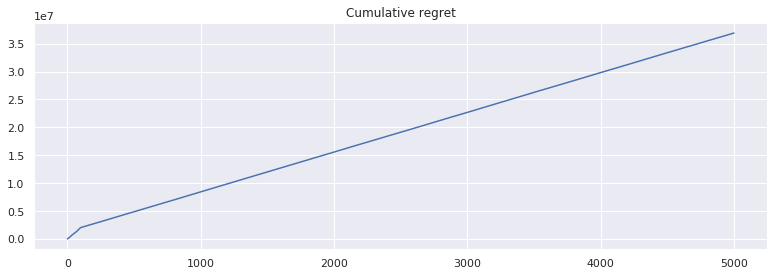

In [13]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('neural_ucb_linear.pdf')

Text(0.5,1,'Rewards without Constrained Terms')

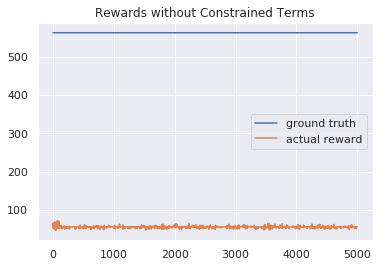

In [14]:
plt.plot([562.7936945431538]*len(model.rewards_list))
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('Rewards without Constrained Terms')

Text(0.5,1,'Constrained Terms')

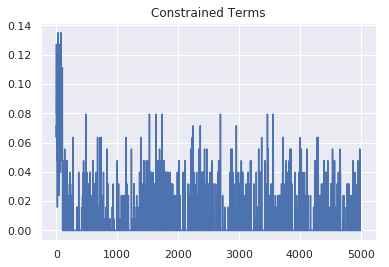

In [15]:
plt.plot(model.feasi)
plt.title('Constrained Terms')

In [16]:
np.save('reward_singleneuralUCB_1order24.npy',model.rewards_list)
np.save('constraint_singleneuralUCB_1order24.npy',model.feasi)

In [17]:
a=10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].mean())
a/= np.linalg.norm(a, ord=2)
sum(sorted(a)[-10:])

1.8421887605961924

In [18]:
[0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1]

SyntaxError: invalid syntax (<ipython-input-18-3676e20ee225>, line 1)

In [ ]:
tmp2=sorted(a)[-10:] 
np.array([1 if a[i] in tmp2 else 0 for i in range(24)])

In [ ]:
1.7588713196437444/np.sqrt(10)